In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.ensemble import RandomForestClassifier


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [20]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [21]:
p = Pipeline.objects.all()[64]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy frog ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog
Classifier: Random Forest
Task status: Status.SUCCESS


In [22]:
len(p.data_source.articles)

3099

In [23]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [24]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fbfde749fd0>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fc05418ee90>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fc05418e3d0>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...ae050>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fc05418e150>)]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [25]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [26]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [27]:
X_train = X
y_train = labels
y_test = labels_test

In [28]:
criterion_list = ['gini', 'entropy']
n_estimators_list = np.arange(1, 1000, 1, dtype=int)
max_features_list = np.arange(1, X_train.shape[1], 1, dtype=int) 
max_depth_list = np.arange(1, 50, 1, dtype=int) 
min_samples_split_list = np.arange(10, 100, 10, dtype=int)
min_samples_leaf_list = np.arange(1, 30, 1, dtype=int)
max_leaf_nodes_list = np.arange(10, 30, 2, dtype=int)
class_weights = [None, 'balanced']
bootstrap_list =[True, False]


In [29]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'criterion': hp.choice('criterion', criterion_list),
        'n_estimators': hp.choice('n_estimators', n_estimators_list),
        'max_features': hp.choice('max_features', max_features_list),
        'max_depth': hp.choice('max_depth', max_depth_list),
        'min_samples_split': hp.choice('min_samples_split', min_samples_split_list),
        'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf_list),
        'max_leaf_nodes': hp.choice('max_leaf_nodes', max_leaf_nodes_list),
        'class_weight': hp.choice('class_weight', class_weights),
        'bootstrap': hp.choice('bootstrap', bootstrap_list)
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [13]:
# def train_test_split_w_sampling(X, y, sampling_method, test_size):
#     if sampling_method == 'under-sampling':
#         random_under_sampler = RandomUnderSampler(ratio='majority', random_state=0)
#         X, y = random_under_sampler.fit_sample(X, y)

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'over-sampling':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         random_over_sampler = RandomOverSampler(ratio='minority', random_state=0)
#         X_train, y_train = random_over_sampler.fit_sample(X_train, y_train)

#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote = SMOTE(random_state=0, n_jobs=6)
#         X_train, y_train = smote.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote_enn':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote_enn = SMOTEENN(random_state=0)
#         X_train, y_train = smote_enn.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     elif sampling_method == 'smote_tomek':
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#         smote_tomek = SMOTETomek(random_state=0)
#         X_train, y_train = smote_tomek.fit_sample(X_train, y_train)
        
#         return X_train, X_test, y_train, y_test
#     else:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
        
#         return X_train, X_test, y_train, y_test

In [14]:
# X_train, X_test, y_train, y_test = train_test_split_w_sampling(X, labels, 'no sampling', 0.1)
# X_train, X_test, y_train, y_test = train_test_split_w_sampling(X, labels, 'under-sampling', 0.33)

In [30]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    criterion = params['criterion']
    n_estimators = params['n_estimators']
    max_features = params['max_features']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    max_leaf_nodes = params['max_leaf_nodes']
    class_weight = params['class_weight']
    bootstrap = params['bootstrap']
    
    model = RandomForestClassifier(criterion=criterion, n_estimators=n_estimators, max_features=max_features,
                                  max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_leaf_nodes=max_leaf_nodes, class_weight=class_weight, bootstrap=bootstrap,
                                  random_state=42, n_jobs=48)
#     model = RandomForestClassifier(criterion=criterion)
    
    model.fit(X_train, y_train)
    labels_prediction = model.predict(X_test)
    labels_probs = model.predict_proba(X_test)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, labels_prediction)
    test_loss = log_loss(y_test, labels_probs)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [31]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['criterion'] = criterion_list[best_param['criterion']]
best_param['max_leaf_nodes'] = max_leaf_nodes_list[best_param['max_leaf_nodes']]
best_param['min_samples_leaf'] = min_samples_leaf_list[best_param['min_samples_leaf']]
best_param['n_estimators'] = n_estimators_list[best_param['n_estimators']]
best_param['max_features'] = max_features_list[best_param['max_features']]
best_param['min_samples_split'] = min_samples_split_list[best_param['min_samples_split']]
best_param['max_depth'] = max_depth_list[best_param['max_depth']]
best_param['class_weight'] = class_weights[best_param['class_weight']]
best_param['bootstrap'] = bootstrap_list[best_param['bootstrap']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.629235237173 and loss 1.1780129268 :

  0%|          | 0/1000 [00:02<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.572674418605 and loss 1.32524153948 :

  0%|          | 0/1000 [00:02<?, ?it/s, best loss: ?]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 227, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

  0%|          | 0/1000 [00:02<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:02<41:22,  2.48s/it]


  0%|          | 1/1000 [00:02<36:29,  2.19s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.608583414005 and loss 1.29772473788 :

  0%|          | 1/1000 [00:02<36:29,  2.19s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.566860465116 and loss 1.68095625175 :

  0%|          | 1/1000 [00:02<36:29,  2.19s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 6, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': None}

  0%|          | 1/1000 [00:03<36:29,  2.19s/it, best loss: -0.572674418605]

Hyperopt:   0%|          | 2/1000 [00:03<33:01,  1.99s/it]


  0%|          | 2/1000 [00:03<29:35,  1.78s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.59180380768 and loss 1.27783593516 :

  0%|          | 2/1000 [00:06<29:35,  1.78s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.537790697674 and loss 1.34923200427 :

  0%|          | 2/1000 [00:06<29:35,  1.78s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 462, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 46, 'class_weight': None}

  0%|          | 2/1000 [00:06<29:35,  1.78s/it, best loss: -0.572674418605]

Hyperopt:   0%|          | 3/1000 [00:07<41:53,  2.52s/it]


  0%|          | 3/1000 [00:06<39:30,  2.38s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.595998709261 and loss 1.25238270751 :

  0%|          | 3/1000 [00:07<39:30,  2.38s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.526162790698 and loss 1.33230763993 :

  0%|          | 3/1000 [00:07<39:30,  2.38s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 26, 'max_features': 9, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 40, 'class_weight': None}

  0%|          | 3/1000 [00:07<39:30,  2.38s/it, best loss: -0.572674418605]

Hyperopt:   0%|          | 4/1000 [00:08<34:00,  2.05s/it]


  0%|          | 4/1000 [00:07<32:19,  1.95s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.459180380768 and loss 1.87210584754 :

  0%|          | 4/1000 [00:12<32:19,  1.95s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.392441860465 and loss 1.99669919561 :

  0%|          | 4/1000 [00:12<32:19,  1.95s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 721, 'max_features': 8, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': 'balanced'}

  0%|          | 4/1000 [00:12<32:19,  1.95s/it, best loss: -0.572674418605]

Hyperopt:   0%|          | 5/1000 [00:12<47:57,  2.89s/it]


  0%|          | 5/1000 [00:12<46:48,  2.82s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.580509841884 and loss 1.31696294831 :

  0%|          | 5/1000 [00:14<46:48,  2.82s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.537790697674 and loss 1.42400144302 :

  0%|          | 5/1000 [00:14<46:48,  2.82s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 204, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 11, 'class_weight': None}

  0%|          | 5/1000 [00:14<46:48,  2.82s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 6/1000 [00:14<43:49,  2.65s/it]


  1%|          | 6/1000 [00:14<43:00,  2.60s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.462407228138 and loss 1.93003342958 :

  1%|          | 6/1000 [00:18<43:00,  2.60s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.380813953488 and loss 2.07125095629 :

  1%|          | 6/1000 [00:18<43:00,  2.60s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 604, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 5, 'class_weight': 'balanced'}

  1%|          | 6/1000 [00:18<43:00,  2.60s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 7/1000 [00:19<50:57,  3.08s/it]


  1%|          | 7/1000 [00:18<50:23,  3.04s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.591481122943 and loss 1.31287694145 :

  1%|          | 7/1000 [00:21<50:23,  3.04s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.543604651163 and loss 1.38773684139 :

  1%|          | 7/1000 [00:21<50:23,  3.04s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 419, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 41, 'class_weight': None}

  1%|          | 7/1000 [00:21<50:23,  3.04s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 8/1000 [00:22<51:08,  3.09s/it]


  1%|          | 8/1000 [00:21<50:44,  3.07s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.547918683446 and loss 1.43355684471 :

  1%|          | 8/1000 [00:22<50:44,  3.07s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.526162790698 and loss 1.48776602086 :

  1%|          | 8/1000 [00:22<50:44,  3.07s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 107, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 25, 'class_weight': None}

  1%|          | 8/1000 [00:22<50:44,  3.07s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 9/1000 [00:23<41:18,  2.50s/it]


  1%|          | 9/1000 [00:22<41:01,  2.48s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.334946757018 and loss 2.07494109186 :

  1%|          | 9/1000 [00:24<41:01,  2.48s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.311046511628 and loss 2.14160284543 :

  1%|          | 9/1000 [00:24<41:01,  2.48s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 39, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 2, 'class_weight': 'balanced'}

  1%|          | 9/1000 [00:24<41:01,  2.48s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 10/1000 [00:24<34:34,  2.10s/it]


  1%|          | 10/1000 [00:24<34:22,  2.08s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.435624394966 and loss 2.01025103702 :

  1%|          | 10/1000 [00:30<34:22,  2.08s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.380813953488 and loss 2.106792124 :

  1%|          | 10/1000 [00:30<34:22,  2.08s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 836, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 4, 'class_weight': 'balanced'}

  1%|          | 10/1000 [00:30<34:22,  2.08s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 11/1000 [00:30<54:11,  3.29s/it]


  1%|          | 11/1000 [00:30<54:04,  3.28s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.447241045499 and loss 1.94396857624 :

  1%|          | 11/1000 [00:33<54:04,  3.28s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.395348837209 and loss 2.03432785618 :

  1%|          | 11/1000 [00:33<54:04,  3.28s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 442, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 10, 'class_weight': 'balanced'}

  1%|          | 11/1000 [00:33<54:04,  3.28s/it, best loss: -0.572674418605]

Hyperopt:   1%|          | 12/1000 [00:33<54:03,  3.28s/it]


  1%|          | 12/1000 [00:33<53:57,  3.28s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.477896095515 and loss 1.79247809514 :

  1%|          | 12/1000 [00:36<53:57,  3.28s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.418604651163 and loss 1.92804322961 :

  1%|          | 12/1000 [00:36<53:57,  3.28s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 365, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 4, 'class_weight': 'balanced'}

  1%|          | 12/1000 [00:36<53:57,  3.28s/it, best loss: -0.572674418605]

Hyperopt:   1%|▏         | 13/1000 [00:37<54:17,  3.30s/it]


  1%|▏         | 13/1000 [00:36<54:12,  3.30s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.41142303969 and loss 1.91692705052 :

  1%|▏         | 13/1000 [00:42<54:12,  3.30s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.380813953488 and loss 2.01394093376 :

  1%|▏         | 13/1000 [00:42<54:12,  3.30s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 793, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 29, 'class_weight': 'balanced'}

  1%|▏         | 13/1000 [00:42<54:12,  3.30s/it, best loss: -0.572674418605]

Hyperopt:   1%|▏         | 14/1000 [00:43<1:07:16,  4.09s/it]


  1%|▏         | 14/1000 [00:42<1:07:14,  4.09s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.619554695063 and loss 1.2073659587 :

  1%|▏         | 14/1000 [00:49<1:07:14,  4.09s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.563953488372 and loss 1.34191078567 :

  1%|▏         | 14/1000 [00:49<1:07:14,  4.09s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 996, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

  1%|▏         | 14/1000 [00:49<1:07:14,  4.09s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 15/1000 [00:49<1:17:55,  4.75s/it]


  2%|▏         | 15/1000 [00:49<1:17:53,  4.75s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.478864149726 and loss 1.76260312071 :

  2%|▏         | 15/1000 [00:51<1:17:53,  4.75s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.401162790698 and loss 1.90180979903 :

  2%|▏         | 15/1000 [00:51<1:17:53,  4.75s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 202, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 19, 'class_weight': 'balanced'}

  2%|▏         | 15/1000 [00:51<1:17:53,  4.75s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 16/1000 [00:51<1:06:47,  4.07s/it]


  2%|▏         | 16/1000 [00:51<1:06:45,  4.07s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.62633107454 and loss 1.13781953677 :

  2%|▏         | 16/1000 [00:52<1:06:45,  4.07s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.572674418605 and loss 1.26818659161 :

  2%|▏         | 16/1000 [00:52<1:06:45,  4.07s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 113, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': None}

  2%|▏         | 16/1000 [00:52<1:06:45,  4.07s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 17/1000 [00:53<53:51,  3.29s/it]  


  2%|▏         | 17/1000 [00:52<53:49,  3.29s/it, best loss: -0.572674418605]  
Parameters with this training accuracy 0.555663117135 and loss 1.45056134458 :

  2%|▏         | 17/1000 [00:54<53:49,  3.29s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.53488372093 and loss 1.48231605577 :

  2%|▏         | 17/1000 [00:54<53:49,  3.29s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 94, 'max_features': 4, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 2, 'class_weight': None}

  2%|▏         | 17/1000 [00:54<53:49,  3.29s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 18/1000 [00:54<44:32,  2.72s/it]


  2%|▏         | 18/1000 [00:54<44:31,  2.72s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.603420458212 and loss 1.20780351232 :

  2%|▏         | 18/1000 [00:56<44:31,  2.72s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.546511627907 and loss 1.31809032605 :

  2%|▏         | 18/1000 [00:56<44:31,  2.72s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 243, 'max_features': 6, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 11, 'class_weight': None}

  2%|▏         | 18/1000 [00:56<44:31,  2.72s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 19/1000 [00:56<41:07,  2.52s/it]


  2%|▏         | 19/1000 [00:56<41:06,  2.51s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.585672797677 and loss 1.34840858814 :

  2%|▏         | 19/1000 [01:00<41:06,  2.51s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.537790697674 and loss 1.43162557743 :

  2%|▏         | 19/1000 [01:00<41:06,  2.51s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 622, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 38, 'class_weight': None}

  2%|▏         | 19/1000 [01:00<41:06,  2.51s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 20/1000 [01:01<49:58,  3.06s/it]


  2%|▏         | 20/1000 [01:00<49:57,  3.06s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.606001936108 and loss 1.17412104389 :

  2%|▏         | 20/1000 [01:09<49:57,  3.06s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.53488372093 and loss 1.37230060535 :

  2%|▏         | 20/1000 [01:09<49:57,  3.06s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 857, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 10, 'class_weight': None}

  2%|▏         | 20/1000 [01:09<49:57,  3.06s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 21/1000 [01:10<1:19:49,  4.89s/it]


  2%|▏         | 21/1000 [01:09<1:19:50,  4.89s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.622781542433 and loss 1.19664251422 :

  2%|▏         | 21/1000 [01:15<1:19:50,  4.89s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.56976744186 and loss 1.33313480278 :

  2%|▏         | 21/1000 [01:15<1:19:50,  4.89s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 748, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 7, 'class_weight': None}

  2%|▏         | 21/1000 [01:15<1:19:50,  4.89s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 22/1000 [01:15<1:21:04,  4.97s/it]


  2%|▏         | 22/1000 [01:15<1:21:04,  4.97s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.565343659245 and loss 1.34272802177 :

  2%|▏         | 22/1000 [01:20<1:21:04,  4.97s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.531976744186 and loss 1.37017731675 :

  2%|▏         | 22/1000 [01:20<1:21:04,  4.97s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 627, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 35, 'class_weight': None}

  2%|▏         | 22/1000 [01:20<1:21:04,  4.97s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 23/1000 [01:20<1:23:18,  5.12s/it]


  2%|▏         | 23/1000 [01:20<1:23:17,  5.12s/it, best loss: -0.572674418605]
Parameters with this training accuracy 0.632139399806 and loss 1.17063214267 :

  2%|▏         | 23/1000 [01:21<1:23:17,  5.12s/it, best loss: -0.572674418605]
Parameters with this testing accuracy 0.587209302326 and loss 1.31527951039 :

  2%|▏         | 23/1000 [01:21<1:23:17,  5.12s/it, best loss: -0.572674418605]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 19, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': None}

  2%|▏         | 23/1000 [01:21<1:23:17,  5.12s/it, best loss: -0.572674418605]

Hyperopt:   2%|▏         | 24/1000 [01:21<1:02:39,  3.85s/it]


  2%|▏         | 24/1000 [01:21<1:02:38,  3.85s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.624717650855 and loss 1.1407516692 :

  2%|▏         | 24/1000 [01:29<1:02:38,  3.85s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.26770977675 :

  2%|▏         | 24/1000 [01:29<1:02:38,  3.85s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 956, 'max_features': 16, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 18, 'class_weight': None}

  2%|▏         | 24/1000 [01:29<1:02:38,  3.85s/it, best loss: -0.587209302326]

Hyperopt:   2%|▎         | 25/1000 [01:29<1:21:25,  5.01s/it]


  2%|▎         | 25/1000 [01:29<1:21:25,  5.01s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.612455630849 and loss 1.22582676822 :

  2%|▎         | 25/1000 [01:31<1:21:25,  5.01s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.35861815304 :

  2%|▎         | 25/1000 [01:31<1:21:25,  5.01s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 220, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 12, 'class_weight': None}

  2%|▎         | 25/1000 [01:31<1:21:25,  5.01s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 26/1000 [01:31<1:07:50,  4.18s/it]


  3%|▎         | 26/1000 [01:31<1:07:50,  4.18s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.587931590836 and loss 1.3468790462 :

  3%|▎         | 26/1000 [01:36<1:07:50,  4.18s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.41148436154 :

  3%|▎         | 26/1000 [01:36<1:07:50,  4.18s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 570, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 7, 'class_weight': None}

  3%|▎         | 26/1000 [01:36<1:07:50,  4.18s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 27/1000 [01:37<1:13:32,  4.53s/it]


  3%|▎         | 27/1000 [01:36<1:13:32,  4.53s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.59825750242 and loss 1.31794034016 :

  3%|▎         | 27/1000 [01:39<1:13:32,  4.53s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.39744588003 :

  3%|▎         | 27/1000 [01:39<1:13:32,  4.53s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 193, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

  3%|▎         | 27/1000 [01:39<1:13:32,  4.53s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 28/1000 [01:40<1:05:46,  4.06s/it]


  3%|▎         | 28/1000 [01:39<1:05:45,  4.06s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.63278476928 and loss 1.19665844805 :

  3%|▎         | 28/1000 [01:45<1:05:45,  4.06s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.3835238365 :

  3%|▎         | 28/1000 [01:45<1:05:45,  4.06s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 544, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 21, 'class_weight': None}

  3%|▎         | 28/1000 [01:45<1:05:45,  4.06s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 29/1000 [01:45<1:12:26,  4.48s/it]


  3%|▎         | 29/1000 [01:45<1:12:26,  4.48s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.622136172959 and loss 1.19908027942 :

  3%|▎         | 29/1000 [01:48<1:12:26,  4.48s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.33441895015 :

  3%|▎         | 29/1000 [01:48<1:12:26,  4.48s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 218, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

  3%|▎         | 29/1000 [01:48<1:12:26,  4.48s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 30/1000 [01:48<1:05:17,  4.04s/it]


  3%|▎         | 30/1000 [01:48<1:05:17,  4.04s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.626976444014 and loss 1.20577087413 :

  3%|▎         | 30/1000 [01:53<1:05:17,  4.04s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.34565480353 :

  3%|▎         | 30/1000 [01:53<1:05:17,  4.04s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 583, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': None}

  3%|▎         | 30/1000 [01:53<1:05:17,  4.04s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 31/1000 [01:53<1:10:28,  4.36s/it]


  3%|▎         | 31/1000 [01:53<1:10:28,  4.36s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.62310422717 and loss 1.19790042585 :

  3%|▎         | 31/1000 [01:57<1:10:28,  4.36s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.3419374122 :

  3%|▎         | 31/1000 [01:57<1:10:28,  4.36s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 455, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 48, 'class_weight': None}

  3%|▎         | 31/1000 [01:57<1:10:28,  4.36s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 32/1000 [01:58<1:11:28,  4.43s/it]


  3%|▎         | 32/1000 [01:57<1:11:28,  4.43s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.605356566634 and loss 1.28097785235 :

  3%|▎         | 32/1000 [01:59<1:11:28,  4.43s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.38628039857 :

  3%|▎         | 32/1000 [01:59<1:11:28,  4.43s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 19, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 39, 'class_weight': None}

  3%|▎         | 32/1000 [01:59<1:11:28,  4.43s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 33/1000 [01:59<57:06,  3.54s/it]  


  3%|▎         | 33/1000 [01:59<57:05,  3.54s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.628589867699 and loss 1.17584560438 :

  3%|▎         | 33/1000 [02:01<57:05,  3.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.33371695551 :

  3%|▎         | 33/1000 [02:01<57:05,  3.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 216, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 17, 'class_weight': None}

  3%|▎         | 33/1000 [02:01<57:05,  3.54s/it, best loss: -0.587209302326]

Hyperopt:   3%|▎         | 34/1000 [02:02<52:13,  3.24s/it]


  3%|▎         | 34/1000 [02:01<52:13,  3.24s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.59180380768 and loss 1.30166840737 :

  3%|▎         | 34/1000 [02:09<52:13,  3.24s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.39917272628 :

  3%|▎         | 34/1000 [02:09<52:13,  3.24s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 670, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 16, 'class_weight': None}

  3%|▎         | 34/1000 [02:09<52:13,  3.24s/it, best loss: -0.587209302326]

Hyperopt:   4%|▎         | 35/1000 [02:09<1:11:21,  4.44s/it]


  4%|▎         | 35/1000 [02:09<1:11:22,  4.44s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.579541787673 and loss 1.38236558947 :

  4%|▎         | 35/1000 [02:13<1:11:22,  4.44s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.4547260862 :

  4%|▎         | 35/1000 [02:13<1:11:22,  4.44s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 23, 'n_estimators': 550, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

  4%|▎         | 35/1000 [02:13<1:11:22,  4.44s/it, best loss: -0.587209302326]

Hyperopt:   4%|▎         | 36/1000 [02:13<1:11:41,  4.46s/it]


  4%|▎         | 36/1000 [02:13<1:11:41,  4.46s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.630848660858 and loss 1.1751895749 :

  4%|▎         | 36/1000 [02:15<1:11:41,  4.46s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.34162268023 :

  4%|▎         | 36/1000 [02:15<1:11:41,  4.46s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 227, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 33, 'class_weight': None}

  4%|▎         | 36/1000 [02:15<1:11:41,  4.46s/it, best loss: -0.587209302326]

Hyperopt:   4%|▎         | 37/1000 [02:15<59:57,  3.74s/it]  


  4%|▎         | 37/1000 [02:15<59:58,  3.74s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.479186834463 and loss 1.83165685087 :

  4%|▎         | 37/1000 [02:19<59:58,  3.74s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.398255813953 and loss 1.95379433533 :

  4%|▎         | 37/1000 [02:19<59:58,  3.74s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 571, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 24, 'class_weight': 'balanced'}

  4%|▎         | 37/1000 [02:19<59:58,  3.74s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 38/1000 [02:20<1:01:23,  3.83s/it]


  4%|▍         | 38/1000 [02:19<1:01:23,  3.83s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636656986125 and loss 1.15596810224 :

  4%|▍         | 38/1000 [02:21<1:01:23,  3.83s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.3241055262 :

  4%|▍         | 38/1000 [02:21<1:01:23,  3.83s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 179, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 32, 'class_weight': None}

  4%|▍         | 38/1000 [02:21<1:01:23,  3.83s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 39/1000 [02:21<52:05,  3.25s/it]  


  4%|▍         | 39/1000 [02:21<52:05,  3.25s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.637302355599 and loss 1.15506078101 :

  4%|▍         | 39/1000 [02:27<52:05,  3.25s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.32224825324 :

  4%|▍         | 39/1000 [02:27<52:05,  3.25s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 789, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 32, 'class_weight': None}

  4%|▍         | 39/1000 [02:27<52:05,  3.25s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 40/1000 [02:27<1:04:29,  4.03s/it]


  4%|▍         | 40/1000 [02:27<1:04:29,  4.03s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.488867376573 and loss 1.73830962431 :

  4%|▍         | 40/1000 [02:31<1:04:29,  4.03s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.424418604651 and loss 1.88241490847 :

  4%|▍         | 40/1000 [02:31<1:04:29,  4.03s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 580, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 28, 'class_weight': 'balanced'}

  4%|▍         | 40/1000 [02:31<1:04:29,  4.03s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 41/1000 [02:31<1:04:59,  4.07s/it]


  4%|▍         | 41/1000 [02:31<1:04:59,  4.07s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636011616651 and loss 1.15885834668 :

  4%|▍         | 41/1000 [02:38<1:04:59,  4.07s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.3217455227 :

  4%|▍         | 41/1000 [02:38<1:04:59,  4.07s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 989, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 20, 'class_weight': None}

  4%|▍         | 41/1000 [02:38<1:04:59,  4.07s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 42/1000 [02:38<1:17:04,  4.83s/it]


  4%|▍         | 42/1000 [02:38<1:17:04,  4.83s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.588254275573 and loss 1.31761282938 :

  4%|▍         | 42/1000 [02:39<1:17:04,  4.83s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.529069767442 and loss 1.42590946222 :

  4%|▍         | 42/1000 [02:39<1:17:04,  4.83s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 105, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

  4%|▍         | 42/1000 [02:39<1:17:04,  4.83s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 43/1000 [02:40<1:01:17,  3.84s/it]


  4%|▍         | 43/1000 [02:39<1:01:17,  3.84s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.474023878671 and loss 1.8891947946 :

  4%|▍         | 43/1000 [02:42<1:01:17,  3.84s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.412790697674 and loss 2.00187981676 :

  4%|▍         | 43/1000 [02:42<1:01:17,  3.84s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 349, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13, 'class_weight': 'balanced'}

  4%|▍         | 43/1000 [02:42<1:01:17,  3.84s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 44/1000 [02:42<56:10,  3.53s/it]  


  4%|▍         | 44/1000 [02:42<56:10,  3.53s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.586963536625 and loss 1.34600147353 :

  4%|▍         | 44/1000 [02:45<56:10,  3.53s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.40800472096 :

  4%|▍         | 44/1000 [02:45<56:10,  3.53s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 422, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 32, 'class_weight': None}

  4%|▍         | 44/1000 [02:45<56:10,  3.53s/it, best loss: -0.587209302326]

Hyperopt:   4%|▍         | 45/1000 [02:46<55:11,  3.47s/it]


  4%|▍         | 45/1000 [02:45<55:11,  3.47s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.471119716037 and loss 1.78911676034 :

  4%|▍         | 45/1000 [02:47<55:11,  3.47s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.424418604651 and loss 1.91369671471 :

  4%|▍         | 45/1000 [02:47<55:11,  3.47s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 159, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 8, 'class_weight': 'balanced'}

  4%|▍         | 45/1000 [02:47<55:11,  3.47s/it, best loss: -0.587209302326]

Hyperopt:   5%|▍         | 46/1000 [02:48<47:25,  2.98s/it]


  5%|▍         | 46/1000 [02:47<47:25,  2.98s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.613746369797 and loss 1.2199182355 :

  5%|▍         | 46/1000 [02:50<47:25,  2.98s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.3596099461 :

  5%|▍         | 46/1000 [02:50<47:25,  2.98s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 254, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 44, 'class_weight': None}

  5%|▍         | 46/1000 [02:50<47:25,  2.98s/it, best loss: -0.587209302326]

Hyperopt:   5%|▍         | 47/1000 [02:50<44:40,  2.81s/it]


  5%|▍         | 47/1000 [02:50<44:40,  2.81s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.439173927073 and loss 2.03625895948 :

  5%|▍         | 47/1000 [02:53<44:40,  2.81s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.386627906977 and loss 2.14401537681 :

  5%|▍         | 47/1000 [02:53<44:40,  2.81s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 407, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': 'balanced'}

  5%|▍         | 47/1000 [02:53<44:40,  2.81s/it, best loss: -0.587209302326]

Hyperopt:   5%|▍         | 48/1000 [02:53<45:47,  2.89s/it]


  5%|▍         | 48/1000 [02:53<45:47,  2.89s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.595998709261 and loss 1.35957932098 :

  5%|▍         | 48/1000 [02:54<45:47,  2.89s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.42726750031 :

  5%|▍         | 48/1000 [02:54<45:47,  2.89s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 30, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 3, 'class_weight': None}

  5%|▍         | 48/1000 [02:54<45:47,  2.89s/it, best loss: -0.587209302326]

Hyperopt:   5%|▍         | 49/1000 [02:54<36:39,  2.31s/it]


  5%|▍         | 49/1000 [02:54<36:39,  2.31s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.58535011294 and loss 1.32149220024 :

  5%|▍         | 49/1000 [02:58<36:39,  2.31s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.531976744186 and loss 1.38224508825 :

  5%|▍         | 49/1000 [02:58<36:39,  2.31s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 503, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 6, 'class_weight': None}

  5%|▍         | 49/1000 [02:58<36:39,  2.31s/it, best loss: -0.587209302326]

Hyperopt:   5%|▌         | 50/1000 [02:58<44:15,  2.80s/it]


  5%|▌         | 50/1000 [02:58<44:16,  2.80s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.597934817683 and loss 1.27837965316 :

  5%|▌         | 50/1000 [03:03<44:16,  2.80s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.37249119299 :

  5%|▌         | 50/1000 [03:03<44:16,  2.80s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 870, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 22, 'class_weight': None}

  5%|▌         | 50/1000 [03:03<44:16,  2.80s/it, best loss: -0.587209302326]

Hyperopt:   5%|▌         | 51/1000 [03:04<58:23,  3.69s/it]


  5%|▌         | 51/1000 [03:03<58:24,  3.69s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.476928041304 and loss 1.83630915794 :

  5%|▌         | 51/1000 [03:08<58:24,  3.69s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.40988372093 and loss 1.96644700243 :

  5%|▌         | 51/1000 [03:08<58:24,  3.69s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 639, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': 'balanced'}

  5%|▌         | 51/1000 [03:08<58:24,  3.69s/it, best loss: -0.587209302326]

Hyperopt:   5%|▌         | 52/1000 [03:08<1:02:51,  3.98s/it]


  5%|▌         | 52/1000 [03:08<1:02:51,  3.98s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.629235237173 and loss 1.17204650067 :

  5%|▌         | 52/1000 [03:13<1:02:51,  3.98s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.32338275224 :

  5%|▌         | 52/1000 [03:13<1:02:51,  3.98s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 474, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

  5%|▌         | 52/1000 [03:13<1:02:51,  3.98s/it, best loss: -0.587209302326]

Hyperopt:   5%|▌         | 53/1000 [03:13<1:06:49,  4.23s/it]


  5%|▌         | 53/1000 [03:13<1:06:49,  4.23s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.618586640852 and loss 1.22313035286 :

  5%|▌         | 53/1000 [03:16<1:06:49,  4.23s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.561046511628 and loss 1.35201895027 :

  5%|▌         | 53/1000 [03:16<1:06:49,  4.23s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 326, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 42, 'class_weight': None}

  5%|▌         | 53/1000 [03:16<1:06:49,  4.23s/it, best loss: -0.587209302326]

Hyperopt:   5%|▌         | 54/1000 [03:17<1:03:41,  4.04s/it]


  5%|▌         | 54/1000 [03:16<1:03:41,  4.04s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.445627621813 and loss 1.94416930253 :

  5%|▌         | 54/1000 [03:22<1:03:41,  4.04s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.375 and loss 2.06528169965 :

  5%|▌         | 54/1000 [03:22<1:03:41,  4.04s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 545, 'max_features': 3, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': 'balanced'}

  5%|▌         | 54/1000 [03:22<1:03:41,  4.04s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 55/1000 [03:22<1:11:14,  4.52s/it]


  6%|▌         | 55/1000 [03:22<1:11:14,  4.52s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.598902871894 and loss 1.27973061762 :

  6%|▌         | 55/1000 [03:24<1:11:14,  4.52s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.546511627907 and loss 1.37449195521 :

  6%|▌         | 55/1000 [03:24<1:11:14,  4.52s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 154, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

  6%|▌         | 55/1000 [03:25<1:11:14,  4.52s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 56/1000 [03:25<1:01:04,  3.88s/it]


  6%|▌         | 56/1000 [03:25<1:01:04,  3.88s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.515004840271 and loss 1.57628550291 :

  6%|▌         | 56/1000 [03:29<1:01:04,  3.88s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.494186046512 and loss 1.55884105079 :

  6%|▌         | 56/1000 [03:29<1:01:04,  3.88s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 332, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 1, 'class_weight': None}

  6%|▌         | 56/1000 [03:29<1:01:04,  3.88s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 57/1000 [03:29<1:02:47,  4.00s/it]


  6%|▌         | 57/1000 [03:29<1:02:47,  4.00s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.58535011294 and loss 1.34783036435 :

  6%|▌         | 57/1000 [03:35<1:02:47,  4.00s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.40602569779 :

  6%|▌         | 57/1000 [03:35<1:02:47,  4.00s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 702, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 23, 'class_weight': None}

  6%|▌         | 57/1000 [03:35<1:02:47,  4.00s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 58/1000 [03:36<1:14:34,  4.75s/it]


  6%|▌         | 58/1000 [03:35<1:14:34,  4.75s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.575024201355 and loss 1.34409476979 :

  6%|▌         | 58/1000 [03:38<1:14:34,  4.75s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.43375217366 :

  6%|▌         | 58/1000 [03:38<1:14:34,  4.75s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 180, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 25, 'class_weight': None}

  6%|▌         | 58/1000 [03:38<1:14:34,  4.75s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 59/1000 [03:38<1:02:51,  4.01s/it]


  6%|▌         | 59/1000 [03:38<1:02:51,  4.01s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.430461439174 and loss 1.8847417786 :

  6%|▌         | 59/1000 [03:46<1:02:51,  4.01s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.398255813953 and loss 1.99199747646 :

  6%|▌         | 59/1000 [03:46<1:02:51,  4.01s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 879, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 47, 'class_weight': 'balanced'}

  6%|▌         | 59/1000 [03:46<1:02:51,  4.01s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 60/1000 [03:46<1:24:09,  5.37s/it]


  6%|▌         | 60/1000 [03:46<1:24:09,  5.37s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.606001936108 and loss 1.25226925262 :

  6%|▌         | 60/1000 [03:52<1:24:09,  5.37s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.561046511628 and loss 1.38063586201 :

  6%|▌         | 60/1000 [03:52<1:24:09,  5.37s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 653, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 49, 'class_weight': None}

  6%|▌         | 60/1000 [03:52<1:24:09,  5.37s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 61/1000 [03:52<1:26:40,  5.54s/it]


  6%|▌         | 61/1000 [03:52<1:26:40,  5.54s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.637947725073 and loss 1.1578625064 :

  6%|▌         | 61/1000 [03:59<1:26:40,  5.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.32067144779 :

  6%|▌         | 61/1000 [03:59<1:26:40,  5.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 621, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

  6%|▌         | 61/1000 [03:59<1:26:40,  5.54s/it, best loss: -0.587209302326]

Hyperopt:   6%|▌         | 62/1000 [03:59<1:31:05,  5.83s/it]


  6%|▌         | 62/1000 [03:59<1:31:05,  5.83s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.586963536625 and loss 1.35914067261 :

  6%|▌         | 62/1000 [04:00<1:31:05,  5.83s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.43665183035 :

  6%|▌         | 62/1000 [04:00<1:31:05,  5.83s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 90, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 37, 'class_weight': None}

  6%|▌         | 62/1000 [04:00<1:31:05,  5.83s/it, best loss: -0.587209302326]

Hyperopt:   6%|▋         | 63/1000 [04:00<1:10:47,  4.53s/it]


  6%|▋         | 63/1000 [04:00<1:10:47,  4.53s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.612132946112 and loss 1.17249828563 :

  6%|▋         | 63/1000 [04:06<1:10:47,  4.53s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.29921666863 :

  6%|▋         | 63/1000 [04:06<1:10:47,  4.53s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 6, 'n_estimators': 589, 'max_features': 6, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

  6%|▋         | 63/1000 [04:06<1:10:47,  4.53s/it, best loss: -0.587209302326]

Hyperopt:   6%|▋         | 64/1000 [04:07<1:19:41,  5.11s/it]


  6%|▋         | 64/1000 [04:07<1:19:41,  5.11s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.456921587609 and loss 1.93392197388 :

  6%|▋         | 64/1000 [04:10<1:19:41,  5.11s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.401162790698 and loss 2.03086232737 :

  6%|▋         | 64/1000 [04:10<1:19:41,  5.11s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 284, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': 'balanced'}

  6%|▋         | 64/1000 [04:10<1:19:41,  5.11s/it, best loss: -0.587209302326]

Hyperopt:   6%|▋         | 65/1000 [04:10<1:10:41,  4.54s/it]


  6%|▋         | 65/1000 [04:10<1:10:41,  4.54s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.637947725073 and loss 1.15458058759 :

  6%|▋         | 65/1000 [04:12<1:10:41,  4.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.572674418605 and loss 1.32914992762 :

  6%|▋         | 65/1000 [04:12<1:10:41,  4.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 229, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 14, 'class_weight': None}

  6%|▋         | 65/1000 [04:13<1:10:41,  4.54s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 66/1000 [04:13<1:02:32,  4.02s/it]


  7%|▋         | 66/1000 [04:13<1:02:31,  4.02s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636979670862 and loss 1.15525708188 :

  7%|▋         | 66/1000 [04:18<1:02:31,  4.02s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.32348420742 :

  7%|▋         | 66/1000 [04:18<1:02:31,  4.02s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 621, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

  7%|▋         | 66/1000 [04:18<1:02:31,  4.02s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 67/1000 [04:19<1:10:18,  4.52s/it]


  7%|▋         | 67/1000 [04:18<1:10:19,  4.52s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.639238464021 and loss 1.15286121717 :

  7%|▋         | 67/1000 [04:24<1:10:19,  4.52s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32422010193 :

  7%|▋         | 67/1000 [04:24<1:10:19,  4.52s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 559, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

  7%|▋         | 67/1000 [04:24<1:10:19,  4.52s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 68/1000 [04:24<1:14:00,  4.76s/it]


  7%|▋         | 68/1000 [04:24<1:14:00,  4.76s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.622781542433 and loss 1.19805024962 :

  7%|▋         | 68/1000 [04:32<1:14:00,  4.76s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.546511627907 and loss 1.34922922183 :

  7%|▋         | 68/1000 [04:32<1:14:00,  4.76s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 936, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

  7%|▋         | 68/1000 [04:32<1:14:00,  4.76s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 69/1000 [04:32<1:32:00,  5.93s/it]


  7%|▋         | 69/1000 [04:32<1:32:01,  5.93s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.630848660858 and loss 1.17097147667 :

  7%|▋         | 69/1000 [04:36<1:32:01,  5.93s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.575581395349 and loss 1.33029320204 :

  7%|▋         | 69/1000 [04:37<1:32:01,  5.93s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 438, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

  7%|▋         | 69/1000 [04:37<1:32:01,  5.93s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 70/1000 [04:37<1:24:27,  5.45s/it]


  7%|▋         | 70/1000 [04:37<1:24:27,  5.45s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.59503065505 and loss 1.28813122766 :

  7%|▋         | 70/1000 [04:45<1:24:27,  5.45s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.540697674419 and loss 1.40256491766 :

  7%|▋         | 70/1000 [04:45<1:24:27,  5.45s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 950, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 5, 'class_weight': None}

  7%|▋         | 70/1000 [04:45<1:24:27,  5.45s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 71/1000 [04:45<1:39:00,  6.39s/it]


  7%|▋         | 71/1000 [04:45<1:39:01,  6.40s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.638915779284 and loss 1.14532519958 :

  7%|▋         | 71/1000 [04:53<1:39:01,  6.40s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.31519402842 :

  7%|▋         | 71/1000 [04:53<1:39:01,  6.40s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 932, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

  7%|▋         | 71/1000 [04:53<1:39:01,  6.40s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 72/1000 [04:54<1:46:52,  6.91s/it]


  7%|▋         | 72/1000 [04:53<1:46:52,  6.91s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.641819941917 and loss 1.14139561288 :

  7%|▋         | 72/1000 [04:55<1:46:52,  6.91s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.31894765961 :

  7%|▋         | 72/1000 [04:55<1:46:52,  6.91s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 55, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

  7%|▋         | 72/1000 [04:55<1:46:52,  6.91s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 73/1000 [04:55<1:22:40,  5.35s/it]


  7%|▋         | 73/1000 [04:55<1:22:38,  5.35s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.613101000323 and loss 1.2319189972 :

  7%|▋         | 73/1000 [05:01<1:22:38,  5.35s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.35044090733 :

  7%|▋         | 73/1000 [05:01<1:22:38,  5.35s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 540, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 41, 'class_weight': None}

  7%|▋         | 73/1000 [05:01<1:22:38,  5.35s/it, best loss: -0.587209302326]

Hyperopt:   7%|▋         | 74/1000 [05:01<1:23:53,  5.44s/it]


  7%|▋         | 74/1000 [05:01<1:23:53,  5.44s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.627944498225 and loss 1.1759176986 :

  7%|▋         | 74/1000 [05:06<1:23:53,  5.44s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.32788224711 :

  7%|▋         | 74/1000 [05:06<1:23:53,  5.44s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 552, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

  7%|▋         | 74/1000 [05:06<1:23:53,  5.44s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 75/1000 [05:07<1:25:03,  5.52s/it]


  8%|▊         | 75/1000 [05:06<1:25:03,  5.52s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.593417231365 and loss 1.35309409736 :

  8%|▊         | 75/1000 [05:13<1:25:03,  5.52s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.41743608535 :

  8%|▊         | 75/1000 [05:13<1:25:03,  5.52s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 684, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': None}

  8%|▊         | 75/1000 [05:13<1:25:03,  5.52s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 76/1000 [05:13<1:30:51,  5.90s/it]


  8%|▊         | 76/1000 [05:13<1:30:52,  5.90s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636979670862 and loss 1.16538601648 :

  8%|▊         | 76/1000 [05:15<1:30:52,  5.90s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.561046511628 and loss 1.32230421759 :

  8%|▊         | 76/1000 [05:15<1:30:52,  5.90s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 80, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

  8%|▊         | 76/1000 [05:15<1:30:52,  5.90s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 77/1000 [05:15<1:10:22,  4.57s/it]


  8%|▊         | 77/1000 [05:15<1:10:21,  4.57s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.60471119716 and loss 1.2513347462 :

  8%|▊         | 77/1000 [05:19<1:10:21,  4.57s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.36014944779 :

  8%|▊         | 77/1000 [05:19<1:10:21,  4.57s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 384, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 29, 'class_weight': None}

  8%|▊         | 77/1000 [05:19<1:10:21,  4.57s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 78/1000 [05:19<1:08:26,  4.45s/it]


  8%|▊         | 78/1000 [05:19<1:08:27,  4.45s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.627944498225 and loss 1.17371230752 :

  8%|▊         | 78/1000 [05:27<1:08:27,  4.45s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.32818589216 :

  8%|▊         | 78/1000 [05:27<1:08:27,  4.45s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 918, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': None}

  8%|▊         | 78/1000 [05:27<1:08:27,  4.45s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 79/1000 [05:28<1:27:06,  5.67s/it]


  8%|▊         | 79/1000 [05:27<1:27:07,  5.68s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.596321393998 and loss 1.22717117564 :

  8%|▊         | 79/1000 [05:34<1:27:07,  5.68s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.540697674419 and loss 1.36191014886 :

  8%|▊         | 79/1000 [05:34<1:27:07,  5.68s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 14, 'n_estimators': 478, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 35, 'class_weight': None}

  8%|▊         | 79/1000 [05:34<1:27:07,  5.68s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 80/1000 [05:34<1:31:45,  5.98s/it]


  8%|▊         | 80/1000 [05:34<1:31:45,  5.98s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.500161342369 and loss 1.72961775919 :

  8%|▊         | 80/1000 [05:40<1:31:45,  5.98s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.436046511628 and loss 1.88177444239 :

  8%|▊         | 80/1000 [05:40<1:31:45,  5.98s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 617, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 18, 'class_weight': 'balanced'}

  8%|▊         | 80/1000 [05:40<1:31:45,  5.98s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 81/1000 [05:40<1:32:38,  6.05s/it]


  8%|▊         | 81/1000 [05:40<1:32:38,  6.05s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.591481122943 and loss 1.31399401869 :

  8%|▊         | 81/1000 [05:43<1:32:38,  6.05s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.38775730985 :

  8%|▊         | 81/1000 [05:43<1:32:38,  6.05s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 219, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 32, 'class_weight': None}

  8%|▊         | 81/1000 [05:43<1:32:38,  6.05s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 82/1000 [05:43<1:16:06,  4.97s/it]


  8%|▊         | 82/1000 [05:43<1:16:05,  4.97s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.606647305582 and loss 1.24160330831 :

  8%|▊         | 82/1000 [05:48<1:16:05,  4.97s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.540697674419 and loss 1.36678365388 :

  8%|▊         | 82/1000 [05:48<1:16:05,  4.97s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 498, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

  8%|▊         | 82/1000 [05:48<1:16:05,  4.97s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 83/1000 [05:48<1:16:21,  5.00s/it]


  8%|▊         | 83/1000 [05:48<1:16:21,  5.00s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.617618586641 and loss 1.20537538527 :

  8%|▊         | 83/1000 [05:51<1:16:21,  5.00s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.34208502239 :

  8%|▊         | 83/1000 [05:51<1:16:21,  5.00s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 291, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

  8%|▊         | 83/1000 [05:51<1:16:21,  5.00s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 84/1000 [05:51<1:07:43,  4.44s/it]


  8%|▊         | 84/1000 [05:51<1:07:43,  4.44s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.559535333979 and loss 1.42616612885 :

  8%|▊         | 84/1000 [05:55<1:07:43,  4.44s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.45731949689 :

  8%|▊         | 84/1000 [05:55<1:07:43,  4.44s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 418, 'max_features': 6, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 2, 'class_weight': None}

  8%|▊         | 84/1000 [05:55<1:07:43,  4.44s/it, best loss: -0.587209302326]

Hyperopt:   8%|▊         | 85/1000 [05:56<1:07:44,  4.44s/it]


  8%|▊         | 85/1000 [05:55<1:07:43,  4.44s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.494675701839 and loss 1.9828452405 :

  8%|▊         | 85/1000 [06:02<1:07:43,  4.44s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.398255813953 and loss 2.11989662382 :

  8%|▊         | 85/1000 [06:02<1:07:43,  4.44s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 820, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': 'balanced'}

  8%|▊         | 85/1000 [06:02<1:07:43,  4.44s/it, best loss: -0.587209302326]

Hyperopt:   9%|▊         | 86/1000 [06:03<1:19:33,  5.22s/it]


  9%|▊         | 86/1000 [06:02<1:19:33,  5.22s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.603743142949 and loss 1.27073084512 :

  9%|▊         | 86/1000 [06:06<1:19:33,  5.22s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.36534433959 :

  9%|▊         | 86/1000 [06:06<1:19:33,  5.22s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 396, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': None}

  9%|▊         | 86/1000 [06:06<1:19:33,  5.22s/it, best loss: -0.587209302326]

Hyperopt:   9%|▊         | 87/1000 [06:07<1:13:31,  4.83s/it]


  9%|▊         | 87/1000 [06:06<1:13:31,  4.83s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.616327847693 and loss 1.21403612245 :

  9%|▊         | 87/1000 [06:11<1:13:31,  4.83s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.53488372093 and loss 1.35727765243 :

  9%|▊         | 87/1000 [06:11<1:13:31,  4.83s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 489, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 17, 'class_weight': None}

  9%|▊         | 87/1000 [06:11<1:13:31,  4.83s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 88/1000 [06:11<1:13:07,  4.81s/it]


  9%|▉         | 88/1000 [06:11<1:13:07,  4.81s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636011616651 and loss 1.15970696513 :

  9%|▉         | 88/1000 [06:17<1:13:07,  4.81s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.32191308994 :

  9%|▉         | 88/1000 [06:17<1:13:07,  4.81s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 704, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 48, 'class_weight': None}

  9%|▉         | 88/1000 [06:17<1:13:07,  4.81s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 89/1000 [06:18<1:20:29,  5.30s/it]


  9%|▉         | 89/1000 [06:17<1:20:29,  5.30s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.394966118103 and loss 1.85031610188 :

  9%|▉         | 89/1000 [06:21<1:20:29,  5.30s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.366279069767 and loss 1.97175231972 :

  9%|▉         | 89/1000 [06:21<1:20:29,  5.30s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 148, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 15, 'class_weight': 'balanced'}

  9%|▉         | 89/1000 [06:21<1:20:29,  5.30s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 90/1000 [06:21<1:10:50,  4.67s/it]


  9%|▉         | 90/1000 [06:21<1:10:49,  4.67s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.609551468216 and loss 1.22957430715 :

  9%|▉         | 90/1000 [06:27<1:10:49,  4.67s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.34684201634 :

  9%|▉         | 90/1000 [06:27<1:10:49,  4.67s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 770, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

  9%|▉         | 90/1000 [06:27<1:10:49,  4.67s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 91/1000 [06:28<1:19:30,  5.25s/it]


  9%|▉         | 91/1000 [06:27<1:19:31,  5.25s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.572442723459 and loss 1.43038072085 :

  9%|▉         | 91/1000 [06:32<1:19:31,  5.25s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.47740690063 :

  9%|▉         | 91/1000 [06:32<1:19:31,  5.25s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 515, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 16, 'class_weight': None}

  9%|▉         | 91/1000 [06:32<1:19:31,  5.25s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 92/1000 [06:32<1:17:56,  5.15s/it]


  9%|▉         | 92/1000 [06:32<1:17:56,  5.15s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.599225556631 and loss 1.280714132 :

  9%|▉         | 92/1000 [06:34<1:17:56,  5.15s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.3742265069 :

  9%|▉         | 92/1000 [06:34<1:17:56,  5.15s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 58, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 26, 'class_weight': None}

  9%|▉         | 92/1000 [06:34<1:17:56,  5.15s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 93/1000 [06:34<1:02:32,  4.14s/it]


  9%|▉         | 93/1000 [06:34<1:02:31,  4.14s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.480800258148 and loss 1.81483787088 :

  9%|▉         | 93/1000 [06:40<1:02:31,  4.14s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.40988372093 and loss 1.96605085259 :

  9%|▉         | 93/1000 [06:40<1:02:31,  4.14s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 683, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 20, 'class_weight': 'balanced'}

  9%|▉         | 93/1000 [06:40<1:02:31,  4.14s/it, best loss: -0.587209302326]

Hyperopt:   9%|▉         | 94/1000 [06:41<1:12:18,  4.79s/it]


  9%|▉         | 94/1000 [06:40<1:12:18,  4.79s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.605356566634 and loss 1.25511611848 :

  9%|▉         | 94/1000 [06:44<1:12:18,  4.79s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.36271645698 :

  9%|▉         | 94/1000 [06:44<1:12:18,  4.79s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 259, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': None}

  9%|▉         | 94/1000 [06:44<1:12:18,  4.79s/it, best loss: -0.587209302326]

Hyperopt:  10%|▉         | 95/1000 [06:44<1:05:38,  4.35s/it]


 10%|▉         | 95/1000 [06:44<1:05:38,  4.35s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.637625040336 and loss 1.15761688273 :

 10%|▉         | 95/1000 [06:49<1:05:38,  4.35s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32025164641 :

 10%|▉         | 95/1000 [06:49<1:05:38,  4.35s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 586, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 39, 'class_weight': None}

 10%|▉         | 95/1000 [06:49<1:05:38,  4.35s/it, best loss: -0.587209302326]

Hyperopt:  10%|▉         | 96/1000 [06:49<1:10:17,  4.67s/it]


 10%|▉         | 96/1000 [06:49<1:10:17,  4.67s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.64472410455 and loss 1.14687987814 :

 10%|▉         | 96/1000 [06:51<1:10:17,  4.67s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.3196246815 :

 10%|▉         | 96/1000 [06:51<1:10:17,  4.67s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 126, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 40, 'class_weight': None}

 10%|▉         | 96/1000 [06:51<1:10:17,  4.67s/it, best loss: -0.587209302326]

Hyperopt:  10%|▉         | 97/1000 [06:51<58:07,  3.86s/it]  


 10%|▉         | 97/1000 [06:51<58:07,  3.86s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.612778315586 and loss 1.2346944076 :

 10%|▉         | 97/1000 [06:52<58:07,  3.86s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.561046511628 and loss 1.36788505588 :

 10%|▉         | 97/1000 [06:52<58:07,  3.86s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 9, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 10%|▉         | 97/1000 [06:52<58:07,  3.86s/it, best loss: -0.587209302326]

Hyperopt:  10%|▉         | 98/1000 [06:53<46:44,  3.11s/it]


 10%|▉         | 98/1000 [06:52<46:43,  3.11s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.425943852856 and loss 1.96975618519 :

 10%|▉         | 98/1000 [07:00<46:43,  3.11s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.386627906977 and loss 2.05709162766 :

 10%|▉         | 98/1000 [07:00<46:43,  3.11s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 814, 'max_features': 9, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 28, 'class_weight': 'balanced'}

 10%|▉         | 98/1000 [07:00<46:43,  3.11s/it, best loss: -0.587209302326]

Hyperopt:  10%|▉         | 99/1000 [07:01<1:09:06,  4.60s/it]


 10%|▉         | 99/1000 [07:00<1:09:06,  4.60s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.630203291384 and loss 1.16298888357 :

 10%|▉         | 99/1000 [07:03<1:09:06,  4.60s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.32609843472 :

 10%|▉         | 99/1000 [07:03<1:09:06,  4.60s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 173, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 32, 'class_weight': None}

 10%|▉         | 99/1000 [07:03<1:09:06,  4.60s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 100/1000 [07:03<59:08,  3.94s/it] 


 10%|█         | 100/1000 [07:03<59:08,  3.94s/it, best loss: -0.587209302326] 
Parameters with this training accuracy 0.615682478219 and loss 1.20858202478 :

 10%|█         | 100/1000 [07:08<59:08,  3.94s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.572674418605 and loss 1.34077509059 :

 10%|█         | 100/1000 [07:08<59:08,  3.94s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 566, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 9, 'class_weight': None}

 10%|█         | 100/1000 [07:08<59:08,  3.94s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 101/1000 [07:08<1:05:31,  4.37s/it]


 10%|█         | 101/1000 [07:08<1:05:31,  4.37s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.615359793482 and loss 1.22083296966 :

 10%|█         | 101/1000 [07:10<1:05:31,  4.37s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.36510166124 :

 10%|█         | 101/1000 [07:10<1:05:31,  4.37s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 144, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 11, 'class_weight': None}

 10%|█         | 101/1000 [07:10<1:05:31,  4.37s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 102/1000 [07:11<55:57,  3.74s/it]  


 10%|█         | 102/1000 [07:10<55:57,  3.74s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.633752823491 and loss 1.15788225889 :

 10%|█         | 102/1000 [07:17<55:57,  3.74s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.575581395349 and loss 1.3203797491 :

 10%|█         | 102/1000 [07:17<55:57,  3.74s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 755, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 13, 'class_weight': None}

 10%|█         | 102/1000 [07:17<55:57,  3.74s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 103/1000 [07:17<1:08:15,  4.57s/it]


 10%|█         | 103/1000 [07:17<1:08:16,  4.57s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.590190383995 and loss 1.30095444676 :

 10%|█         | 103/1000 [07:18<1:08:16,  4.57s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.37599488569 :

 10%|█         | 103/1000 [07:18<1:08:16,  4.57s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 44, 'max_features': 8, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 10%|█         | 103/1000 [07:18<1:08:16,  4.57s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 104/1000 [07:19<53:53,  3.61s/it]  


 10%|█         | 104/1000 [07:18<53:52,  3.61s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.453694740239 and loss 1.9410853268 :

 10%|█         | 104/1000 [07:22<53:52,  3.61s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.415697674419 and loss 2.0325971816 :

 10%|█         | 104/1000 [07:22<53:52,  3.61s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 307, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 8, 'class_weight': 'balanced'}

 10%|█         | 104/1000 [07:22<53:52,  3.61s/it, best loss: -0.587209302326]

Hyperopt:  10%|█         | 105/1000 [07:22<53:06,  3.56s/it]


 10%|█         | 105/1000 [07:22<53:06,  3.56s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.596321393998 and loss 1.35140307466 :

 10%|█         | 105/1000 [07:23<53:06,  3.56s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.546511627907 and loss 1.41463641187 :

 10%|█         | 105/1000 [07:23<53:06,  3.56s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 19, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 44, 'class_weight': None}

 10%|█         | 105/1000 [07:23<53:06,  3.56s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 106/1000 [07:23<41:57,  2.82s/it]


 11%|█         | 106/1000 [07:23<41:56,  2.82s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.638915779284 and loss 1.1531091621 :

 11%|█         | 106/1000 [07:32<41:56,  2.82s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32391076192 :

 11%|█         | 106/1000 [07:32<41:56,  2.82s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 939, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 11%|█         | 106/1000 [07:32<41:56,  2.82s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 107/1000 [07:32<1:08:38,  4.61s/it]


 11%|█         | 107/1000 [07:32<1:08:39,  4.61s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.625040335592 and loss 1.18602650395 :

 11%|█         | 107/1000 [07:40<1:08:39,  4.61s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.575581395349 and loss 1.33169871812 :

 11%|█         | 107/1000 [07:40<1:08:39,  4.61s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 914, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 27, 'class_weight': None}

 11%|█         | 107/1000 [07:40<1:08:39,  4.61s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 108/1000 [07:40<1:24:11,  5.66s/it]


 11%|█         | 108/1000 [07:40<1:24:12,  5.66s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.433688286544 and loss 2.08416956332 :

 11%|█         | 108/1000 [07:48<1:24:12,  5.66s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.343023255814 and loss 2.18372341913 :

 11%|█         | 108/1000 [07:48<1:24:12,  5.66s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 953, 'max_features': 1, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 22, 'class_weight': 'balanced'}

 11%|█         | 108/1000 [07:48<1:24:12,  5.66s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 109/1000 [07:49<1:36:51,  6.52s/it]


 11%|█         | 109/1000 [07:48<1:36:51,  6.52s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.640529202969 and loss 1.15352838565 :

 11%|█         | 109/1000 [07:54<1:36:51,  6.52s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.3228614231 :

 11%|█         | 109/1000 [07:54<1:36:51,  6.52s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 654, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 11%|█         | 109/1000 [07:54<1:36:51,  6.52s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 110/1000 [07:55<1:34:13,  6.35s/it]


 11%|█         | 110/1000 [07:54<1:34:13,  6.35s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.587931590836 and loss 1.33827172458 :

 11%|█         | 110/1000 [07:56<1:34:13,  6.35s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.41797189978 :

 11%|█         | 110/1000 [07:56<1:34:13,  6.35s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 153, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 11%|█         | 110/1000 [07:56<1:34:13,  6.35s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 111/1000 [07:57<1:15:37,  5.10s/it]


 11%|█         | 111/1000 [07:56<1:15:37,  5.10s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.639238464021 and loss 1.1550685704 :

 11%|█         | 111/1000 [08:00<1:15:37,  5.10s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.32762198794 :

 11%|█         | 111/1000 [08:00<1:15:37,  5.10s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 260, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 11%|█         | 111/1000 [08:00<1:15:37,  5.10s/it, best loss: -0.587209302326]

Hyperopt:  11%|█         | 112/1000 [08:00<1:07:19,  4.55s/it]


 11%|█         | 112/1000 [08:00<1:07:19,  4.55s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.618909325589 and loss 1.20525381326 :

 11%|█         | 112/1000 [08:07<1:07:19,  4.55s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.566860465116 and loss 1.33711916267 :

 11%|█         | 112/1000 [08:07<1:07:19,  4.55s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 822, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 11%|█         | 112/1000 [08:07<1:07:19,  4.55s/it, best loss: -0.587209302326]

Hyperopt:  11%|█▏        | 113/1000 [08:07<1:17:30,  5.24s/it]


 11%|█▏        | 113/1000 [08:07<1:17:30,  5.24s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.620200064537 and loss 1.17477989106 :

 11%|█▏        | 113/1000 [08:08<1:17:30,  5.24s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.28195480443 :

 11%|█▏        | 113/1000 [08:08<1:17:30,  5.24s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 18, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 45, 'class_weight': None}

 11%|█▏        | 113/1000 [08:08<1:17:30,  5.24s/it, best loss: -0.587209302326]

Hyperopt:  11%|█▏        | 114/1000 [08:09<1:01:55,  4.19s/it]


 11%|█▏        | 114/1000 [08:08<1:01:54,  4.19s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.490803484995 and loss 1.83303394646 :

 11%|█▏        | 114/1000 [08:16<1:01:54,  4.19s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.421511627907 and loss 1.98277846833 :

 11%|█▏        | 114/1000 [08:16<1:01:54,  4.19s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 909, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 34, 'class_weight': 'balanced'}

 11%|█▏        | 114/1000 [08:16<1:01:54,  4.19s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 115/1000 [08:16<1:17:29,  5.25s/it]


 12%|█▏        | 115/1000 [08:16<1:17:29,  5.25s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.581155211359 and loss 1.37071491224 :

 12%|█▏        | 115/1000 [08:19<1:17:29,  5.25s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.4428970429 :

 12%|█▏        | 115/1000 [08:19<1:17:29,  5.25s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 278, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 12%|█▏        | 115/1000 [08:19<1:17:29,  5.25s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 116/1000 [08:19<1:07:27,  4.58s/it]


 12%|█▏        | 116/1000 [08:19<1:07:27,  4.58s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.610842207164 and loss 1.23028221496 :

 12%|█▏        | 116/1000 [08:23<1:07:27,  4.58s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.552325581395 and loss 1.35311605048 :

 12%|█▏        | 116/1000 [08:23<1:07:27,  4.58s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 312, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 10, 'class_weight': None}

 12%|█▏        | 116/1000 [08:23<1:07:27,  4.58s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 117/1000 [08:23<1:05:04,  4.42s/it]


 12%|█▏        | 117/1000 [08:23<1:05:04,  4.42s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.634398192965 and loss 1.15647324299 :

 12%|█▏        | 117/1000 [08:26<1:05:04,  4.42s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.32443962633 :

 12%|█▏        | 117/1000 [08:26<1:05:04,  4.42s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 347, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 12%|█▏        | 117/1000 [08:26<1:05:04,  4.42s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 118/1000 [08:27<1:00:10,  4.09s/it]


 12%|█▏        | 118/1000 [08:26<1:00:10,  4.09s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.610842207164 and loss 1.19145911128 :

 12%|█▏        | 118/1000 [08:29<1:00:10,  4.09s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.29675151458 :

 12%|█▏        | 118/1000 [08:29<1:00:10,  4.09s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 78, 'max_features': 10, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 36, 'class_weight': None}

 12%|█▏        | 118/1000 [08:29<1:00:10,  4.09s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 119/1000 [08:29<51:47,  3.53s/it]  


 12%|█▏        | 119/1000 [08:29<51:47,  3.53s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.414972571797 and loss 2.09901810941 :

 12%|█▏        | 119/1000 [08:36<51:47,  3.53s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.357558139535 and loss 2.18404980746 :

 12%|█▏        | 119/1000 [08:36<51:47,  3.53s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 850, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 30, 'class_weight': 'balanced'}

 12%|█▏        | 119/1000 [08:36<51:47,  3.53s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 120/1000 [08:36<1:07:42,  4.62s/it]


 12%|█▏        | 120/1000 [08:36<1:07:43,  4.62s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.60471119716 and loss 1.25332580194 :

 12%|█▏        | 120/1000 [08:44<1:07:43,  4.62s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.36154595852 :

 12%|█▏        | 120/1000 [08:44<1:07:43,  4.62s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 946, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

 12%|█▏        | 120/1000 [08:44<1:07:43,  4.62s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 121/1000 [08:44<1:22:25,  5.63s/it]


 12%|█▏        | 121/1000 [08:44<1:22:25,  5.63s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.557599225557 and loss 1.55427267209 :

 12%|█▏        | 121/1000 [08:46<1:22:25,  5.63s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.57039401487 :

 12%|█▏        | 121/1000 [08:46<1:22:25,  5.63s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 165, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 1, 'class_weight': None}

 12%|█▏        | 121/1000 [08:46<1:22:25,  5.63s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 122/1000 [08:47<1:09:28,  4.75s/it]


 12%|█▏        | 122/1000 [08:46<1:09:27,  4.75s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.597289448209 and loss 1.32012796768 :

 12%|█▏        | 122/1000 [08:55<1:09:27,  4.75s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.40012345742 :

 12%|█▏        | 122/1000 [08:55<1:09:27,  4.75s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 980, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': None}

 12%|█▏        | 122/1000 [08:55<1:09:27,  4.75s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 123/1000 [08:55<1:25:32,  5.85s/it]


 12%|█▏        | 123/1000 [08:55<1:25:32,  5.85s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.614714424008 and loss 1.24594811637 :

 12%|█▏        | 123/1000 [08:58<1:25:32,  5.85s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.36178404759 :

 12%|█▏        | 123/1000 [08:58<1:25:32,  5.85s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 14, 'n_estimators': 268, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 12%|█▏        | 123/1000 [08:58<1:25:32,  5.85s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▏        | 124/1000 [08:59<1:14:56,  5.13s/it]


 12%|█▏        | 124/1000 [08:58<1:14:55,  5.13s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.498225233946 and loss 1.78088752618 :

 12%|█▏        | 124/1000 [09:04<1:14:55,  5.13s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.415697674419 and loss 1.93521913601 :

 12%|█▏        | 124/1000 [09:04<1:14:55,  5.13s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 735, 'max_features': 8, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 41, 'class_weight': 'balanced'}

 12%|█▏        | 124/1000 [09:04<1:14:55,  5.13s/it, best loss: -0.587209302326]

Hyperopt:  12%|█▎        | 125/1000 [09:05<1:18:09,  5.36s/it]


 12%|█▎        | 125/1000 [09:04<1:18:10,  5.36s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.639561148758 and loss 1.15384315677 :

 12%|█▎        | 125/1000 [09:11<1:18:10,  5.36s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.32227137349 :

 12%|█▎        | 125/1000 [09:11<1:18:10,  5.36s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 756, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 27, 'class_weight': None}

 12%|█▎        | 125/1000 [09:11<1:18:10,  5.36s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 126/1000 [09:12<1:26:11,  5.92s/it]


 13%|█▎        | 126/1000 [09:11<1:26:11,  5.92s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.606001936108 and loss 1.22896059513 :

 13%|█▎        | 126/1000 [09:17<1:26:11,  5.92s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.3491319589 :

 13%|█▎        | 126/1000 [09:17<1:26:11,  5.92s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 685, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 49, 'class_weight': None}

 13%|█▎        | 126/1000 [09:18<1:26:11,  5.92s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 127/1000 [09:18<1:26:49,  5.97s/it]


 13%|█▎        | 127/1000 [09:18<1:26:49,  5.97s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.639238464021 and loss 1.1453400107 :

 13%|█▎        | 127/1000 [09:25<1:26:49,  5.97s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.31508742902 :

 13%|█▎        | 127/1000 [09:25<1:26:49,  5.97s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 917, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

 13%|█▎        | 127/1000 [09:25<1:26:49,  5.97s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 128/1000 [09:26<1:35:10,  6.55s/it]


 13%|█▎        | 128/1000 [09:25<1:35:10,  6.55s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.617941271378 and loss 1.21533451835 :

 13%|█▎        | 128/1000 [09:27<1:35:10,  6.55s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.572674418605 and loss 1.33573842396 :

 13%|█▎        | 128/1000 [09:27<1:35:10,  6.55s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 85, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 13%|█▎        | 128/1000 [09:27<1:35:10,  6.55s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 129/1000 [09:27<1:13:04,  5.03s/it]


 13%|█▎        | 129/1000 [09:27<1:13:04,  5.03s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.624394966118 and loss 1.12972597954 :

 13%|█▎        | 129/1000 [09:30<1:13:04,  5.03s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.561046511628 and loss 1.26654795396 :

 13%|█▎        | 129/1000 [09:30<1:13:04,  5.03s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 255, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': None}

 13%|█▎        | 129/1000 [09:30<1:13:04,  5.03s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 130/1000 [09:31<1:05:45,  4.54s/it]


 13%|█▎        | 130/1000 [09:30<1:05:45,  4.54s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.501774766054 and loss 1.83426322082 :

 13%|█▎        | 130/1000 [09:38<1:05:45,  4.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.441860465116 and loss 1.99025800163 :

 13%|█▎        | 130/1000 [09:38<1:05:45,  4.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 919, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': 'balanced'}

 13%|█▎        | 130/1000 [09:38<1:05:45,  4.54s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 131/1000 [09:39<1:21:39,  5.64s/it]


 13%|█▎        | 131/1000 [09:39<1:21:40,  5.64s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.599548241368 and loss 1.27792394261 :

 13%|█▎        | 131/1000 [09:43<1:21:40,  5.64s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.540697674419 and loss 1.37314683289 :

 13%|█▎        | 131/1000 [09:43<1:21:40,  5.64s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 491, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 37, 'class_weight': None}

 13%|█▎        | 131/1000 [09:43<1:21:40,  5.64s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 132/1000 [09:43<1:17:16,  5.34s/it]


 13%|█▎        | 132/1000 [09:43<1:17:15,  5.34s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.618263956115 and loss 1.1947843964 :

 13%|█▎        | 132/1000 [09:47<1:17:15,  5.34s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32845104116 :

 13%|█▎        | 132/1000 [09:47<1:17:15,  5.34s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 391, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 46, 'class_weight': None}

 13%|█▎        | 132/1000 [09:47<1:17:15,  5.34s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 133/1000 [09:48<1:12:36,  5.02s/it]


 13%|█▎        | 133/1000 [09:47<1:12:35,  5.02s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.626653759277 and loss 1.19080834315 :

 13%|█▎        | 133/1000 [09:53<1:12:35,  5.02s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.34287169465 :

 13%|█▎        | 133/1000 [09:53<1:12:35,  5.02s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 674, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 13%|█▎        | 133/1000 [09:53<1:12:35,  5.02s/it, best loss: -0.587209302326]

Hyperopt:  13%|█▎        | 134/1000 [09:54<1:16:00,  5.27s/it]


 13%|█▎        | 134/1000 [09:53<1:16:00,  5.27s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.348176831236 and loss 2.01528006696 :

 13%|█▎        | 134/1000 [09:59<1:16:00,  5.27s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.351744186047 and loss 2.08148294628 :

 13%|█▎        | 134/1000 [09:59<1:16:00,  5.27s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 527, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 40, 'class_weight': 'balanced'}

 13%|█▎        | 134/1000 [09:59<1:16:00,  5.27s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▎        | 135/1000 [10:00<1:18:56,  5.48s/it]


 14%|█▎        | 135/1000 [09:59<1:18:56,  5.48s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.562762181349 and loss 1.40454938764 :

 14%|█▎        | 135/1000 [10:05<1:18:56,  5.48s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.531976744186 and loss 1.46608973489 :

 14%|█▎        | 135/1000 [10:05<1:18:56,  5.48s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 650, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 25, 'class_weight': None}

 14%|█▎        | 135/1000 [10:06<1:18:56,  5.48s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▎        | 136/1000 [10:06<1:22:20,  5.72s/it]


 14%|█▎        | 136/1000 [10:06<1:22:20,  5.72s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.613746369797 and loss 1.21663798525 :

 14%|█▎        | 136/1000 [10:11<1:22:20,  5.72s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.53488372093 and loss 1.35804711378 :

 14%|█▎        | 136/1000 [10:11<1:22:20,  5.72s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 598, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 29, 'class_weight': None}

 14%|█▎        | 136/1000 [10:11<1:22:20,  5.72s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▎        | 137/1000 [10:11<1:21:04,  5.64s/it]


 14%|█▎        | 137/1000 [10:11<1:21:04,  5.64s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.640529202969 and loss 1.15427176906 :

 14%|█▎        | 137/1000 [10:15<1:21:04,  5.64s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32303622947 :

 14%|█▎        | 137/1000 [10:15<1:21:04,  5.64s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 340, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 27, 'class_weight': None}

 14%|█▎        | 137/1000 [10:15<1:21:04,  5.64s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 138/1000 [10:15<1:14:23,  5.18s/it]


 14%|█▍        | 138/1000 [10:15<1:14:23,  5.18s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.59503065505 and loss 1.3092863853 :

 14%|█▍        | 138/1000 [10:22<1:14:23,  5.18s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.549418604651 and loss 1.38760403983 :

 14%|█▍        | 138/1000 [10:22<1:14:23,  5.18s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 769, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': None}

 14%|█▍        | 138/1000 [10:22<1:14:23,  5.18s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 139/1000 [10:22<1:21:53,  5.71s/it]


 14%|█▍        | 139/1000 [10:22<1:21:53,  5.71s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.427557276541 and loss 1.8609688612 :

 14%|█▍        | 139/1000 [10:28<1:21:53,  5.71s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.383720930233 and loss 1.9753176018 :

 14%|█▍        | 139/1000 [10:28<1:21:53,  5.71s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 541, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 19, 'class_weight': 'balanced'}

 14%|█▍        | 139/1000 [10:28<1:21:53,  5.71s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 140/1000 [10:29<1:25:08,  5.94s/it]


 14%|█▍        | 140/1000 [10:28<1:25:08,  5.94s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.58535011294 and loss 1.34014799632 :

 14%|█▍        | 140/1000 [10:31<1:25:08,  5.94s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.546511627907 and loss 1.43524532175 :

 14%|█▍        | 140/1000 [10:31<1:25:08,  5.94s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 249, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 4, 'class_weight': None}

 14%|█▍        | 140/1000 [10:31<1:25:08,  5.94s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 141/1000 [10:32<1:11:59,  5.03s/it]


 14%|█▍        | 141/1000 [10:31<1:11:59,  5.03s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636011616651 and loss 1.15283736809 :

 14%|█▍        | 141/1000 [10:38<1:11:59,  5.03s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32118831629 :

 14%|█▍        | 141/1000 [10:38<1:11:59,  5.03s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 765, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 48, 'class_weight': None}

 14%|█▍        | 141/1000 [10:38<1:11:59,  5.03s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 142/1000 [10:38<1:18:53,  5.52s/it]


 14%|█▍        | 142/1000 [10:38<1:18:54,  5.52s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.603097773475 and loss 1.27129998023 :

 14%|█▍        | 142/1000 [10:42<1:18:54,  5.52s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.540697674419 and loss 1.38030234098 :

 14%|█▍        | 142/1000 [10:42<1:18:54,  5.52s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 318, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 15, 'class_weight': None}

 14%|█▍        | 142/1000 [10:42<1:18:54,  5.52s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 143/1000 [10:42<1:11:41,  5.02s/it]


 14%|█▍        | 143/1000 [10:42<1:11:41,  5.02s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.637947725073 and loss 1.14576426677 :

 14%|█▍        | 143/1000 [10:49<1:11:41,  5.02s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.31506794886 :

 14%|█▍        | 143/1000 [10:49<1:11:41,  5.02s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 746, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 35, 'class_weight': None}

 14%|█▍        | 143/1000 [10:49<1:11:41,  5.02s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 144/1000 [10:49<1:19:52,  5.60s/it]


 14%|█▍        | 144/1000 [10:49<1:19:52,  5.60s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.614391739271 and loss 1.16448620694 :

 14%|█▍        | 144/1000 [11:00<1:19:52,  5.60s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.33086108608 :

 14%|█▍        | 144/1000 [11:00<1:19:52,  5.60s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 906, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 18, 'class_weight': None}

 14%|█▍        | 144/1000 [11:00<1:19:52,  5.60s/it, best loss: -0.587209302326]

Hyperopt:  14%|█▍        | 145/1000 [11:00<1:43:57,  7.30s/it]


 14%|█▍        | 145/1000 [11:00<1:43:58,  7.30s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.642142626654 and loss 1.1563660678 :

 14%|█▍        | 145/1000 [11:02<1:43:58,  7.30s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.56976744186 and loss 1.32810225747 :

 14%|█▍        | 145/1000 [11:02<1:43:58,  7.30s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 59, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

 14%|█▍        | 145/1000 [11:02<1:43:58,  7.30s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▍        | 146/1000 [11:02<1:18:52,  5.54s/it]


 15%|█▍        | 146/1000 [11:02<1:18:51,  5.54s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.641174572443 and loss 1.15407593918 :

 15%|█▍        | 146/1000 [11:03<1:18:51,  5.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.56976744186 and loss 1.33259005855 :

 15%|█▍        | 146/1000 [11:03<1:18:51,  5.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 74, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 17, 'class_weight': None}

 15%|█▍        | 146/1000 [11:03<1:18:51,  5.54s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▍        | 147/1000 [11:04<1:02:16,  4.38s/it]


 15%|█▍        | 147/1000 [11:03<1:02:15,  4.38s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.639238464021 and loss 1.14730960698 :

 15%|█▍        | 147/1000 [11:06<1:02:15,  4.38s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.3159061017 :

 15%|█▍        | 147/1000 [11:06<1:02:15,  4.38s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 186, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 15%|█▍        | 147/1000 [11:06<1:02:15,  4.38s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▍        | 148/1000 [11:06<56:05,  3.95s/it]  


 15%|█▍        | 148/1000 [11:06<56:05,  3.95s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.641819941917 and loss 1.14217530658 :

 15%|█▍        | 148/1000 [11:08<56:05,  3.95s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.31854038441 :

 15%|█▍        | 148/1000 [11:08<56:05,  3.95s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 162, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 16, 'class_weight': None}

 15%|█▍        | 148/1000 [11:08<56:05,  3.95s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▍        | 149/1000 [11:08<47:47,  3.37s/it]


 15%|█▍        | 149/1000 [11:08<47:47,  3.37s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.602129719264 and loss 1.27884677558 :

 15%|█▍        | 149/1000 [11:17<47:47,  3.37s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.37304641001 :

 15%|█▍        | 149/1000 [11:17<47:47,  3.37s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 975, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 16, 'class_weight': None}

 15%|█▍        | 149/1000 [11:17<47:47,  3.37s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▌        | 150/1000 [11:17<1:09:13,  4.89s/it]


 15%|█▌        | 150/1000 [11:17<1:09:13,  4.89s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.619232010326 and loss 1.21310349076 :

 15%|█▌        | 150/1000 [11:24<1:09:13,  4.89s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.34805875615 :

 15%|█▌        | 150/1000 [11:24<1:09:13,  4.89s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 932, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 27, 'class_weight': None}

 15%|█▌        | 150/1000 [11:24<1:09:13,  4.89s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▌        | 151/1000 [11:25<1:21:49,  5.78s/it]


 15%|█▌        | 151/1000 [11:24<1:21:49,  5.78s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.579541787673 and loss 1.44807480738 :

 15%|█▌        | 151/1000 [11:30<1:21:49,  5.78s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.48949695755 :

 15%|█▌        | 151/1000 [11:30<1:21:49,  5.78s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 603, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 2, 'class_weight': None}

 15%|█▌        | 151/1000 [11:30<1:21:49,  5.78s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▌        | 152/1000 [11:30<1:21:11,  5.74s/it]


 15%|█▌        | 152/1000 [11:30<1:21:11,  5.75s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.629235237173 and loss 1.16951162449 :

 15%|█▌        | 152/1000 [11:36<1:21:11,  5.75s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.584302325581 and loss 1.31737557198 :

 15%|█▌        | 152/1000 [11:36<1:21:11,  5.75s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 707, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 15%|█▌        | 152/1000 [11:36<1:21:11,  5.75s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▌        | 153/1000 [11:37<1:23:40,  5.93s/it]


 15%|█▌        | 153/1000 [11:37<1:23:40,  5.93s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.605033881897 and loss 1.25569453149 :

 15%|█▌        | 153/1000 [11:40<1:23:40,  5.93s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.36011791077 :

 15%|█▌        | 153/1000 [11:40<1:23:40,  5.93s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 356, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 15%|█▌        | 153/1000 [11:40<1:23:40,  5.93s/it, best loss: -0.587209302326]

Hyperopt:  15%|█▌        | 154/1000 [11:40<1:13:29,  5.21s/it]


 15%|█▌        | 154/1000 [11:40<1:13:29,  5.21s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.624717650855 and loss 1.18644292582 :

 15%|█▌        | 154/1000 [11:42<1:13:29,  5.21s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.558139534884 and loss 1.34015783297 :

 15%|█▌        | 154/1000 [11:42<1:13:29,  5.21s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 89, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 32, 'class_weight': None}

 15%|█▌        | 154/1000 [11:42<1:13:29,  5.21s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 155/1000 [11:42<59:15,  4.21s/it]  


 16%|█▌        | 155/1000 [11:42<59:15,  4.21s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.64149725718 and loss 1.13657514903 :

 16%|█▌        | 155/1000 [11:46<59:15,  4.21s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.578488372093 and loss 1.32151328225 :

 16%|█▌        | 155/1000 [11:46<59:15,  4.21s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 327, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 33, 'class_weight': None}

 16%|█▌        | 155/1000 [11:46<59:15,  4.21s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 156/1000 [11:46<56:50,  4.04s/it]


 16%|█▌        | 156/1000 [11:46<56:50,  4.04s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.593094546628 and loss 1.31021963639 :

 16%|█▌        | 156/1000 [11:52<56:50,  4.04s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.38405172781 :

 16%|█▌        | 156/1000 [11:52<56:50,  4.04s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 757, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': None}

 16%|█▌        | 156/1000 [11:52<56:50,  4.04s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 157/1000 [11:53<1:07:47,  4.83s/it]


 16%|█▌        | 157/1000 [11:52<1:07:48,  4.83s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.594707970313 and loss 1.298270774 :

 16%|█▌        | 157/1000 [12:00<1:07:48,  4.83s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.537790697674 and loss 1.39807462527 :

 16%|█▌        | 157/1000 [12:00<1:07:48,  4.83s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 805, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 16%|█▌        | 157/1000 [12:00<1:07:48,  4.83s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 158/1000 [12:00<1:19:22,  5.66s/it]


 16%|█▌        | 158/1000 [12:00<1:19:22,  5.66s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.624717650855 and loss 1.19181280941 :

 16%|█▌        | 158/1000 [12:01<1:19:22,  5.66s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.55523255814 and loss 1.3332598842 :

 16%|█▌        | 158/1000 [12:01<1:19:22,  5.66s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 112, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 16%|█▌        | 158/1000 [12:02<1:19:22,  5.66s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 159/1000 [12:02<1:02:39,  4.47s/it]


 16%|█▌        | 159/1000 [12:02<1:02:39,  4.47s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.640851887706 and loss 1.16021585706 :

 16%|█▌        | 159/1000 [12:03<1:02:39,  4.47s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.3231956221 :

 16%|█▌        | 159/1000 [12:03<1:02:39,  4.47s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 37, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 16%|█▌        | 159/1000 [12:03<1:02:39,  4.47s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 160/1000 [12:03<50:45,  3.63s/it]  


 16%|█▌        | 160/1000 [12:03<50:45,  3.63s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.638915779284 and loss 1.15250880798 :

 16%|█▌        | 160/1000 [12:11<50:45,  3.63s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.581395348837 and loss 1.32628355929 :

 16%|█▌        | 160/1000 [12:11<50:45,  3.63s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 939, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 28, 'class_weight': None}

 16%|█▌        | 160/1000 [12:11<50:45,  3.63s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 161/1000 [12:12<1:10:23,  5.03s/it]


 16%|█▌        | 161/1000 [12:11<1:10:24,  5.03s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636656986125 and loss 1.15890472167 :

 16%|█▌        | 161/1000 [12:18<1:10:24,  5.03s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.3207775788 :

 16%|█▌        | 161/1000 [12:18<1:10:24,  5.03s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 713, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 9, 'class_weight': None}

 16%|█▌        | 161/1000 [12:18<1:10:24,  5.03s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▌        | 162/1000 [12:19<1:17:26,  5.54s/it]


 16%|█▌        | 162/1000 [12:18<1:17:26,  5.54s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.493384962891 and loss 1.75253779847 :

 16%|█▌        | 162/1000 [12:20<1:17:26,  5.54s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.433139534884 and loss 1.89535374979 :

 16%|█▌        | 162/1000 [12:20<1:17:26,  5.54s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 77, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 9, 'class_weight': 'balanced'}

 16%|█▌        | 162/1000 [12:20<1:17:26,  5.54s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▋        | 163/1000 [12:20<1:00:04,  4.31s/it]


 16%|█▋        | 163/1000 [12:20<1:00:04,  4.31s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636334301388 and loss 1.15875626667 :

 16%|█▋        | 163/1000 [12:23<1:00:04,  4.31s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32339626783 :

 16%|█▋        | 163/1000 [12:23<1:00:04,  4.31s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 273, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 16%|█▋        | 163/1000 [12:23<1:00:04,  4.31s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▋        | 164/1000 [12:23<55:06,  3.95s/it]  


 16%|█▋        | 164/1000 [12:23<55:06,  3.95s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.636334301388 and loss 1.15875626667 :

 16%|█▋        | 164/1000 [12:26<55:06,  3.95s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32339626783 :

 16%|█▋        | 164/1000 [12:26<55:06,  3.95s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 273, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 16%|█▋        | 164/1000 [12:26<55:06,  3.95s/it, best loss: -0.587209302326]

Hyperopt:  16%|█▋        | 165/1000 [12:27<53:04,  3.81s/it]


 16%|█▋        | 165/1000 [12:26<53:04,  3.81s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636334301388 and loss 1.15878332911 :

 16%|█▋        | 165/1000 [12:31<53:04,  3.81s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32053598434 :

 16%|█▋        | 165/1000 [12:31<53:04,  3.81s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 512, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 16%|█▋        | 165/1000 [12:31<53:04,  3.81s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 166/1000 [12:31<57:00,  4.10s/it]


 17%|█▋        | 166/1000 [12:31<57:00,  4.10s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.620845434011 and loss 1.20904235702 :

 17%|█▋        | 166/1000 [12:37<57:00,  4.10s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.575581395349 and loss 1.34094254438 :

 17%|█▋        | 166/1000 [12:37<57:00,  4.10s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 657, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 17%|█▋        | 166/1000 [12:37<57:00,  4.10s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 167/1000 [12:37<1:05:25,  4.71s/it]


 17%|█▋        | 167/1000 [12:37<1:05:25,  4.71s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636334301388 and loss 1.15878332911 :

 17%|█▋        | 167/1000 [12:42<1:05:25,  4.71s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32053598434 :

 17%|█▋        | 167/1000 [12:42<1:05:25,  4.71s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 512, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 17%|█▋        | 167/1000 [12:42<1:05:25,  4.71s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 168/1000 [12:42<1:05:54,  4.75s/it]


 17%|█▋        | 168/1000 [12:42<1:05:54,  4.75s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.421426266538 and loss 1.80433455722 :

 17%|█▋        | 168/1000 [12:51<1:05:54,  4.75s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.375 and loss 1.94512905457 :

 17%|█▋        | 168/1000 [12:51<1:05:54,  4.75s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 823, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': 'balanced'}

 17%|█▋        | 168/1000 [12:51<1:05:54,  4.75s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 169/1000 [12:51<1:23:03,  6.00s/it]


 17%|█▋        | 169/1000 [12:51<1:23:03,  6.00s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.592449177154 and loss 1.34282214476 :

 17%|█▋        | 169/1000 [12:55<1:23:03,  6.00s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.543604651163 and loss 1.41188692506 :

 17%|█▋        | 169/1000 [12:55<1:23:03,  6.00s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 436, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 3, 'class_weight': None}

 17%|█▋        | 169/1000 [12:55<1:23:03,  6.00s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 170/1000 [12:55<1:13:03,  5.28s/it]


 17%|█▋        | 170/1000 [12:55<1:13:03,  5.28s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.622781542433 and loss 1.20266276082 :

 17%|█▋        | 170/1000 [12:55<1:13:03,  5.28s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.563953488372 and loss 1.34252217807 :

 17%|█▋        | 170/1000 [12:55<1:13:03,  5.28s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 17, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 20, 'class_weight': None}

 17%|█▋        | 170/1000 [12:55<1:13:03,  5.28s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 171/1000 [12:56<54:46,  3.96s/it]  


 17%|█▋        | 171/1000 [12:55<54:45,  3.96s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.636011616651 and loss 1.15881407479 :

 17%|█▋        | 171/1000 [13:01<54:45,  3.96s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32094447922 :

 17%|█▋        | 171/1000 [13:01<54:45,  3.96s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 734, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 17%|█▋        | 171/1000 [13:01<54:45,  3.96s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 172/1000 [13:01<1:00:27,  4.38s/it]


 17%|█▋        | 172/1000 [13:01<1:00:28,  4.38s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636334301388 and loss 1.15876300206 :

 17%|█▋        | 172/1000 [13:04<1:00:28,  4.38s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.587209302326 and loss 1.32261657709 :

 17%|█▋        | 172/1000 [13:04<1:00:28,  4.38s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 333, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 17%|█▋        | 172/1000 [13:04<1:00:28,  4.38s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 173/1000 [13:04<55:06,  4.00s/it]  


 17%|█▋        | 173/1000 [13:04<55:06,  4.00s/it, best loss: -0.587209302326]  
Parameters with this training accuracy 0.565020974508 and loss 1.34948011205 :

 17%|█▋        | 173/1000 [13:09<55:06,  4.00s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.531976744186 and loss 1.37766476605 :

 17%|█▋        | 173/1000 [13:09<55:06,  4.00s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 607, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 17%|█▋        | 173/1000 [13:09<55:06,  4.00s/it, best loss: -0.587209302326]

Hyperopt:  17%|█▋        | 174/1000 [13:10<1:01:09,  4.44s/it]


 17%|█▋        | 174/1000 [13:09<1:01:09,  4.44s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.452726686028 and loss 2.08901519366 :

 17%|█▋        | 174/1000 [13:15<1:01:09,  4.44s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.354651162791 and loss 2.18918406573 :

 17%|█▋        | 174/1000 [13:15<1:01:09,  4.44s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 844, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 34, 'class_weight': 'balanced'}

 17%|█▋        | 174/1000 [13:15<1:01:09,  4.44s/it, best loss: -0.587209302326]

Hyperopt:  18%|█▊        | 175/1000 [13:16<1:07:39,  4.92s/it]


 18%|█▊        | 175/1000 [13:15<1:07:39,  4.92s/it, best loss: -0.587209302326]
Parameters with this training accuracy 0.636979670862 and loss 1.15889866969 :

 18%|█▊        | 175/1000 [13:21<1:07:39,  4.92s/it, best loss: -0.587209302326]
Parameters with this testing accuracy 0.59011627907 and loss 1.32100603679 :

 18%|█▊        | 175/1000 [13:21<1:07:39,  4.92s/it, best loss: -0.587209302326]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 763, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 18%|█▊        | 175/1000 [13:21<1:07:39,  4.92s/it, best loss: -0.587209302326]

Hyperopt:  18%|█▊        | 176/1000 [13:21<1:09:44,  5.08s/it]


 18%|█▊        | 176/1000 [13:21<1:09:44,  5.08s/it, best loss: -0.59011627907] 
Parameters with this training accuracy 0.59503065505 and loss 1.31034493189 :

 18%|█▊        | 176/1000 [13:23<1:09:44,  5.08s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.38946867697 :

 18%|█▊        | 176/1000 [13:23<1:09:44,  5.08s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 170, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 39, 'class_weight': None}

 18%|█▊        | 176/1000 [13:23<1:09:44,  5.08s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 177/1000 [13:23<57:21,  4.18s/it]  


 18%|█▊        | 177/1000 [13:23<57:21,  4.18s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.618586640852 and loss 1.20974155631 :

 18%|█▊        | 177/1000 [13:24<57:21,  4.18s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.34301078374 :

 18%|█▊        | 177/1000 [13:24<57:21,  4.18s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 130, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 11, 'class_weight': None}

 18%|█▊        | 177/1000 [13:24<57:21,  4.18s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 178/1000 [13:25<45:20,  3.31s/it]


 18%|█▊        | 178/1000 [13:24<45:20,  3.31s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.639238464021 and loss 1.15576430746 :

 18%|█▊        | 178/1000 [13:28<45:20,  3.31s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32668026139 :

 18%|█▊        | 178/1000 [13:28<45:20,  3.31s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 590, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13, 'class_weight': None}

 18%|█▊        | 178/1000 [13:28<45:20,  3.31s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 179/1000 [13:29<48:13,  3.52s/it]


 18%|█▊        | 179/1000 [13:28<48:13,  3.52s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.61665053243 and loss 1.17770589643 :

 18%|█▊        | 179/1000 [13:31<48:13,  3.52s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.29390626352 :

 18%|█▊        | 179/1000 [13:31<48:13,  3.52s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 273, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 18%|█▊        | 179/1000 [13:31<48:13,  3.52s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 180/1000 [13:32<46:18,  3.39s/it]


 18%|█▊        | 180/1000 [13:31<46:18,  3.39s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.50112939658 and loss 1.75576602684 :

 18%|█▊        | 180/1000 [13:37<46:18,  3.39s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.421511627907 and loss 1.90297487316 :

 18%|█▊        | 180/1000 [13:37<46:18,  3.39s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 821, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 44, 'class_weight': 'balanced'}

 18%|█▊        | 180/1000 [13:37<46:18,  3.39s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 181/1000 [13:37<55:03,  4.03s/it]


 18%|█▊        | 181/1000 [13:37<55:03,  4.03s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.596321393998 and loss 1.28105616233 :

 18%|█▊        | 181/1000 [13:39<55:03,  4.03s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.39089433478 :

 18%|█▊        | 181/1000 [13:39<55:03,  4.03s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 270, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 45, 'class_weight': None}

 18%|█▊        | 181/1000 [13:39<55:03,  4.03s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 182/1000 [13:39<47:24,  3.48s/it]


 18%|█▊        | 182/1000 [13:39<47:24,  3.48s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.600193610842 and loss 1.28073553565 :

 18%|█▊        | 182/1000 [13:47<47:24,  3.48s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.558139534884 and loss 1.37147650603 :

 18%|█▊        | 182/1000 [13:47<47:24,  3.48s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 978, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 8, 'class_weight': None}

 18%|█▊        | 182/1000 [13:47<47:24,  3.48s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 183/1000 [13:48<1:07:06,  4.93s/it]


 18%|█▊        | 183/1000 [13:47<1:07:07,  4.93s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.609228783479 and loss 1.24075541064 :

 18%|█▊        | 183/1000 [13:48<1:07:07,  4.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.37571207436 :

 18%|█▊        | 183/1000 [13:48<1:07:07,  4.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 21, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 22, 'class_weight': None}

 18%|█▊        | 183/1000 [13:48<1:07:07,  4.93s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 184/1000 [13:49<51:23,  3.78s/it]  


 18%|█▊        | 184/1000 [13:48<51:23,  3.78s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.594385285576 and loss 1.25005343104 :

 18%|█▊        | 184/1000 [13:56<51:23,  3.78s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.36686770468 :

 18%|█▊        | 184/1000 [13:56<51:23,  3.78s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 900, 'max_features': 2, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 42, 'class_weight': None}

 18%|█▊        | 184/1000 [13:56<51:23,  3.78s/it, best loss: -0.59011627907]

Hyperopt:  18%|█▊        | 185/1000 [13:56<1:07:34,  4.97s/it]


 18%|█▊        | 185/1000 [13:56<1:07:34,  4.97s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.405614714424 and loss 2.09140533566 :

 18%|█▊        | 185/1000 [14:05<1:07:34,  4.97s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.351744186047 and loss 2.17692932002 :

 18%|█▊        | 185/1000 [14:05<1:07:34,  4.97s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 977, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 23, 'class_weight': 'balanced'}

 18%|█▊        | 185/1000 [14:05<1:07:34,  4.97s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▊        | 186/1000 [14:05<1:21:51,  6.03s/it]


 19%|█▊        | 186/1000 [14:05<1:21:52,  6.03s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636979670862 and loss 1.15902361161 :

 19%|█▊        | 186/1000 [14:11<1:21:52,  6.03s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32062825884 :

 19%|█▊        | 186/1000 [14:11<1:21:52,  6.03s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 689, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 19%|█▊        | 186/1000 [14:11<1:21:52,  6.03s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▊        | 187/1000 [14:12<1:24:03,  6.20s/it]


 19%|█▊        | 187/1000 [14:11<1:24:03,  6.20s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599225556631 and loss 1.25202359744 :

 19%|█▊        | 187/1000 [14:16<1:24:03,  6.20s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.35365246275 :

 19%|█▊        | 187/1000 [14:16<1:24:03,  6.20s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 430, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 30, 'class_weight': None}

 19%|█▊        | 187/1000 [14:16<1:24:03,  6.20s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 188/1000 [14:16<1:18:23,  5.79s/it]


 19%|█▉        | 188/1000 [14:16<1:18:23,  5.79s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599225556631 and loss 1.31734376825 :

 19%|█▉        | 188/1000 [14:22<1:18:23,  5.79s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.39674719918 :

 19%|█▉        | 188/1000 [14:22<1:18:23,  5.79s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 576, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 46, 'class_weight': None}

 19%|█▉        | 188/1000 [14:22<1:18:23,  5.79s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 189/1000 [14:22<1:17:17,  5.72s/it]


 19%|█▉        | 189/1000 [14:22<1:17:17,  5.72s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.603097773475 and loss 1.2086336847 :

 19%|█▉        | 189/1000 [14:32<1:17:17,  5.72s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.36141794252 :

 19%|█▉        | 189/1000 [14:32<1:17:17,  5.72s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 17, 'n_estimators': 763, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 30, 'class_weight': None}

 19%|█▉        | 189/1000 [14:32<1:17:17,  5.72s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 190/1000 [14:32<1:34:44,  7.02s/it]


 19%|█▉        | 190/1000 [14:32<1:34:44,  7.02s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.625040335592 and loss 1.18134929076 :

 19%|█▉        | 190/1000 [14:38<1:34:44,  7.02s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.33752191909 :

 19%|█▉        | 190/1000 [14:38<1:34:44,  7.02s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 815, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 30, 'class_weight': None}

 19%|█▉        | 190/1000 [14:38<1:34:44,  7.02s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 191/1000 [14:38<1:30:21,  6.70s/it]


 19%|█▉        | 191/1000 [14:38<1:30:21,  6.70s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.620845434011 and loss 1.20893228224 :

 19%|█▉        | 191/1000 [14:44<1:30:21,  6.70s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.572674418605 and loss 1.34166187013 :

 19%|█▉        | 191/1000 [14:44<1:30:21,  6.70s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 734, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 19%|█▉        | 191/1000 [14:44<1:30:21,  6.70s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 192/1000 [14:45<1:30:13,  6.70s/it]


 19%|█▉        | 192/1000 [14:44<1:30:13,  6.70s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.493707647628 and loss 1.78335694559 :

 19%|█▉        | 192/1000 [14:51<1:30:13,  6.70s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.421511627907 and loss 1.92786368925 :

 19%|█▉        | 192/1000 [14:51<1:30:13,  6.70s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 615, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 36, 'class_weight': 'balanced'}

 19%|█▉        | 192/1000 [14:51<1:30:13,  6.70s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 193/1000 [14:51<1:29:12,  6.63s/it]


 19%|█▉        | 193/1000 [14:51<1:29:12,  6.63s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.56050338819 and loss 1.56603626028 :

 19%|█▉        | 193/1000 [14:53<1:29:12,  6.63s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.57850379141 :

 19%|█▉        | 193/1000 [14:53<1:29:12,  6.63s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 168, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 1, 'class_weight': None}

 19%|█▉        | 193/1000 [14:53<1:29:12,  6.63s/it, best loss: -0.59011627907]

Hyperopt:  19%|█▉        | 194/1000 [14:53<1:11:24,  5.32s/it]


 19%|█▉        | 194/1000 [14:53<1:11:24,  5.32s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.619554695063 and loss 1.20007251215 :

 19%|█▉        | 194/1000 [15:02<1:11:24,  5.32s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.33737402074 :

 19%|█▉        | 194/1000 [15:02<1:11:24,  5.32s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 941, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 5, 'class_weight': None}

 19%|█▉        | 194/1000 [15:02<1:11:24,  5.32s/it, best loss: -0.59011627907]

Hyperopt:  20%|█▉        | 195/1000 [15:02<1:26:14,  6.43s/it]


 20%|█▉        | 195/1000 [15:02<1:26:14,  6.43s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599870926105 and loss 1.26312137767 :

 20%|█▉        | 195/1000 [15:08<1:26:14,  6.43s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.38405053834 :

 20%|█▉        | 195/1000 [15:08<1:26:14,  6.43s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 660, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 20%|█▉        | 195/1000 [15:08<1:26:14,  6.43s/it, best loss: -0.59011627907]

Hyperopt:  20%|█▉        | 196/1000 [15:09<1:25:00,  6.34s/it]


 20%|█▉        | 196/1000 [15:08<1:25:00,  6.34s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599548241368 and loss 1.27761829358 :

 20%|█▉        | 196/1000 [15:13<1:25:00,  6.34s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.37401058554 :

 20%|█▉        | 196/1000 [15:13<1:25:00,  6.34s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 400, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 14, 'class_weight': None}

 20%|█▉        | 196/1000 [15:13<1:25:00,  6.34s/it, best loss: -0.59011627907]

Hyperopt:  20%|█▉        | 197/1000 [15:13<1:18:10,  5.84s/it]


 20%|█▉        | 197/1000 [15:13<1:18:10,  5.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.380767989674 and loss 2.00904498969 :

 20%|█▉        | 197/1000 [15:19<1:18:10,  5.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.372093023256 and loss 2.08272081 :

 20%|█▉        | 197/1000 [15:19<1:18:10,  5.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 482, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 48, 'class_weight': 'balanced'}

 20%|█▉        | 197/1000 [15:19<1:18:10,  5.84s/it, best loss: -0.59011627907]

Hyperopt:  20%|█▉        | 198/1000 [15:19<1:17:43,  5.81s/it]


 20%|█▉        | 198/1000 [15:19<1:17:43,  5.81s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.631816715069 and loss 1.15294476653 :

 20%|█▉        | 198/1000 [15:23<1:17:43,  5.81s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32240415785 :

 20%|█▉        | 198/1000 [15:23<1:17:43,  5.81s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 283, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 47, 'class_weight': None}

 20%|█▉        | 198/1000 [15:23<1:17:43,  5.81s/it, best loss: -0.59011627907]

Hyperopt:  20%|█▉        | 199/1000 [15:23<1:10:05,  5.25s/it]


 20%|█▉        | 199/1000 [15:23<1:10:04,  5.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.559212649242 and loss 1.40559544743 :

 20%|█▉        | 199/1000 [15:30<1:10:04,  5.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.529069767442 and loss 1.46656096223 :

 20%|█▉        | 199/1000 [15:30<1:10:04,  5.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 797, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 37, 'class_weight': None}

 20%|█▉        | 199/1000 [15:30<1:10:04,  5.25s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 200/1000 [15:30<1:17:06,  5.78s/it]


 20%|██        | 200/1000 [15:30<1:17:06,  5.78s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.626008389803 and loss 1.18840825501 :

 20%|██        | 200/1000 [15:37<1:17:06,  5.78s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.34403413328 :

 20%|██        | 200/1000 [15:37<1:17:06,  5.78s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 831, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 25, 'class_weight': None}

 20%|██        | 200/1000 [15:37<1:17:06,  5.78s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 201/1000 [15:38<1:24:31,  6.35s/it]


 20%|██        | 201/1000 [15:37<1:24:35,  6.35s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.601161665053 and loss 1.26141690655 :

 20%|██        | 201/1000 [15:45<1:24:35,  6.35s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.38108702828 :

 20%|██        | 201/1000 [15:45<1:24:35,  6.35s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 927, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 41, 'class_weight': None}

 20%|██        | 201/1000 [15:45<1:24:35,  6.35s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 202/1000 [15:46<1:31:01,  6.84s/it]


 20%|██        | 202/1000 [15:45<1:31:00,  6.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.582768635044 and loss 1.30798310286 :

 20%|██        | 202/1000 [15:47<1:31:00,  6.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.34976062938 :

 20%|██        | 202/1000 [15:47<1:31:00,  6.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 87, 'max_features': 13, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 19, 'class_weight': None}

 20%|██        | 202/1000 [15:47<1:31:00,  6.84s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 203/1000 [15:47<1:10:45,  5.33s/it]


 20%|██        | 203/1000 [15:47<1:10:44,  5.33s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.15875626667 :

 20%|██        | 203/1000 [15:50<1:10:44,  5.33s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32339626783 :

 20%|██        | 203/1000 [15:51<1:10:44,  5.33s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 273, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 20%|██        | 203/1000 [15:51<1:10:44,  5.33s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 204/1000 [15:51<1:02:59,  4.75s/it]


 20%|██        | 204/1000 [15:51<1:02:58,  4.75s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.494353017102 and loss 1.7449896119 :

 20%|██        | 204/1000 [15:56<1:02:58,  4.75s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.427325581395 and loss 1.88668210604 :

 20%|██        | 204/1000 [15:56<1:02:58,  4.75s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 648, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': 'balanced'}

 20%|██        | 204/1000 [15:56<1:02:58,  4.75s/it, best loss: -0.59011627907]

Hyperopt:  20%|██        | 205/1000 [15:57<1:07:16,  5.08s/it]


 20%|██        | 205/1000 [15:56<1:07:16,  5.08s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.618586640852 and loss 1.22073775333 :

 20%|██        | 205/1000 [16:00<1:07:16,  5.08s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.35326948825 :

 20%|██        | 205/1000 [16:00<1:07:16,  5.08s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 367, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 29, 'class_weight': None}

 20%|██        | 205/1000 [16:00<1:07:16,  5.08s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 206/1000 [16:00<59:45,  4.52s/it]  


 21%|██        | 206/1000 [16:00<59:45,  4.52s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.587608906099 and loss 1.32758838059 :

 21%|██        | 206/1000 [16:06<59:45,  4.52s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.42033752099 :

 21%|██        | 206/1000 [16:06<59:45,  4.52s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 788, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 21%|██        | 206/1000 [16:06<59:45,  4.52s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 207/1000 [16:06<1:07:46,  5.13s/it]


 21%|██        | 207/1000 [16:06<1:07:46,  5.13s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.637625040336 and loss 1.15604179706 :

 21%|██        | 207/1000 [16:10<1:07:46,  5.13s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.3229779075 :

 21%|██        | 207/1000 [16:10<1:07:46,  5.13s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 484, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 38, 'class_weight': None}

 21%|██        | 207/1000 [16:10<1:07:46,  5.13s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 208/1000 [16:10<1:01:45,  4.68s/it]


 21%|██        | 208/1000 [16:10<1:01:46,  4.68s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.598902871894 and loss 1.30460233209 :

 21%|██        | 208/1000 [16:13<1:01:46,  4.68s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.39565817895 :

 21%|██        | 208/1000 [16:13<1:01:46,  4.68s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 262, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 21%|██        | 208/1000 [16:13<1:01:46,  4.68s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 209/1000 [16:13<56:28,  4.28s/it]  


 21%|██        | 209/1000 [16:13<56:27,  4.28s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.620522749274 and loss 1.16138606585 :

 21%|██        | 209/1000 [16:19<56:27,  4.28s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.28980996573 :

 21%|██        | 209/1000 [16:19<56:27,  4.28s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 452, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 21%|██        | 209/1000 [16:19<56:27,  4.28s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 210/1000 [16:19<1:01:26,  4.67s/it]


 21%|██        | 210/1000 [16:19<1:01:26,  4.67s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.483381736044 and loss 1.80292286324 :

 21%|██        | 210/1000 [16:22<1:01:26,  4.67s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.418604651163 and loss 1.93332663982 :

 21%|██        | 210/1000 [16:22<1:01:26,  4.67s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 273, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': 'balanced'}

 21%|██        | 210/1000 [16:22<1:01:26,  4.67s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 211/1000 [16:23<58:01,  4.41s/it]  


 21%|██        | 211/1000 [16:22<58:00,  4.41s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.590513068732 and loss 1.34591806909 :

 21%|██        | 211/1000 [16:27<58:00,  4.41s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.40976725095 :

 21%|██        | 211/1000 [16:27<58:00,  4.41s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 463, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 21%|██        | 211/1000 [16:27<58:00,  4.41s/it, best loss: -0.59011627907]

Hyperopt:  21%|██        | 212/1000 [16:27<58:48,  4.48s/it]


 21%|██        | 212/1000 [16:27<58:48,  4.48s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.630525976121 and loss 1.16958993222 :

 21%|██        | 212/1000 [16:29<58:48,  4.48s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.566860465116 and loss 1.32628281065 :

 21%|██        | 212/1000 [16:29<58:48,  4.48s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 171, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 21%|██        | 212/1000 [16:29<58:48,  4.48s/it, best loss: -0.59011627907]

Hyperopt:  21%|██▏       | 213/1000 [16:30<49:22,  3.76s/it]


 21%|██▏       | 213/1000 [16:29<49:22,  3.76s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.602775088738 and loss 1.27176752192 :

 21%|██▏       | 213/1000 [16:36<49:22,  3.76s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.37506448257 :

 21%|██▏       | 213/1000 [16:36<49:22,  3.76s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 672, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 20, 'class_weight': None}

 21%|██▏       | 213/1000 [16:36<49:22,  3.76s/it, best loss: -0.59011627907]

Hyperopt:  21%|██▏       | 214/1000 [16:36<59:54,  4.57s/it]


 21%|██▏       | 214/1000 [16:36<59:54,  4.57s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.614714424008 and loss 1.24384089314 :

 21%|██▏       | 214/1000 [16:37<59:54,  4.57s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.35456874999 :

 21%|██▏       | 214/1000 [16:37<59:54,  4.57s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 23, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 4, 'class_weight': None}

 21%|██▏       | 214/1000 [16:37<59:54,  4.57s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 215/1000 [16:37<46:19,  3.54s/it]


 22%|██▏       | 215/1000 [16:37<46:18,  3.54s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.58535011294 and loss 1.31352738968 :

 22%|██▏       | 215/1000 [16:45<46:18,  3.54s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.35567832998 :

 22%|██▏       | 215/1000 [16:45<46:18,  3.54s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 646, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 22%|██▏       | 215/1000 [16:45<46:18,  3.54s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 216/1000 [16:45<1:04:24,  4.93s/it]


 22%|██▏       | 216/1000 [16:45<1:04:25,  4.93s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.244595030655 and loss 2.26954206336 :

 22%|██▏       | 216/1000 [16:47<1:04:25,  4.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.206395348837 and loss 2.33958570782 :

 22%|██▏       | 216/1000 [16:47<1:04:25,  4.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 43, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 2, 'class_weight': 'balanced'}

 22%|██▏       | 216/1000 [16:47<1:04:25,  4.93s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 217/1000 [16:47<51:20,  3.93s/it]  


 22%|██▏       | 217/1000 [16:47<51:21,  3.93s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.610842207164 and loss 1.23373230417 :

 22%|██▏       | 217/1000 [16:51<51:21,  3.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.36555452311 :

 22%|██▏       | 217/1000 [16:51<51:21,  3.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 460, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 26, 'class_weight': None}

 22%|██▏       | 217/1000 [16:51<51:21,  3.93s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 218/1000 [16:52<54:41,  4.20s/it]


 22%|██▏       | 218/1000 [16:51<54:41,  4.20s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634398192965 and loss 1.17198095927 :

 22%|██▏       | 218/1000 [16:56<54:41,  4.20s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.33255903347 :

 22%|██▏       | 218/1000 [16:56<54:41,  4.20s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 333, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

 22%|██▏       | 218/1000 [16:56<54:41,  4.20s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 219/1000 [16:56<55:21,  4.25s/it]


 22%|██▏       | 219/1000 [16:56<55:21,  4.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635688931914 and loss 1.16042425798 :

 22%|██▏       | 219/1000 [17:00<55:21,  4.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32136428499 :

 22%|██▏       | 219/1000 [17:00<55:21,  4.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 337, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 22%|██▏       | 219/1000 [17:00<55:21,  4.25s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 220/1000 [17:00<54:35,  4.20s/it]


 22%|██▏       | 220/1000 [17:00<54:34,  4.20s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.612455630849 and loss 1.23672959677 :

 22%|██▏       | 220/1000 [17:04<54:34,  4.20s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.35040222277 :

 22%|██▏       | 220/1000 [17:04<54:34,  4.20s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 374, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 22%|██▏       | 220/1000 [17:04<54:34,  4.20s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 221/1000 [17:04<55:03,  4.24s/it]


 22%|██▏       | 221/1000 [17:04<55:03,  4.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622136172959 and loss 1.16110214346 :

 22%|██▏       | 221/1000 [17:11<55:03,  4.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.28960619972 :

 22%|██▏       | 221/1000 [17:11<55:03,  4.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 508, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 33, 'class_weight': None}

 22%|██▏       | 221/1000 [17:11<55:03,  4.24s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 222/1000 [17:11<1:03:54,  4.93s/it]


 22%|██▏       | 222/1000 [17:11<1:03:54,  4.93s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.454985479187 and loss 1.97614464882 :

 22%|██▏       | 222/1000 [17:20<1:03:54,  4.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.401162790698 and loss 2.07843163434 :

 22%|██▏       | 222/1000 [17:20<1:03:54,  4.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 994, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 24, 'class_weight': 'balanced'}

 22%|██▏       | 222/1000 [17:20<1:03:54,  4.93s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 223/1000 [17:21<1:21:32,  6.30s/it]


 22%|██▏       | 223/1000 [17:20<1:21:33,  6.30s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.627944498225 and loss 1.1914836003 :

 22%|██▏       | 223/1000 [17:26<1:21:33,  6.30s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.33175495876 :

 22%|██▏       | 223/1000 [17:26<1:21:33,  6.30s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 631, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 28, 'class_weight': None}

 22%|██▏       | 223/1000 [17:26<1:21:33,  6.30s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▏       | 224/1000 [17:26<1:20:01,  6.19s/it]


 22%|██▏       | 224/1000 [17:26<1:20:01,  6.19s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.541787673443 and loss 1.48064176685 :

 22%|██▏       | 224/1000 [17:32<1:20:01,  6.19s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.526162790698 and loss 1.51585600125 :

 22%|██▏       | 224/1000 [17:32<1:20:01,  6.19s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 647, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 9, 'class_weight': None}

 22%|██▏       | 224/1000 [17:32<1:20:01,  6.19s/it, best loss: -0.59011627907]

Hyperopt:  22%|██▎       | 225/1000 [17:32<1:16:57,  5.96s/it]


 22%|██▎       | 225/1000 [17:32<1:16:57,  5.96s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.605356566634 and loss 1.25534910152 :

 22%|██▎       | 225/1000 [17:40<1:16:57,  5.96s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.3616494643 :

 22%|██▎       | 225/1000 [17:40<1:16:57,  5.96s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 925, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 39, 'class_weight': None}

 22%|██▎       | 225/1000 [17:40<1:16:57,  5.96s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 226/1000 [17:40<1:26:15,  6.69s/it]


 23%|██▎       | 226/1000 [17:40<1:26:15,  6.69s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.583091319781 and loss 1.3426484843 :

 23%|██▎       | 226/1000 [17:46<1:26:15,  6.69s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.40803127359 :

 23%|██▎       | 226/1000 [17:46<1:26:15,  6.69s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 691, 'max_features': 4, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 23%|██▎       | 226/1000 [17:46<1:26:15,  6.69s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 227/1000 [17:46<1:24:21,  6.55s/it]


 23%|██▎       | 227/1000 [17:46<1:24:21,  6.55s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.427879961278 and loss 1.9918656175 :

 23%|██▎       | 227/1000 [17:55<1:24:21,  6.55s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.404069767442 and loss 2.07169769066 :

 23%|██▎       | 227/1000 [17:55<1:24:21,  6.55s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 855, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 11, 'class_weight': 'balanced'}

 23%|██▎       | 227/1000 [17:55<1:24:21,  6.55s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 228/1000 [17:55<1:32:45,  7.21s/it]


 23%|██▎       | 228/1000 [17:55<1:32:45,  7.21s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636656986125 and loss 1.15671704429 :

 23%|██▎       | 228/1000 [18:02<1:32:45,  7.21s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32501486369 :

 23%|██▎       | 228/1000 [18:02<1:32:45,  7.21s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 745, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 22, 'class_weight': None}

 23%|██▎       | 228/1000 [18:02<1:32:45,  7.21s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 229/1000 [18:02<1:32:37,  7.21s/it]


 23%|██▎       | 229/1000 [18:02<1:32:37,  7.21s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.621490803485 and loss 1.20898583446 :

 23%|██▎       | 229/1000 [18:08<1:32:37,  7.21s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.33723463165 :

 23%|██▎       | 229/1000 [18:08<1:32:37,  7.21s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 480, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 23%|██▎       | 229/1000 [18:08<1:32:37,  7.21s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 230/1000 [18:08<1:26:30,  6.74s/it]


 23%|██▎       | 230/1000 [18:08<1:26:30,  6.74s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599548241368 and loss 1.26567352766 :

 23%|██▎       | 230/1000 [18:16<1:26:30,  6.74s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.3853385555 :

 23%|██▎       | 230/1000 [18:16<1:26:30,  6.74s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 868, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 8, 'class_weight': None}

 23%|██▎       | 230/1000 [18:16<1:26:30,  6.74s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 231/1000 [18:16<1:31:28,  7.14s/it]


 23%|██▎       | 231/1000 [18:16<1:31:28,  7.14s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.633430138754 and loss 1.17239260299 :

 23%|██▎       | 231/1000 [18:19<1:31:28,  7.14s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.33257609978 :

 23%|██▎       | 231/1000 [18:19<1:31:28,  7.14s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 240, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 23%|██▎       | 231/1000 [18:19<1:31:28,  7.14s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 232/1000 [18:19<1:16:37,  5.99s/it]


 23%|██▎       | 232/1000 [18:19<1:16:36,  5.99s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622781542433 and loss 1.19709825602 :

 23%|██▎       | 232/1000 [18:26<1:16:36,  5.99s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.34862948047 :

 23%|██▎       | 232/1000 [18:26<1:16:36,  5.99s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 585, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 44, 'class_weight': None}

 23%|██▎       | 232/1000 [18:26<1:16:36,  5.99s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 233/1000 [18:26<1:19:08,  6.19s/it]


 23%|██▎       | 233/1000 [18:26<1:19:07,  6.19s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.591481122943 and loss 1.25050972077 :

 23%|██▎       | 233/1000 [18:36<1:19:07,  6.19s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.34256995138 :

 23%|██▎       | 233/1000 [18:37<1:19:07,  6.19s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 771, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 45, 'class_weight': None}

 23%|██▎       | 233/1000 [18:37<1:19:07,  6.19s/it, best loss: -0.59011627907]

Hyperopt:  23%|██▎       | 234/1000 [18:37<1:36:15,  7.54s/it]


 23%|██▎       | 234/1000 [18:37<1:36:16,  7.54s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.501774766054 and loss 1.79806672245 :

 23%|██▎       | 234/1000 [18:44<1:36:16,  7.54s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.418604651163 and loss 1.94084341467 :

 23%|██▎       | 234/1000 [18:44<1:36:16,  7.54s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 708, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': 'balanced'}

 23%|██▎       | 234/1000 [18:44<1:36:16,  7.54s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▎       | 235/1000 [18:44<1:36:18,  7.55s/it]


 24%|██▎       | 235/1000 [18:44<1:36:18,  7.55s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.59503065505 and loss 1.30226225453 :

 24%|██▎       | 235/1000 [18:49<1:36:18,  7.55s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.39110600938 :

 24%|██▎       | 235/1000 [18:49<1:36:18,  7.55s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 457, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 36, 'class_weight': None}

 24%|██▎       | 235/1000 [18:49<1:36:18,  7.55s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▎       | 236/1000 [18:49<1:25:25,  6.71s/it]


 24%|██▎       | 236/1000 [18:49<1:25:26,  6.71s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.621168118748 and loss 1.20278997651 :

 24%|██▎       | 236/1000 [18:58<1:25:26,  6.71s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.558139534884 and loss 1.34225635917 :

 24%|██▎       | 236/1000 [18:58<1:25:26,  6.71s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 884, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 24%|██▎       | 236/1000 [18:58<1:25:26,  6.71s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▎       | 237/1000 [18:58<1:34:49,  7.46s/it]


 24%|██▎       | 237/1000 [18:58<1:34:49,  7.46s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.591158438206 and loss 1.36002293537 :

 24%|██▎       | 237/1000 [19:04<1:34:49,  7.46s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.42591435734 :

 24%|██▎       | 237/1000 [19:04<1:34:49,  7.46s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 595, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': None}

 24%|██▎       | 237/1000 [19:04<1:34:49,  7.46s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 238/1000 [19:05<1:30:44,  7.15s/it]


 24%|██▍       | 238/1000 [19:04<1:30:44,  7.14s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.633430138754 and loss 1.16119712429 :

 24%|██▍       | 238/1000 [19:11<1:30:44,  7.14s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.31911300631 :

 24%|██▍       | 238/1000 [19:11<1:30:44,  7.14s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 567, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 42, 'class_weight': None}

 24%|██▍       | 238/1000 [19:11<1:30:44,  7.14s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 239/1000 [19:12<1:30:01,  7.10s/it]


 24%|██▍       | 239/1000 [19:11<1:30:01,  7.10s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.515004840271 and loss 1.57847169705 :

 24%|██▍       | 239/1000 [19:16<1:30:01,  7.10s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.494186046512 and loss 1.56101028217 :

 24%|██▍       | 239/1000 [19:16<1:30:01,  7.10s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 294, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 1, 'class_weight': None}

 24%|██▍       | 239/1000 [19:16<1:30:01,  7.10s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 240/1000 [19:16<1:19:00,  6.24s/it]


 24%|██▍       | 240/1000 [19:16<1:19:00,  6.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.15896151112 :

 24%|██▍       | 240/1000 [19:23<1:19:00,  6.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32077932264 :

 24%|██▍       | 240/1000 [19:23<1:19:00,  6.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 686, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 24%|██▍       | 240/1000 [19:23<1:19:00,  6.24s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 241/1000 [19:23<1:23:32,  6.60s/it]


 24%|██▍       | 241/1000 [19:23<1:23:32,  6.60s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.496934494998 and loss 1.84313501365 :

 24%|██▍       | 241/1000 [19:28<1:23:32,  6.60s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.433139534884 and loss 1.98929715475 :

 24%|██▍       | 241/1000 [19:28<1:23:32,  6.60s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 387, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 9, 'class_weight': 'balanced'}

 24%|██▍       | 241/1000 [19:28<1:23:32,  6.60s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 242/1000 [19:28<1:15:22,  5.97s/it]


 24%|██▍       | 242/1000 [19:28<1:15:22,  5.97s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.595676024524 and loss 1.30931425417 :

 24%|██▍       | 242/1000 [19:34<1:15:22,  5.97s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.38961218863 :

 24%|██▍       | 242/1000 [19:34<1:15:22,  5.97s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 537, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 23, 'class_weight': None}

 24%|██▍       | 242/1000 [19:34<1:15:22,  5.97s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 243/1000 [19:34<1:17:00,  6.10s/it]


 24%|██▍       | 243/1000 [19:34<1:17:00,  6.10s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.639238464021 and loss 1.14683223636 :

 24%|██▍       | 243/1000 [19:44<1:17:00,  6.10s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.31525056701 :

 24%|██▍       | 243/1000 [19:44<1:17:00,  6.10s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 898, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 47, 'class_weight': None}

 24%|██▍       | 243/1000 [19:44<1:17:00,  6.10s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 244/1000 [19:44<1:30:17,  7.17s/it]


 24%|██▍       | 244/1000 [19:44<1:30:17,  7.17s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.578896418199 and loss 1.33381885849 :

 24%|██▍       | 244/1000 [19:51<1:30:17,  7.17s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 1.43128112734 :

 24%|██▍       | 244/1000 [19:51<1:30:17,  7.17s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 686, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 14, 'class_weight': None}

 24%|██▍       | 244/1000 [19:52<1:30:17,  7.17s/it, best loss: -0.59011627907]

Hyperopt:  24%|██▍       | 245/1000 [19:52<1:32:45,  7.37s/it]


 24%|██▍       | 245/1000 [19:52<1:32:45,  7.37s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.606647305582 and loss 1.21375948586 :

 24%|██▍       | 245/1000 [19:55<1:32:45,  7.37s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.30001791492 :

 24%|██▍       | 245/1000 [19:55<1:32:45,  7.37s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 192, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 40, 'max_depth': 49, 'class_weight': None}

 24%|██▍       | 245/1000 [19:55<1:32:45,  7.37s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▍       | 246/1000 [19:55<1:18:29,  6.25s/it]


 25%|██▍       | 246/1000 [19:55<1:18:28,  6.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.500484027106 and loss 1.83070226284 :

 25%|██▍       | 246/1000 [20:01<1:18:28,  6.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.436046511628 and loss 1.98348150426 :

 25%|██▍       | 246/1000 [20:01<1:18:28,  6.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 490, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 46, 'class_weight': 'balanced'}

 25%|██▍       | 246/1000 [20:01<1:18:28,  6.25s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▍       | 247/1000 [20:02<1:18:24,  6.25s/it]


 25%|██▍       | 247/1000 [20:01<1:18:25,  6.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.612778315586 and loss 1.22699797711 :

 25%|██▍       | 247/1000 [20:09<1:18:25,  6.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.34852914171 :

 25%|██▍       | 247/1000 [20:09<1:18:25,  6.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 766, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 25%|██▍       | 247/1000 [20:09<1:18:25,  6.25s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▍       | 248/1000 [20:09<1:23:32,  6.67s/it]


 25%|██▍       | 248/1000 [20:09<1:23:32,  6.67s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.587931590836 and loss 1.32840316744 :

 25%|██▍       | 248/1000 [20:13<1:23:32,  6.67s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.4149250795 :

 25%|██▍       | 248/1000 [20:13<1:23:32,  6.67s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 134, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 37, 'class_weight': None}

 25%|██▍       | 248/1000 [20:13<1:23:32,  6.67s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▍       | 249/1000 [20:13<1:11:54,  5.74s/it]


 25%|██▍       | 249/1000 [20:13<1:11:57,  5.75s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.625685705066 and loss 1.17686483681 :

 25%|██▍       | 249/1000 [20:19<1:11:57,  5.75s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.32777716569 :

 25%|██▍       | 249/1000 [20:19<1:11:57,  5.75s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 536, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 5, 'class_weight': None}

 25%|██▍       | 249/1000 [20:19<1:11:57,  5.75s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▌       | 250/1000 [20:19<1:12:48,  5.82s/it]


 25%|██▌       | 250/1000 [20:19<1:12:47,  5.82s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622136172959 and loss 1.21576046969 :

 25%|██▌       | 250/1000 [20:23<1:12:47,  5.82s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.34681249709 :

 25%|██▌       | 250/1000 [20:23<1:12:47,  5.82s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 314, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 25%|██▌       | 250/1000 [20:23<1:12:47,  5.82s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▌       | 251/1000 [20:23<1:05:32,  5.25s/it]


 25%|██▌       | 251/1000 [20:23<1:05:30,  5.25s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.611810261375 and loss 1.18183868873 :

 25%|██▌       | 251/1000 [20:28<1:05:30,  5.25s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.30935782748 :

 25%|██▌       | 251/1000 [20:28<1:05:30,  5.25s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 440, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 25%|██▌       | 251/1000 [20:28<1:05:30,  5.25s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▌       | 252/1000 [20:28<1:05:35,  5.26s/it]


 25%|██▌       | 252/1000 [20:28<1:05:36,  5.26s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.593739916102 and loss 1.34847652348 :

 25%|██▌       | 252/1000 [20:33<1:05:36,  5.26s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.41256573302 :

 25%|██▌       | 252/1000 [20:33<1:05:36,  5.26s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 427, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': None}

 25%|██▌       | 252/1000 [20:33<1:05:36,  5.26s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▌       | 253/1000 [20:33<1:03:43,  5.12s/it]


 25%|██▌       | 253/1000 [20:33<1:03:43,  5.12s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.444014198128 and loss 2.02181140757 :

 25%|██▌       | 253/1000 [20:39<1:03:43,  5.12s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.404069767442 and loss 2.12876198316 :

 25%|██▌       | 253/1000 [20:39<1:03:43,  5.12s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 565, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 16, 'class_weight': 'balanced'}

 25%|██▌       | 253/1000 [20:39<1:03:43,  5.12s/it, best loss: -0.59011627907]

Hyperopt:  25%|██▌       | 254/1000 [20:39<1:08:10,  5.48s/it]


 25%|██▌       | 254/1000 [20:39<1:08:10,  5.48s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.643110680865 and loss 1.15320467033 :

 25%|██▌       | 254/1000 [20:44<1:08:10,  5.48s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.3228346612 :

 25%|██▌       | 254/1000 [20:44<1:08:10,  5.48s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 476, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 19, 'class_weight': None}

 25%|██▌       | 254/1000 [20:44<1:08:10,  5.48s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 255/1000 [20:45<1:07:41,  5.45s/it]


 26%|██▌       | 255/1000 [20:44<1:07:40,  5.45s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.632462084543 and loss 1.15922995493 :

 26%|██▌       | 255/1000 [20:52<1:07:40,  5.45s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.32803026923 :

 26%|██▌       | 255/1000 [20:52<1:07:40,  5.45s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 763, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 18, 'class_weight': None}

 26%|██▌       | 255/1000 [20:52<1:07:40,  5.45s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 256/1000 [20:52<1:15:37,  6.10s/it]


 26%|██▌       | 256/1000 [20:52<1:15:37,  6.10s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.597934817683 and loss 1.31960889723 :

 26%|██▌       | 256/1000 [20:55<1:15:37,  6.10s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.40015398443 :

 26%|██▌       | 256/1000 [20:55<1:15:37,  6.10s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 60, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 29, 'class_weight': None}

 26%|██▌       | 256/1000 [20:55<1:15:37,  6.10s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 257/1000 [20:55<1:03:14,  5.11s/it]


 26%|██▌       | 257/1000 [20:55<1:03:13,  5.11s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.637625040336 and loss 1.15949224685 :

 26%|██▌       | 257/1000 [20:57<1:03:13,  5.11s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.32304404403 :

 26%|██▌       | 257/1000 [20:57<1:03:13,  5.11s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 141, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 40, 'class_weight': None}

 26%|██▌       | 257/1000 [20:57<1:03:13,  5.11s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 258/1000 [20:58<53:31,  4.33s/it]  


 26%|██▌       | 258/1000 [20:57<53:31,  4.33s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.635366247177 and loss 1.15845783251 :

 26%|██▌       | 258/1000 [21:02<53:31,  4.33s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32296568484 :

 26%|██▌       | 258/1000 [21:02<53:31,  4.33s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 416, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': None}

 26%|██▌       | 258/1000 [21:02<53:31,  4.33s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 259/1000 [21:02<55:13,  4.47s/it]


 26%|██▌       | 259/1000 [21:02<55:13,  4.47s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.15835122038 :

 26%|██▌       | 259/1000 [21:11<55:13,  4.47s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.3200881761 :

 26%|██▌       | 259/1000 [21:11<55:13,  4.47s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 966, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 26%|██▌       | 259/1000 [21:11<55:13,  4.47s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 260/1000 [21:12<1:13:00,  5.92s/it]


 26%|██▌       | 260/1000 [21:11<1:13:01,  5.92s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.15858551876 :

 26%|██▌       | 260/1000 [21:15<1:13:01,  5.92s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32233167982 :

 26%|██▌       | 260/1000 [21:15<1:13:01,  5.92s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 343, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 26%|██▌       | 260/1000 [21:15<1:13:01,  5.92s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 261/1000 [21:15<1:03:32,  5.16s/it]


 26%|██▌       | 261/1000 [21:15<1:03:31,  5.16s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.627621813488 and loss 1.18692477269 :

 26%|██▌       | 261/1000 [21:21<1:03:31,  5.16s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.33517747536 :

 26%|██▌       | 261/1000 [21:21<1:03:31,  5.16s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 710, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 26%|██▌       | 261/1000 [21:21<1:03:31,  5.16s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▌       | 262/1000 [21:22<1:09:15,  5.63s/it]


 26%|██▌       | 262/1000 [21:21<1:09:15,  5.63s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634075508228 and loss 1.15917244615 :

 26%|██▌       | 262/1000 [21:30<1:09:15,  5.63s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32084586789 :

 26%|██▌       | 262/1000 [21:30<1:09:15,  5.63s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 512, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 12, 'class_weight': None}

 26%|██▌       | 262/1000 [21:30<1:09:15,  5.63s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▋       | 263/1000 [21:30<1:19:21,  6.46s/it]


 26%|██▋       | 263/1000 [21:30<1:19:22,  6.46s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.628589867699 and loss 1.17830382244 :

 26%|██▋       | 263/1000 [21:40<1:19:22,  6.46s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.32667041096 :

 26%|██▋       | 263/1000 [21:40<1:19:22,  6.46s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 802, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 38, 'class_weight': None}

 26%|██▋       | 263/1000 [21:40<1:19:22,  6.46s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▋       | 264/1000 [21:41<1:33:45,  7.64s/it]


 26%|██▋       | 264/1000 [21:40<1:33:45,  7.64s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.581155211359 and loss 1.4387375945 :

 26%|██▋       | 264/1000 [21:44<1:33:45,  7.64s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.48642819765 :

 26%|██▋       | 264/1000 [21:44<1:33:45,  7.64s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 522, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 2, 'class_weight': None}

 26%|██▋       | 264/1000 [21:44<1:33:45,  7.64s/it, best loss: -0.59011627907]

Hyperopt:  26%|██▋       | 265/1000 [21:44<1:19:01,  6.45s/it]


 26%|██▋       | 265/1000 [21:44<1:19:00,  6.45s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.610519522427 and loss 1.23047281449 :

 26%|██▋       | 265/1000 [21:49<1:19:00,  6.45s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.37125087366 :

 26%|██▋       | 265/1000 [21:49<1:19:00,  6.45s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 709, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

 26%|██▋       | 265/1000 [21:49<1:19:00,  6.45s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 266/1000 [21:49<1:13:38,  6.02s/it]


 27%|██▋       | 266/1000 [21:49<1:13:38,  6.02s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.621813488222 and loss 1.22337463004 :

 27%|██▋       | 266/1000 [21:52<1:13:38,  6.02s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.35639038836 :

 27%|██▋       | 266/1000 [21:52<1:13:38,  6.02s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 431, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': None}

 27%|██▋       | 266/1000 [21:52<1:13:38,  6.02s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 267/1000 [21:52<1:02:37,  5.13s/it]


 27%|██▋       | 267/1000 [21:52<1:02:37,  5.13s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.577282994514 and loss 1.33132811922 :

 27%|██▋       | 267/1000 [21:54<1:02:37,  5.13s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.43014408471 :

 27%|██▋       | 267/1000 [21:54<1:02:37,  5.13s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 215, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 48, 'class_weight': None}

 27%|██▋       | 267/1000 [21:54<1:02:37,  5.13s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 268/1000 [21:55<52:34,  4.31s/it]  


 27%|██▋       | 268/1000 [21:54<52:34,  4.31s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.633107454017 and loss 1.16953306313 :

 27%|██▋       | 268/1000 [21:57<52:34,  4.31s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.32073243698 :

 27%|██▋       | 268/1000 [21:57<52:34,  4.31s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 337, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 27, 'class_weight': None}

 27%|██▋       | 268/1000 [21:57<52:34,  4.31s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 269/1000 [21:58<47:11,  3.87s/it]


 27%|██▋       | 269/1000 [21:57<47:11,  3.87s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.602775088738 and loss 1.26193893645 :

 27%|██▋       | 269/1000 [21:58<47:11,  3.87s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.39933515982 :

 27%|██▋       | 269/1000 [21:58<47:11,  3.87s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 19, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 30, 'class_weight': None}

 27%|██▋       | 269/1000 [21:58<47:11,  3.87s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 270/1000 [21:58<36:11,  2.97s/it]


 27%|██▋       | 270/1000 [21:58<36:11,  2.97s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635688931914 and loss 1.15846077988 :

 27%|██▋       | 270/1000 [22:05<36:11,  2.97s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32013868149 :

 27%|██▋       | 270/1000 [22:05<36:11,  2.97s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 979, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 27%|██▋       | 270/1000 [22:05<36:11,  2.97s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 271/1000 [22:05<49:38,  4.09s/it]


 27%|██▋       | 271/1000 [22:05<49:38,  4.09s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.602452404001 and loss 1.24592719053 :

 27%|██▋       | 271/1000 [22:06<49:38,  4.09s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 1.37889483787 :

 27%|██▋       | 271/1000 [22:06<49:38,  4.09s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 29, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 27%|██▋       | 271/1000 [22:06<49:38,  4.09s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 272/1000 [22:06<38:10,  3.15s/it]


 27%|██▋       | 272/1000 [22:06<38:10,  3.15s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.609874152953 and loss 1.22915120188 :

 27%|██▋       | 272/1000 [22:10<38:10,  3.15s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.35275273122 :

 27%|██▋       | 272/1000 [22:10<38:10,  3.15s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 668, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 43, 'class_weight': None}

 27%|██▋       | 272/1000 [22:10<38:10,  3.15s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 273/1000 [22:11<43:43,  3.61s/it]


 27%|██▋       | 273/1000 [22:10<43:43,  3.61s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636656986125 and loss 1.15895760792 :

 27%|██▋       | 273/1000 [22:13<43:43,  3.61s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32278006116 :

 27%|██▋       | 273/1000 [22:13<43:43,  3.61s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 316, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 27%|██▋       | 273/1000 [22:13<43:43,  3.61s/it, best loss: -0.59011627907]

Hyperopt:  27%|██▋       | 274/1000 [22:14<41:32,  3.43s/it]


 27%|██▋       | 274/1000 [22:13<41:32,  3.43s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634075508228 and loss 1.15670139303 :

 27%|██▋       | 274/1000 [22:18<41:32,  3.43s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.3246061931 :

 27%|██▋       | 274/1000 [22:18<41:32,  3.43s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 714, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 15, 'class_weight': None}

 27%|██▋       | 274/1000 [22:18<41:32,  3.43s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 275/1000 [22:19<46:15,  3.83s/it]


 28%|██▊       | 275/1000 [22:18<46:15,  3.83s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.604388512423 and loss 1.28343277986 :

 28%|██▊       | 275/1000 [22:21<46:15,  3.83s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.37977579905 :

 28%|██▊       | 275/1000 [22:21<46:15,  3.83s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 292, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 20, 'class_weight': None}

 28%|██▊       | 275/1000 [22:21<46:15,  3.83s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 276/1000 [22:21<41:24,  3.43s/it]


 28%|██▊       | 276/1000 [22:21<41:24,  3.43s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.593094546628 and loss 1.28721856986 :

 28%|██▊       | 276/1000 [22:23<41:24,  3.43s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.39893442976 :

 28%|██▊       | 276/1000 [22:23<41:24,  3.43s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 274, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 39, 'class_weight': None}

 28%|██▊       | 276/1000 [22:23<41:24,  3.43s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 277/1000 [22:24<38:51,  3.22s/it]


 28%|██▊       | 277/1000 [22:23<38:51,  3.22s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.586318167151 and loss 1.34543536131 :

 28%|██▊       | 277/1000 [22:32<38:51,  3.22s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.4076731983 :

 28%|██▊       | 277/1000 [22:32<38:51,  3.22s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 849, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 31, 'class_weight': None}

 28%|██▊       | 277/1000 [22:32<38:51,  3.22s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 278/1000 [22:32<58:10,  4.83s/it]


 28%|██▊       | 278/1000 [22:32<58:11,  4.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635688931914 and loss 1.15874615582 :

 28%|██▊       | 278/1000 [22:39<58:11,  4.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32100569846 :

 28%|██▊       | 278/1000 [22:39<58:11,  4.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 873, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 28%|██▊       | 278/1000 [22:39<58:11,  4.84s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 279/1000 [22:40<1:07:22,  5.61s/it]


 28%|██▊       | 279/1000 [22:39<1:07:23,  5.61s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.621813488222 and loss 1.20212087306 :

 28%|██▊       | 279/1000 [22:43<1:07:23,  5.61s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.3481561069 :

 28%|██▊       | 279/1000 [22:43<1:07:23,  5.61s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 280, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 35, 'class_weight': None}

 28%|██▊       | 279/1000 [22:43<1:07:23,  5.61s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 280/1000 [22:44<1:01:21,  5.11s/it]


 28%|██▊       | 280/1000 [22:43<1:01:21,  5.11s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.596321393998 and loss 1.30514033895 :

 28%|██▊       | 280/1000 [22:46<1:01:21,  5.11s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.40210265371 :

 28%|██▊       | 280/1000 [22:46<1:01:21,  5.11s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 233, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 32, 'class_weight': None}

 28%|██▊       | 280/1000 [22:46<1:01:21,  5.11s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 281/1000 [22:46<52:34,  4.39s/it]  


 28%|██▊       | 281/1000 [22:46<52:33,  4.39s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.501452081317 and loss 1.72807190918 :

 28%|██▊       | 281/1000 [22:52<52:33,  4.39s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.427325581395 and loss 1.88024625207 :

 28%|██▊       | 281/1000 [22:52<52:33,  4.39s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 577, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': 'balanced'}

 28%|██▊       | 281/1000 [22:52<52:33,  4.39s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 282/1000 [22:52<56:30,  4.72s/it]


 28%|██▊       | 282/1000 [22:52<56:30,  4.72s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.59180380768 and loss 1.28884372793 :

 28%|██▊       | 282/1000 [22:57<56:30,  4.72s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.529069767442 and loss 1.33886840956 :

 28%|██▊       | 282/1000 [22:57<56:30,  4.72s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 334, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 33, 'class_weight': None}

 28%|██▊       | 282/1000 [22:57<56:30,  4.72s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 283/1000 [22:57<57:49,  4.84s/it]


 28%|██▊       | 283/1000 [22:57<57:48,  4.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.620200064537 and loss 1.20923233205 :

 28%|██▊       | 283/1000 [23:03<57:48,  4.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.572674418605 and loss 1.34080298811 :

 28%|██▊       | 283/1000 [23:03<57:48,  4.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 628, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 28, 'class_weight': None}

 28%|██▊       | 283/1000 [23:03<57:48,  4.84s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 284/1000 [23:03<1:02:09,  5.21s/it]


 28%|██▊       | 284/1000 [23:03<1:02:09,  5.21s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.595353339787 and loss 1.33444911578 :

 28%|██▊       | 284/1000 [23:10<1:02:09,  5.21s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.41120164088 :

 28%|██▊       | 284/1000 [23:10<1:02:09,  5.21s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 689, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 3, 'class_weight': None}

 28%|██▊       | 284/1000 [23:10<1:02:09,  5.21s/it, best loss: -0.59011627907]

Hyperopt:  28%|██▊       | 285/1000 [23:10<1:09:20,  5.82s/it]


 28%|██▊       | 285/1000 [23:10<1:09:20,  5.82s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.631171345595 and loss 1.17326140156 :

 28%|██▊       | 285/1000 [23:14<1:09:20,  5.82s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.575581395349 and loss 1.32315681028 :

 28%|██▊       | 285/1000 [23:14<1:09:20,  5.82s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 416, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 26, 'class_weight': None}

 28%|██▊       | 285/1000 [23:14<1:09:20,  5.82s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▊       | 286/1000 [23:15<1:04:03,  5.38s/it]


 29%|██▊       | 286/1000 [23:14<1:04:03,  5.38s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.606324620845 and loss 1.18225589705 :

 29%|██▊       | 286/1000 [23:24<1:04:03,  5.38s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.29670211472 :

 29%|██▊       | 286/1000 [23:24<1:04:03,  5.38s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 903, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 13, 'class_weight': None}

 29%|██▊       | 286/1000 [23:24<1:04:03,  5.38s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▊       | 287/1000 [23:24<1:19:29,  6.69s/it]


 29%|██▊       | 287/1000 [23:24<1:19:30,  6.69s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.15891918109 :

 29%|██▊       | 287/1000 [23:29<1:19:30,  6.69s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32064147587 :

 29%|██▊       | 287/1000 [23:29<1:19:30,  6.69s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 500, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 34, 'class_weight': None}

 29%|██▊       | 287/1000 [23:29<1:19:30,  6.69s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 288/1000 [23:30<1:14:01,  6.24s/it]


 29%|██▉       | 288/1000 [23:29<1:14:01,  6.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.466924814456 and loss 1.85591005977 :

 29%|██▉       | 288/1000 [23:36<1:14:01,  6.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.418604651163 and loss 1.96510749577 :

 29%|██▉       | 288/1000 [23:36<1:14:01,  6.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 695, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 8, 'class_weight': 'balanced'}

 29%|██▉       | 288/1000 [23:36<1:14:01,  6.24s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 289/1000 [23:36<1:14:55,  6.32s/it]


 29%|██▉       | 289/1000 [23:36<1:14:55,  6.32s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.60148434979 and loss 1.27856475852 :

 29%|██▉       | 289/1000 [23:43<1:14:55,  6.32s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.37352571702 :

 29%|██▉       | 289/1000 [23:43<1:14:55,  6.32s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 943, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 34, 'class_weight': None}

 29%|██▉       | 289/1000 [23:43<1:14:55,  6.32s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 290/1000 [23:43<1:17:00,  6.51s/it]


 29%|██▉       | 290/1000 [23:43<1:17:00,  6.51s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.630525976121 and loss 1.16717164956 :

 29%|██▉       | 290/1000 [23:45<1:17:00,  6.51s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.31658794246 :

 29%|██▉       | 290/1000 [23:45<1:17:00,  6.51s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 232, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 29%|██▉       | 290/1000 [23:45<1:17:00,  6.51s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 291/1000 [23:45<1:01:09,  5.18s/it]


 29%|██▉       | 291/1000 [23:45<1:01:09,  5.18s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.589867699258 and loss 1.34669798286 :

 29%|██▉       | 291/1000 [23:49<1:01:09,  5.18s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.41069948782 :

 29%|██▉       | 291/1000 [23:49<1:01:09,  5.18s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 477, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 29%|██▉       | 291/1000 [23:49<1:01:09,  5.18s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 292/1000 [23:49<56:43,  4.81s/it]  


 29%|██▉       | 292/1000 [23:49<56:42,  4.81s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.624394966118 and loss 1.18987892706 :

 29%|██▉       | 292/1000 [23:53<56:42,  4.81s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.566860465116 and loss 1.33589550362 :

 29%|██▉       | 292/1000 [23:53<56:42,  4.81s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 689, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': None}

 29%|██▉       | 292/1000 [23:53<56:42,  4.81s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 293/1000 [23:54<56:04,  4.76s/it]


 29%|██▉       | 293/1000 [23:53<56:04,  4.76s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.629880606647 and loss 1.17944381153 :

 29%|██▉       | 293/1000 [23:56<56:04,  4.76s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.3331528 :

 29%|██▉       | 293/1000 [23:56<56:04,  4.76s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 201, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 29%|██▉       | 293/1000 [23:56<56:04,  4.76s/it, best loss: -0.59011627907]

Hyperopt:  29%|██▉       | 294/1000 [23:56<46:48,  3.98s/it]


 29%|██▉       | 294/1000 [23:56<46:47,  3.98s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.585672797677 and loss 1.30872305786 :

 29%|██▉       | 294/1000 [23:59<46:47,  3.98s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.39052096194 :

 29%|██▉       | 294/1000 [23:59<46:47,  3.98s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 409, 'max_features': 3, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 29%|██▉       | 294/1000 [23:59<46:47,  3.98s/it, best loss: -0.59011627907]

Hyperopt:  30%|██▉       | 295/1000 [23:59<44:34,  3.79s/it]


 30%|██▉       | 295/1000 [23:59<44:34,  3.79s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.483704420781 and loss 1.73151968692 :

 30%|██▉       | 295/1000 [24:07<44:34,  3.79s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.427325581395 and loss 1.8742059204 :

 30%|██▉       | 295/1000 [24:07<44:34,  3.79s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 804, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 44, 'class_weight': 'balanced'}

 30%|██▉       | 295/1000 [24:07<44:34,  3.79s/it, best loss: -0.59011627907]

Hyperopt:  30%|██▉       | 296/1000 [24:07<57:59,  4.94s/it]


 30%|██▉       | 296/1000 [24:07<58:00,  4.94s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.548886737657 and loss 1.55535580817 :

 30%|██▉       | 296/1000 [24:15<58:00,  4.94s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.523255813953 and loss 1.57083012397 :

 30%|██▉       | 296/1000 [24:15<58:00,  4.94s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 939, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 1, 'class_weight': None}

 30%|██▉       | 296/1000 [24:15<58:00,  4.94s/it, best loss: -0.59011627907]

Hyperopt:  30%|██▉       | 297/1000 [24:16<1:11:18,  6.09s/it]


 30%|██▉       | 297/1000 [24:15<1:11:19,  6.09s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.640529202969 and loss 1.15642476378 :

 30%|██▉       | 297/1000 [24:16<1:11:19,  6.09s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.3383000669 :

 30%|██▉       | 297/1000 [24:16<1:11:19,  6.09s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 10, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 30, 'class_weight': None}

 30%|██▉       | 297/1000 [24:16<1:11:19,  6.09s/it, best loss: -0.59011627907]

Hyperopt:  30%|██▉       | 298/1000 [24:17<53:12,  4.55s/it]  


 30%|██▉       | 298/1000 [24:16<53:11,  4.55s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.630203291384 and loss 1.16845219165 :

 30%|██▉       | 298/1000 [24:24<53:11,  4.55s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.31856083651 :

 30%|██▉       | 298/1000 [24:24<53:11,  4.55s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 785, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 30, 'class_weight': None}

 30%|██▉       | 298/1000 [24:24<53:11,  4.55s/it, best loss: -0.59011627907]

Hyperopt:  30%|██▉       | 299/1000 [24:24<1:02:33,  5.36s/it]


 30%|██▉       | 299/1000 [24:24<1:02:34,  5.36s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.616005162956 and loss 1.21652016894 :

 30%|██▉       | 299/1000 [24:28<1:02:34,  5.36s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.34273751828 :

 30%|██▉       | 299/1000 [24:28<1:02:34,  5.36s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 441, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 22, 'class_weight': None}

 30%|██▉       | 299/1000 [24:28<1:02:34,  5.36s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 300/1000 [24:28<59:36,  5.11s/it]  


 30%|███       | 300/1000 [24:28<59:36,  5.11s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.629880606647 and loss 1.16981660707 :

 30%|███       | 300/1000 [24:31<59:36,  5.11s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.31954039939 :

 30%|███       | 300/1000 [24:31<59:36,  5.11s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 182, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 9, 'class_weight': None}

 30%|███       | 300/1000 [24:31<59:36,  5.11s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 301/1000 [24:31<51:47,  4.45s/it]


 30%|███       | 301/1000 [24:31<51:47,  4.45s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.467247499193 and loss 2.0040522012 :

 30%|███       | 301/1000 [24:37<51:47,  4.45s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.348837209302 and loss 2.13304060484 :

 30%|███       | 301/1000 [24:37<51:47,  4.45s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 727, 'max_features': 1, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 42, 'class_weight': 'balanced'}

 30%|███       | 301/1000 [24:37<51:47,  4.45s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 302/1000 [24:38<57:58,  4.98s/it]


 30%|███       | 302/1000 [24:37<57:58,  4.98s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634720877702 and loss 1.16141651089 :

 30%|███       | 302/1000 [24:41<57:58,  4.98s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32126245046 :

 30%|███       | 302/1000 [24:41<57:58,  4.98s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 289, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': None}

 30%|███       | 302/1000 [24:41<57:58,  4.98s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 303/1000 [24:41<52:02,  4.48s/it]


 30%|███       | 303/1000 [24:41<52:02,  4.48s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.605033881897 and loss 1.24973144006 :

 30%|███       | 303/1000 [24:42<52:02,  4.48s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.572674418605 and loss 1.36404005744 :

 30%|███       | 303/1000 [24:42<52:02,  4.48s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 8, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 30%|███       | 303/1000 [24:42<52:02,  4.48s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 304/1000 [24:42<41:33,  3.58s/it]


 30%|███       | 304/1000 [24:42<41:33,  3.58s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.585027428203 and loss 1.37118962837 :

 30%|███       | 304/1000 [24:48<41:33,  3.58s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.4343703367 :

 30%|███       | 304/1000 [24:48<41:33,  3.58s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 706, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 36, 'class_weight': None}

 30%|███       | 304/1000 [24:48<41:33,  3.58s/it, best loss: -0.59011627907]

Hyperopt:  30%|███       | 305/1000 [24:48<50:07,  4.33s/it]


 30%|███       | 305/1000 [24:48<50:07,  4.33s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.600516295579 and loss 1.28121216664 :

 30%|███       | 305/1000 [24:49<50:07,  4.33s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.38347577597 :

 30%|███       | 305/1000 [24:50<50:07,  4.33s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 52, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 30%|███       | 305/1000 [24:50<50:07,  4.33s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 306/1000 [24:50<39:57,  3.45s/it]


 31%|███       | 306/1000 [24:50<39:57,  3.45s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.633430138754 and loss 1.16033660474 :

 31%|███       | 306/1000 [24:55<39:57,  3.45s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.31986833915 :

 31%|███       | 306/1000 [24:55<39:57,  3.45s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 509, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 31%|███       | 306/1000 [24:55<39:57,  3.45s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 307/1000 [24:55<47:00,  4.07s/it]


 31%|███       | 307/1000 [24:55<47:00,  4.07s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.614069054534 and loss 1.19114020401 :

 31%|███       | 307/1000 [24:57<47:00,  4.07s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.558139534884 and loss 1.28700414005 :

 31%|███       | 307/1000 [24:57<47:00,  4.07s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 71, 'max_features': 13, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 27, 'class_weight': None}

 31%|███       | 307/1000 [24:57<47:00,  4.07s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 308/1000 [24:57<38:56,  3.38s/it]


 31%|███       | 308/1000 [24:57<38:56,  3.38s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.615359793482 and loss 1.2168985758 :

 31%|███       | 308/1000 [25:05<38:56,  3.38s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.35674791811 :

 31%|███       | 308/1000 [25:05<38:56,  3.38s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 937, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 45, 'class_weight': None}

 31%|███       | 308/1000 [25:05<38:56,  3.38s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 309/1000 [25:05<56:07,  4.87s/it]


 31%|███       | 309/1000 [25:05<56:07,  4.87s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.441432720232 and loss 2.04751031063 :

 31%|███       | 309/1000 [25:08<56:07,  4.87s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.375 and loss 2.15311891397 :

 31%|███       | 309/1000 [25:08<56:07,  4.87s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 256, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 23, 'class_weight': 'balanced'}

 31%|███       | 309/1000 [25:08<56:07,  4.87s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 310/1000 [25:08<48:43,  4.24s/it]


 31%|███       | 310/1000 [25:08<48:43,  4.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.157857588 :

 31%|███       | 310/1000 [25:11<48:43,  4.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.32114558705 :

 31%|███       | 310/1000 [25:11<48:43,  4.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 208, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 46, 'class_weight': None}

 31%|███       | 310/1000 [25:11<48:43,  4.24s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 311/1000 [25:11<44:52,  3.91s/it]


 31%|███       | 311/1000 [25:11<44:52,  3.91s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.624717650855 and loss 1.18939274726 :

 31%|███       | 311/1000 [25:17<44:52,  3.91s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.34293167977 :

 31%|███       | 311/1000 [25:17<44:52,  3.91s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 623, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 31%|███       | 311/1000 [25:17<44:52,  3.91s/it, best loss: -0.59011627907]

Hyperopt:  31%|███       | 312/1000 [25:17<50:22,  4.39s/it]


 31%|███       | 312/1000 [25:17<50:22,  4.39s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.595676024524 and loss 1.31191982654 :

 31%|███       | 312/1000 [25:19<50:22,  4.39s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.38956377791 :

 31%|███       | 312/1000 [25:19<50:22,  4.39s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 209, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 31%|███       | 312/1000 [25:19<50:22,  4.39s/it, best loss: -0.59011627907]

Hyperopt:  31%|███▏      | 313/1000 [25:20<44:16,  3.87s/it]


 31%|███▏      | 313/1000 [25:19<44:15,  3.87s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.627944498225 and loss 1.16920401837 :

 31%|███▏      | 313/1000 [25:22<44:15,  3.87s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.32540825467 :

 31%|███▏      | 313/1000 [25:22<44:15,  3.87s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 250, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 31%|███▏      | 313/1000 [25:22<44:15,  3.87s/it, best loss: -0.59011627907]

Hyperopt:  31%|███▏      | 314/1000 [25:22<40:58,  3.58s/it]


 31%|███▏      | 314/1000 [25:22<40:58,  3.58s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.614714424008 and loss 1.21866681255 :

 31%|███▏      | 314/1000 [25:23<40:58,  3.58s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.566860465116 and loss 1.35820115615 :

 31%|███▏      | 314/1000 [25:23<40:58,  3.58s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 16, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 31%|███▏      | 314/1000 [25:23<40:58,  3.58s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 315/1000 [25:23<32:07,  2.81s/it]


 32%|███▏      | 315/1000 [25:23<32:07,  2.81s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.618586640852 and loss 1.15425922067 :

 32%|███▏      | 315/1000 [25:33<32:07,  2.81s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.27470612556 :

 32%|███▏      | 315/1000 [25:33<32:07,  2.81s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 964, 'max_features': 10, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': None}

 32%|███▏      | 315/1000 [25:33<32:07,  2.81s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 316/1000 [25:34<57:09,  5.01s/it]


 32%|███▏      | 316/1000 [25:33<57:09,  5.01s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.624072281381 and loss 1.19786023781 :

 32%|███▏      | 316/1000 [25:41<57:09,  5.01s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.3431436723 :

 32%|███▏      | 316/1000 [25:41<57:09,  5.01s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 826, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 47, 'class_weight': None}

 32%|███▏      | 316/1000 [25:41<57:09,  5.01s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 317/1000 [25:41<1:04:40,  5.68s/it]


 32%|███▏      | 317/1000 [25:41<1:04:41,  5.68s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.464988706034 and loss 1.88390369853 :

 32%|███▏      | 317/1000 [25:45<1:04:41,  5.68s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.421511627907 and loss 1.99313793196 :

 32%|███▏      | 317/1000 [25:45<1:04:41,  5.68s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 454, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 6, 'class_weight': 'balanced'}

 32%|███▏      | 317/1000 [25:45<1:04:41,  5.68s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 318/1000 [25:45<1:00:49,  5.35s/it]


 32%|███▏      | 318/1000 [25:45<1:00:49,  5.35s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.633752823491 and loss 1.15117715652 :

 32%|███▏      | 318/1000 [25:51<1:00:49,  5.35s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.31979523646 :

 32%|███▏      | 318/1000 [25:51<1:00:49,  5.35s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 663, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': None}

 32%|███▏      | 318/1000 [25:51<1:00:49,  5.35s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 319/1000 [25:52<1:04:12,  5.66s/it]


 32%|███▏      | 319/1000 [25:51<1:04:12,  5.66s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.598580187157 and loss 1.29697575372 :

 32%|███▏      | 319/1000 [25:59<1:04:12,  5.66s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.38948276527 :

 32%|███▏      | 319/1000 [25:59<1:04:12,  5.66s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 886, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 49, 'class_weight': None}

 32%|███▏      | 319/1000 [25:59<1:04:12,  5.66s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 320/1000 [26:00<1:11:19,  6.29s/it]


 32%|███▏      | 320/1000 [25:59<1:11:19,  6.29s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.595676024524 and loss 1.28999037857 :

 32%|███▏      | 320/1000 [26:01<1:11:19,  6.29s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.40097677081 :

 32%|███▏      | 320/1000 [26:01<1:11:19,  6.29s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 56, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 5, 'class_weight': None}

 32%|███▏      | 320/1000 [26:01<1:11:19,  6.29s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 321/1000 [26:01<55:46,  4.93s/it]  


 32%|███▏      | 321/1000 [26:01<55:45,  4.93s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.595998709261 and loss 1.20623449708 :

 32%|███▏      | 321/1000 [26:03<55:45,  4.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.4865326171 :

 32%|███▏      | 321/1000 [26:03<55:45,  4.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 54, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 41, 'class_weight': None}

 32%|███▏      | 321/1000 [26:03<55:45,  4.93s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 322/1000 [26:03<44:39,  3.95s/it]


 32%|███▏      | 322/1000 [26:03<44:39,  3.95s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.533397870281 and loss 1.49984624509 :

 32%|███▏      | 322/1000 [26:04<44:39,  3.95s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.529069767442 and loss 1.52967245678 :

 32%|███▏      | 322/1000 [26:04<44:39,  3.95s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 46, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 12, 'class_weight': None}

 32%|███▏      | 322/1000 [26:04<44:39,  3.95s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 323/1000 [26:04<35:20,  3.13s/it]


 32%|███▏      | 323/1000 [26:04<35:19,  3.13s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.467892868667 and loss 1.89406295255 :

 32%|███▏      | 323/1000 [26:06<35:19,  3.13s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.421511627907 and loss 1.99495659996 :

 32%|███▏      | 323/1000 [26:06<35:19,  3.13s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 123, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 16, 'class_weight': 'balanced'}

 32%|███▏      | 323/1000 [26:06<35:19,  3.13s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▏      | 324/1000 [26:06<31:46,  2.82s/it]


 32%|███▏      | 324/1000 [26:06<31:46,  2.82s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.627944498225 and loss 1.1950957682 :

 32%|███▏      | 324/1000 [26:07<31:46,  2.82s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.39108807765 :

 32%|███▏      | 324/1000 [26:07<31:46,  2.82s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 5, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 29, 'class_weight': None}

 32%|███▏      | 324/1000 [26:07<31:46,  2.82s/it, best loss: -0.59011627907]

Hyperopt:  32%|███▎      | 325/1000 [26:07<25:39,  2.28s/it]


 32%|███▎      | 325/1000 [26:07<25:38,  2.28s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.631171345595 and loss 1.17725691963 :

 32%|███▎      | 325/1000 [26:11<25:38,  2.28s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.3407206428 :

 32%|███▎      | 325/1000 [26:11<25:38,  2.28s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 322, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': None}

 32%|███▎      | 325/1000 [26:11<25:38,  2.28s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 326/1000 [26:11<29:48,  2.65s/it]


 33%|███▎      | 326/1000 [26:11<29:48,  2.65s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635366247177 and loss 1.15880704568 :

 33%|███▎      | 326/1000 [26:15<29:48,  2.65s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32063045148 :

 33%|███▎      | 326/1000 [26:15<29:48,  2.65s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 505, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 34, 'class_weight': None}

 33%|███▎      | 326/1000 [26:15<29:48,  2.65s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 327/1000 [26:16<37:30,  3.34s/it]


 33%|███▎      | 327/1000 [26:15<37:30,  3.34s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.586640851888 and loss 1.35498368641 :

 33%|███▎      | 327/1000 [26:23<37:30,  3.34s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.42807267126 :

 33%|███▎      | 327/1000 [26:23<37:30,  3.34s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 779, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 33%|███▎      | 327/1000 [26:23<37:30,  3.34s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 328/1000 [26:23<49:50,  4.45s/it]


 33%|███▎      | 328/1000 [26:23<49:52,  4.45s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.628912552436 and loss 1.18250848258 :

 33%|███▎      | 328/1000 [26:30<49:52,  4.45s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.572674418605 and loss 1.33141263832 :

 33%|███▎      | 328/1000 [26:30<49:52,  4.45s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 17, 'n_estimators': 741, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 40, 'class_weight': None}

 33%|███▎      | 328/1000 [26:30<49:52,  4.45s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 329/1000 [26:30<59:57,  5.36s/it]


 33%|███▎      | 329/1000 [26:30<59:57,  5.36s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.611810261375 and loss 1.19117523174 :

 33%|███▎      | 329/1000 [26:33<59:57,  5.36s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.28954365678 :

 33%|███▎      | 329/1000 [26:33<59:57,  5.36s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 194, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 38, 'class_weight': None}

 33%|███▎      | 329/1000 [26:33<59:57,  5.36s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 330/1000 [26:33<50:30,  4.52s/it]


 33%|███▎      | 330/1000 [26:33<50:30,  4.52s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.448531784447 and loss 1.94275572604 :

 33%|███▎      | 330/1000 [26:35<50:30,  4.52s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.392441860465 and loss 2.06643418865 :

 33%|███▎      | 330/1000 [26:35<50:30,  4.52s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 185, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4, 'class_weight': 'balanced'}

 33%|███▎      | 330/1000 [26:35<50:30,  4.52s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 331/1000 [26:36<44:36,  4.00s/it]


 33%|███▎      | 331/1000 [26:35<44:36,  4.00s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.600838980316 and loss 1.25897425058 :

 33%|███▎      | 331/1000 [26:39<44:36,  4.00s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.38511561178 :

 33%|███▎      | 331/1000 [26:39<44:36,  4.00s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 337, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 37, 'class_weight': None}

 33%|███▎      | 331/1000 [26:39<44:36,  4.00s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 332/1000 [26:39<42:43,  3.84s/it]


 33%|███▎      | 332/1000 [26:39<42:43,  3.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.61019683769 and loss 1.23328696593 :

 33%|███▎      | 332/1000 [26:41<42:43,  3.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.35653504403 :

 33%|███▎      | 332/1000 [26:41<42:43,  3.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 183, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 48, 'class_weight': None}

 33%|███▎      | 332/1000 [26:41<42:43,  3.84s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 333/1000 [26:42<37:54,  3.41s/it]


 33%|███▎      | 333/1000 [26:41<37:54,  3.41s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.15547688537 :

 33%|███▎      | 333/1000 [26:49<37:54,  3.41s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32224630678 :

 33%|███▎      | 333/1000 [26:49<37:54,  3.41s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 940, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 33%|███▎      | 333/1000 [26:49<37:54,  3.41s/it, best loss: -0.59011627907]

Hyperopt:  33%|███▎      | 334/1000 [26:50<53:53,  4.86s/it]


 33%|███▎      | 334/1000 [26:49<53:54,  4.86s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.595998709261 and loss 1.31489107858 :

 33%|███▎      | 334/1000 [26:56<53:54,  4.86s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.40558279514 :

 33%|███▎      | 334/1000 [26:56<53:54,  4.86s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 782, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 28, 'class_weight': None}

 33%|███▎      | 334/1000 [26:56<53:54,  4.86s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▎      | 335/1000 [26:57<1:00:09,  5.43s/it]


 34%|███▎      | 335/1000 [26:56<1:00:09,  5.43s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.626653759277 and loss 1.2141910522 :

 34%|███▎      | 335/1000 [27:03<1:00:09,  5.43s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.39816490816 :

 34%|███▎      | 335/1000 [27:03<1:00:09,  5.43s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 686, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 34%|███▎      | 335/1000 [27:03<1:00:09,  5.43s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▎      | 336/1000 [27:03<1:04:55,  5.87s/it]


 34%|███▎      | 336/1000 [27:03<1:04:55,  5.87s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.618586640852 and loss 1.1735224918 :

 34%|███▎      | 336/1000 [27:07<1:04:55,  5.87s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.27884572352 :

 34%|███▎      | 336/1000 [27:07<1:04:55,  5.87s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 363, 'max_features': 14, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 34%|███▎      | 336/1000 [27:07<1:04:55,  5.87s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▎      | 337/1000 [27:08<58:59,  5.34s/it]  


 34%|███▎      | 337/1000 [27:07<58:59,  5.34s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.310422717005 and loss 2.23073852116 :

 34%|███▎      | 337/1000 [27:09<58:59,  5.34s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.267441860465 and loss 2.29931539504 :

 34%|███▎      | 337/1000 [27:09<58:59,  5.34s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 47, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 2, 'class_weight': 'balanced'}

 34%|███▎      | 337/1000 [27:09<58:59,  5.34s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 338/1000 [27:09<45:45,  4.15s/it]


 34%|███▍      | 338/1000 [27:09<45:45,  4.15s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.62310422717 and loss 1.19027301003 :

 34%|███▍      | 338/1000 [27:18<45:45,  4.15s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.33590173652 :

 34%|███▍      | 338/1000 [27:18<45:45,  4.15s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 973, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 43, 'class_weight': None}

 34%|███▍      | 338/1000 [27:18<45:45,  4.15s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 339/1000 [27:18<1:02:57,  5.72s/it]


 34%|███▍      | 339/1000 [27:18<1:02:58,  5.72s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.602452404001 and loss 1.27385154283 :

 34%|███▍      | 339/1000 [27:20<1:02:58,  5.72s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.37774319412 :

 34%|███▍      | 339/1000 [27:20<1:02:58,  5.72s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 178, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 34%|███▍      | 339/1000 [27:20<1:02:58,  5.72s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 340/1000 [27:21<52:04,  4.73s/it]  


 34%|███▍      | 340/1000 [27:20<52:04,  4.73s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.645692158761 and loss 1.13950700534 :

 34%|███▍      | 340/1000 [27:24<52:04,  4.73s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.3219603905 :

 34%|███▍      | 340/1000 [27:24<52:04,  4.73s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 273, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 20, 'class_weight': None}

 34%|███▍      | 340/1000 [27:24<52:04,  4.73s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 341/1000 [27:24<47:17,  4.31s/it]


 34%|███▍      | 341/1000 [27:24<47:17,  4.31s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.626976444014 and loss 1.17582949522 :

 34%|███▍      | 341/1000 [27:30<47:17,  4.31s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.563953488372 and loss 1.32691347287 :

 34%|███▍      | 341/1000 [27:30<47:17,  4.31s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 656, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 32, 'class_weight': None}

 34%|███▍      | 341/1000 [27:30<47:17,  4.31s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 342/1000 [27:30<53:21,  4.87s/it]


 34%|███▍      | 342/1000 [27:30<53:21,  4.87s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.637625040336 and loss 1.15907852582 :

 34%|███▍      | 342/1000 [27:37<53:21,  4.87s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32063651032 :

 34%|███▍      | 342/1000 [27:37<53:21,  4.87s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 640, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 15, 'class_weight': None}

 34%|███▍      | 342/1000 [27:37<53:21,  4.87s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 343/1000 [27:37<59:44,  5.46s/it]


 34%|███▍      | 343/1000 [27:37<59:45,  5.46s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.557599225557 and loss 1.35871269166 :

 34%|███▍      | 343/1000 [27:45<59:45,  5.46s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 1.42854448167 :

 34%|███▍      | 343/1000 [27:45<59:45,  5.46s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 655, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 9, 'class_weight': None}

 34%|███▍      | 343/1000 [27:45<59:45,  5.46s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 344/1000 [27:45<1:08:39,  6.28s/it]


 34%|███▍      | 344/1000 [27:45<1:08:39,  6.28s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.470151661826 and loss 1.81897779319 :

 34%|███▍      | 344/1000 [27:48<1:08:39,  6.28s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.424418604651 and loss 1.93997078235 :

 34%|███▍      | 344/1000 [27:48<1:08:39,  6.28s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 319, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 31, 'class_weight': 'balanced'}

 34%|███▍      | 344/1000 [27:48<1:08:39,  6.28s/it, best loss: -0.59011627907]

Hyperopt:  34%|███▍      | 345/1000 [27:48<58:44,  5.38s/it]  


 34%|███▍      | 345/1000 [27:48<58:43,  5.38s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.605033881897 and loss 1.24507742542 :

 34%|███▍      | 345/1000 [27:56<58:43,  5.38s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.37215452746 :

 34%|███▍      | 345/1000 [27:56<58:43,  5.38s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 807, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 34%|███▍      | 345/1000 [27:56<58:43,  5.38s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▍      | 346/1000 [27:56<1:06:11,  6.07s/it]


 35%|███▍      | 346/1000 [27:56<1:06:11,  6.07s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.16063236796 :

 35%|███▍      | 346/1000 [28:04<1:06:11,  6.07s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32503796936 :

 35%|███▍      | 346/1000 [28:04<1:06:11,  6.07s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 979, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 17, 'class_weight': None}

 35%|███▍      | 346/1000 [28:04<1:06:11,  6.07s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▍      | 347/1000 [28:05<1:13:48,  6.78s/it]


 35%|███▍      | 347/1000 [28:04<1:13:48,  6.78s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.570829299774 and loss 1.38093627024 :

 35%|███▍      | 347/1000 [28:13<1:13:48,  6.78s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.529069767442 and loss 1.45488845035 :

 35%|███▍      | 347/1000 [28:13<1:13:48,  6.78s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 960, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 12, 'class_weight': None}

 35%|███▍      | 347/1000 [28:13<1:13:48,  6.78s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▍      | 348/1000 [28:13<1:19:04,  7.28s/it]


 35%|███▍      | 348/1000 [28:13<1:19:04,  7.28s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.15892068101 :

 35%|███▍      | 348/1000 [28:19<1:19:04,  7.28s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.59011627907 and loss 1.32086446219 :

 35%|███▍      | 348/1000 [28:19<1:19:04,  7.28s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 758, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 35%|███▍      | 348/1000 [28:19<1:19:04,  7.28s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▍      | 349/1000 [28:20<1:17:09,  7.11s/it]


 35%|███▍      | 349/1000 [28:19<1:17:09,  7.11s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.638593094547 and loss 1.15333380275 :

 35%|███▍      | 349/1000 [28:23<1:17:09,  7.11s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32464565645 :

 35%|███▍      | 349/1000 [28:23<1:17:09,  7.11s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 343, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

 35%|███▍      | 349/1000 [28:23<1:17:09,  7.11s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▌      | 350/1000 [28:24<1:06:13,  6.11s/it]


 35%|███▌      | 350/1000 [28:23<1:06:13,  6.11s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.615682478219 and loss 1.1885331355 :

 35%|███▌      | 350/1000 [28:34<1:06:13,  6.11s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.561046511628 and loss 1.28382067515 :

 35%|███▌      | 350/1000 [28:34<1:06:13,  6.11s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 899, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 35%|███▌      | 350/1000 [28:34<1:06:13,  6.11s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▌      | 351/1000 [28:34<1:19:39,  7.36s/it]


 35%|███▌      | 351/1000 [28:34<1:19:40,  7.37s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.411745724427 and loss 2.06882648053 :

 35%|███▌      | 351/1000 [28:35<1:19:40,  7.37s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.360465116279 and loss 2.16600080993 :

 35%|███▌      | 351/1000 [28:35<1:19:40,  7.37s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 65, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 26, 'class_weight': 'balanced'}

 35%|███▌      | 351/1000 [28:35<1:19:40,  7.37s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▌      | 352/1000 [28:35<1:00:17,  5.58s/it]


 35%|███▌      | 352/1000 [28:35<1:00:17,  5.58s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.15883568899 :

 35%|███▌      | 352/1000 [28:43<1:00:17,  5.58s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.59011627907 and loss 1.32071079816 :

 35%|███▌      | 352/1000 [28:43<1:00:17,  5.58s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 787, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 35%|███▌      | 352/1000 [28:43<1:00:17,  5.58s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▌      | 353/1000 [28:43<1:07:14,  6.24s/it]


 35%|███▌      | 353/1000 [28:43<1:07:14,  6.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.587286221362 and loss 1.37717285925 :

 35%|███▌      | 353/1000 [28:49<1:07:14,  6.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.43925860683 :

 35%|███▌      | 353/1000 [28:49<1:07:14,  6.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 716, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 35%|███▌      | 353/1000 [28:49<1:07:14,  6.24s/it, best loss: -0.59011627907]

Hyperopt:  35%|███▌      | 354/1000 [28:50<1:08:19,  6.35s/it]


 35%|███▌      | 354/1000 [28:49<1:08:19,  6.35s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.629880606647 and loss 1.1682142513 :

 35%|███▌      | 354/1000 [28:53<1:08:19,  6.35s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.32042079397 :

 35%|███▌      | 354/1000 [28:53<1:08:19,  6.35s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 267, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 35%|███▌      | 354/1000 [28:53<1:08:19,  6.35s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 355/1000 [28:53<59:16,  5.51s/it]  


 36%|███▌      | 355/1000 [28:53<59:16,  5.51s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.600193610842 and loss 1.28469955726 :

 36%|███▌      | 355/1000 [29:01<59:16,  5.51s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.38439192573 :

 36%|███▌      | 355/1000 [29:01<59:16,  5.51s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 848, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 36%|███▌      | 355/1000 [29:01<59:16,  5.51s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 356/1000 [29:01<1:07:13,  6.26s/it]


 36%|███▌      | 356/1000 [29:01<1:07:13,  6.26s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636979670862 and loss 1.15897964422 :

 36%|███▌      | 356/1000 [29:07<1:07:13,  6.26s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32066730391 :

 36%|███▌      | 356/1000 [29:07<1:07:13,  6.26s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 671, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 34, 'class_weight': None}

 36%|███▌      | 356/1000 [29:07<1:07:13,  6.26s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 357/1000 [29:07<1:06:24,  6.20s/it]


 36%|███▌      | 357/1000 [29:07<1:06:24,  6.20s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.627944498225 and loss 1.26046278122 :

 36%|███▌      | 357/1000 [29:08<1:06:24,  6.20s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.66481876577 :

 36%|███▌      | 357/1000 [29:08<1:06:24,  6.20s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 2, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 35, 'class_weight': None}

 36%|███▌      | 357/1000 [29:08<1:06:24,  6.20s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 358/1000 [29:09<50:59,  4.77s/it]  


 36%|███▌      | 358/1000 [29:08<50:59,  4.77s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.359148112294 and loss 1.99931948139 :

 36%|███▌      | 358/1000 [29:10<50:59,  4.77s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.375 and loss 2.08426086333 :

 36%|███▌      | 358/1000 [29:10<50:59,  4.77s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 12, 'n_estimators': 61, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 8, 'class_weight': 'balanced'}

 36%|███▌      | 358/1000 [29:10<50:59,  4.77s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 359/1000 [29:10<41:15,  3.86s/it]


 36%|███▌      | 359/1000 [29:10<41:15,  3.86s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.614714424008 and loss 1.21785780699 :

 36%|███▌      | 359/1000 [29:16<41:15,  3.86s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.35781864762 :

 36%|███▌      | 359/1000 [29:16<41:15,  3.86s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 634, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 36%|███▌      | 359/1000 [29:16<41:15,  3.86s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 360/1000 [29:16<47:43,  4.47s/it]


 36%|███▌      | 360/1000 [29:16<47:44,  4.48s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.619232010326 and loss 1.21112553195 :

 36%|███▌      | 360/1000 [29:25<47:44,  4.48s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.33570795076 :

 36%|███▌      | 360/1000 [29:25<47:44,  4.48s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 976, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 36%|███▌      | 360/1000 [29:25<47:44,  4.48s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 361/1000 [29:25<1:01:41,  5.79s/it]


 36%|███▌      | 361/1000 [29:25<1:01:41,  5.79s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.632139399806 and loss 1.17468657212 :

 36%|███▌      | 361/1000 [29:34<1:01:41,  5.79s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.56976744186 and loss 1.3241399185 :

 36%|███▌      | 361/1000 [29:34<1:01:41,  5.79s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 945, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 36%|███▌      | 361/1000 [29:34<1:01:41,  5.79s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▌      | 362/1000 [29:34<1:12:41,  6.84s/it]


 36%|███▌      | 362/1000 [29:34<1:12:42,  6.84s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.571151984511 and loss 1.42601130277 :

 36%|███▌      | 362/1000 [29:36<1:12:42,  6.84s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.47682239867 :

 36%|███▌      | 362/1000 [29:36<1:12:42,  6.84s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 72, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 3, 'class_weight': None}

 36%|███▌      | 362/1000 [29:36<1:12:42,  6.84s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▋      | 363/1000 [29:36<55:36,  5.24s/it]  


 36%|███▋      | 363/1000 [29:36<55:36,  5.24s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.610842207164 and loss 1.24213349488 :

 36%|███▋      | 363/1000 [29:39<55:36,  5.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.35635458291 :

 36%|███▋      | 363/1000 [29:39<55:36,  5.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 350, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 42, 'class_weight': None}

 36%|███▋      | 363/1000 [29:39<55:36,  5.24s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▋      | 364/1000 [29:40<50:13,  4.74s/it]


 36%|███▋      | 364/1000 [29:39<50:13,  4.74s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.631816715069 and loss 1.16984266984 :

 36%|███▋      | 364/1000 [29:42<50:13,  4.74s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.31901500703 :

 36%|███▋      | 364/1000 [29:42<50:13,  4.74s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 166, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 34, 'class_weight': None}

 36%|███▋      | 364/1000 [29:42<50:13,  4.74s/it, best loss: -0.59011627907]

Hyperopt:  36%|███▋      | 365/1000 [29:42<43:25,  4.10s/it]


 36%|███▋      | 365/1000 [29:42<43:25,  4.10s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.611810261375 and loss 1.16688674442 :

 36%|███▋      | 365/1000 [29:50<43:25,  4.10s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.28951837233 :

 36%|███▋      | 365/1000 [29:50<43:25,  4.10s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 880, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 36%|███▋      | 365/1000 [29:50<43:25,  4.10s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 366/1000 [29:51<56:54,  5.39s/it]


 37%|███▋      | 366/1000 [29:50<56:54,  5.39s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.454340109713 and loss 1.94353496567 :

 37%|███▋      | 366/1000 [29:57<56:54,  5.39s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.412790697674 and loss 2.03428419236 :

 37%|███▋      | 366/1000 [29:57<56:54,  5.39s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 787, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 44, 'class_weight': 'balanced'}

 37%|███▋      | 366/1000 [29:57<56:54,  5.39s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 367/1000 [29:58<1:02:38,  5.94s/it]


 37%|███▋      | 367/1000 [29:58<1:02:38,  5.94s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622136172959 and loss 1.20901213111 :

 37%|███▋      | 367/1000 [30:04<1:02:38,  5.94s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.552325581395 and loss 1.34831312388 :

 37%|███▋      | 367/1000 [30:04<1:02:38,  5.94s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 817, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 37%|███▋      | 367/1000 [30:04<1:02:38,  5.94s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 368/1000 [30:04<1:04:32,  6.13s/it]


 37%|███▋      | 368/1000 [30:04<1:04:32,  6.13s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.586318167151 and loss 1.34931816043 :

 37%|███▋      | 368/1000 [30:08<1:04:32,  6.13s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.40904367518 :

 37%|███▋      | 368/1000 [30:08<1:04:32,  6.13s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 425, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 37%|███▋      | 368/1000 [30:08<1:04:32,  6.13s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 369/1000 [30:09<58:46,  5.59s/it]  


 37%|███▋      | 369/1000 [30:08<58:46,  5.59s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.637947725073 and loss 1.15537219208 :

 37%|███▋      | 369/1000 [30:12<58:46,  5.59s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32289205275 :

 37%|███▋      | 369/1000 [30:12<58:46,  5.59s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 316, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 22, 'class_weight': None}

 37%|███▋      | 369/1000 [30:12<58:46,  5.59s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 370/1000 [30:12<52:47,  5.03s/it]


 37%|███▋      | 370/1000 [30:12<52:47,  5.03s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.60471119716 and loss 1.25046411515 :

 37%|███▋      | 370/1000 [30:17<52:47,  5.03s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.35734406853 :

 37%|███▋      | 370/1000 [30:17<52:47,  5.03s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 740, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 14, 'class_weight': None}

 37%|███▋      | 370/1000 [30:17<52:47,  5.03s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 371/1000 [30:18<52:57,  5.05s/it]


 37%|███▋      | 371/1000 [30:17<52:58,  5.05s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.580509841884 and loss 1.33461598721 :

 37%|███▋      | 371/1000 [30:18<52:58,  5.05s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 1.43140071325 :

 37%|███▋      | 371/1000 [30:19<52:58,  5.05s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 27, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 45, 'class_weight': None}

 37%|███▋      | 371/1000 [30:19<52:58,  5.05s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 372/1000 [30:19<41:05,  3.93s/it]


 37%|███▋      | 372/1000 [30:19<41:05,  3.93s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.592771861891 and loss 1.19343912923 :

 37%|███▋      | 372/1000 [30:21<41:05,  3.93s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.48342529756 :

 37%|███▋      | 372/1000 [30:21<41:05,  3.93s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 199, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 36, 'class_weight': None}

 37%|███▋      | 372/1000 [30:21<41:05,  3.93s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 373/1000 [30:22<37:10,  3.56s/it]


 37%|███▋      | 373/1000 [30:21<37:10,  3.56s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.445304937076 and loss 1.99764262587 :

 37%|███▋      | 373/1000 [30:26<37:10,  3.56s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.395348837209 and loss 2.08385937352 :

 37%|███▋      | 373/1000 [30:26<37:10,  3.56s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 638, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 23, 'class_weight': 'balanced'}

 37%|███▋      | 373/1000 [30:26<37:10,  3.56s/it, best loss: -0.59011627907]

Hyperopt:  37%|███▋      | 374/1000 [30:26<39:38,  3.80s/it]


 37%|███▋      | 374/1000 [30:26<39:38,  3.80s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.556953856083 and loss 1.5532769355 :

 37%|███▋      | 374/1000 [30:29<39:38,  3.80s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.53488372093 and loss 1.57065072671 :

 37%|███▋      | 374/1000 [30:29<39:38,  3.80s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 458, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 1, 'class_weight': None}

 37%|███▋      | 374/1000 [30:29<39:38,  3.80s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 375/1000 [30:30<39:23,  3.78s/it]


 38%|███▊      | 375/1000 [30:29<39:23,  3.78s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622781542433 and loss 1.19495623052 :

 38%|███▊      | 375/1000 [30:34<39:23,  3.78s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.34186673885 :

 38%|███▊      | 375/1000 [30:34<39:23,  3.78s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 626, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 46, 'class_weight': None}

 38%|███▊      | 375/1000 [30:34<39:23,  3.78s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 376/1000 [30:34<41:45,  4.02s/it]


 38%|███▊      | 376/1000 [30:34<41:45,  4.02s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.631816715069 and loss 1.1717030729 :

 38%|███▊      | 376/1000 [30:38<41:45,  4.02s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.32847015272 :

 38%|███▊      | 376/1000 [30:38<41:45,  4.02s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 563, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 38%|███▊      | 376/1000 [30:38<41:45,  4.02s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 377/1000 [30:38<41:29,  4.00s/it]


 38%|███▊      | 377/1000 [30:38<41:29,  4.00s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.565666343982 and loss 1.81446132468 :

 38%|███▊      | 377/1000 [30:38<41:29,  4.00s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 2.21814680683 :

 38%|███▊      | 377/1000 [30:39<41:29,  4.00s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 1, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 38%|███▊      | 377/1000 [30:39<41:29,  4.00s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 378/1000 [30:39<31:07,  3.00s/it]


 38%|███▊      | 378/1000 [30:39<31:07,  3.00s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.637302355599 and loss 1.16255527209 :

 38%|███▊      | 378/1000 [30:41<31:07,  3.00s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.31571100257 :

 38%|███▊      | 378/1000 [30:41<31:07,  3.00s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 289, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': None}

 38%|███▊      | 378/1000 [30:41<31:07,  3.00s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 379/1000 [30:41<29:08,  2.82s/it]


 38%|███▊      | 379/1000 [30:41<29:08,  2.82s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.581477896096 and loss 1.31510562272 :

 38%|███▊      | 379/1000 [30:44<29:08,  2.82s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.39928505693 :

 38%|███▊      | 379/1000 [30:44<29:08,  2.82s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 20, 'n_estimators': 351, 'max_features': 2, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 47, 'class_weight': None}

 38%|███▊      | 379/1000 [30:44<29:08,  2.82s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 380/1000 [30:44<29:15,  2.83s/it]


 38%|███▊      | 380/1000 [30:44<29:15,  2.83s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634075508228 and loss 1.15594553053 :

 38%|███▊      | 380/1000 [30:49<29:15,  2.83s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.32430095777 :

 38%|███▊      | 380/1000 [30:49<29:15,  2.83s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 774, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 19, 'class_weight': None}

 38%|███▊      | 380/1000 [30:49<29:15,  2.83s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 381/1000 [30:49<37:04,  3.59s/it]


 38%|███▊      | 381/1000 [30:49<37:04,  3.59s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.450790577606 and loss 1.93151828993 :

 38%|███▊      | 381/1000 [30:53<37:04,  3.59s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.404069767442 and loss 2.02339000237 :

 38%|███▊      | 381/1000 [30:53<37:04,  3.59s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 535, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 37, 'class_weight': 'balanced'}

 38%|███▊      | 381/1000 [30:53<37:04,  3.59s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 382/1000 [30:53<38:27,  3.73s/it]


 38%|███▊      | 382/1000 [30:53<38:27,  3.73s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.622781542433 and loss 1.19115794897 :

 38%|███▊      | 382/1000 [30:59<38:27,  3.73s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.33061690271 :

 38%|███▊      | 382/1000 [30:59<38:27,  3.73s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 958, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 6, 'class_weight': None}

 38%|███▊      | 382/1000 [31:00<38:27,  3.73s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 383/1000 [31:00<46:20,  4.51s/it]


 38%|███▊      | 383/1000 [31:00<46:21,  4.51s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.620845434011 and loss 1.19942720725 :

 38%|███▊      | 383/1000 [31:06<46:21,  4.51s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.575581395349 and loss 1.33144240986 :

 38%|███▊      | 383/1000 [31:06<46:21,  4.51s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 988, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 5, 'class_weight': None}

 38%|███▊      | 383/1000 [31:06<46:21,  4.51s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 384/1000 [31:06<51:53,  5.05s/it]


 38%|███▊      | 384/1000 [31:06<51:54,  5.06s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.586640851888 and loss 1.34718812626 :

 38%|███▊      | 384/1000 [31:10<51:54,  5.06s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.40513808693 :

 38%|███▊      | 384/1000 [31:10<51:54,  5.06s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 517, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 25, 'class_weight': None}

 38%|███▊      | 384/1000 [31:10<51:54,  5.06s/it, best loss: -0.59011627907]

Hyperopt:  38%|███▊      | 385/1000 [31:10<49:09,  4.80s/it]


 38%|███▊      | 385/1000 [31:10<49:09,  4.80s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.623749596644 and loss 1.19727943567 :

 38%|███▊      | 385/1000 [31:14<49:09,  4.80s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.549418604651 and loss 1.34894071217 :

 38%|███▊      | 385/1000 [31:14<49:09,  4.80s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 605, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 9, 'class_weight': None}

 38%|███▊      | 385/1000 [31:14<49:09,  4.80s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▊      | 386/1000 [31:15<47:34,  4.65s/it]


 39%|███▊      | 386/1000 [31:14<47:34,  4.65s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.593417231365 and loss 1.26540040932 :

 39%|███▊      | 386/1000 [31:20<47:34,  4.65s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.3355313098 :

 39%|███▊      | 386/1000 [31:20<47:34,  4.65s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 27, 'n_estimators': 528, 'max_features': 16, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 12, 'class_weight': None}

 39%|███▊      | 386/1000 [31:20<47:34,  4.65s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▊      | 387/1000 [31:20<49:57,  4.89s/it]


 39%|███▊      | 387/1000 [31:20<49:57,  4.89s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.496611810261 and loss 1.73380851021 :

 39%|███▊      | 387/1000 [31:22<49:57,  4.89s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.421511627907 and loss 1.88401962578 :

 39%|███▊      | 387/1000 [31:22<49:57,  4.89s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 301, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 41, 'class_weight': 'balanced'}

 39%|███▊      | 387/1000 [31:22<49:57,  4.89s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 388/1000 [31:23<43:10,  4.23s/it]


 39%|███▉      | 388/1000 [31:22<43:10,  4.23s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.625363020329 and loss 1.18219306181 :

 39%|███▉      | 388/1000 [31:26<43:10,  4.23s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.33741297648 :

 39%|███▉      | 388/1000 [31:26<43:10,  4.23s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 376, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 38, 'class_weight': None}

 39%|███▉      | 388/1000 [31:26<43:10,  4.23s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 389/1000 [31:26<39:56,  3.92s/it]


 39%|███▉      | 389/1000 [31:26<39:56,  3.92s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.599548241368 and loss 1.32181800467 :

 39%|███▉      | 389/1000 [31:33<39:56,  3.92s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.546511627907 and loss 1.40177044644 :

 39%|███▉      | 389/1000 [31:33<39:56,  3.92s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 773, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 9, 'class_weight': None}

 39%|███▉      | 389/1000 [31:33<39:56,  3.92s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 390/1000 [31:33<49:23,  4.86s/it]


 39%|███▉      | 390/1000 [31:33<49:24,  4.86s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.633430138754 and loss 1.15327106384 :

 39%|███▉      | 390/1000 [31:41<49:24,  4.86s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.575581395349 and loss 1.31900380765 :

 39%|███▉      | 390/1000 [31:41<49:24,  4.86s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 990, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 29, 'class_weight': None}

 39%|███▉      | 390/1000 [31:41<49:24,  4.86s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 391/1000 [31:41<59:27,  5.86s/it]


 39%|███▉      | 391/1000 [31:41<59:27,  5.86s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.625363020329 and loss 1.18486104657 :

 39%|███▉      | 391/1000 [31:42<59:27,  5.86s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.558139534884 and loss 1.33399491434 :

 39%|███▉      | 391/1000 [31:42<59:27,  5.86s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 102, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 21, 'class_weight': None}

 39%|███▉      | 391/1000 [31:42<59:27,  5.86s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 392/1000 [31:43<46:19,  4.57s/it]


 39%|███▉      | 392/1000 [31:42<46:18,  4.57s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.597289448209 and loss 1.27982868538 :

 39%|███▉      | 392/1000 [31:46<46:18,  4.57s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.38934345344 :

 39%|███▉      | 392/1000 [31:46<46:18,  4.57s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 518, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 15, 'class_weight': None}

 39%|███▉      | 392/1000 [31:46<46:18,  4.57s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 393/1000 [31:47<43:47,  4.33s/it]


 39%|███▉      | 393/1000 [31:46<43:47,  4.33s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.602452404001 and loss 1.2085746182 :

 39%|███▉      | 393/1000 [31:54<43:47,  4.33s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.537790697674 and loss 1.36053761223 :

 39%|███▉      | 393/1000 [31:54<43:47,  4.33s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 712, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 16, 'class_weight': None}

 39%|███▉      | 393/1000 [31:54<43:47,  4.33s/it, best loss: -0.59011627907]

Hyperopt:  39%|███▉      | 394/1000 [31:55<54:47,  5.43s/it]


 39%|███▉      | 394/1000 [31:54<54:47,  5.43s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.485317844466 and loss 1.75998584611 :

 39%|███▉      | 394/1000 [32:00<54:47,  5.43s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.427325581395 and loss 1.90675649587 :

 39%|███▉      | 394/1000 [32:00<54:47,  5.43s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 530, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': 'balanced'}

 39%|███▉      | 394/1000 [32:00<54:47,  5.43s/it, best loss: -0.59011627907]

Hyperopt:  40%|███▉      | 395/1000 [32:00<54:37,  5.42s/it]


 40%|███▉      | 395/1000 [32:00<54:38,  5.42s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.609874152953 and loss 1.2556772174 :

 40%|███▉      | 395/1000 [32:04<54:38,  5.42s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.3608041569 :

 40%|███▉      | 395/1000 [32:04<54:38,  5.42s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 414, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 4, 'class_weight': None}

 40%|███▉      | 395/1000 [32:04<54:38,  5.42s/it, best loss: -0.59011627907]

Hyperopt:  40%|███▉      | 396/1000 [32:04<51:05,  5.08s/it]


 40%|███▉      | 396/1000 [32:04<51:05,  5.08s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.63827040981 and loss 1.15484035501 :

 40%|███▉      | 396/1000 [32:12<51:05,  5.08s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.32501335146 :

 40%|███▉      | 396/1000 [32:12<51:05,  5.08s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 834, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 35, 'class_weight': None}

 40%|███▉      | 396/1000 [32:12<51:05,  5.08s/it, best loss: -0.59011627907]

Hyperopt:  40%|███▉      | 397/1000 [32:13<1:01:08,  6.08s/it]


 40%|███▉      | 397/1000 [32:12<1:01:08,  6.08s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.598902871894 and loss 1.27785762365 :

 40%|███▉      | 397/1000 [32:19<1:01:08,  6.08s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.36839186353 :

 40%|███▉      | 397/1000 [32:19<1:01:08,  6.08s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 694, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 18, 'class_weight': None}

 40%|███▉      | 397/1000 [32:19<1:01:08,  6.08s/it, best loss: -0.59011627907]

Hyperopt:  40%|███▉      | 398/1000 [32:19<1:02:33,  6.24s/it]


 40%|███▉      | 398/1000 [32:19<1:02:33,  6.24s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.630203291384 and loss 1.16850017183 :

 40%|███▉      | 398/1000 [32:27<1:02:33,  6.24s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.31866990343 :

 40%|███▉      | 398/1000 [32:27<1:02:33,  6.24s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 787, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 24, 'class_weight': None}

 40%|███▉      | 398/1000 [32:27<1:02:33,  6.24s/it, best loss: -0.59011627907]

Hyperopt:  40%|███▉      | 399/1000 [32:27<1:07:10,  6.71s/it]


 40%|███▉      | 399/1000 [32:27<1:07:10,  6.71s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.593739916102 and loss 1.34982276608 :

 40%|███▉      | 399/1000 [32:32<1:07:10,  6.71s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.540697674419 and loss 1.41300717615 :

 40%|███▉      | 399/1000 [32:32<1:07:10,  6.71s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 497, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': None}

 40%|███▉      | 399/1000 [32:32<1:07:10,  6.71s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 400/1000 [32:32<1:01:35,  6.16s/it]


 40%|████      | 400/1000 [32:32<1:01:35,  6.16s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.587931590836 and loss 1.28989258967 :

 40%|████      | 400/1000 [32:34<1:01:35,  6.16s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.37206070079 :

 40%|████      | 400/1000 [32:34<1:01:35,  6.16s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 21, 'n_estimators': 145, 'max_features': 4, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 40, 'class_weight': None}

 40%|████      | 400/1000 [32:34<1:01:35,  6.16s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 401/1000 [32:34<49:40,  4.98s/it]  


 40%|████      | 401/1000 [32:34<49:40,  4.97s/it, best loss: -0.59011627907]  
Parameters with this training accuracy 0.63827040981 and loss 1.15292477644 :

 40%|████      | 401/1000 [32:41<49:40,  4.97s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.581395348837 and loss 1.32231304382 :

 40%|████      | 401/1000 [32:41<49:40,  4.97s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 665, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 48, 'class_weight': None}

 40%|████      | 401/1000 [32:41<49:40,  4.97s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 402/1000 [32:41<55:58,  5.62s/it]


 40%|████      | 402/1000 [32:41<55:58,  5.62s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.581477896096 and loss 1.4485275651 :

 40%|████      | 402/1000 [32:47<55:58,  5.62s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.543604651163 and loss 1.48640897262 :

 40%|████      | 402/1000 [32:47<55:58,  5.62s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 575, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 2, 'class_weight': None}

 40%|████      | 402/1000 [32:47<55:58,  5.62s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 403/1000 [32:47<55:47,  5.61s/it]


 40%|████      | 403/1000 [32:47<55:47,  5.61s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.584059373992 and loss 1.31628969648 :

 40%|████      | 403/1000 [32:52<55:47,  5.61s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.531976744186 and loss 1.42461924217 :

 40%|████      | 403/1000 [32:52<55:47,  5.61s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 561, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 35, 'class_weight': None}

 40%|████      | 403/1000 [32:52<55:47,  5.61s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 404/1000 [32:52<55:02,  5.54s/it]


 40%|████      | 404/1000 [32:52<55:02,  5.54s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636011616651 and loss 1.16416438326 :

 40%|████      | 404/1000 [32:55<55:02,  5.54s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.31455890693 :

 40%|████      | 404/1000 [32:55<55:02,  5.54s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 246, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 33, 'class_weight': None}

 40%|████      | 404/1000 [32:55<55:02,  5.54s/it, best loss: -0.59011627907]

Hyperopt:  40%|████      | 405/1000 [32:55<47:32,  4.79s/it]


 40%|████      | 405/1000 [32:55<47:31,  4.79s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635366247177 and loss 1.15995957766 :

 40%|████      | 405/1000 [32:56<47:31,  4.79s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.572674418605 and loss 1.32884587617 :

 40%|████      | 405/1000 [32:56<47:31,  4.79s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 24, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 9, 'class_weight': None}

 40%|████      | 405/1000 [32:56<47:31,  4.79s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 406/1000 [32:56<36:46,  3.71s/it]


 41%|████      | 406/1000 [32:56<36:45,  3.71s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635688931914 and loss 1.15890396788 :

 41%|████      | 406/1000 [33:05<36:45,  3.71s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.59011627907 and loss 1.32032468971 :

 41%|████      | 406/1000 [33:05<36:45,  3.71s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 935, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████      | 406/1000 [33:05<36:45,  3.71s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 407/1000 [33:05<50:37,  5.12s/it]


 41%|████      | 407/1000 [33:05<50:38,  5.12s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.636334301388 and loss 1.15861262909 :

 41%|████      | 407/1000 [33:09<50:38,  5.12s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32295945618 :

 41%|████      | 407/1000 [33:09<50:38,  5.12s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 379, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 28, 'class_weight': None}

 41%|████      | 407/1000 [33:09<50:38,  5.12s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 408/1000 [33:09<48:19,  4.90s/it]


 41%|████      | 408/1000 [33:09<48:19,  4.90s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.635366247177 and loss 1.15911346654 :

 41%|████      | 408/1000 [33:12<48:19,  4.90s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.584302325581 and loss 1.32330932413 :

 41%|████      | 408/1000 [33:12<48:19,  4.90s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 235, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████      | 408/1000 [33:12<48:19,  4.90s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 409/1000 [33:12<42:02,  4.27s/it]


 41%|████      | 409/1000 [33:12<42:02,  4.27s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.626008389803 and loss 1.18941710738 :

 41%|████      | 409/1000 [33:19<42:02,  4.27s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.55523255814 and loss 1.34129936864 :

 41%|████      | 409/1000 [33:19<42:02,  4.27s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 777, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 20, 'class_weight': None}

 41%|████      | 409/1000 [33:19<42:02,  4.27s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 410/1000 [33:20<51:26,  5.23s/it]


 41%|████      | 410/1000 [33:19<51:26,  5.23s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.637947725073 and loss 1.15897149066 :

 41%|████      | 410/1000 [33:21<51:26,  5.23s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.578488372093 and loss 1.32867228822 :

 41%|████      | 410/1000 [33:21<51:26,  5.23s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 158, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████      | 410/1000 [33:21<51:26,  5.23s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 411/1000 [33:22<42:08,  4.29s/it]


 41%|████      | 411/1000 [33:21<42:08,  4.29s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634398192965 and loss 1.16017433977 :

 41%|████      | 411/1000 [33:26<42:08,  4.29s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32132036377 :

 41%|████      | 411/1000 [33:26<42:08,  4.29s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 450, 'max_features': 14, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████      | 411/1000 [33:26<42:08,  4.29s/it, best loss: -0.59011627907]

Hyperopt:  41%|████      | 412/1000 [33:27<44:23,  4.53s/it]


 41%|████      | 412/1000 [33:26<44:23,  4.53s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.634398192965 and loss 1.15940806503 :

 41%|████      | 412/1000 [33:32<44:23,  4.53s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.587209302326 and loss 1.32042718737 :

 41%|████      | 412/1000 [33:32<44:23,  4.53s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 597, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

 41%|████      | 412/1000 [33:32<44:23,  4.53s/it, best loss: -0.59011627907]

Hyperopt:  41%|████▏     | 413/1000 [33:32<46:47,  4.78s/it]


 41%|████▏     | 413/1000 [33:32<46:47,  4.78s/it, best loss: -0.59011627907]
Parameters with this training accuracy 0.640851887706 and loss 1.15994831664 :

 41%|████▏     | 413/1000 [33:33<46:47,  4.78s/it, best loss: -0.59011627907]
Parameters with this testing accuracy 0.593023255814 and loss 1.3219416088 :

 41%|████▏     | 413/1000 [33:33<46:47,  4.78s/it, best loss: -0.59011627907]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 57, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████▏     | 413/1000 [33:33<46:47,  4.78s/it, best loss: -0.59011627907]

Hyperopt:  41%|████▏     | 414/1000 [33:34<36:58,  3.79s/it]


 41%|████▏     | 414/1000 [33:33<36:58,  3.79s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.635043562439 and loss 1.15899571049 :

 41%|████▏     | 414/1000 [33:41<36:58,  3.79s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.584302325581 and loss 1.32062085408 :

 41%|████▏     | 414/1000 [33:41<36:58,  3.79s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 935, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 41%|████▏     | 414/1000 [33:41<36:58,  3.79s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 415/1000 [33:42<49:40,  5.10s/it]


 42%|████▏     | 415/1000 [33:41<49:41,  5.10s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.636334301388 and loss 1.15895318948 :

 42%|████▏     | 415/1000 [33:44<49:41,  5.10s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.31834209423 :

 42%|████▏     | 415/1000 [33:44<49:41,  5.10s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 224, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 415/1000 [33:44<49:41,  5.10s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 416/1000 [33:44<42:31,  4.37s/it]


 42%|████▏     | 416/1000 [33:44<42:31,  4.37s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.635366247177 and loss 1.15717623974 :

 42%|████▏     | 416/1000 [33:51<42:31,  4.37s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.584302325581 and loss 1.31835463528 :

 42%|████▏     | 416/1000 [33:51<42:31,  4.37s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 796, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 416/1000 [33:51<42:31,  4.37s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 417/1000 [33:51<50:08,  5.16s/it]


 42%|████▏     | 417/1000 [33:51<50:08,  5.16s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.634075508228 and loss 1.16014003053 :

 42%|████▏     | 417/1000 [33:55<50:08,  5.16s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.59011627907 and loss 1.3193606553 :

 42%|████▏     | 417/1000 [33:55<50:08,  5.16s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 339, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 417/1000 [33:55<50:08,  5.16s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 418/1000 [33:55<46:38,  4.81s/it]


 42%|████▏     | 418/1000 [33:55<46:38,  4.81s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.640851887706 and loss 1.14263404128 :

 42%|████▏     | 418/1000 [33:59<46:38,  4.81s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.31469508633 :

 42%|████▏     | 418/1000 [33:59<46:38,  4.81s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 339, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 418/1000 [33:59<46:38,  4.81s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 419/1000 [33:59<44:07,  4.56s/it]


 42%|████▏     | 419/1000 [33:59<44:07,  4.56s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.634720877702 and loss 1.16053993314 :

 42%|████▏     | 419/1000 [34:03<44:07,  4.56s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.584302325581 and loss 1.31823599073 :

 42%|████▏     | 419/1000 [34:03<44:07,  4.56s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 459, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 419/1000 [34:03<44:07,  4.56s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 420/1000 [34:04<43:14,  4.47s/it]


 42%|████▏     | 420/1000 [34:03<43:15,  4.48s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.595353339787 and loss 1.30963443074 :

 42%|████▏     | 420/1000 [34:05<43:15,  4.48s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.549418604651 and loss 1.39215923807 :

 42%|████▏     | 420/1000 [34:05<43:15,  4.48s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 57, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 420/1000 [34:05<43:15,  4.48s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 421/1000 [34:05<34:15,  3.55s/it]


 42%|████▏     | 421/1000 [34:05<34:16,  3.55s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.634398192965 and loss 1.15953814154 :

 42%|████▏     | 421/1000 [34:14<34:16,  3.55s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.3196394994 :

 42%|████▏     | 421/1000 [34:14<34:16,  3.55s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 949, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 421/1000 [34:14<34:16,  3.55s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 422/1000 [34:14<49:48,  5.17s/it]


 42%|████▏     | 422/1000 [34:14<49:48,  5.17s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.619232010326 and loss 1.20973736843 :

 42%|████▏     | 422/1000 [34:16<49:48,  5.17s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.575581395349 and loss 1.34111268206 :

 42%|████▏     | 422/1000 [34:16<49:48,  5.17s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 265, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 422/1000 [34:16<49:48,  5.17s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 423/1000 [34:17<42:49,  4.45s/it]


 42%|████▏     | 423/1000 [34:16<42:48,  4.45s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.632139399806 and loss 1.17536711315 :

 42%|████▏     | 423/1000 [34:18<42:48,  4.45s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.593023255814 and loss 1.32685500252 :

 42%|████▏     | 423/1000 [34:18<42:48,  4.45s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 76, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 423/1000 [34:18<42:48,  4.45s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▏     | 424/1000 [34:18<34:49,  3.63s/it]


 42%|████▏     | 424/1000 [34:18<34:49,  3.63s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.630848660858 and loss 1.1755777946 :

 42%|████▏     | 424/1000 [34:20<34:49,  3.63s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.3273062023 :

 42%|████▏     | 424/1000 [34:20<34:49,  3.63s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 122, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▏     | 424/1000 [34:20<34:49,  3.63s/it, best loss: -0.593023255814]

Hyperopt:  42%|████▎     | 425/1000 [34:20<29:40,  3.10s/it]


 42%|████▎     | 425/1000 [34:20<29:39,  3.10s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.628589867699 and loss 1.17447408146 :

 42%|████▎     | 425/1000 [34:27<29:39,  3.10s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.584302325581 and loss 1.32466024037 :

 42%|████▎     | 425/1000 [34:27<29:39,  3.10s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 758, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 42%|████▎     | 425/1000 [34:27<29:39,  3.10s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 426/1000 [34:27<40:06,  4.19s/it]


 43%|████▎     | 426/1000 [34:27<40:06,  4.19s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.629235237173 and loss 1.1779658766 :

 43%|████▎     | 426/1000 [34:34<40:06,  4.19s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32425484188 :

 43%|████▎     | 426/1000 [34:34<40:06,  4.19s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 911, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 43%|████▎     | 426/1000 [34:34<40:06,  4.19s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 427/1000 [34:35<50:08,  5.25s/it]


 43%|████▎     | 427/1000 [34:34<50:08,  5.25s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.629235237173 and loss 1.17430106846 :

 43%|████▎     | 427/1000 [34:41<50:08,  5.25s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32521661653 :

 43%|████▎     | 427/1000 [34:41<50:08,  5.25s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 697, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 26, 'class_weight': None}

 43%|████▎     | 427/1000 [34:41<50:08,  5.25s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 428/1000 [34:41<52:47,  5.54s/it]


 43%|████▎     | 428/1000 [34:41<52:47,  5.54s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.629235237173 and loss 1.17474198749 :

 43%|████▎     | 428/1000 [34:46<52:47,  5.54s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.3245166423 :

 43%|████▎     | 428/1000 [34:46<52:47,  5.54s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 643, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 43%|████▎     | 428/1000 [34:46<52:47,  5.54s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 429/1000 [34:46<52:22,  5.50s/it]


 43%|████▎     | 429/1000 [34:46<52:22,  5.50s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.628589867699 and loss 1.17488479342 :

 43%|████▎     | 429/1000 [34:52<52:22,  5.50s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32458258456 :

 43%|████▎     | 429/1000 [34:52<52:22,  5.50s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 593, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 43%|████▎     | 429/1000 [34:52<52:22,  5.50s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 430/1000 [34:52<52:43,  5.55s/it]


 43%|████▎     | 430/1000 [34:52<52:43,  5.55s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.630203291384 and loss 1.1746712516 :

 43%|████▎     | 430/1000 [34:56<52:43,  5.55s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32636741118 :

 43%|████▎     | 430/1000 [34:56<52:43,  5.55s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 394, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 39, 'class_weight': None}

 43%|████▎     | 430/1000 [34:56<52:43,  5.55s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 431/1000 [34:56<47:35,  5.02s/it]


 43%|████▎     | 431/1000 [34:56<47:35,  5.02s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.559535333979 and loss 1.4426883512 :

 43%|████▎     | 431/1000 [35:01<47:35,  5.02s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.531976744186 and loss 1.49067378815 :

 43%|████▎     | 431/1000 [35:01<47:35,  5.02s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 624, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 3, 'class_weight': None}

 43%|████▎     | 431/1000 [35:01<47:35,  5.02s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 432/1000 [35:01<48:22,  5.11s/it]


 43%|████▎     | 432/1000 [35:01<48:23,  5.11s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.487253952888 and loss 1.84591434462 :

 43%|████▎     | 432/1000 [35:06<48:23,  5.11s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.412790697674 and loss 1.98987179883 :

 43%|████▎     | 432/1000 [35:06<48:23,  5.11s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 432, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 11, 'class_weight': 'balanced'}

 43%|████▎     | 432/1000 [35:06<48:23,  5.11s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 433/1000 [35:06<48:20,  5.12s/it]


 43%|████▎     | 433/1000 [35:06<48:20,  5.12s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.631816715069 and loss 1.17134501837 :

 43%|████▎     | 433/1000 [35:11<48:20,  5.12s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.32851732807 :

 43%|████▎     | 433/1000 [35:11<48:20,  5.12s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 594, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 31, 'class_weight': None}

 43%|████▎     | 433/1000 [35:11<48:20,  5.12s/it, best loss: -0.593023255814]

Hyperopt:  43%|████▎     | 434/1000 [35:11<47:58,  5.09s/it]


 43%|████▎     | 434/1000 [35:11<47:58,  5.09s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.631171345595 and loss 1.18373596168 :

 43%|████▎     | 434/1000 [35:13<47:58,  5.09s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.563953488372 and loss 1.32987619352 :

 43%|████▎     | 434/1000 [35:13<47:58,  5.09s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 76, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 45, 'class_weight': None}

 43%|████▎     | 434/1000 [35:13<47:58,  5.09s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▎     | 435/1000 [35:13<39:07,  4.16s/it]


 44%|████▎     | 435/1000 [35:13<39:07,  4.15s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.627621813488 and loss 1.18965360788 :

 44%|████▎     | 435/1000 [35:14<39:07,  4.15s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.55523255814 and loss 1.33257665417 :

 44%|████▎     | 435/1000 [35:14<39:07,  4.15s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 48, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 8, 'class_weight': None}

 44%|████▎     | 435/1000 [35:14<39:07,  4.15s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▎     | 436/1000 [35:15<31:08,  3.31s/it]


 44%|████▎     | 436/1000 [35:14<31:08,  3.31s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.627944498225 and loss 1.17508818113 :

 44%|████▎     | 436/1000 [35:21<31:08,  3.31s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32556399559 :

 44%|████▎     | 436/1000 [35:21<31:08,  3.31s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 747, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 44%|████▎     | 436/1000 [35:21<31:08,  3.31s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▎     | 437/1000 [35:21<40:36,  4.33s/it]


 44%|████▎     | 437/1000 [35:21<40:37,  4.33s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.630525976121 and loss 1.17467194917 :

 44%|████▎     | 437/1000 [35:24<40:37,  4.33s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.587209302326 and loss 1.32638343889 :

 44%|████▎     | 437/1000 [35:24<40:37,  4.33s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 398, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 22, 'class_weight': None}

 44%|████▎     | 437/1000 [35:24<40:37,  4.33s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 438/1000 [35:25<37:37,  4.02s/it]


 44%|████▍     | 438/1000 [35:24<37:37,  4.02s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.613746369797 and loss 1.18277791246 :

 44%|████▍     | 438/1000 [35:26<37:37,  4.02s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.55523255814 and loss 1.29568264569 :

 44%|████▍     | 438/1000 [35:26<37:37,  4.02s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 20, 'n_estimators': 129, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 44%|████▍     | 438/1000 [35:26<37:37,  4.02s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 439/1000 [35:26<31:20,  3.35s/it]


 44%|████▍     | 439/1000 [35:26<31:20,  3.35s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.60793804453 and loss 1.23091213046 :

 44%|████▍     | 439/1000 [35:29<31:20,  3.35s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.35373923631 :

 44%|████▍     | 439/1000 [35:29<31:20,  3.35s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 272, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 10, 'class_weight': None}

 44%|████▍     | 439/1000 [35:29<31:20,  3.35s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 440/1000 [35:29<28:46,  3.08s/it]


 44%|████▍     | 440/1000 [35:29<28:46,  3.08s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.45466279445 and loss 1.92478090565 :

 44%|████▍     | 440/1000 [35:30<28:46,  3.08s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.412790697674 and loss 2.01553947093 :

 44%|████▍     | 440/1000 [35:30<28:46,  3.08s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 57, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 36, 'class_weight': 'balanced'}

 44%|████▍     | 440/1000 [35:30<28:46,  3.08s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 441/1000 [35:30<22:45,  2.44s/it]


 44%|████▍     | 441/1000 [35:30<22:44,  2.44s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.587608906099 and loss 1.3473739231 :

 44%|████▍     | 441/1000 [35:34<22:44,  2.44s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.409273187 :

 44%|████▍     | 441/1000 [35:34<22:44,  2.44s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 591, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 44, 'class_weight': None}

 44%|████▍     | 441/1000 [35:34<22:44,  2.44s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 442/1000 [35:34<28:54,  3.11s/it]


 44%|████▍     | 442/1000 [35:34<28:54,  3.11s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.555663117135 and loss 1.55299213919 :

 44%|████▍     | 442/1000 [35:40<28:54,  3.11s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.531976744186 and loss 1.57067509003 :

 44%|████▍     | 442/1000 [35:40<28:54,  3.11s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 839, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 1, 'class_weight': None}

 44%|████▍     | 442/1000 [35:40<28:54,  3.11s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 443/1000 [35:40<35:43,  3.85s/it]


 44%|████▍     | 443/1000 [35:40<35:43,  3.85s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.603420458212 and loss 1.27735471768 :

 44%|████▍     | 443/1000 [35:47<35:43,  3.85s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.38117155144 :

 44%|████▍     | 443/1000 [35:47<35:43,  3.85s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 854, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 13, 'class_weight': None}

 44%|████▍     | 443/1000 [35:47<35:43,  3.85s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 444/1000 [35:47<44:12,  4.77s/it]


 44%|████▍     | 444/1000 [35:47<44:12,  4.77s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.628912552436 and loss 1.16253390457 :

 44%|████▍     | 444/1000 [35:49<44:12,  4.77s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.558139534884 and loss 1.32752090062 :

 44%|████▍     | 444/1000 [35:49<44:12,  4.77s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 133, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 14, 'class_weight': None}

 44%|████▍     | 444/1000 [35:49<44:12,  4.77s/it, best loss: -0.593023255814]

Hyperopt:  44%|████▍     | 445/1000 [35:49<37:49,  4.09s/it]


 44%|████▍     | 445/1000 [35:49<37:49,  4.09s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.633752823491 and loss 1.17359490831 :

 44%|████▍     | 445/1000 [35:51<37:49,  4.09s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.3302397237 :

 44%|████▍     | 445/1000 [35:51<37:49,  4.09s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 115, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 42, 'class_weight': None}

 44%|████▍     | 445/1000 [35:51<37:49,  4.09s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▍     | 446/1000 [35:51<31:23,  3.40s/it]


 45%|████▍     | 446/1000 [35:51<31:23,  3.40s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.572442723459 and loss 1.36276648761 :

 45%|████▍     | 446/1000 [35:53<31:23,  3.40s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.53488372093 and loss 1.42326521976 :

 45%|████▍     | 446/1000 [35:53<31:23,  3.40s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 64, 'max_features': 3, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 47, 'class_weight': None}

 45%|████▍     | 446/1000 [35:53<31:23,  3.40s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▍     | 447/1000 [35:53<26:35,  2.89s/it]


 45%|████▍     | 447/1000 [35:53<26:35,  2.89s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.565343659245 and loss 1.38437099731 :

 45%|████▍     | 447/1000 [36:01<26:35,  2.89s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.53488372093 and loss 1.46021801777 :

 45%|████▍     | 447/1000 [36:01<26:35,  2.89s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 930, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 5, 'class_weight': None}

 45%|████▍     | 447/1000 [36:01<26:35,  2.89s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▍     | 448/1000 [36:01<41:23,  4.50s/it]


 45%|████▍     | 448/1000 [36:01<41:24,  4.50s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.465956760245 and loss 1.84613465581 :

 45%|████▍     | 448/1000 [36:05<41:24,  4.50s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.40988372093 and loss 1.95771223825 :

 45%|████▍     | 448/1000 [36:05<41:24,  4.50s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 313, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 23, 'class_weight': 'balanced'}

 45%|████▍     | 448/1000 [36:05<41:24,  4.50s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▍     | 449/1000 [36:05<39:28,  4.30s/it]


 45%|████▍     | 449/1000 [36:05<39:27,  4.30s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.601161665053 and loss 1.27766321636 :

 45%|████▍     | 449/1000 [36:13<39:27,  4.30s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.549418604651 and loss 1.3709846776 :

 45%|████▍     | 449/1000 [36:13<39:27,  4.30s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 894, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 46, 'class_weight': None}

 45%|████▍     | 449/1000 [36:13<39:27,  4.30s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▌     | 450/1000 [36:13<49:19,  5.38s/it]


 45%|████▌     | 450/1000 [36:13<49:19,  5.38s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.634720877702 and loss 1.17439304554 :

 45%|████▌     | 450/1000 [36:15<49:19,  5.38s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.56976744186 and loss 1.33589635097 :

 45%|████▌     | 450/1000 [36:15<49:19,  5.38s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 160, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 6, 'class_weight': None}

 45%|████▌     | 450/1000 [36:15<49:19,  5.38s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▌     | 451/1000 [36:16<41:30,  4.54s/it]


 45%|████▌     | 451/1000 [36:15<41:30,  4.54s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.622136172959 and loss 1.18792083441 :

 45%|████▌     | 451/1000 [36:19<41:30,  4.54s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.56976744186 and loss 1.33318150881 :

 45%|████▌     | 451/1000 [36:19<41:30,  4.54s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 330, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 45%|████▌     | 451/1000 [36:19<41:30,  4.54s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▌     | 452/1000 [36:19<38:43,  4.24s/it]


 45%|████▌     | 452/1000 [36:19<38:43,  4.24s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.587931590836 and loss 1.3460215986 :

 45%|████▌     | 452/1000 [36:27<38:43,  4.24s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.549418604651 and loss 1.40867784707 :

 45%|████▌     | 452/1000 [36:27<38:43,  4.24s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 907, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 49, 'class_weight': None}

 45%|████▌     | 452/1000 [36:27<38:43,  4.24s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▌     | 453/1000 [36:27<49:38,  5.44s/it]


 45%|████▌     | 453/1000 [36:27<49:38,  5.44s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.60471119716 and loss 1.2578062892 :

 45%|████▌     | 453/1000 [36:31<49:38,  5.44s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.55523255814 and loss 1.36623044041 :

 45%|████▌     | 453/1000 [36:31<49:38,  5.44s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 339, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 29, 'class_weight': None}

 45%|████▌     | 453/1000 [36:31<49:38,  5.44s/it, best loss: -0.593023255814]

Hyperopt:  45%|████▌     | 454/1000 [36:31<45:22,  4.99s/it]


 45%|████▌     | 454/1000 [36:31<45:22,  4.99s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.622781542433 and loss 1.15071805307 :

 45%|████▌     | 454/1000 [36:40<45:22,  4.99s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.561046511628 and loss 1.29595094821 :

 45%|████▌     | 454/1000 [36:40<45:22,  4.99s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 922, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': None}

 45%|████▌     | 454/1000 [36:40<45:22,  4.99s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 455/1000 [36:41<57:39,  6.35s/it]


 46%|████▌     | 455/1000 [36:40<57:40,  6.35s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.586318167151 and loss 1.35560911405 :

 46%|████▌     | 455/1000 [36:47<57:40,  6.35s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.537790697674 and loss 1.42815367165 :

 46%|████▌     | 455/1000 [36:47<57:40,  6.35s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 758, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 41, 'class_weight': None}

 46%|████▌     | 455/1000 [36:47<57:40,  6.35s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 456/1000 [36:47<57:47,  6.37s/it]


 46%|████▌     | 456/1000 [36:47<57:47,  6.37s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.493707647628 and loss 1.82413448093 :

 46%|████▌     | 456/1000 [36:56<57:47,  6.37s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.421511627907 and loss 1.96853097411 :

 46%|████▌     | 456/1000 [36:56<57:47,  6.37s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 972, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 37, 'class_weight': 'balanced'}

 46%|████▌     | 456/1000 [36:56<57:47,  6.37s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 457/1000 [36:56<1:04:02,  7.08s/it]


 46%|████▌     | 457/1000 [36:56<1:04:03,  7.08s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.620845434011 and loss 1.21085404475 :

 46%|████▌     | 457/1000 [37:03<1:04:03,  7.08s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.575581395349 and loss 1.33867664244 :

 46%|████▌     | 457/1000 [37:03<1:04:03,  7.08s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 720, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 19, 'class_weight': None}

 46%|████▌     | 457/1000 [37:03<1:04:03,  7.08s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 458/1000 [37:03<1:04:15,  7.11s/it]


 46%|████▌     | 458/1000 [37:03<1:04:15,  7.11s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.600516295579 and loss 1.28214907651 :

 46%|████▌     | 458/1000 [37:08<1:04:15,  7.11s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.549418604651 and loss 1.37638703813 :

 46%|████▌     | 458/1000 [37:08<1:04:15,  7.11s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 692, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 18, 'class_weight': None}

 46%|████▌     | 458/1000 [37:08<1:04:15,  7.11s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 459/1000 [37:09<1:00:02,  6.66s/it]


 46%|████▌     | 459/1000 [37:08<1:00:02,  6.66s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.609874152953 and loss 1.23853159157 :

 46%|████▌     | 459/1000 [37:10<1:00:02,  6.66s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.561046511628 and loss 1.35572539725 :

 46%|████▌     | 459/1000 [37:10<1:00:02,  6.66s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 213, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 24, 'class_weight': None}

 46%|████▌     | 459/1000 [37:10<1:00:02,  6.66s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 460/1000 [37:11<47:10,  5.24s/it]  


 46%|████▌     | 460/1000 [37:10<47:10,  5.24s/it, best loss: -0.593023255814]  
Parameters with this training accuracy 0.600193610842 and loss 1.26172909976 :

 46%|████▌     | 460/1000 [37:15<47:10,  5.24s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.540697674419 and loss 1.38675778316 :

 46%|████▌     | 460/1000 [37:15<47:10,  5.24s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 569, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': None}

 46%|████▌     | 460/1000 [37:15<47:10,  5.24s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 461/1000 [37:15<45:12,  5.03s/it]


 46%|████▌     | 461/1000 [37:15<45:12,  5.03s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.589222329784 and loss 1.34493717821 :

 46%|████▌     | 461/1000 [37:16<45:12,  5.03s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.40934894143 :

 46%|████▌     | 461/1000 [37:16<45:12,  5.03s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 79, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 46%|████▌     | 461/1000 [37:16<45:12,  5.03s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▌     | 462/1000 [37:16<34:50,  3.89s/it]


 46%|████▌     | 462/1000 [37:16<34:50,  3.89s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.607615359793 and loss 1.19999497076 :

 46%|████▌     | 462/1000 [37:22<34:50,  3.89s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.546511627907 and loss 1.3151777899 :

 46%|████▌     | 462/1000 [37:22<34:50,  3.89s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 715, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 46%|████▌     | 462/1000 [37:22<34:50,  3.89s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▋     | 463/1000 [37:22<38:54,  4.35s/it]


 46%|████▋     | 463/1000 [37:22<38:54,  4.35s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.619554695063 and loss 1.21541204237 :

 46%|████▋     | 463/1000 [37:27<38:54,  4.35s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.35230322105 :

 46%|████▋     | 463/1000 [37:27<38:54,  4.35s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 847, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 40, 'class_weight': None}

 46%|████▋     | 463/1000 [37:27<38:54,  4.35s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▋     | 464/1000 [37:28<42:56,  4.81s/it]


 46%|████▋     | 464/1000 [37:27<42:56,  4.81s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.45143594708 and loss 1.87830875584 :

 46%|████▋     | 464/1000 [37:30<42:56,  4.81s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.406976744186 and loss 1.98266365853 :

 46%|████▋     | 464/1000 [37:30<42:56,  4.81s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 234, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 48, 'class_weight': 'balanced'}

 46%|████▋     | 464/1000 [37:30<42:56,  4.81s/it, best loss: -0.593023255814]

Hyperopt:  46%|████▋     | 465/1000 [37:30<36:29,  4.09s/it]


 46%|████▋     | 465/1000 [37:30<36:29,  4.09s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.579541787673 and loss 1.44684284155 :

 46%|████▋     | 465/1000 [37:34<36:29,  4.09s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.540697674419 and loss 1.48826641892 :

 46%|████▋     | 465/1000 [37:35<36:29,  4.09s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 620, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 2, 'class_weight': None}

 46%|████▋     | 465/1000 [37:35<36:29,  4.09s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 466/1000 [37:35<37:58,  4.27s/it]


 47%|████▋     | 466/1000 [37:35<37:58,  4.27s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.628589867699 and loss 1.17447405344 :

 47%|████▋     | 466/1000 [37:37<37:58,  4.27s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.563953488372 and loss 1.32487156825 :

 47%|████▋     | 466/1000 [37:37<37:58,  4.27s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 297, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 32, 'class_weight': None}

 47%|████▋     | 466/1000 [37:37<37:58,  4.27s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 467/1000 [37:38<33:47,  3.80s/it]


 47%|████▋     | 467/1000 [37:37<33:47,  3.80s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.594707970313 and loss 1.30927936324 :

 47%|████▋     | 467/1000 [37:44<33:47,  3.80s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.543604651163 and loss 1.38378545334 :

 47%|████▋     | 467/1000 [37:44<33:47,  3.80s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 957, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 33, 'class_weight': None}

 47%|████▋     | 467/1000 [37:44<33:47,  3.80s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 468/1000 [37:44<41:42,  4.70s/it]


 47%|████▋     | 468/1000 [37:44<41:42,  4.70s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.629880606647 and loss 1.17552555349 :

 47%|████▋     | 468/1000 [37:50<41:42,  4.70s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.558139534884 and loss 1.33388392699 :

 47%|████▋     | 468/1000 [37:50<41:42,  4.70s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 890, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 15, 'class_weight': None}

 47%|████▋     | 468/1000 [37:50<41:42,  4.70s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 469/1000 [37:50<45:01,  5.09s/it]


 47%|████▋     | 469/1000 [37:50<45:00,  5.09s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.587608906099 and loss 1.33005724407 :

 47%|████▋     | 469/1000 [37:54<45:00,  5.09s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.543604651163 and loss 1.41661435049 :

 47%|████▋     | 469/1000 [37:54<45:00,  5.09s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 429, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 47%|████▋     | 469/1000 [37:54<45:00,  5.09s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 470/1000 [37:54<41:02,  4.65s/it]


 47%|████▋     | 470/1000 [37:54<41:02,  4.65s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.584382058729 and loss 1.25845802317 :

 47%|████▋     | 470/1000 [38:01<41:02,  4.65s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.529069767442 and loss 1.396719112 :

 47%|████▋     | 470/1000 [38:01<41:02,  4.65s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 658, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 20, 'class_weight': None}

 47%|████▋     | 470/1000 [38:01<41:02,  4.65s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 471/1000 [38:01<48:07,  5.46s/it]


 47%|████▋     | 471/1000 [38:01<48:08,  5.46s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.62955792191 and loss 1.16889194958 :

 47%|████▋     | 471/1000 [38:07<48:08,  5.46s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.32424372929 :

 47%|████▋     | 471/1000 [38:07<48:08,  5.46s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 526, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 28, 'class_weight': None}

 47%|████▋     | 471/1000 [38:07<48:08,  5.46s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 472/1000 [38:07<48:46,  5.54s/it]


 47%|████▋     | 472/1000 [38:07<48:46,  5.54s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.500484027106 and loss 1.7616932147 :

 47%|████▋     | 472/1000 [38:11<48:46,  5.54s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.424418604651 and loss 1.90801574423 :

 47%|████▋     | 472/1000 [38:11<48:46,  5.54s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 366, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 39, 'class_weight': 'balanced'}

 47%|████▋     | 472/1000 [38:11<48:46,  5.54s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 473/1000 [38:11<44:17,  5.04s/it]


 47%|████▋     | 473/1000 [38:11<44:17,  5.04s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.580832526621 and loss 1.32196409771 :

 47%|████▋     | 473/1000 [38:13<44:17,  5.04s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.537790697674 and loss 1.42533750112 :

 47%|████▋     | 473/1000 [38:13<44:17,  5.04s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 231, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 47%|████▋     | 473/1000 [38:13<44:17,  5.04s/it, best loss: -0.593023255814]

Hyperopt:  47%|████▋     | 474/1000 [38:14<37:58,  4.33s/it]


 47%|████▋     | 474/1000 [38:13<37:58,  4.33s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.598580187157 and loss 1.2867364346 :

 47%|████▋     | 474/1000 [38:15<37:58,  4.33s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.53488372093 and loss 1.39709879719 :

 47%|████▋     | 474/1000 [38:15<37:58,  4.33s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 76, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

 47%|████▋     | 474/1000 [38:15<37:58,  4.33s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 475/1000 [38:16<31:43,  3.63s/it]


 48%|████▊     | 475/1000 [38:15<31:43,  3.62s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.583091319781 and loss 1.34923330228 :

 48%|████▊     | 475/1000 [38:16<31:43,  3.62s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.540697674419 and loss 1.44355723913 :

 48%|████▊     | 475/1000 [38:16<31:43,  3.62s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 4, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 26, 'class_weight': None}

 48%|████▊     | 475/1000 [38:16<31:43,  3.62s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 476/1000 [38:17<24:37,  2.82s/it]


 48%|████▊     | 476/1000 [38:16<24:37,  2.82s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.635688931914 and loss 1.15274929499 :

 48%|████▊     | 476/1000 [38:22<24:37,  2.82s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.581395348837 and loss 1.31942468117 :

 48%|████▊     | 476/1000 [38:22<24:37,  2.82s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 486, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 11, 'class_weight': None}

 48%|████▊     | 476/1000 [38:22<24:37,  2.82s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 477/1000 [38:22<31:11,  3.58s/it]


 48%|████▊     | 477/1000 [38:22<31:12,  3.58s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.630525976121 and loss 1.18721748384 :

 48%|████▊     | 477/1000 [38:23<31:12,  3.58s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.558139534884 and loss 1.33465698511 :

 48%|████▊     | 477/1000 [38:23<31:12,  3.58s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 120, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 48%|████▊     | 477/1000 [38:23<31:12,  3.58s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 478/1000 [38:24<26:10,  3.01s/it]


 48%|████▊     | 478/1000 [38:23<26:10,  3.01s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.591158438206 and loss 1.26474189023 :

 48%|████▊     | 478/1000 [38:27<26:10,  3.01s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.540697674419 and loss 1.37151426843 :

 48%|████▊     | 478/1000 [38:27<26:10,  3.01s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 364, 'max_features': 2, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 7, 'class_weight': None}

 48%|████▊     | 478/1000 [38:27<26:10,  3.01s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 479/1000 [38:27<28:01,  3.23s/it]


 48%|████▊     | 479/1000 [38:27<28:01,  3.23s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.592126492417 and loss 1.3621759378 :

 48%|████▊     | 479/1000 [38:35<28:01,  3.23s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.55523255814 and loss 1.42212535319 :

 48%|████▊     | 479/1000 [38:35<28:01,  3.23s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 768, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 3, 'class_weight': None}

 48%|████▊     | 479/1000 [38:35<28:01,  3.23s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 480/1000 [38:35<39:16,  4.53s/it]


 48%|████▊     | 480/1000 [38:35<39:17,  4.53s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.498225233946 and loss 1.81791975204 :

 48%|████▊     | 480/1000 [38:37<39:17,  4.53s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.421511627907 and loss 1.97485304384 :

 48%|████▊     | 480/1000 [38:37<39:17,  4.53s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 21, 'n_estimators': 184, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 45, 'class_weight': 'balanced'}

 48%|████▊     | 480/1000 [38:37<39:17,  4.53s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 481/1000 [38:37<33:27,  3.87s/it]


 48%|████▊     | 481/1000 [38:37<33:27,  3.87s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.634720877702 and loss 1.16333941242 :

 48%|████▊     | 481/1000 [38:40<33:27,  3.87s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.584302325581 and loss 1.3232461226 :

 48%|████▊     | 481/1000 [38:40<33:27,  3.87s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 226, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 13, 'class_weight': None}

 48%|████▊     | 481/1000 [38:40<33:27,  3.87s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 482/1000 [38:41<32:13,  3.73s/it]


 48%|████▊     | 482/1000 [38:40<32:13,  3.73s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.603097773475 and loss 1.25249062504 :

 48%|████▊     | 482/1000 [38:43<32:13,  3.73s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.552325581395 and loss 1.35884643772 :

 48%|████▊     | 482/1000 [38:43<32:13,  3.73s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 238, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 8, 'class_weight': None}

 48%|████▊     | 482/1000 [38:43<32:13,  3.73s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 483/1000 [38:43<29:34,  3.43s/it]


 48%|████▊     | 483/1000 [38:43<29:33,  3.43s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.594385285576 and loss 1.33044985728 :

 48%|████▊     | 483/1000 [38:50<29:33,  3.43s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.53488372093 and loss 1.41091080249 :

 48%|████▊     | 483/1000 [38:50<29:33,  3.43s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 929, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 48%|████▊     | 483/1000 [38:50<29:33,  3.43s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 484/1000 [38:51<39:54,  4.64s/it]


 48%|████▊     | 484/1000 [38:50<39:54,  4.64s/it, best loss: -0.593023255814]
Parameters with this training accuracy 0.635688931914 and loss 1.15172320001 :

 48%|████▊     | 484/1000 [38:56<39:54,  4.64s/it, best loss: -0.593023255814]
Parameters with this testing accuracy 0.595930232558 and loss 1.31527259003 :

 48%|████▊     | 484/1000 [38:56<39:54,  4.64s/it, best loss: -0.593023255814]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 548, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 48%|████▊     | 484/1000 [38:56<39:54,  4.64s/it, best loss: -0.593023255814]

Hyperopt:  48%|████▊     | 485/1000 [38:56<41:55,  4.89s/it]


 48%|████▊     | 485/1000 [38:56<41:56,  4.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.63278476928 and loss 1.16239292572 :

 48%|████▊     | 485/1000 [39:03<41:56,  4.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.31846206446 :

 48%|████▊     | 485/1000 [39:03<41:56,  4.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 763, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 44, 'class_weight': None}

 48%|████▊     | 485/1000 [39:03<41:56,  4.89s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▊     | 486/1000 [39:03<47:56,  5.60s/it]


 49%|████▊     | 486/1000 [39:03<47:56,  5.60s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.619554695063 and loss 1.15442389354 :

 49%|████▊     | 486/1000 [39:10<47:56,  5.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.29479332823 :

 49%|████▊     | 486/1000 [39:10<47:56,  5.60s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 548, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 10, 'class_weight': None}

 49%|████▊     | 486/1000 [39:10<47:56,  5.60s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▊     | 487/1000 [39:11<51:55,  6.07s/it]


 49%|████▊     | 487/1000 [39:10<51:55,  6.07s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15097884902 :

 49%|████▊     | 487/1000 [39:19<51:55,  6.07s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31527079401 :

 49%|████▊     | 487/1000 [39:19<51:55,  6.07s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 963, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

 49%|████▊     | 487/1000 [39:19<51:55,  6.07s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 488/1000 [39:19<57:19,  6.72s/it]


 49%|████▉     | 488/1000 [39:19<57:20,  6.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.493707647628 and loss 1.73603132842 :

 49%|████▉     | 488/1000 [39:20<57:20,  6.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.441860465116 and loss 1.89480297222 :

 49%|████▉     | 488/1000 [39:20<57:20,  6.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 95, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': 'balanced'}

 49%|████▉     | 488/1000 [39:20<57:20,  6.72s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 489/1000 [39:20<43:55,  5.16s/it]


 49%|████▉     | 489/1000 [39:20<43:55,  5.16s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640851887706 and loss 1.14335951557 :

 49%|████▉     | 489/1000 [39:28<43:55,  5.16s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31641537282 :

 49%|████▉     | 489/1000 [39:28<43:55,  5.16s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 861, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 49%|████▉     | 489/1000 [39:28<43:55,  5.16s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 490/1000 [39:28<50:41,  5.96s/it]


 49%|████▉     | 490/1000 [39:28<50:42,  5.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15028662225 :

 49%|████▉     | 490/1000 [39:33<50:42,  5.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31391052235 :

 49%|████▉     | 490/1000 [39:33<50:42,  5.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 510, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 49%|████▉     | 490/1000 [39:33<50:42,  5.96s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 491/1000 [39:33<48:30,  5.72s/it]


 49%|████▉     | 491/1000 [39:33<48:30,  5.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.15172679121 :

 49%|████▉     | 491/1000 [39:38<48:30,  5.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31504618844 :

 49%|████▉     | 491/1000 [39:38<48:30,  5.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 471, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 49%|████▉     | 491/1000 [39:38<48:30,  5.72s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 492/1000 [39:38<46:20,  5.47s/it]


 49%|████▉     | 492/1000 [39:38<46:20,  5.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.15098756507 :

 49%|████▉     | 492/1000 [39:46<46:20,  5.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31520758526 :

 49%|████▉     | 492/1000 [39:46<46:20,  5.47s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 965, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 49%|████▉     | 492/1000 [39:46<46:20,  5.47s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 493/1000 [39:46<53:00,  6.27s/it]


 49%|████▉     | 493/1000 [39:46<53:00,  6.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.639883833495 and loss 1.1484943262 :

 49%|████▉     | 493/1000 [39:49<53:00,  6.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31647072796 :

 49%|████▉     | 493/1000 [39:49<53:00,  6.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 132, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 49%|████▉     | 493/1000 [39:49<53:00,  6.27s/it, best loss: -0.595930232558]

Hyperopt:  49%|████▉     | 494/1000 [39:49<44:18,  5.25s/it]


 49%|████▉     | 494/1000 [39:49<44:18,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.639238464021 and loss 1.14833075693 :

 49%|████▉     | 494/1000 [39:52<44:18,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31634989548 :

 49%|████▉     | 494/1000 [39:52<44:18,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 344, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 49%|████▉     | 494/1000 [39:52<44:18,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  50%|████▉     | 495/1000 [39:53<39:42,  4.72s/it]


 50%|████▉     | 495/1000 [39:52<39:42,  4.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.623749596644 and loss 1.15064616252 :

 50%|████▉     | 495/1000 [40:03<39:42,  4.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.29186829999 :

 50%|████▉     | 495/1000 [40:03<39:42,  4.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 935, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|████▉     | 495/1000 [40:03<39:42,  4.72s/it, best loss: -0.595930232558]

Hyperopt:  50%|████▉     | 496/1000 [40:03<54:43,  6.52s/it]


 50%|████▉     | 496/1000 [40:03<54:43,  6.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.15110429651 :

 50%|████▉     | 496/1000 [40:06<54:43,  6.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31601690328 :

 50%|████▉     | 496/1000 [40:06<54:43,  6.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 309, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|████▉     | 496/1000 [40:06<54:43,  6.52s/it, best loss: -0.595930232558]

Hyperopt:  50%|████▉     | 497/1000 [40:07<46:02,  5.49s/it]


 50%|████▉     | 497/1000 [40:06<46:02,  5.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.491126169732 and loss 1.70726773583 :

 50%|████▉     | 497/1000 [40:11<46:02,  5.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.8556647914 :

 50%|████▉     | 497/1000 [40:11<46:02,  5.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 439, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 50%|████▉     | 497/1000 [40:11<46:02,  5.49s/it, best loss: -0.595930232558]

Hyperopt:  50%|████▉     | 498/1000 [40:11<43:19,  5.18s/it]


 50%|████▉     | 498/1000 [40:11<43:19,  5.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638915779284 and loss 1.15135378857 :

 50%|████▉     | 498/1000 [40:14<43:19,  5.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31632873982 :

 50%|████▉     | 498/1000 [40:14<43:19,  5.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 355, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|████▉     | 498/1000 [40:14<43:19,  5.18s/it, best loss: -0.595930232558]

Hyperopt:  50%|████▉     | 499/1000 [40:15<38:55,  4.66s/it]


 50%|████▉     | 499/1000 [40:14<38:55,  4.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15173349526 :

 50%|████▉     | 499/1000 [40:20<38:55,  4.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3149826691 :

 50%|████▉     | 499/1000 [40:20<38:55,  4.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 573, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|████▉     | 499/1000 [40:20<38:55,  4.66s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 500/1000 [40:20<40:34,  4.87s/it]


 50%|█████     | 500/1000 [40:20<40:34,  4.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15116350692 :

 50%|█████     | 500/1000 [40:28<40:34,  4.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.315337996 :

 50%|█████     | 500/1000 [40:28<40:34,  4.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 926, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|█████     | 500/1000 [40:28<40:34,  4.87s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 501/1000 [40:28<49:26,  5.95s/it]


 50%|█████     | 501/1000 [40:28<49:27,  5.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15185274501 :

 50%|█████     | 501/1000 [40:31<49:27,  5.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31732892121 :

 50%|█████     | 501/1000 [40:31<49:27,  5.95s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 248, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|█████     | 501/1000 [40:31<49:27,  5.95s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 502/1000 [40:31<41:18,  4.98s/it]


 50%|█████     | 502/1000 [40:31<41:18,  4.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15173349526 :

 50%|█████     | 502/1000 [40:36<41:18,  4.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3149826691 :

 50%|█████     | 502/1000 [40:36<41:18,  4.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 573, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|█████     | 502/1000 [40:36<41:18,  4.98s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 503/1000 [40:37<43:09,  5.21s/it]


 50%|█████     | 503/1000 [40:36<43:08,  5.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624072281381 and loss 1.15174138984 :

 50%|█████     | 503/1000 [40:46<43:08,  5.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.28962513537 :

 50%|█████     | 503/1000 [40:46<43:08,  5.21s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 841, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|█████     | 503/1000 [40:46<43:08,  5.21s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 504/1000 [40:47<54:55,  6.64s/it]


 50%|█████     | 504/1000 [40:46<54:55,  6.65s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.1514222154 :

 50%|█████     | 504/1000 [40:54<54:55,  6.65s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3150800259 :

 50%|█████     | 504/1000 [40:54<54:55,  6.65s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 792, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 50%|█████     | 504/1000 [40:54<54:55,  6.65s/it, best loss: -0.595930232558]

Hyperopt:  50%|█████     | 505/1000 [40:54<56:32,  6.85s/it]


 50%|█████     | 505/1000 [40:54<56:32,  6.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.481768312359 and loss 1.71329965884 :

 50%|█████     | 505/1000 [40:55<56:32,  6.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.87695095446 :

 50%|█████     | 505/1000 [40:55<56:32,  6.85s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 35, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 50%|█████     | 505/1000 [40:55<56:32,  6.85s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 506/1000 [40:55<42:02,  5.11s/it]


 51%|█████     | 506/1000 [40:55<42:02,  5.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638593094547 and loss 1.15194860644 :

 51%|█████     | 506/1000 [40:58<42:02,  5.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31562993555 :

 51%|█████     | 506/1000 [40:58<42:02,  5.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 437, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 506/1000 [40:58<42:02,  5.11s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 507/1000 [40:59<37:51,  4.61s/it]


 51%|█████     | 507/1000 [40:58<37:51,  4.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.15160011248 :

 51%|█████     | 507/1000 [41:04<37:51,  4.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31493263649 :

 51%|█████     | 507/1000 [41:04<37:51,  4.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 669, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 507/1000 [41:04<37:51,  4.61s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 508/1000 [41:04<39:19,  4.80s/it]


 51%|█████     | 508/1000 [41:04<39:19,  4.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.15122401612 :

 51%|█████     | 508/1000 [41:09<39:19,  4.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31565474911 :

 51%|█████     | 508/1000 [41:09<39:19,  4.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 833, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 508/1000 [41:09<39:19,  4.80s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 509/1000 [41:09<41:07,  5.03s/it]


 51%|█████     | 509/1000 [41:09<41:07,  5.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15176709045 :

 51%|█████     | 509/1000 [41:13<41:07,  5.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31507943639 :

 51%|█████     | 509/1000 [41:13<41:07,  5.03s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 469, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 509/1000 [41:13<41:07,  5.03s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 510/1000 [41:13<38:25,  4.71s/it]


 51%|█████     | 510/1000 [41:13<38:25,  4.71s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.15128155325 :

 51%|█████     | 510/1000 [41:19<38:25,  4.71s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31535238403 :

 51%|█████     | 510/1000 [41:19<38:25,  4.71s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 874, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 510/1000 [41:19<38:25,  4.71s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 511/1000 [41:20<42:18,  5.19s/it]


 51%|█████     | 511/1000 [41:19<42:18,  5.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.623749596644 and loss 1.15255658317 :

 51%|█████     | 511/1000 [41:27<42:18,  5.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.28982700976 :

 51%|█████     | 511/1000 [41:27<42:18,  5.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 524, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 51%|█████     | 511/1000 [41:27<42:18,  5.19s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████     | 512/1000 [41:27<47:16,  5.81s/it]


 51%|█████     | 512/1000 [41:27<47:16,  5.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.628912552436 and loss 1.17690599495 :

 51%|█████     | 512/1000 [41:28<47:16,  5.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.35858889741 :

 51%|█████     | 512/1000 [41:28<47:16,  5.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 7, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 51%|█████     | 512/1000 [41:28<47:16,  5.81s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████▏    | 513/1000 [41:28<35:22,  4.36s/it]


 51%|█████▏    | 513/1000 [41:28<35:22,  4.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.48919006131 and loss 1.70627841907 :

 51%|█████▏    | 513/1000 [41:33<35:22,  4.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.8556598544 :

 51%|█████▏    | 513/1000 [41:33<35:22,  4.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 547, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 51%|█████▏    | 513/1000 [41:33<35:22,  4.36s/it, best loss: -0.595930232558]

Hyperopt:  51%|█████▏    | 514/1000 [41:33<37:25,  4.62s/it]


 51%|█████▏    | 514/1000 [41:33<37:25,  4.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15132439702 :

 51%|█████▏    | 514/1000 [41:42<37:25,  4.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31565656793 :

 51%|█████▏    | 514/1000 [41:42<37:25,  4.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 808, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 51%|█████▏    | 514/1000 [41:42<37:25,  4.62s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 515/1000 [41:42<47:19,  5.86s/it]


 52%|█████▏    | 515/1000 [41:42<47:20,  5.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15133105796 :

 52%|█████▏    | 515/1000 [41:48<47:20,  5.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31565172059 :

 52%|█████▏    | 515/1000 [41:48<47:20,  5.86s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 808, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 52%|█████▏    | 515/1000 [41:48<47:20,  5.86s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 516/1000 [41:48<48:17,  5.99s/it]


 52%|█████▏    | 516/1000 [41:48<48:17,  5.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15150468189 :

 52%|█████▏    | 516/1000 [41:55<48:17,  5.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31506552802 :

 52%|█████▏    | 516/1000 [41:55<48:17,  5.99s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 699, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 516/1000 [41:55<48:17,  5.99s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 517/1000 [41:55<50:45,  6.30s/it]


 52%|█████▏    | 517/1000 [41:55<50:45,  6.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635366247177 and loss 1.15175726822 :

 52%|█████▏    | 517/1000 [42:01<50:45,  6.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.3147417452 :

 52%|█████▏    | 517/1000 [42:01<50:45,  6.30s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 529, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 517/1000 [42:01<50:45,  6.30s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 518/1000 [42:01<49:04,  6.11s/it]


 52%|█████▏    | 518/1000 [42:01<49:04,  6.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.552758954501 and loss 1.5530872717 :

 52%|█████▏    | 518/1000 [42:04<49:04,  6.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.523255813953 and loss 1.56948538238 :

 52%|█████▏    | 518/1000 [42:04<49:04,  6.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 197, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 1, 'class_weight': None}

 52%|█████▏    | 518/1000 [42:04<49:04,  6.11s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 519/1000 [42:04<42:15,  5.27s/it]


 52%|█████▏    | 519/1000 [42:04<42:14,  5.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.616973217167 and loss 1.15037202679 :

 52%|█████▏    | 519/1000 [42:11<42:14,  5.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.27946661038 :

 52%|█████▏    | 519/1000 [42:11<42:14,  5.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 749, 'max_features': 8, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 519/1000 [42:11<42:14,  5.27s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 520/1000 [42:11<46:48,  5.85s/it]


 52%|█████▏    | 520/1000 [42:11<46:48,  5.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.1544845342 :

 52%|█████▏    | 520/1000 [42:12<46:48,  5.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32432764179 :

 52%|█████▏    | 520/1000 [42:12<46:48,  5.85s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 62, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 520/1000 [42:12<46:48,  5.85s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 521/1000 [42:12<35:12,  4.41s/it]


 52%|█████▏    | 521/1000 [42:12<35:12,  4.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.505646982898 and loss 1.83258360119 :

 52%|█████▏    | 521/1000 [42:16<35:12,  4.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 1.98812073171 :

 52%|█████▏    | 521/1000 [42:16<35:12,  4.41s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 529, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 46, 'class_weight': 'balanced'}

 52%|█████▏    | 521/1000 [42:16<35:12,  4.41s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 522/1000 [42:16<34:01,  4.27s/it]


 52%|█████▏    | 522/1000 [42:16<34:01,  4.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.14252641412 :

 52%|█████▏    | 522/1000 [42:25<34:01,  4.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31640538592 :

 52%|█████▏    | 522/1000 [42:25<34:01,  4.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 967, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 522/1000 [42:25<34:01,  4.27s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 523/1000 [42:25<44:02,  5.54s/it]


 52%|█████▏    | 523/1000 [42:25<44:03,  5.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.585995482414 and loss 1.30932285743 :

 52%|█████▏    | 523/1000 [42:31<44:03,  5.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.41831408439 :

 52%|█████▏    | 523/1000 [42:31<44:03,  5.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 699, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▏    | 523/1000 [42:31<44:03,  5.54s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▏    | 524/1000 [42:32<46:45,  5.89s/it]


 52%|█████▏    | 524/1000 [42:31<46:45,  5.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635043562439 and loss 1.15067069494 :

 52%|█████▏    | 524/1000 [42:37<46:45,  5.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31611925801 :

 52%|█████▏    | 524/1000 [42:37<46:45,  5.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 554, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 52%|█████▏    | 524/1000 [42:37<46:45,  5.89s/it, best loss: -0.595930232558]

Hyperopt:  52%|█████▎    | 525/1000 [42:37<45:20,  5.73s/it]


 52%|█████▎    | 525/1000 [42:37<45:21,  5.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.14005121576 :

 52%|█████▎    | 525/1000 [42:41<45:21,  5.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31772075822 :

 52%|█████▎    | 525/1000 [42:41<45:21,  5.73s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 392, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 52%|█████▎    | 525/1000 [42:41<45:21,  5.73s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 526/1000 [42:42<42:53,  5.43s/it]


 53%|█████▎    | 526/1000 [42:41<42:53,  5.43s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.608906098742 and loss 1.23474970222 :

 53%|█████▎    | 526/1000 [42:44<42:53,  5.43s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35780940434 :

 53%|█████▎    | 526/1000 [42:44<42:53,  5.43s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 248, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 53%|█████▎    | 526/1000 [42:44<42:53,  5.43s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 527/1000 [42:44<36:10,  4.59s/it]


 53%|█████▎    | 527/1000 [42:44<36:10,  4.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634398192965 and loss 1.17453849684 :

 53%|█████▎    | 527/1000 [42:52<36:10,  4.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32431522375 :

 53%|█████▎    | 527/1000 [42:52<36:10,  4.59s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 888, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 53%|█████▎    | 527/1000 [42:52<36:10,  4.59s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 528/1000 [42:53<44:40,  5.68s/it]


 53%|█████▎    | 528/1000 [42:52<44:40,  5.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.13806190114 :

 53%|█████▎    | 528/1000 [42:58<44:40,  5.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.26717054458 :

 53%|█████▎    | 528/1000 [42:58<44:40,  5.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 548, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 53%|█████▎    | 528/1000 [42:58<44:40,  5.68s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 529/1000 [42:59<45:26,  5.79s/it]


 53%|█████▎    | 529/1000 [42:58<45:26,  5.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618909325589 and loss 1.21116723613 :

 53%|█████▎    | 529/1000 [43:03<45:26,  5.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35381426119 :

 53%|█████▎    | 529/1000 [43:03<45:26,  5.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 470, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 53%|█████▎    | 529/1000 [43:03<45:26,  5.79s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 530/1000 [43:03<42:03,  5.37s/it]


 53%|█████▎    | 530/1000 [43:03<42:03,  5.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.48596321394 and loss 1.70793543499 :

 53%|█████▎    | 530/1000 [43:05<42:03,  5.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.86164148894 :

 53%|█████▎    | 530/1000 [43:05<42:03,  5.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 222, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': 'balanced'}

 53%|█████▎    | 530/1000 [43:05<42:03,  5.37s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 531/1000 [43:06<36:01,  4.61s/it]


 53%|█████▎    | 531/1000 [43:05<36:00,  4.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.59825750242 and loss 1.26172561701 :

 53%|█████▎    | 531/1000 [43:10<36:00,  4.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.3825004079 :

 53%|█████▎    | 531/1000 [43:10<36:00,  4.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 506, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 53%|█████▎    | 531/1000 [43:10<36:00,  4.61s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 532/1000 [43:10<35:27,  4.55s/it]


 53%|█████▎    | 532/1000 [43:10<35:27,  4.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15469504839 :

 53%|█████▎    | 532/1000 [43:15<35:27,  4.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31406165954 :

 53%|█████▎    | 532/1000 [43:15<35:27,  4.55s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 507, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 53%|█████▎    | 532/1000 [43:15<35:27,  4.55s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 533/1000 [43:15<37:09,  4.77s/it]


 53%|█████▎    | 533/1000 [43:15<37:09,  4.77s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.644401419813 and loss 1.14219217968 :

 53%|█████▎    | 533/1000 [43:17<37:09,  4.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.3187269085 :

 53%|█████▎    | 533/1000 [43:17<37:09,  4.77s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 175, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 47, 'class_weight': None}

 53%|█████▎    | 533/1000 [43:17<37:09,  4.77s/it, best loss: -0.595930232558]

Hyperopt:  53%|█████▎    | 534/1000 [43:18<31:09,  4.01s/it]


 53%|█████▎    | 534/1000 [43:17<31:09,  4.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.15111472832 :

 53%|█████▎    | 534/1000 [43:21<31:09,  4.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31593221505 :

 53%|█████▎    | 534/1000 [43:21<31:09,  4.01s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 306, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 53%|█████▎    | 534/1000 [43:21<31:09,  4.01s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▎    | 535/1000 [43:21<28:59,  3.74s/it]


 54%|█████▎    | 535/1000 [43:21<28:59,  3.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.19666889417 :

 54%|█████▎    | 535/1000 [43:25<28:59,  3.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34355313643 :

 54%|█████▎    | 535/1000 [43:25<28:59,  3.74s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 415, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 54%|█████▎    | 535/1000 [43:25<28:59,  3.74s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▎    | 536/1000 [43:26<31:09,  4.03s/it]


 54%|█████▎    | 536/1000 [43:25<31:09,  4.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61342368506 and loss 1.16519417161 :

 54%|█████▎    | 536/1000 [43:35<31:09,  4.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32927189628 :

 54%|█████▎    | 536/1000 [43:35<31:09,  4.03s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 808, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 54%|█████▎    | 536/1000 [43:35<31:09,  4.03s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▎    | 537/1000 [43:35<44:17,  5.74s/it]


 54%|█████▎    | 537/1000 [43:35<44:18,  5.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633430138754 and loss 1.16223110985 :

 54%|█████▎    | 537/1000 [43:41<44:18,  5.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.31807978379 :

 54%|█████▎    | 537/1000 [43:41<44:18,  5.74s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 502, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 54%|█████▎    | 537/1000 [43:41<44:18,  5.74s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 538/1000 [43:41<44:23,  5.76s/it]


 54%|█████▍    | 538/1000 [43:41<44:22,  5.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.502097450791 and loss 1.75823054984 :

 54%|█████▍    | 538/1000 [43:45<44:22,  5.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.91062956836 :

 54%|█████▍    | 538/1000 [43:45<44:22,  5.76s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 381, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': 'balanced'}

 54%|█████▍    | 538/1000 [43:45<44:22,  5.76s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 539/1000 [43:45<40:34,  5.28s/it]


 54%|█████▍    | 539/1000 [43:45<40:34,  5.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.631816715069 and loss 1.15884393912 :

 54%|█████▍    | 539/1000 [43:48<40:34,  5.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.32282293017 :

 54%|█████▍    | 539/1000 [43:48<40:34,  5.28s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 373, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 54%|█████▍    | 539/1000 [43:48<40:34,  5.28s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 540/1000 [43:48<34:47,  4.54s/it]


 54%|█████▍    | 540/1000 [43:48<34:47,  4.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641174572443 and loss 1.13616373468 :

 54%|█████▍    | 540/1000 [43:53<34:47,  4.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31653322685 :

 54%|█████▍    | 540/1000 [43:53<34:47,  4.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 801, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': None}

 54%|█████▍    | 540/1000 [43:53<34:47,  4.54s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 541/1000 [43:54<37:17,  4.88s/it]


 54%|█████▍    | 541/1000 [43:53<37:18,  4.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.13693038838 :

 54%|█████▍    | 541/1000 [43:59<37:18,  4.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31648356361 :

 54%|█████▍    | 541/1000 [43:59<37:18,  4.88s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 794, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 54%|█████▍    | 541/1000 [43:59<37:18,  4.88s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 542/1000 [43:59<38:39,  5.06s/it]


 54%|█████▍    | 542/1000 [43:59<38:39,  5.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.1514222154 :

 54%|█████▍    | 542/1000 [44:05<38:39,  5.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.3150800259 :

 54%|█████▍    | 542/1000 [44:05<38:39,  5.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 792, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 54%|█████▍    | 542/1000 [44:05<38:39,  5.06s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 543/1000 [44:05<40:07,  5.27s/it]


 54%|█████▍    | 543/1000 [44:05<40:07,  5.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633430138754 and loss 1.15819998797 :

 54%|█████▍    | 543/1000 [44:08<40:07,  5.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.32909038656 :

 54%|█████▍    | 543/1000 [44:08<40:07,  5.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 471, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 54%|█████▍    | 543/1000 [44:08<40:07,  5.27s/it, best loss: -0.595930232558]

Hyperopt:  54%|█████▍    | 544/1000 [44:09<36:18,  4.78s/it]


 54%|█████▍    | 544/1000 [44:08<36:18,  4.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622458857696 and loss 1.15135841609 :

 54%|█████▍    | 544/1000 [44:10<36:18,  4.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.29227737261 :

 54%|█████▍    | 544/1000 [44:10<36:18,  4.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 23, 'n_estimators': 84, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 54%|█████▍    | 544/1000 [44:10<36:18,  4.78s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▍    | 545/1000 [44:10<28:47,  3.80s/it]


 55%|█████▍    | 545/1000 [44:10<28:47,  3.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.15489187048 :

 55%|█████▍    | 545/1000 [44:11<28:47,  3.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31845556704 :

 55%|█████▍    | 545/1000 [44:11<28:47,  3.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 34, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 55%|█████▍    | 545/1000 [44:11<28:47,  3.80s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▍    | 546/1000 [44:11<23:09,  3.06s/it]


 55%|█████▍    | 546/1000 [44:11<23:09,  3.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.50435624395 and loss 1.84532503749 :

 55%|█████▍    | 546/1000 [44:17<23:09,  3.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 2.00244823958 :

 55%|█████▍    | 546/1000 [44:17<23:09,  3.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 904, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': 'balanced'}

 55%|█████▍    | 546/1000 [44:17<23:09,  3.06s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▍    | 547/1000 [44:17<29:52,  3.96s/it]


 55%|█████▍    | 547/1000 [44:17<29:52,  3.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.586963536625 and loss 1.30177398285 :

 55%|█████▍    | 547/1000 [44:22<29:52,  3.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.41736541658 :

 55%|█████▍    | 547/1000 [44:22<29:52,  3.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 574, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 48, 'class_weight': None}

 55%|█████▍    | 547/1000 [44:22<29:52,  3.96s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▍    | 548/1000 [44:22<31:30,  4.18s/it]


 55%|█████▍    | 548/1000 [44:22<31:30,  4.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638593094547 and loss 1.14427893532 :

 55%|█████▍    | 548/1000 [44:25<31:30,  4.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31565602699 :

 55%|█████▍    | 548/1000 [44:25<31:30,  4.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 355, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 55%|█████▍    | 548/1000 [44:25<31:30,  4.18s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▍    | 549/1000 [44:25<28:29,  3.79s/it]


 55%|█████▍    | 549/1000 [44:25<28:29,  3.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.645369474024 and loss 1.13940130569 :

 55%|█████▍    | 549/1000 [44:26<28:29,  3.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31925949661 :

 55%|█████▍    | 549/1000 [44:26<28:29,  3.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 70, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 55%|█████▍    | 549/1000 [44:26<28:29,  3.79s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▌    | 550/1000 [44:26<22:34,  3.01s/it]


 55%|█████▌    | 550/1000 [44:26<22:34,  3.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630525976121 and loss 1.17240981962 :

 55%|█████▌    | 550/1000 [44:32<22:34,  3.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.3355774022 :

 55%|█████▌    | 550/1000 [44:32<22:34,  3.01s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 760, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 40, 'class_weight': None}

 55%|█████▌    | 550/1000 [44:32<22:34,  3.01s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▌    | 551/1000 [44:32<28:59,  3.87s/it]


 55%|█████▌    | 551/1000 [44:32<28:59,  3.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.621813488222 and loss 1.19482340629 :

 55%|█████▌    | 551/1000 [44:39<28:59,  3.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35141639848 :

 55%|█████▌    | 551/1000 [44:39<28:59,  3.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 731, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 55%|█████▌    | 551/1000 [44:39<28:59,  3.87s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▌    | 552/1000 [44:39<36:01,  4.82s/it]


 55%|█████▌    | 552/1000 [44:39<36:01,  4.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61665053243 and loss 1.19576522635 :

 55%|█████▌    | 552/1000 [44:45<36:01,  4.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.29761610287 :

 55%|█████▌    | 552/1000 [44:45<36:01,  4.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 573, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 55%|█████▌    | 552/1000 [44:45<36:01,  4.82s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▌    | 553/1000 [44:45<38:09,  5.12s/it]


 55%|█████▌    | 553/1000 [44:45<38:10,  5.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.581800580833 and loss 1.44609377221 :

 55%|█████▌    | 553/1000 [44:47<38:10,  5.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.48992117434 :

 55%|█████▌    | 553/1000 [44:47<38:10,  5.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 98, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 55%|█████▌    | 553/1000 [44:47<38:10,  5.12s/it, best loss: -0.595930232558]

Hyperopt:  55%|█████▌    | 554/1000 [44:47<31:48,  4.28s/it]


 55%|█████▌    | 554/1000 [44:47<31:48,  4.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.487253952888 and loss 1.76374865747 :

 55%|█████▌    | 554/1000 [44:51<31:48,  4.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.89707943858 :

 55%|█████▌    | 554/1000 [44:51<31:48,  4.28s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 420, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': 'balanced'}

 55%|█████▌    | 554/1000 [44:51<31:48,  4.28s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 555/1000 [44:52<32:05,  4.33s/it]


 56%|█████▌    | 555/1000 [44:51<32:05,  4.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638915779284 and loss 1.14850180334 :

 56%|█████▌    | 555/1000 [44:58<32:05,  4.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31498660455 :

 56%|█████▌    | 555/1000 [44:58<32:05,  4.33s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 642, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 17, 'class_weight': None}

 56%|█████▌    | 555/1000 [44:58<32:05,  4.33s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 556/1000 [44:59<37:42,  5.10s/it]


 56%|█████▌    | 556/1000 [44:58<37:42,  5.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.590190383995 and loss 1.31009551569 :

 56%|█████▌    | 556/1000 [45:06<37:42,  5.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.40952456225 :

 56%|█████▌    | 556/1000 [45:06<37:42,  5.10s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 982, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 20, 'class_weight': None}

 56%|█████▌    | 556/1000 [45:06<37:42,  5.10s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 557/1000 [45:07<44:08,  5.98s/it]


 56%|█████▌    | 557/1000 [45:06<44:08,  5.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603420458212 and loss 1.26876921282 :

 56%|█████▌    | 557/1000 [45:10<44:08,  5.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.38009683044 :

 56%|█████▌    | 557/1000 [45:10<44:08,  5.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 404, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 24, 'class_weight': None}

 56%|█████▌    | 557/1000 [45:10<44:08,  5.98s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 558/1000 [45:10<39:03,  5.30s/it]


 56%|█████▌    | 558/1000 [45:10<39:03,  5.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.644078735076 and loss 1.13799186643 :

 56%|█████▌    | 558/1000 [45:15<39:03,  5.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31632387739 :

 56%|█████▌    | 558/1000 [45:15<39:03,  5.30s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 529, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 11, 'class_weight': None}

 56%|█████▌    | 558/1000 [45:15<39:03,  5.30s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 559/1000 [45:16<38:47,  5.28s/it]


 56%|█████▌    | 559/1000 [45:15<38:47,  5.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15185274501 :

 56%|█████▌    | 559/1000 [45:18<38:47,  5.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31732892121 :

 56%|█████▌    | 559/1000 [45:18<38:47,  5.28s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 248, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 56%|█████▌    | 559/1000 [45:18<38:47,  5.28s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 560/1000 [45:18<33:02,  4.51s/it]


 56%|█████▌    | 560/1000 [45:18<33:02,  4.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.14442162955 :

 56%|█████▌    | 560/1000 [45:21<33:02,  4.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.27261529014 :

 56%|█████▌    | 560/1000 [45:21<33:02,  4.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 188, 'max_features': 10, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 56%|█████▌    | 560/1000 [45:21<33:02,  4.51s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 561/1000 [45:22<30:08,  4.12s/it]


 56%|█████▌    | 561/1000 [45:21<30:08,  4.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632462084543 and loss 1.16846030046 :

 56%|█████▌    | 561/1000 [45:27<30:08,  4.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32874709097 :

 56%|█████▌    | 561/1000 [45:27<30:08,  4.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 677, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 28, 'class_weight': None}

 56%|█████▌    | 561/1000 [45:27<30:08,  4.12s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▌    | 562/1000 [45:28<34:11,  4.68s/it]


 56%|█████▌    | 562/1000 [45:27<34:11,  4.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.510164569216 and loss 1.74529018107 :

 56%|█████▌    | 562/1000 [45:35<34:11,  4.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.89770185903 :

 56%|█████▌    | 562/1000 [45:35<34:11,  4.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 923, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': 'balanced'}

 56%|█████▌    | 562/1000 [45:35<34:11,  4.68s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▋    | 563/1000 [45:35<41:13,  5.66s/it]


 56%|█████▋    | 563/1000 [45:35<41:13,  5.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15187288951 :

 56%|█████▋    | 563/1000 [45:41<41:13,  5.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31522230282 :

 56%|█████▋    | 563/1000 [45:41<41:13,  5.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 592, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 56%|█████▋    | 563/1000 [45:41<41:13,  5.66s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▋    | 564/1000 [45:41<41:20,  5.69s/it]


 56%|█████▋    | 564/1000 [45:41<41:20,  5.69s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.14951706303 :

 56%|█████▋    | 564/1000 [45:50<41:20,  5.69s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31532641212 :

 56%|█████▋    | 564/1000 [45:50<41:20,  5.69s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 962, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 56%|█████▋    | 564/1000 [45:50<41:20,  5.69s/it, best loss: -0.595930232558]

Hyperopt:  56%|█████▋    | 565/1000 [45:50<47:36,  6.57s/it]


 56%|█████▋    | 565/1000 [45:50<47:37,  6.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.643433365602 and loss 1.13636082628 :

 56%|█████▋    | 565/1000 [45:55<47:37,  6.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31790384765 :

 56%|█████▋    | 565/1000 [45:55<47:37,  6.57s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 471, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 13, 'class_weight': None}

 56%|█████▋    | 565/1000 [45:55<47:37,  6.57s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 566/1000 [45:55<44:25,  6.14s/it]


 57%|█████▋    | 566/1000 [45:55<44:26,  6.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634398192965 and loss 1.16494013755 :

 57%|█████▋    | 566/1000 [45:59<44:26,  6.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32770655221 :

 57%|█████▋    | 566/1000 [45:59<44:26,  6.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 469, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 39, 'class_weight': None}

 57%|█████▋    | 566/1000 [45:59<44:26,  6.14s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 567/1000 [45:59<40:42,  5.64s/it]


 57%|█████▋    | 567/1000 [45:59<40:42,  5.64s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.59503065505 and loss 1.28108626048 :

 57%|█████▋    | 567/1000 [46:02<40:42,  5.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.36891097717 :

 57%|█████▋    | 567/1000 [46:02<40:42,  5.64s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 187, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 44, 'class_weight': None}

 57%|█████▋    | 567/1000 [46:02<40:42,  5.64s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 568/1000 [46:03<35:05,  4.87s/it]


 57%|█████▋    | 568/1000 [46:02<35:05,  4.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604065827686 and loss 1.21076101142 :

 57%|█████▋    | 568/1000 [46:06<35:05,  4.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.33900735836 :

 57%|█████▋    | 568/1000 [46:06<35:05,  4.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 331, 'max_features': 3, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 57%|█████▋    | 568/1000 [46:06<35:05,  4.87s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 569/1000 [46:06<32:00,  4.45s/it]


 57%|█████▋    | 569/1000 [46:06<32:00,  4.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593094546628 and loss 1.34728656963 :

 57%|█████▋    | 569/1000 [46:08<32:00,  4.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.4169754656 :

 57%|█████▋    | 569/1000 [46:08<32:00,  4.45s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 236, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 57%|█████▋    | 569/1000 [46:08<32:00,  4.45s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 570/1000 [46:08<27:20,  3.81s/it]


 57%|█████▋    | 570/1000 [46:08<27:19,  3.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.450790577606 and loss 2.08374599325 :

 57%|█████▋    | 570/1000 [46:11<27:19,  3.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.351744186047 and loss 2.18625903359 :

 57%|█████▋    | 570/1000 [46:11<27:19,  3.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 287, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': 'balanced'}

 57%|█████▋    | 570/1000 [46:11<27:19,  3.81s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 571/1000 [46:11<25:12,  3.53s/it]


 57%|█████▋    | 571/1000 [46:11<25:12,  3.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.643433365602 and loss 1.15293366526 :

 57%|█████▋    | 571/1000 [46:12<25:12,  3.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.31419076388 :

 57%|█████▋    | 571/1000 [46:12<25:12,  3.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 67, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': None}

 57%|█████▋    | 571/1000 [46:12<25:12,  3.53s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 572/1000 [46:13<20:38,  2.89s/it]


 57%|█████▋    | 572/1000 [46:12<20:38,  2.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641174572443 and loss 1.13637600434 :

 57%|█████▋    | 572/1000 [46:21<20:38,  2.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31701748495 :

 57%|█████▋    | 572/1000 [46:21<20:38,  2.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 987, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 8, 'class_weight': None}

 57%|█████▋    | 572/1000 [46:21<20:38,  2.89s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 573/1000 [46:21<32:15,  4.53s/it]


 57%|█████▋    | 573/1000 [46:21<32:15,  4.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.584704743466 and loss 1.37256047122 :

 57%|█████▋    | 573/1000 [46:25<32:15,  4.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.43591503809 :

 57%|█████▋    | 573/1000 [46:25<32:15,  4.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 401, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 57%|█████▋    | 573/1000 [46:25<32:15,  4.53s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▋    | 574/1000 [46:25<31:25,  4.43s/it]


 57%|█████▋    | 574/1000 [46:25<31:25,  4.43s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630203291384 and loss 1.17252224613 :

 57%|█████▋    | 574/1000 [46:30<31:25,  4.43s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.32454637396 :

 57%|█████▋    | 574/1000 [46:30<31:25,  4.43s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 564, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 45, 'class_weight': None}

 57%|█████▋    | 574/1000 [46:30<31:25,  4.43s/it, best loss: -0.595930232558]

Hyperopt:  57%|█████▊    | 575/1000 [46:31<33:35,  4.74s/it]


 57%|█████▊    | 575/1000 [46:30<33:35,  4.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618586640852 and loss 1.21116839156 :

 57%|█████▊    | 575/1000 [46:37<33:35,  4.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35335974111 :

 57%|█████▊    | 575/1000 [46:37<33:35,  4.74s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 699, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

 57%|█████▊    | 575/1000 [46:37<33:35,  4.74s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 576/1000 [46:37<36:59,  5.24s/it]


 58%|█████▊    | 576/1000 [46:37<36:59,  5.23s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620522749274 and loss 1.15308564833 :

 58%|█████▊    | 576/1000 [46:39<36:59,  5.23s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.28612335022 :

 58%|█████▊    | 576/1000 [46:39<36:59,  5.23s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 119, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 46, 'class_weight': None}

 58%|█████▊    | 576/1000 [46:39<36:59,  5.23s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 577/1000 [46:39<30:42,  4.36s/it]


 58%|█████▊    | 577/1000 [46:39<30:42,  4.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15140832414 :

 58%|█████▊    | 577/1000 [46:46<30:42,  4.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31537203887 :

 58%|█████▊    | 577/1000 [46:46<30:42,  4.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 732, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 58%|█████▊    | 577/1000 [46:46<30:42,  4.36s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 578/1000 [46:46<35:10,  5.00s/it]


 58%|█████▊    | 578/1000 [46:46<35:10,  5.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15133105796 :

 58%|█████▊    | 578/1000 [46:51<35:10,  5.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31565172059 :

 58%|█████▊    | 578/1000 [46:51<35:10,  5.00s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 808, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 58%|█████▊    | 578/1000 [46:51<35:10,  5.00s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 579/1000 [46:52<36:51,  5.25s/it]


 58%|█████▊    | 579/1000 [46:51<36:51,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15133105796 :

 58%|█████▊    | 579/1000 [46:57<36:51,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31565172059 :

 58%|█████▊    | 579/1000 [46:57<36:51,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 808, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 58%|█████▊    | 579/1000 [46:57<36:51,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 580/1000 [46:57<37:39,  5.38s/it]


 58%|█████▊    | 580/1000 [46:57<37:39,  5.38s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.552758954501 and loss 1.55390000636 :

 58%|█████▊    | 580/1000 [46:59<37:39,  5.38s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.523255813953 and loss 1.56973642821 :

 58%|█████▊    | 580/1000 [46:59<37:39,  5.38s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 251, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 1, 'class_weight': None}

 58%|█████▊    | 580/1000 [46:59<37:39,  5.38s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 581/1000 [47:00<31:13,  4.47s/it]


 58%|█████▊    | 581/1000 [46:59<31:13,  4.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15372687261 :

 58%|█████▊    | 581/1000 [47:00<31:13,  4.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32334428323 :

 58%|█████▊    | 581/1000 [47:00<31:13,  4.47s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 68, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 58%|█████▊    | 581/1000 [47:01<31:13,  4.47s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 582/1000 [47:01<24:03,  3.45s/it]


 58%|█████▊    | 582/1000 [47:01<24:02,  3.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633107454017 and loss 1.15813813377 :

 58%|█████▊    | 582/1000 [47:06<24:02,  3.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31383668764 :

 58%|█████▊    | 582/1000 [47:06<24:02,  3.45s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 853, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 58%|█████▊    | 582/1000 [47:06<24:02,  3.45s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 583/1000 [47:06<28:34,  4.11s/it]


 58%|█████▊    | 583/1000 [47:06<28:34,  4.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.595998709261 and loss 1.30915065204 :

 58%|█████▊    | 583/1000 [47:12<28:34,  4.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38713924078 :

 58%|█████▊    | 583/1000 [47:12<28:34,  4.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 761, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 19, 'class_weight': None}

 58%|█████▊    | 583/1000 [47:12<28:34,  4.11s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 584/1000 [47:12<32:08,  4.64s/it]


 58%|█████▊    | 584/1000 [47:12<32:08,  4.64s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15125663173 :

 58%|█████▊    | 584/1000 [47:19<32:08,  4.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31527956055 :

 58%|█████▊    | 584/1000 [47:19<32:08,  4.64s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 864, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 58%|█████▊    | 584/1000 [47:19<32:08,  4.64s/it, best loss: -0.595930232558]

Hyperopt:  58%|█████▊    | 585/1000 [47:20<37:29,  5.42s/it]


 58%|█████▊    | 585/1000 [47:19<37:29,  5.42s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61665053243 and loss 1.19847321968 :

 58%|█████▊    | 585/1000 [47:23<37:29,  5.42s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.32612371093 :

 58%|█████▊    | 585/1000 [47:24<37:29,  5.42s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 393, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 58%|█████▊    | 585/1000 [47:24<37:29,  5.42s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▊    | 586/1000 [47:24<34:59,  5.07s/it]


 59%|█████▊    | 586/1000 [47:24<34:59,  5.07s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.13962750245 :

 59%|█████▊    | 586/1000 [47:31<34:59,  5.07s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31683167157 :

 59%|█████▊    | 586/1000 [47:31<34:59,  5.07s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 905, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 47, 'class_weight': None}

 59%|█████▊    | 586/1000 [47:31<34:59,  5.07s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▊    | 587/1000 [47:31<39:54,  5.80s/it]


 59%|█████▊    | 587/1000 [47:31<39:55,  5.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642465311391 and loss 1.13744143388 :

 59%|█████▊    | 587/1000 [47:35<39:55,  5.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31882984182 :

 59%|█████▊    | 587/1000 [47:35<39:55,  5.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 380, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 59%|█████▊    | 587/1000 [47:35<39:55,  5.80s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 588/1000 [47:35<36:19,  5.29s/it]


 59%|█████▉    | 588/1000 [47:35<36:19,  5.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640851887706 and loss 1.13565546631 :

 59%|█████▉    | 588/1000 [47:43<36:19,  5.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31746833613 :

 59%|█████▉    | 588/1000 [47:43<36:19,  5.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 993, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 59%|█████▉    | 588/1000 [47:43<36:19,  5.29s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 589/1000 [47:44<42:22,  6.19s/it]


 59%|█████▉    | 589/1000 [47:43<42:22,  6.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.15395506424 :

 59%|█████▉    | 589/1000 [47:51<42:22,  6.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31396473428 :

 59%|█████▉    | 589/1000 [47:51<42:22,  6.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 901, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 59%|█████▉    | 589/1000 [47:51<42:22,  6.19s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 590/1000 [47:52<45:48,  6.70s/it]


 59%|█████▉    | 590/1000 [47:51<45:48,  6.70s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.600193610842 and loss 1.26218326006 :

 59%|█████▉    | 590/1000 [47:57<45:48,  6.70s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.38237184461 :

 59%|█████▉    | 590/1000 [47:57<45:48,  6.70s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 635, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 59%|█████▉    | 590/1000 [47:57<45:48,  6.70s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 591/1000 [47:57<43:58,  6.45s/it]


 59%|█████▉    | 591/1000 [47:57<43:58,  6.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.14459690237 :

 59%|█████▉    | 591/1000 [48:00<43:58,  6.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31696687842 :

 59%|█████▉    | 591/1000 [48:00<43:58,  6.45s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 214, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 59%|█████▉    | 591/1000 [48:00<43:58,  6.45s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 592/1000 [48:00<35:52,  5.28s/it]


 59%|█████▉    | 592/1000 [48:00<35:52,  5.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.617618586641 and loss 1.21660013177 :

 59%|█████▉    | 592/1000 [48:03<35:52,  5.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36042425066 :

 59%|█████▉    | 592/1000 [48:03<35:52,  5.28s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 195, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 59%|█████▉    | 592/1000 [48:03<35:52,  5.28s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 593/1000 [48:03<30:48,  4.54s/it]


 59%|█████▉    | 593/1000 [48:03<30:48,  4.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.14731574432 :

 59%|█████▉    | 593/1000 [48:05<30:48,  4.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31628770488 :

 59%|█████▉    | 593/1000 [48:05<30:48,  4.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 172, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 59%|█████▉    | 593/1000 [48:05<30:48,  4.54s/it, best loss: -0.595930232558]

Hyperopt:  59%|█████▉    | 594/1000 [48:05<25:56,  3.83s/it]


 59%|█████▉    | 594/1000 [48:05<25:56,  3.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.644401419813 and loss 1.1428813174 :

 59%|█████▉    | 594/1000 [48:08<25:56,  3.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31816248568 :

 59%|█████▉    | 594/1000 [48:08<25:56,  3.83s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 252, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 59%|█████▉    | 594/1000 [48:08<25:56,  3.83s/it, best loss: -0.595930232558]

Hyperopt:  60%|█████▉    | 595/1000 [48:08<24:11,  3.58s/it]


 60%|█████▉    | 595/1000 [48:08<24:11,  3.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.18217236922 :

 60%|█████▉    | 595/1000 [48:12<24:11,  3.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.33358073048 :

 60%|█████▉    | 595/1000 [48:12<24:11,  3.58s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 302, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 60%|█████▉    | 595/1000 [48:12<24:11,  3.58s/it, best loss: -0.595930232558]

Hyperopt:  60%|█████▉    | 596/1000 [48:12<24:39,  3.66s/it]


 60%|█████▉    | 596/1000 [48:12<24:39,  3.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640529202969 and loss 1.14961364485 :

 60%|█████▉    | 596/1000 [48:15<24:39,  3.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.32160736459 :

 60%|█████▉    | 596/1000 [48:15<24:39,  3.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 382, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 60%|█████▉    | 596/1000 [48:15<24:39,  3.66s/it, best loss: -0.595930232558]

Hyperopt:  60%|█████▉    | 597/1000 [48:16<24:36,  3.66s/it]


 60%|█████▉    | 597/1000 [48:15<24:36,  3.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.629235237173 and loss 1.16729459773 :

 60%|█████▉    | 597/1000 [48:18<24:36,  3.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.3195060633 :

 60%|█████▉    | 597/1000 [48:18<24:36,  3.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 412, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 60%|█████▉    | 597/1000 [48:18<24:36,  3.66s/it, best loss: -0.595930232558]

Hyperopt:  60%|█████▉    | 598/1000 [48:19<23:37,  3.53s/it]


 60%|█████▉    | 598/1000 [48:18<23:37,  3.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.617295901904 and loss 1.20743101209 :

 60%|█████▉    | 598/1000 [48:25<23:37,  3.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.3383516519 :

 60%|█████▉    | 598/1000 [48:25<23:37,  3.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 792, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 33, 'class_weight': None}

 60%|█████▉    | 598/1000 [48:25<23:37,  3.53s/it, best loss: -0.595930232558]

Hyperopt:  60%|█████▉    | 599/1000 [48:26<30:35,  4.58s/it]


 60%|█████▉    | 599/1000 [48:25<30:35,  4.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.645046789287 and loss 1.13866415181 :

 60%|█████▉    | 599/1000 [48:28<30:35,  4.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31919160582 :

 60%|█████▉    | 599/1000 [48:28<30:35,  4.58s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 152, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 60%|█████▉    | 599/1000 [48:28<30:35,  4.58s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 600/1000 [48:28<25:53,  3.88s/it]


 60%|██████    | 600/1000 [48:28<25:53,  3.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635366247177 and loss 1.16313204341 :

 60%|██████    | 600/1000 [48:36<25:53,  3.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32789694723 :

 60%|██████    | 600/1000 [48:36<25:53,  3.88s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 751, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 60%|██████    | 600/1000 [48:36<25:53,  3.88s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 601/1000 [48:36<34:54,  5.25s/it]


 60%|██████    | 601/1000 [48:36<34:55,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.610842207164 and loss 1.22954874258 :

 60%|██████    | 601/1000 [48:41<34:55,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.35063739621 :

 60%|██████    | 601/1000 [48:41<34:55,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 411, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 60%|██████    | 601/1000 [48:41<34:55,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 602/1000 [48:41<33:50,  5.10s/it]


 60%|██████    | 602/1000 [48:41<33:50,  5.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.609874152953 and loss 1.23073560936 :

 60%|██████    | 602/1000 [48:48<33:50,  5.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.36427741115 :

 60%|██████    | 602/1000 [48:48<33:50,  5.10s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 816, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 60%|██████    | 602/1000 [48:48<33:50,  5.10s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 603/1000 [48:49<38:23,  5.80s/it]


 60%|██████    | 603/1000 [48:48<38:23,  5.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624717650855 and loss 1.18979140543 :

 60%|██████    | 603/1000 [48:51<38:23,  5.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.33425079226 :

 60%|██████    | 603/1000 [48:51<38:23,  5.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 121, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 33, 'class_weight': None}

 60%|██████    | 603/1000 [48:51<38:23,  5.80s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 604/1000 [48:51<31:54,  4.84s/it]


 60%|██████    | 604/1000 [48:51<31:54,  4.84s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.15187548055 :

 60%|██████    | 604/1000 [48:53<31:54,  4.84s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31741725367 :

 60%|██████    | 604/1000 [48:53<31:54,  4.84s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 221, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': None}

 60%|██████    | 604/1000 [48:53<31:54,  4.84s/it, best loss: -0.595930232558]

Hyperopt:  60%|██████    | 605/1000 [48:54<27:02,  4.11s/it]


 60%|██████    | 605/1000 [48:53<27:02,  4.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.14435259621 :

 60%|██████    | 605/1000 [48:57<27:02,  4.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.31665369369 :

 60%|██████    | 605/1000 [48:57<27:02,  4.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 352, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 60%|██████    | 605/1000 [48:57<27:02,  4.11s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 606/1000 [48:58<26:34,  4.05s/it]


 61%|██████    | 606/1000 [48:57<26:34,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.600516295579 and loss 1.27790981838 :

 61%|██████    | 606/1000 [49:00<26:34,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.37302378775 :

 61%|██████    | 606/1000 [49:00<26:34,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 163, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 33, 'class_weight': None}

 61%|██████    | 606/1000 [49:00<26:34,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 607/1000 [49:00<23:13,  3.54s/it]


 61%|██████    | 607/1000 [49:00<23:13,  3.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.581155211359 and loss 1.31799748793 :

 61%|██████    | 607/1000 [49:07<23:13,  3.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.42220874271 :

 61%|██████    | 607/1000 [49:07<23:13,  3.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 942, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 61%|██████    | 607/1000 [49:07<23:13,  3.54s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 608/1000 [49:07<31:00,  4.75s/it]


 61%|██████    | 608/1000 [49:07<31:01,  4.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.605679251371 and loss 1.25047285695 :

 61%|██████    | 608/1000 [49:14<31:01,  4.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35679919528 :

 61%|██████    | 608/1000 [49:14<31:01,  4.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 678, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 21, 'class_weight': None}

 61%|██████    | 608/1000 [49:14<31:01,  4.75s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 609/1000 [49:14<34:32,  5.30s/it]


 61%|██████    | 609/1000 [49:14<34:32,  5.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.18942219208 :

 61%|██████    | 609/1000 [49:20<34:32,  5.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.33887772932 :

 61%|██████    | 609/1000 [49:20<34:32,  5.30s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 885, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 61%|██████    | 609/1000 [49:20<34:32,  5.30s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 610/1000 [49:20<35:46,  5.50s/it]


 61%|██████    | 610/1000 [49:20<35:46,  5.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618586640852 and loss 1.21239728701 :

 61%|██████    | 610/1000 [49:22<35:46,  5.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.35519215293 :

 61%|██████    | 610/1000 [49:22<35:46,  5.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 174, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 61%|██████    | 610/1000 [49:22<35:46,  5.50s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 611/1000 [49:22<29:14,  4.51s/it]


 61%|██████    | 611/1000 [49:22<29:14,  4.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.15532913489 :

 61%|██████    | 611/1000 [49:27<29:14,  4.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.3146845741 :

 61%|██████    | 611/1000 [49:27<29:14,  4.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 828, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 40, 'class_weight': None}

 61%|██████    | 611/1000 [49:27<29:14,  4.51s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████    | 612/1000 [49:28<31:08,  4.82s/it]


 61%|██████    | 612/1000 [49:27<31:08,  4.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.588254275573 and loss 1.34939346331 :

 61%|██████    | 612/1000 [49:28<31:08,  4.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.4172449616 :

 61%|██████    | 612/1000 [49:28<31:08,  4.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 31, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 17, 'class_weight': None}

 61%|██████    | 612/1000 [49:28<31:08,  4.82s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████▏   | 613/1000 [49:29<23:40,  3.67s/it]


 61%|██████▏   | 613/1000 [49:28<23:40,  3.67s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.609228783479 and loss 1.25837547561 :

 61%|██████▏   | 613/1000 [49:32<23:40,  3.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.36396019433 :

 61%|██████▏   | 613/1000 [49:32<23:40,  3.67s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 461, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 61%|██████▏   | 613/1000 [49:32<23:40,  3.67s/it, best loss: -0.595930232558]

Hyperopt:  61%|██████▏   | 614/1000 [49:33<23:58,  3.73s/it]


 61%|██████▏   | 614/1000 [49:32<23:58,  3.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.577928363988 and loss 1.39843943745 :

 61%|██████▏   | 614/1000 [49:35<23:58,  3.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.45857161443 :

 61%|██████▏   | 614/1000 [49:35<23:58,  3.73s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 413, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': None}

 61%|██████▏   | 614/1000 [49:35<23:58,  3.73s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 615/1000 [49:36<22:29,  3.50s/it]


 62%|██████▏   | 615/1000 [49:35<22:29,  3.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.490803484995 and loss 1.726849753 :

 62%|██████▏   | 615/1000 [49:37<22:29,  3.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.88204983227 :

 62%|██████▏   | 615/1000 [49:37<22:29,  3.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 97, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 62%|██████▏   | 615/1000 [49:37<22:29,  3.50s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 616/1000 [49:37<18:34,  2.90s/it]


 62%|██████▏   | 616/1000 [49:37<18:34,  2.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620845434011 and loss 1.1965397232 :

 62%|██████▏   | 616/1000 [49:41<18:34,  2.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34331544491 :

 62%|██████▏   | 616/1000 [49:41<18:34,  2.90s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 542, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 62%|██████▏   | 616/1000 [49:41<18:34,  2.90s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 617/1000 [49:41<20:16,  3.18s/it]


 62%|██████▏   | 617/1000 [49:41<20:16,  3.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.17456109001 :

 62%|██████▏   | 617/1000 [49:45<20:16,  3.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.32233944699 :

 62%|██████▏   | 617/1000 [49:45<20:16,  3.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 581, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 48, 'class_weight': None}

 62%|██████▏   | 617/1000 [49:45<20:16,  3.18s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 618/1000 [49:45<21:51,  3.43s/it]


 62%|██████▏   | 618/1000 [49:45<21:51,  3.43s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.581477896096 and loss 1.44396310095 :

 62%|██████▏   | 618/1000 [49:50<21:51,  3.43s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.48920054589 :

 62%|██████▏   | 618/1000 [49:50<21:51,  3.43s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 609, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 62%|██████▏   | 618/1000 [49:50<21:51,  3.43s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 619/1000 [49:50<25:41,  4.05s/it]


 62%|██████▏   | 619/1000 [49:50<25:41,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.14702914412 :

 62%|██████▏   | 619/1000 [49:58<25:41,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.3191093998 :

 62%|██████▏   | 619/1000 [49:58<25:41,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 938, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 28, 'class_weight': None}

 62%|██████▏   | 619/1000 [49:58<25:41,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 620/1000 [49:59<33:41,  5.32s/it]


 62%|██████▏   | 620/1000 [49:58<33:42,  5.32s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.611164891901 and loss 1.22955495144 :

 62%|██████▏   | 620/1000 [50:06<33:42,  5.32s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.34441980489 :

 62%|██████▏   | 620/1000 [50:06<33:42,  5.32s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 519, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 13, 'class_weight': None}

 62%|██████▏   | 620/1000 [50:06<33:42,  5.32s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 621/1000 [50:07<38:40,  6.12s/it]


 62%|██████▏   | 621/1000 [50:06<38:40,  6.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.584382058729 and loss 1.24378929793 :

 62%|██████▏   | 621/1000 [50:15<38:40,  6.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.35827906074 :

 62%|██████▏   | 621/1000 [50:15<38:40,  6.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 5, 'n_estimators': 865, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 31, 'class_weight': None}

 62%|██████▏   | 621/1000 [50:15<38:40,  6.12s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 622/1000 [50:15<43:11,  6.86s/it]


 62%|██████▏   | 622/1000 [50:15<43:12,  6.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.629880606647 and loss 1.16508523194 :

 62%|██████▏   | 622/1000 [50:18<43:12,  6.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.33264598756 :

 62%|██████▏   | 622/1000 [50:18<43:12,  6.86s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 361, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': None}

 62%|██████▏   | 622/1000 [50:18<43:12,  6.86s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 623/1000 [50:18<36:06,  5.75s/it]


 62%|██████▏   | 623/1000 [50:18<36:05,  5.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.17611583791 :

 62%|██████▏   | 623/1000 [50:20<36:05,  5.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.32049200702 :

 62%|██████▏   | 623/1000 [50:21<36:05,  5.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 304, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 62%|██████▏   | 623/1000 [50:21<36:05,  5.75s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▏   | 624/1000 [50:21<29:39,  4.73s/it]


 62%|██████▏   | 624/1000 [50:21<29:39,  4.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.490803484995 and loss 1.78023599534 :

 62%|██████▏   | 624/1000 [50:25<29:39,  4.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.91817716668 :

 62%|██████▏   | 624/1000 [50:25<29:39,  4.73s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 608, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 26, 'class_weight': 'balanced'}

 62%|██████▏   | 624/1000 [50:25<29:39,  4.73s/it, best loss: -0.595930232558]

Hyperopt:  62%|██████▎   | 625/1000 [50:25<29:08,  4.66s/it]


 62%|██████▎   | 625/1000 [50:25<29:08,  4.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.27916054575 :

 62%|██████▎   | 625/1000 [50:32<29:08,  4.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.37479945696 :

 62%|██████▎   | 625/1000 [50:32<29:08,  4.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 846, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 24, 'class_weight': None}

 62%|██████▎   | 625/1000 [50:32<29:08,  4.66s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 626/1000 [50:32<33:39,  5.40s/it]


 63%|██████▎   | 626/1000 [50:32<33:39,  5.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.610842207164 and loss 1.22725338557 :

 63%|██████▎   | 626/1000 [50:37<33:39,  5.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.36159104168 :

 63%|██████▎   | 626/1000 [50:37<33:39,  5.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 573, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 39, 'class_weight': None}

 63%|██████▎   | 626/1000 [50:37<33:39,  5.40s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 627/1000 [50:37<32:54,  5.29s/it]


 63%|██████▎   | 627/1000 [50:37<32:54,  5.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.623749596644 and loss 1.18989495676 :

 63%|██████▎   | 627/1000 [50:43<32:54,  5.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.33433134562 :

 63%|██████▎   | 627/1000 [50:43<32:54,  5.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 619, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

 63%|██████▎   | 627/1000 [50:43<32:54,  5.29s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 628/1000 [50:43<34:08,  5.51s/it]


 63%|██████▎   | 628/1000 [50:43<34:08,  5.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.588254275573 and loss 1.34741385736 :

 63%|██████▎   | 628/1000 [50:47<34:08,  5.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.41049179604 :

 63%|██████▎   | 628/1000 [50:47<34:08,  5.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 402, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 45, 'class_weight': None}

 63%|██████▎   | 628/1000 [50:47<34:08,  5.51s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 629/1000 [50:48<31:41,  5.13s/it]


 63%|██████▎   | 629/1000 [50:47<31:41,  5.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.601807034527 and loss 1.25259885927 :

 63%|██████▎   | 629/1000 [50:50<31:41,  5.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35795318328 :

 63%|██████▎   | 629/1000 [50:51<31:41,  5.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 253, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 8, 'class_weight': None}

 63%|██████▎   | 629/1000 [50:51<31:41,  5.12s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 630/1000 [50:51<27:51,  4.52s/it]


 63%|██████▎   | 630/1000 [50:51<27:51,  4.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.617941271378 and loss 1.17241796041 :

 63%|██████▎   | 630/1000 [50:59<27:51,  4.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.28301791809 :

 63%|██████▎   | 630/1000 [50:59<27:51,  4.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 22, 'n_estimators': 830, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 44, 'class_weight': None}

 63%|██████▎   | 630/1000 [50:59<27:51,  4.52s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 631/1000 [51:00<35:34,  5.78s/it]


 63%|██████▎   | 631/1000 [50:59<35:34,  5.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593417231365 and loss 1.35005230185 :

 63%|██████▎   | 631/1000 [51:01<35:34,  5.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.41863441801 :

 63%|██████▎   | 631/1000 [51:01<35:34,  5.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 151, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 63%|██████▎   | 631/1000 [51:01<35:34,  5.78s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 632/1000 [51:01<28:18,  4.62s/it]


 63%|██████▎   | 632/1000 [51:01<28:18,  4.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.428848015489 and loss 2.14796583734 :

 63%|██████▎   | 632/1000 [51:05<28:18,  4.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.354651162791 and loss 2.23222435096 :

 63%|██████▎   | 632/1000 [51:05<28:18,  4.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 355, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 63%|██████▎   | 632/1000 [51:05<28:18,  4.62s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 633/1000 [51:06<27:32,  4.50s/it]


 63%|██████▎   | 633/1000 [51:05<27:32,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.601161665053 and loss 1.2621728969 :

 63%|██████▎   | 633/1000 [51:13<27:32,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.38202293508 :

 63%|██████▎   | 633/1000 [51:13<27:32,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 851, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 12, 'class_weight': None}

 63%|██████▎   | 633/1000 [51:13<27:32,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  63%|██████▎   | 634/1000 [51:13<32:55,  5.40s/it]


 63%|██████▎   | 634/1000 [51:13<32:55,  5.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.606001936108 and loss 1.26115150133 :

 63%|██████▎   | 634/1000 [51:21<32:55,  5.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.37581180381 :

 63%|██████▎   | 634/1000 [51:21<32:55,  5.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 889, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 63%|██████▎   | 634/1000 [51:21<32:55,  5.40s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▎   | 635/1000 [51:21<37:20,  6.14s/it]


 64%|██████▎   | 635/1000 [51:21<37:20,  6.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.63278476928 and loss 1.16371278148 :

 64%|██████▎   | 635/1000 [51:24<37:20,  6.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31190069384 :

 64%|██████▎   | 635/1000 [51:24<37:20,  6.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 261, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 64%|██████▎   | 635/1000 [51:24<37:20,  6.14s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▎   | 636/1000 [51:24<31:41,  5.22s/it]


 64%|██████▎   | 636/1000 [51:24<31:40,  5.22s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.15128668652 :

 64%|██████▎   | 636/1000 [51:32<31:40,  5.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31528953533 :

 64%|██████▎   | 636/1000 [51:32<31:40,  5.22s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 875, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

 64%|██████▎   | 636/1000 [51:32<31:40,  5.22s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▎   | 637/1000 [51:32<36:43,  6.07s/it]


 64%|██████▎   | 637/1000 [51:32<36:43,  6.07s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633752823491 and loss 1.15540670967 :

 64%|██████▎   | 637/1000 [51:35<36:43,  6.07s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.3154953611 :

 64%|██████▎   | 637/1000 [51:35<36:43,  6.07s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 357, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 64%|██████▎   | 637/1000 [51:35<36:43,  6.07s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 638/1000 [51:35<30:54,  5.12s/it]


 64%|██████▍   | 638/1000 [51:35<30:54,  5.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603420458212 and loss 1.25001485555 :

 64%|██████▍   | 638/1000 [51:40<30:54,  5.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.38055954365 :

 64%|██████▍   | 638/1000 [51:40<30:54,  5.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 792, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 64%|██████▍   | 638/1000 [51:40<30:54,  5.12s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 639/1000 [51:40<31:11,  5.18s/it]


 64%|██████▍   | 639/1000 [51:40<31:11,  5.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.535333978703 and loss 1.54525083133 :

 64%|██████▍   | 639/1000 [51:42<31:11,  5.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.520348837209 and loss 1.53192339313 :

 64%|██████▍   | 639/1000 [51:42<31:11,  5.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 75, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 1, 'class_weight': None}

 64%|██████▍   | 639/1000 [51:42<31:11,  5.18s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 640/1000 [51:42<24:21,  4.06s/it]


 64%|██████▍   | 640/1000 [51:42<24:21,  4.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.19275043081 :

 64%|██████▍   | 640/1000 [51:42<24:21,  4.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.34602658899 :

 64%|██████▍   | 640/1000 [51:42<24:21,  4.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 25, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 14, 'class_weight': None}

 64%|██████▍   | 640/1000 [51:43<24:21,  4.06s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 641/1000 [51:43<18:43,  3.13s/it]


 64%|██████▍   | 641/1000 [51:43<18:43,  3.13s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632462084543 and loss 1.15913102762 :

 64%|██████▍   | 641/1000 [51:46<18:43,  3.13s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31272337402 :

 64%|██████▍   | 641/1000 [51:46<18:43,  3.13s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 485, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 64%|██████▍   | 641/1000 [51:46<18:43,  3.13s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 642/1000 [51:47<20:12,  3.39s/it]


 64%|██████▍   | 642/1000 [51:47<20:12,  3.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.504678928687 and loss 1.79034630527 :

 64%|██████▍   | 642/1000 [51:50<20:12,  3.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.436046511628 and loss 1.94555196169 :

 64%|██████▍   | 642/1000 [51:50<20:12,  3.39s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 532, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': 'balanced'}

 64%|██████▍   | 642/1000 [51:50<20:12,  3.39s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 643/1000 [51:51<20:59,  3.53s/it]


 64%|██████▍   | 643/1000 [51:50<20:59,  3.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.592126492417 and loss 1.35296843499 :

 64%|██████▍   | 643/1000 [51:54<20:59,  3.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.41848713609 :

 64%|██████▍   | 643/1000 [51:54<20:59,  3.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 481, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 47, 'class_weight': None}

 64%|██████▍   | 643/1000 [51:54<20:59,  3.53s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 644/1000 [51:54<20:49,  3.51s/it]


 64%|██████▍   | 644/1000 [51:54<20:49,  3.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640529202969 and loss 1.14085482157 :

 64%|██████▍   | 644/1000 [52:00<20:49,  3.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31683932263 :

 64%|██████▍   | 644/1000 [52:00<20:49,  3.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 651, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 64%|██████▍   | 644/1000 [52:00<20:49,  3.51s/it, best loss: -0.595930232558]

Hyperopt:  64%|██████▍   | 645/1000 [52:00<24:50,  4.20s/it]


 64%|██████▍   | 645/1000 [52:00<24:50,  4.20s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.18163834841 :

 64%|██████▍   | 645/1000 [52:03<24:50,  4.20s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.33315295449 :

 64%|██████▍   | 645/1000 [52:03<24:50,  4.20s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 275, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 34, 'class_weight': None}

 64%|██████▍   | 645/1000 [52:03<24:50,  4.20s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▍   | 646/1000 [52:03<22:53,  3.88s/it]


 65%|██████▍   | 646/1000 [52:03<22:53,  3.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634398192965 and loss 1.15016716108 :

 65%|██████▍   | 646/1000 [52:09<22:53,  3.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31452172256 :

 65%|██████▍   | 646/1000 [52:09<22:53,  3.88s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 573, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 65%|██████▍   | 646/1000 [52:09<22:53,  3.88s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▍   | 647/1000 [52:09<26:29,  4.50s/it]


 65%|██████▍   | 647/1000 [52:09<26:29,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632139399806 and loss 1.16109534484 :

 65%|██████▍   | 647/1000 [52:16<26:29,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.32429886455 :

 65%|██████▍   | 647/1000 [52:16<26:29,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 813, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 65%|██████▍   | 647/1000 [52:16<26:29,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▍   | 648/1000 [52:16<31:01,  5.29s/it]


 65%|██████▍   | 648/1000 [52:16<31:01,  5.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.576314940303 and loss 1.31776147325 :

 65%|██████▍   | 648/1000 [52:19<31:01,  5.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.35781648661 :

 65%|██████▍   | 648/1000 [52:19<31:01,  5.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 191, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 46, 'class_weight': None}

 65%|██████▍   | 648/1000 [52:19<31:01,  5.29s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▍   | 649/1000 [52:19<26:59,  4.61s/it]


 65%|██████▍   | 649/1000 [52:19<26:59,  4.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.19156657496 :

 65%|██████▍   | 649/1000 [52:22<26:59,  4.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.33872351596 :

 65%|██████▍   | 649/1000 [52:22<26:59,  4.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 237, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 41, 'class_weight': None}

 65%|██████▍   | 649/1000 [52:22<26:59,  4.61s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▌   | 650/1000 [52:22<24:37,  4.22s/it]


 65%|██████▌   | 650/1000 [52:22<24:37,  4.22s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.446595676025 and loss 1.99157678797 :

 65%|██████▌   | 650/1000 [52:28<24:37,  4.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.40988372093 and loss 2.10247037865 :

 65%|██████▌   | 650/1000 [52:28<24:37,  4.22s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 582, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 49, 'class_weight': 'balanced'}

 65%|██████▌   | 650/1000 [52:28<24:37,  4.22s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▌   | 651/1000 [52:28<26:47,  4.61s/it]


 65%|██████▌   | 651/1000 [52:28<26:47,  4.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.15184738622 :

 65%|██████▌   | 651/1000 [52:33<26:47,  4.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31459367385 :

 65%|██████▌   | 651/1000 [52:33<26:47,  4.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 499, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 65%|██████▌   | 651/1000 [52:33<26:47,  4.61s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▌   | 652/1000 [52:33<27:46,  4.79s/it]


 65%|██████▌   | 652/1000 [52:33<27:46,  4.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638593094547 and loss 1.15047873298 :

 65%|██████▌   | 652/1000 [52:36<27:46,  4.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31675353331 :

 65%|██████▌   | 652/1000 [52:36<27:46,  4.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 375, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 65%|██████▌   | 652/1000 [52:36<27:46,  4.79s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▌   | 653/1000 [52:37<25:25,  4.40s/it]


 65%|██████▌   | 653/1000 [52:36<25:25,  4.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.17346061542 :

 65%|██████▌   | 653/1000 [52:43<25:25,  4.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32727987382 :

 65%|██████▌   | 653/1000 [52:43<25:25,  4.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 725, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 65%|██████▌   | 653/1000 [52:43<25:25,  4.40s/it, best loss: -0.595930232558]

Hyperopt:  65%|██████▌   | 654/1000 [52:43<29:28,  5.11s/it]


 65%|██████▌   | 654/1000 [52:43<29:29,  5.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.639561148758 and loss 1.14420851962 :

 65%|██████▌   | 654/1000 [52:47<29:29,  5.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.31802474289 :

 65%|██████▌   | 654/1000 [52:47<29:29,  5.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 223, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 65%|██████▌   | 654/1000 [52:47<29:29,  5.11s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 655/1000 [52:47<26:22,  4.59s/it]


 66%|██████▌   | 655/1000 [52:47<26:22,  4.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.644078735076 and loss 1.13677940504 :

 66%|██████▌   | 655/1000 [52:51<26:22,  4.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.319699469 :

 66%|██████▌   | 655/1000 [52:51<26:22,  4.59s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 504, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 66%|██████▌   | 655/1000 [52:51<26:22,  4.59s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 656/1000 [52:52<26:50,  4.68s/it]


 66%|██████▌   | 656/1000 [52:51<26:50,  4.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.565666343982 and loss 1.36379409938 :

 66%|██████▌   | 656/1000 [52:57<26:50,  4.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.44513135362 :

 66%|██████▌   | 656/1000 [52:57<26:50,  4.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 516, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 66%|██████▌   | 656/1000 [52:57<26:50,  4.68s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 657/1000 [52:57<27:43,  4.85s/it]


 66%|██████▌   | 657/1000 [52:57<27:43,  4.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.608583414005 and loss 1.19003851539 :

 66%|██████▌   | 657/1000 [53:05<27:43,  4.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.30384551415 :

 66%|██████▌   | 657/1000 [53:05<27:43,  4.85s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 24, 'n_estimators': 910, 'max_features': 6, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 40, 'class_weight': None}

 66%|██████▌   | 657/1000 [53:05<27:43,  4.85s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 658/1000 [53:05<33:33,  5.89s/it]


 66%|██████▌   | 658/1000 [53:05<33:33,  5.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.619232010326 and loss 1.20809269659 :

 66%|██████▌   | 658/1000 [53:07<33:33,  5.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.34306978099 :

 66%|██████▌   | 658/1000 [53:07<33:33,  5.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 118, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 43, 'class_weight': None}

 66%|██████▌   | 658/1000 [53:07<33:33,  5.89s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 659/1000 [53:07<26:15,  4.62s/it]


 66%|██████▌   | 659/1000 [53:07<26:15,  4.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620845434011 and loss 1.19437941808 :

 66%|██████▌   | 659/1000 [53:12<26:15,  4.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35041059367 :

 66%|██████▌   | 659/1000 [53:12<26:15,  4.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 592, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': None}

 66%|██████▌   | 659/1000 [53:12<26:15,  4.62s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 660/1000 [53:12<26:53,  4.75s/it]


 66%|██████▌   | 660/1000 [53:12<26:53,  4.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.497579864472 and loss 1.72048145987 :

 66%|██████▌   | 660/1000 [53:18<26:53,  4.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.427325581395 and loss 1.86847727614 :

 66%|██████▌   | 660/1000 [53:18<26:53,  4.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 742, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': 'balanced'}

 66%|██████▌   | 660/1000 [53:18<26:53,  4.75s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 661/1000 [53:18<29:40,  5.25s/it]


 66%|██████▌   | 661/1000 [53:18<29:40,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.611810261375 and loss 1.22918811269 :

 66%|██████▌   | 661/1000 [53:23<29:40,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.34824058939 :

 66%|██████▌   | 661/1000 [53:23<29:40,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 475, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 6, 'class_weight': None}

 66%|██████▌   | 661/1000 [53:23<29:40,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▌   | 662/1000 [53:24<29:36,  5.26s/it]


 66%|██████▌   | 662/1000 [53:23<29:36,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632139399806 and loss 1.15972096354 :

 66%|██████▌   | 662/1000 [53:25<29:36,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31966630126 :

 66%|██████▌   | 662/1000 [53:25<29:36,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 40, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 66%|██████▌   | 662/1000 [53:25<29:36,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▋   | 663/1000 [53:25<22:57,  4.09s/it]


 66%|██████▋   | 663/1000 [53:25<22:57,  4.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596966763472 and loss 1.27818245128 :

 66%|██████▋   | 663/1000 [53:32<22:57,  4.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.37132176095 :

 66%|██████▋   | 663/1000 [53:32<22:57,  4.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 717, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 38, 'class_weight': None}

 66%|██████▋   | 663/1000 [53:32<22:57,  4.09s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▋   | 664/1000 [53:32<27:31,  4.91s/it]


 66%|██████▋   | 664/1000 [53:32<27:31,  4.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.595998709261 and loss 1.30264466704 :

 66%|██████▋   | 664/1000 [53:34<27:31,  4.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.4044441308 :

 66%|██████▋   | 664/1000 [53:34<27:31,  4.91s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 210, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 4, 'class_weight': None}

 66%|██████▋   | 664/1000 [53:34<27:31,  4.91s/it, best loss: -0.595930232558]

Hyperopt:  66%|██████▋   | 665/1000 [53:34<23:10,  4.15s/it]


 66%|██████▋   | 665/1000 [53:34<23:11,  4.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.599225556631 and loss 1.26189053592 :

 66%|██████▋   | 665/1000 [53:39<23:11,  4.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.38286469045 :

 66%|██████▋   | 665/1000 [53:39<23:11,  4.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 553, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 66%|██████▋   | 665/1000 [53:39<23:11,  4.15s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 666/1000 [53:40<25:07,  4.51s/it]


 67%|██████▋   | 666/1000 [53:39<25:07,  4.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.559535333979 and loss 1.36758085206 :

 67%|██████▋   | 666/1000 [53:50<25:07,  4.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.529069767442 and loss 1.40474888151 :

 67%|██████▋   | 666/1000 [53:50<25:07,  4.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 915, 'max_features': 17, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 67%|██████▋   | 666/1000 [53:50<25:07,  4.51s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 667/1000 [53:51<35:55,  6.47s/it]


 67%|██████▋   | 667/1000 [53:50<35:55,  6.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.17285070476 :

 67%|██████▋   | 667/1000 [53:56<35:55,  6.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32420747497 :

 67%|██████▋   | 667/1000 [53:56<35:55,  6.47s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 764, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 67%|██████▋   | 667/1000 [53:56<35:55,  6.47s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 668/1000 [53:57<35:14,  6.37s/it]


 67%|██████▋   | 668/1000 [53:56<35:14,  6.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.468538238141 and loss 1.90172076785 :

 67%|██████▋   | 668/1000 [54:05<35:14,  6.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.40988372093 and loss 2.00404039025 :

 67%|██████▋   | 668/1000 [54:05<35:14,  6.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 852, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 10, 'class_weight': 'balanced'}

 67%|██████▋   | 668/1000 [54:05<35:14,  6.37s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 669/1000 [54:05<38:22,  6.96s/it]


 67%|██████▋   | 669/1000 [54:05<38:22,  6.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.59503065505 and loss 1.30933391524 :

 67%|██████▋   | 669/1000 [54:09<38:22,  6.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38780095425 :

 67%|██████▋   | 669/1000 [54:09<38:22,  6.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 424, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 17, 'class_weight': None}

 67%|██████▋   | 669/1000 [54:09<38:22,  6.96s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 670/1000 [54:09<33:28,  6.09s/it]


 67%|██████▋   | 670/1000 [54:09<33:28,  6.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635366247177 and loss 1.1518011831 :

 67%|██████▋   | 670/1000 [54:12<33:28,  6.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31447915312 :

 67%|██████▋   | 670/1000 [54:12<33:28,  6.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 513, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 67%|██████▋   | 670/1000 [54:12<33:28,  6.09s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 671/1000 [54:13<29:14,  5.33s/it]


 67%|██████▋   | 671/1000 [54:12<29:14,  5.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632139399806 and loss 1.16726257444 :

 67%|██████▋   | 671/1000 [54:18<29:14,  5.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.33028139914 :

 67%|██████▋   | 671/1000 [54:18<29:14,  5.33s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 835, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 67%|██████▋   | 671/1000 [54:18<29:14,  5.33s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 672/1000 [54:19<30:09,  5.52s/it]


 67%|██████▋   | 672/1000 [54:18<30:09,  5.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618263956115 and loss 1.2214393521 :

 67%|██████▋   | 672/1000 [54:21<30:09,  5.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.34747851768 :

 67%|██████▋   | 672/1000 [54:21<30:09,  5.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 395, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 32, 'class_weight': None}

 67%|██████▋   | 672/1000 [54:21<30:09,  5.52s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 673/1000 [54:22<25:44,  4.72s/it]


 67%|██████▋   | 673/1000 [54:21<25:43,  4.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.628912552436 and loss 1.17039112117 :

 67%|██████▋   | 673/1000 [54:27<25:43,  4.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.32413395283 :

 67%|██████▋   | 673/1000 [54:27<25:43,  4.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 792, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 67%|██████▋   | 673/1000 [54:27<25:43,  4.72s/it, best loss: -0.595930232558]

Hyperopt:  67%|██████▋   | 674/1000 [54:27<27:27,  5.05s/it]


 67%|██████▋   | 674/1000 [54:27<27:27,  5.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.1747482464 :

 67%|██████▋   | 674/1000 [54:30<27:27,  5.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32820448075 :

 67%|██████▋   | 674/1000 [54:30<27:27,  5.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 445, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 30, 'class_weight': None}

 67%|██████▋   | 674/1000 [54:30<27:27,  5.05s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 675/1000 [54:31<24:22,  4.50s/it]


 68%|██████▊   | 675/1000 [54:30<24:22,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624717650855 and loss 1.15294493255 :

 68%|██████▊   | 675/1000 [54:32<24:22,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.31683715139 :

 68%|██████▊   | 675/1000 [54:32<24:22,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 106, 'max_features': 16, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 68%|██████▊   | 675/1000 [54:32<24:22,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 676/1000 [54:33<20:26,  3.79s/it]


 68%|██████▊   | 676/1000 [54:32<20:26,  3.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.610519522427 and loss 1.23038978296 :

 68%|██████▊   | 676/1000 [54:39<20:26,  3.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36365321984 :

 68%|██████▊   | 676/1000 [54:39<20:26,  3.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 991, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 68%|██████▊   | 676/1000 [54:39<20:26,  3.79s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 677/1000 [54:39<24:33,  4.56s/it]


 68%|██████▊   | 677/1000 [54:39<24:33,  4.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.1388642498 :

 68%|██████▊   | 677/1000 [54:42<24:33,  4.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31541681755 :

 68%|██████▊   | 677/1000 [54:42<24:33,  4.56s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 485, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 68%|██████▊   | 677/1000 [54:43<24:33,  4.56s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 678/1000 [54:43<23:08,  4.31s/it]


 68%|██████▊   | 678/1000 [54:43<23:08,  4.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.245885769603 and loss 2.28156282642 :

 68%|██████▊   | 678/1000 [54:49<23:08,  4.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.203488372093 and loss 2.36336366963 :

 68%|██████▊   | 678/1000 [54:49<23:08,  4.31s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 920, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': 'balanced'}

 68%|██████▊   | 678/1000 [54:49<23:08,  4.31s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 679/1000 [54:49<26:26,  4.94s/it]


 68%|██████▊   | 679/1000 [54:49<26:27,  4.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.584704743466 and loss 1.31397129807 :

 68%|██████▊   | 679/1000 [54:55<26:27,  4.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.4225462374 :

 68%|██████▊   | 679/1000 [54:55<26:27,  4.94s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 819, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 68%|██████▊   | 679/1000 [54:55<26:27,  4.94s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 680/1000 [54:56<28:34,  5.36s/it]


 68%|██████▊   | 680/1000 [54:55<28:34,  5.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596321393998 and loss 1.27829903018 :

 68%|██████▊   | 680/1000 [55:02<28:34,  5.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.36751599214 :

 68%|██████▊   | 680/1000 [55:02<28:34,  5.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 630, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 68%|██████▊   | 680/1000 [55:02<28:34,  5.36s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 681/1000 [55:02<30:43,  5.78s/it]


 68%|██████▊   | 681/1000 [55:02<30:43,  5.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.616973217167 and loss 1.22138783959 :

 68%|██████▊   | 681/1000 [55:07<30:43,  5.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35921830266 :

 68%|██████▊   | 681/1000 [55:07<30:43,  5.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 492, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': None}

 68%|██████▊   | 681/1000 [55:07<30:43,  5.78s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 682/1000 [55:07<29:12,  5.51s/it]


 68%|██████▊   | 682/1000 [55:07<29:12,  5.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.617618586641 and loss 1.19945678586 :

 68%|██████▊   | 682/1000 [55:09<29:12,  5.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.35528531009 :

 68%|██████▊   | 682/1000 [55:09<29:12,  5.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 124, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 68%|██████▊   | 682/1000 [55:09<29:12,  5.51s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 683/1000 [55:09<23:52,  4.52s/it]


 68%|██████▊   | 683/1000 [55:09<23:52,  4.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596644078735 and loss 1.35075604959 :

 68%|██████▊   | 683/1000 [55:12<23:52,  4.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.41641514036 :

 68%|██████▊   | 683/1000 [55:12<23:52,  4.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 161, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 11, 'class_weight': None}

 68%|██████▊   | 683/1000 [55:12<23:52,  4.52s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 684/1000 [55:12<20:32,  3.90s/it]


 68%|██████▊   | 684/1000 [55:12<20:31,  3.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603097773475 and loss 1.25029014274 :

 68%|██████▊   | 684/1000 [55:23<20:31,  3.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.31020515573 :

 68%|██████▊   | 684/1000 [55:23<20:31,  3.90s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 985, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 28, 'class_weight': None}

 68%|██████▊   | 684/1000 [55:23<20:31,  3.90s/it, best loss: -0.595930232558]

Hyperopt:  68%|██████▊   | 685/1000 [55:23<31:53,  6.08s/it]


 68%|██████▊   | 685/1000 [55:23<31:53,  6.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.590190383995 and loss 1.31309462938 :

 68%|██████▊   | 685/1000 [55:26<31:53,  6.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.38564868616 :

 68%|██████▊   | 685/1000 [55:26<31:53,  6.08s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 264, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 48, 'class_weight': None}

 68%|██████▊   | 685/1000 [55:26<31:53,  6.08s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▊   | 686/1000 [55:26<26:56,  5.15s/it]


 69%|██████▊   | 686/1000 [55:26<26:56,  5.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618586640852 and loss 1.20581515319 :

 69%|██████▊   | 686/1000 [55:31<26:56,  5.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.33630098802 :

 69%|██████▊   | 686/1000 [55:31<26:56,  5.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 521, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 69%|██████▊   | 686/1000 [55:31<26:56,  5.15s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▊   | 687/1000 [55:31<26:41,  5.12s/it]


 69%|██████▊   | 687/1000 [55:31<26:41,  5.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.493384962891 and loss 1.71541147424 :

 69%|██████▊   | 687/1000 [55:35<26:41,  5.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.86161330966 :

 69%|██████▊   | 687/1000 [55:35<26:41,  5.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 345, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': 'balanced'}

 69%|██████▊   | 687/1000 [55:35<26:41,  5.12s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 688/1000 [55:35<24:54,  4.79s/it]


 69%|██████▉   | 688/1000 [55:35<24:54,  4.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.14055950735 :

 69%|██████▉   | 688/1000 [55:42<24:54,  4.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.3168064886 :

 69%|██████▉   | 688/1000 [55:42<24:54,  4.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 781, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 69%|██████▉   | 688/1000 [55:42<24:54,  4.79s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 689/1000 [55:42<28:50,  5.57s/it]


 69%|██████▉   | 689/1000 [55:42<28:50,  5.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630848660858 and loss 1.16989299032 :

 69%|██████▉   | 689/1000 [55:46<28:50,  5.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.32907294441 :

 69%|██████▉   | 689/1000 [55:46<28:50,  5.57s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 258, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 44, 'class_weight': None}

 69%|██████▉   | 689/1000 [55:46<28:50,  5.57s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 690/1000 [55:46<25:38,  4.96s/it]


 69%|██████▉   | 690/1000 [55:46<25:38,  4.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.15140258812 :

 69%|██████▉   | 690/1000 [55:52<25:38,  4.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31540196178 :

 69%|██████▉   | 690/1000 [55:52<25:38,  4.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 738, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': None}

 69%|██████▉   | 690/1000 [55:52<25:38,  4.96s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 691/1000 [55:53<28:01,  5.44s/it]


 69%|██████▉   | 691/1000 [55:52<28:01,  5.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604065827686 and loss 1.24158228716 :

 69%|██████▉   | 691/1000 [56:00<28:01,  5.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38023993377 :

 69%|██████▉   | 691/1000 [56:00<28:01,  5.44s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 871, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': None}

 69%|██████▉   | 691/1000 [56:00<28:01,  5.44s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 692/1000 [56:00<31:46,  6.19s/it]


 69%|██████▉   | 692/1000 [56:00<31:46,  6.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604388512423 and loss 1.27073280163 :

 69%|██████▉   | 692/1000 [56:06<31:46,  6.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.37901660316 :

 69%|██████▉   | 692/1000 [56:06<31:46,  6.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 499, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 47, 'class_weight': None}

 69%|██████▉   | 692/1000 [56:06<31:46,  6.19s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 693/1000 [56:06<30:28,  5.96s/it]


 69%|██████▉   | 693/1000 [56:06<30:28,  5.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.589222329784 and loss 1.30643488547 :

 69%|██████▉   | 693/1000 [56:11<30:28,  5.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.37002428878 :

 69%|██████▉   | 693/1000 [56:11<30:28,  5.95s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 641, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 3, 'class_weight': None}

 69%|██████▉   | 693/1000 [56:11<30:28,  5.95s/it, best loss: -0.595930232558]

Hyperopt:  69%|██████▉   | 694/1000 [56:12<30:11,  5.92s/it]


 69%|██████▉   | 694/1000 [56:11<30:11,  5.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62310422717 and loss 1.19726117425 :

 69%|██████▉   | 694/1000 [56:15<30:11,  5.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.33853179885 :

 69%|██████▉   | 694/1000 [56:15<30:11,  5.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 205, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 13, 'class_weight': None}

 69%|██████▉   | 694/1000 [56:15<30:11,  5.92s/it, best loss: -0.595930232558]

Hyperopt:  70%|██████▉   | 695/1000 [56:15<26:01,  5.12s/it]


 70%|██████▉   | 695/1000 [56:15<26:01,  5.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603097773475 and loss 1.27990136132 :

 70%|██████▉   | 695/1000 [56:20<26:01,  5.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.3748803146 :

 70%|██████▉   | 695/1000 [56:20<26:01,  5.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 611, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 8, 'class_weight': None}

 70%|██████▉   | 695/1000 [56:20<26:01,  5.12s/it, best loss: -0.595930232558]

Hyperopt:  70%|██████▉   | 696/1000 [56:21<26:41,  5.27s/it]


 70%|██████▉   | 696/1000 [56:20<26:41,  5.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.483381736044 and loss 1.76064669852 :

 70%|██████▉   | 696/1000 [56:22<26:41,  5.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.40988372093 and loss 1.89717218142 :

 70%|██████▉   | 696/1000 [56:22<26:41,  5.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 109, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 33, 'class_weight': 'balanced'}

 70%|██████▉   | 696/1000 [56:22<26:41,  5.27s/it, best loss: -0.595930232558]

Hyperopt:  70%|██████▉   | 697/1000 [56:22<21:09,  4.19s/it]


 70%|██████▉   | 697/1000 [56:22<21:09,  4.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.631816715069 and loss 1.16811450143 :

 70%|██████▉   | 697/1000 [56:30<21:09,  4.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.32168781174 :

 70%|██████▉   | 697/1000 [56:30<21:09,  4.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 790, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 70%|██████▉   | 697/1000 [56:30<21:09,  4.19s/it, best loss: -0.595930232558]

Hyperopt:  70%|██████▉   | 698/1000 [56:30<26:26,  5.25s/it]


 70%|██████▉   | 698/1000 [56:30<26:26,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642787996128 and loss 1.14236590053 :

 70%|██████▉   | 698/1000 [56:33<26:26,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31708873357 :

 70%|██████▉   | 698/1000 [56:33<26:26,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 324, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 70%|██████▉   | 698/1000 [56:33<26:26,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  70%|██████▉   | 699/1000 [56:33<23:17,  4.64s/it]


 70%|██████▉   | 699/1000 [56:33<23:17,  4.64s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642465311391 and loss 1.15086770362 :

 70%|██████▉   | 699/1000 [56:34<23:17,  4.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31856539706 :

 70%|██████▉   | 699/1000 [56:34<23:17,  4.64s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 38, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 70%|██████▉   | 699/1000 [56:34<23:17,  4.64s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 700/1000 [56:35<18:23,  3.68s/it]


 70%|███████   | 700/1000 [56:34<18:23,  3.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.589222329784 and loss 1.3615726048 :

 70%|███████   | 700/1000 [56:38<18:23,  3.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.42868677257 :

 70%|███████   | 700/1000 [56:38<18:23,  3.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 310, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 14, 'class_weight': None}

 70%|███████   | 700/1000 [56:38<18:23,  3.68s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 701/1000 [56:39<18:51,  3.78s/it]


 70%|███████   | 701/1000 [56:38<18:51,  3.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15144990336 :

 70%|███████   | 701/1000 [56:45<18:51,  3.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31484788924 :

 70%|███████   | 701/1000 [56:45<18:51,  3.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 762, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 70%|███████   | 701/1000 [56:45<18:51,  3.78s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 702/1000 [56:45<23:14,  4.68s/it]


 70%|███████   | 702/1000 [56:45<23:14,  4.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.590190383995 and loss 1.2654237766 :

 70%|███████   | 702/1000 [56:54<23:14,  4.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.33447775589 :

 70%|███████   | 702/1000 [56:54<23:14,  4.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 690, 'max_features': 16, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': None}

 70%|███████   | 702/1000 [56:54<23:14,  4.68s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 703/1000 [56:54<29:03,  5.87s/it]


 70%|███████   | 703/1000 [56:54<29:03,  5.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612778315586 and loss 1.22320023046 :

 70%|███████   | 703/1000 [56:58<29:03,  5.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36351053838 :

 70%|███████   | 703/1000 [56:58<29:03,  5.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 408, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 70%|███████   | 703/1000 [56:58<29:03,  5.87s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 704/1000 [56:58<26:04,  5.29s/it]


 70%|███████   | 704/1000 [56:58<26:04,  5.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.592449177154 and loss 1.31019764385 :

 70%|███████   | 704/1000 [57:07<26:04,  5.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38557031892 :

 70%|███████   | 704/1000 [57:07<26:04,  5.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 992, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 7, 'class_weight': None}

 70%|███████   | 704/1000 [57:07<26:04,  5.29s/it, best loss: -0.595930232558]

Hyperopt:  70%|███████   | 705/1000 [57:07<32:01,  6.52s/it]


 70%|███████   | 705/1000 [57:07<32:02,  6.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.505001613424 and loss 1.73486049317 :

 70%|███████   | 705/1000 [57:11<32:02,  6.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 1.8901117369 :

 70%|███████   | 705/1000 [57:11<32:02,  6.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 328, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': 'balanced'}

 70%|███████   | 705/1000 [57:11<32:02,  6.52s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 706/1000 [57:11<27:40,  5.65s/it]


 71%|███████   | 706/1000 [57:11<27:40,  5.65s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.585672797677 and loss 1.30446457917 :

 71%|███████   | 706/1000 [57:16<27:40,  5.65s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.41711556334 :

 71%|███████   | 706/1000 [57:16<27:40,  5.65s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 501, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 71%|███████   | 706/1000 [57:16<27:40,  5.65s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 707/1000 [57:16<26:20,  5.39s/it]


 71%|███████   | 707/1000 [57:16<26:20,  5.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.552758954501 and loss 1.55356466811 :

 71%|███████   | 707/1000 [57:19<26:20,  5.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.523255813953 and loss 1.57005151654 :

 71%|███████   | 707/1000 [57:19<26:20,  5.39s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 266, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 1, 'class_weight': None}

 71%|███████   | 707/1000 [57:19<26:20,  5.39s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 708/1000 [57:19<23:15,  4.78s/it]


 71%|███████   | 708/1000 [57:19<23:14,  4.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612132946112 and loss 1.23994434368 :

 71%|███████   | 708/1000 [57:25<23:14,  4.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36442532101 :

 71%|███████   | 708/1000 [57:25<23:14,  4.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 825, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': None}

 71%|███████   | 708/1000 [57:25<23:14,  4.78s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 709/1000 [57:25<24:47,  5.11s/it]


 71%|███████   | 709/1000 [57:25<24:47,  5.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15297152285 :

 71%|███████   | 709/1000 [57:27<24:47,  5.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.32012875271 :

 71%|███████   | 709/1000 [57:27<24:47,  5.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 127, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 71%|███████   | 709/1000 [57:27<24:47,  5.11s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 710/1000 [57:27<20:44,  4.29s/it]


 71%|███████   | 710/1000 [57:27<20:44,  4.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.19926686335 :

 71%|███████   | 710/1000 [57:34<20:44,  4.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.35167385049 :

 71%|███████   | 710/1000 [57:34<20:44,  4.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 798, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 71%|███████   | 710/1000 [57:34<20:44,  4.29s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 711/1000 [57:34<24:27,  5.08s/it]


 71%|███████   | 711/1000 [57:34<24:27,  5.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.623426911907 and loss 1.15004484479 :

 71%|███████   | 711/1000 [57:37<24:27,  5.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.29205170924 :

 71%|███████   | 711/1000 [57:37<24:27,  5.08s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 17, 'n_estimators': 116, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 71%|███████   | 711/1000 [57:37<24:27,  5.08s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████   | 712/1000 [57:38<21:39,  4.51s/it]


 71%|███████   | 712/1000 [57:37<21:39,  4.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.615682478219 and loss 1.22983180549 :

 71%|███████   | 712/1000 [57:39<21:39,  4.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.34538394399 :

 71%|███████   | 712/1000 [57:39<21:39,  4.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 93, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 25, 'class_weight': None}

 71%|███████   | 712/1000 [57:39<21:39,  4.51s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████▏  | 713/1000 [57:39<17:16,  3.61s/it]


 71%|███████▏  | 713/1000 [57:39<17:15,  3.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594385285576 and loss 1.28198500219 :

 71%|███████▏  | 713/1000 [57:45<17:15,  3.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.3915062783 :

 71%|███████▏  | 713/1000 [57:45<17:15,  3.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 664, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 71%|███████▏  | 713/1000 [57:45<17:15,  3.61s/it, best loss: -0.595930232558]

Hyperopt:  71%|███████▏  | 714/1000 [57:45<20:50,  4.37s/it]


 71%|███████▏  | 714/1000 [57:45<20:51,  4.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.450145208132 and loss 1.9475937832 :

 71%|███████▏  | 714/1000 [57:47<20:51,  4.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.401162790698 and loss 2.04138310417 :

 71%|███████▏  | 714/1000 [57:47<20:51,  4.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 117, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': 'balanced'}

 71%|███████▏  | 714/1000 [57:47<20:51,  4.37s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 715/1000 [57:48<18:01,  3.80s/it]


 72%|███████▏  | 715/1000 [57:47<18:01,  3.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622781542433 and loss 1.1914064265 :

 72%|███████▏  | 715/1000 [57:49<18:01,  3.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34610057239 :

 72%|███████▏  | 715/1000 [57:49<18:01,  3.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 138, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 72%|███████▏  | 715/1000 [57:49<18:01,  3.80s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 716/1000 [57:50<15:32,  3.28s/it]


 72%|███████▏  | 716/1000 [57:49<15:32,  3.28s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.18734869302 :

 72%|███████▏  | 716/1000 [57:51<15:32,  3.28s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.33341797956 :

 72%|███████▏  | 716/1000 [57:51<15:32,  3.28s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 91, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 34, 'class_weight': None}

 72%|███████▏  | 716/1000 [57:51<15:32,  3.28s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 717/1000 [57:51<12:57,  2.75s/it]


 72%|███████▏  | 717/1000 [57:51<12:57,  2.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.629880606647 and loss 1.1722943801 :

 72%|███████▏  | 717/1000 [57:59<12:57,  2.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.32263036374 :

 72%|███████▏  | 717/1000 [57:59<12:57,  2.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 858, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 36, 'class_weight': None}

 72%|███████▏  | 717/1000 [57:59<12:57,  2.75s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 718/1000 [57:59<20:40,  4.40s/it]


 72%|███████▏  | 718/1000 [57:59<20:41,  4.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593739916102 and loss 1.35337020585 :

 72%|███████▏  | 718/1000 [58:04<20:41,  4.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.41952496868 :

 72%|███████▏  | 718/1000 [58:04<20:41,  4.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 417, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 10, 'class_weight': None}

 72%|███████▏  | 718/1000 [58:04<20:41,  4.40s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 719/1000 [58:04<20:37,  4.40s/it]


 72%|███████▏  | 719/1000 [58:04<20:37,  4.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.13940440944 :

 72%|███████▏  | 719/1000 [58:11<20:37,  4.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31678406706 :

 72%|███████▏  | 719/1000 [58:11<20:37,  4.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 730, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 72%|███████▏  | 719/1000 [58:11<20:37,  4.40s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 720/1000 [58:11<24:54,  5.34s/it]


 72%|███████▏  | 720/1000 [58:11<24:54,  5.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604065827686 and loss 1.26608125528 :

 72%|███████▏  | 720/1000 [58:19<24:54,  5.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.36844670153 :

 72%|███████▏  | 720/1000 [58:19<24:54,  5.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 951, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': None}

 72%|███████▏  | 720/1000 [58:19<24:54,  5.34s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 721/1000 [58:20<29:00,  6.24s/it]


 72%|███████▏  | 721/1000 [58:19<29:01,  6.24s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61342368506 and loss 1.15551008702 :

 72%|███████▏  | 721/1000 [58:22<29:01,  6.24s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.2881361449 :

 72%|███████▏  | 721/1000 [58:22<29:01,  6.24s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 114, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 72%|███████▏  | 721/1000 [58:22<29:01,  6.24s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 722/1000 [58:22<23:09,  5.00s/it]


 72%|███████▏  | 722/1000 [58:22<23:09,  5.00s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.595676024524 and loss 1.30984146167 :

 72%|███████▏  | 722/1000 [58:26<23:09,  5.00s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.38904878873 :

 72%|███████▏  | 722/1000 [58:26<23:09,  5.00s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 358, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 43, 'class_weight': None}

 72%|███████▏  | 722/1000 [58:26<23:09,  5.00s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 723/1000 [58:26<22:06,  4.79s/it]


 72%|███████▏  | 723/1000 [58:26<22:05,  4.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.484995159729 and loss 1.70164138529 :

 72%|███████▏  | 723/1000 [58:29<22:05,  4.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 1.85067371386 :

 72%|███████▏  | 723/1000 [58:29<22:05,  4.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 299, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 46, 'class_weight': 'balanced'}

 72%|███████▏  | 723/1000 [58:29<22:05,  4.79s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▏  | 724/1000 [58:29<19:52,  4.32s/it]


 72%|███████▏  | 724/1000 [58:29<19:52,  4.32s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642465311391 and loss 1.13804575182 :

 72%|███████▏  | 724/1000 [58:32<19:52,  4.32s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31975078969 :

 72%|███████▏  | 724/1000 [58:32<19:52,  4.32s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 241, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 72%|███████▏  | 724/1000 [58:32<19:52,  4.32s/it, best loss: -0.595930232558]

Hyperopt:  72%|███████▎  | 725/1000 [58:33<18:12,  3.97s/it]


 72%|███████▎  | 725/1000 [58:32<18:12,  3.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.597934817683 and loss 1.27921194966 :

 72%|███████▎  | 725/1000 [58:38<18:12,  3.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.38943433064 :

 72%|███████▎  | 725/1000 [58:38<18:12,  3.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 859, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 72%|███████▎  | 725/1000 [58:38<18:12,  3.97s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 726/1000 [58:39<20:54,  4.58s/it]


 73%|███████▎  | 726/1000 [58:38<20:54,  4.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.17610129852 :

 73%|███████▎  | 726/1000 [58:40<20:54,  4.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.32972534045 :

 73%|███████▎  | 726/1000 [58:40<20:54,  4.58s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 146, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 10, 'class_weight': None}

 73%|███████▎  | 726/1000 [58:40<20:54,  4.58s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 727/1000 [58:40<16:54,  3.72s/it]


 73%|███████▎  | 727/1000 [58:40<16:54,  3.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634075508228 and loss 1.17315528845 :

 73%|███████▎  | 727/1000 [58:41<16:54,  3.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.33339347903 :

 73%|███████▎  | 727/1000 [58:41<16:54,  3.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 42, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 32, 'class_weight': None}

 73%|███████▎  | 727/1000 [58:41<16:54,  3.72s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 728/1000 [58:42<13:45,  3.03s/it]


 73%|███████▎  | 728/1000 [58:41<13:45,  3.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.607615359793 and loss 1.22928024135 :

 73%|███████▎  | 728/1000 [58:47<13:45,  3.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.34528683059 :

 73%|███████▎  | 728/1000 [58:47<13:45,  3.03s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 853, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 6, 'class_weight': None}

 73%|███████▎  | 728/1000 [58:47<13:45,  3.03s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 729/1000 [58:48<17:41,  3.92s/it]


 73%|███████▎  | 729/1000 [58:47<17:42,  3.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.18633276227 :

 73%|███████▎  | 729/1000 [58:51<17:42,  3.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.36748577454 :

 73%|███████▎  | 729/1000 [58:51<17:42,  3.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 428, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 73%|███████▎  | 729/1000 [58:51<17:42,  3.92s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 730/1000 [58:52<17:32,  3.90s/it]


 73%|███████▎  | 730/1000 [58:51<17:32,  3.90s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.621813488222 and loss 1.1512590855 :

 73%|███████▎  | 730/1000 [58:52<17:32,  3.90s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.28432080457 :

 73%|███████▎  | 730/1000 [58:52<17:32,  3.90s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 12, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 73%|███████▎  | 730/1000 [58:52<17:32,  3.90s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 731/1000 [58:52<13:25,  2.99s/it]


 73%|███████▎  | 731/1000 [58:52<13:25,  2.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604388512423 and loss 1.25130487336 :

 73%|███████▎  | 731/1000 [58:57<13:25,  2.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.35426768413 :

 73%|███████▎  | 731/1000 [58:57<13:25,  2.99s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 485, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 6, 'class_weight': None}

 73%|███████▎  | 731/1000 [58:57<13:25,  2.99s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 732/1000 [58:57<15:55,  3.57s/it]


 73%|███████▎  | 732/1000 [58:57<15:55,  3.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.50435624395 and loss 1.76688871325 :

 73%|███████▎  | 732/1000 [59:02<15:55,  3.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.427325581395 and loss 1.92294696739 :

 73%|███████▎  | 732/1000 [59:02<15:55,  3.57s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 359, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': 'balanced'}

 73%|███████▎  | 732/1000 [59:02<15:55,  3.57s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 733/1000 [59:02<17:25,  3.92s/it]


 73%|███████▎  | 733/1000 [59:02<17:25,  3.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.555340432398 and loss 1.4264354583 :

 73%|███████▎  | 733/1000 [59:08<17:25,  3.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.529069767442 and loss 1.4807974859 :

 73%|███████▎  | 733/1000 [59:08<17:25,  3.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 799, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 7, 'class_weight': None}

 73%|███████▎  | 733/1000 [59:08<17:25,  3.92s/it, best loss: -0.595930232558]

Hyperopt:  73%|███████▎  | 734/1000 [59:08<20:03,  4.53s/it]


 73%|███████▎  | 734/1000 [59:08<20:03,  4.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.57986447241 and loss 1.39086057118 :

 73%|███████▎  | 734/1000 [59:09<20:03,  4.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.45194305508 :

 73%|███████▎  | 734/1000 [59:09<20:03,  4.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 96, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 73%|███████▎  | 734/1000 [59:09<20:03,  4.53s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▎  | 735/1000 [59:10<15:59,  3.62s/it]


 74%|███████▎  | 735/1000 [59:09<15:59,  3.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624717650855 and loss 1.18868499528 :

 74%|███████▎  | 735/1000 [59:14<15:59,  3.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.33266108486 :

 74%|███████▎  | 735/1000 [59:14<15:59,  3.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 703, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 32, 'class_weight': None}

 74%|███████▎  | 735/1000 [59:14<15:59,  3.62s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▎  | 736/1000 [59:14<17:24,  3.96s/it]


 74%|███████▎  | 736/1000 [59:14<17:24,  3.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634398192965 and loss 1.15525370481 :

 74%|███████▎  | 736/1000 [59:20<17:24,  3.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.3150564548 :

 74%|███████▎  | 736/1000 [59:20<17:24,  3.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 948, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 74%|███████▎  | 736/1000 [59:20<17:24,  3.96s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▎  | 737/1000 [59:21<20:22,  4.65s/it]


 74%|███████▎  | 737/1000 [59:20<20:22,  4.65s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.15095633946 :

 74%|███████▎  | 737/1000 [59:22<20:22,  4.65s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31777216183 :

 74%|███████▎  | 737/1000 [59:22<20:22,  4.65s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 131, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 74%|███████▎  | 737/1000 [59:22<20:22,  4.65s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 738/1000 [59:22<16:19,  3.74s/it]


 74%|███████▍  | 738/1000 [59:22<16:18,  3.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.20281289871 :

 74%|███████▍  | 738/1000 [59:28<16:18,  3.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.34869465645 :

 74%|███████▍  | 738/1000 [59:28<16:18,  3.74s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 842, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 38, 'class_weight': None}

 74%|███████▍  | 738/1000 [59:28<16:18,  3.74s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 739/1000 [59:28<18:57,  4.36s/it]


 74%|███████▍  | 739/1000 [59:28<18:57,  4.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.588254275573 and loss 1.26087768388 :

 74%|███████▍  | 739/1000 [59:34<18:57,  4.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.37178072228 :

 74%|███████▍  | 739/1000 [59:34<18:57,  4.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 971, 'max_features': 2, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 74%|███████▍  | 739/1000 [59:34<18:57,  4.36s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 740/1000 [59:35<22:02,  5.09s/it]


 74%|███████▍  | 740/1000 [59:34<22:02,  5.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.591481122943 and loss 1.34315731601 :

 74%|███████▍  | 740/1000 [59:39<22:02,  5.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.42023315271 :

 74%|███████▍  | 740/1000 [59:39<22:02,  5.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 666, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 27, 'class_weight': None}

 74%|███████▍  | 740/1000 [59:39<22:02,  5.09s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 741/1000 [59:39<21:21,  4.95s/it]


 74%|███████▍  | 741/1000 [59:39<21:21,  4.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.492739593417 and loss 1.70777475925 :

 74%|███████▍  | 741/1000 [59:44<21:21,  4.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.85631084749 :

 74%|███████▍  | 741/1000 [59:44<21:21,  4.95s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 469, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 19, 'class_weight': 'balanced'}

 74%|███████▍  | 741/1000 [59:44<21:21,  4.95s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 742/1000 [59:44<20:49,  4.84s/it]


 74%|███████▍  | 742/1000 [59:44<20:49,  4.84s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635043562439 and loss 1.20180578067 :

 74%|███████▍  | 742/1000 [59:45<20:49,  4.84s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.6812529578 :

 74%|███████▍  | 742/1000 [59:45<20:49,  4.84s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 3, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 48, 'class_weight': None}

 74%|███████▍  | 742/1000 [59:45<20:49,  4.84s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 743/1000 [59:45<15:43,  3.67s/it]


 74%|███████▍  | 743/1000 [59:45<15:43,  3.67s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.580832526621 and loss 1.45298211172 :

 74%|███████▍  | 743/1000 [59:49<15:43,  3.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.49016499372 :

 74%|███████▍  | 743/1000 [59:49<15:43,  3.67s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 667, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 2, 'class_weight': None}

 74%|███████▍  | 743/1000 [59:50<15:43,  3.67s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 744/1000 [59:50<17:16,  4.05s/it]


 74%|███████▍  | 744/1000 [59:50<17:16,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.15435606689 :

 74%|███████▍  | 744/1000 [59:51<17:16,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.33572755335 :

 74%|███████▍  | 744/1000 [59:51<17:16,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 15, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 74%|███████▍  | 744/1000 [59:51<17:16,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  74%|███████▍  | 745/1000 [59:51<13:34,  3.19s/it]


 74%|███████▍  | 745/1000 [59:51<13:33,  3.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.597612132946 and loss 1.30041276042 :

 74%|███████▍  | 745/1000 [59:55<13:33,  3.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.39080582444 :

 74%|███████▍  | 745/1000 [59:55<13:33,  3.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 377, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 4, 'class_weight': None}

 74%|███████▍  | 745/1000 [59:55<13:33,  3.19s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▍  | 746/1000 [59:55<14:43,  3.48s/it]


 75%|███████▍  | 746/1000 [59:55<14:43,  3.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62955792191 and loss 1.16951201402 :

 75%|███████▍  | 746/1000 [1:00:02<14:43,  3.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32486940635 :

 75%|███████▍  | 746/1000 [1:00:02<14:43,  3.48s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 680, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 24, 'class_weight': None}

 75%|███████▍  | 746/1000 [1:00:02<14:43,  3.48s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▍  | 747/1000 [1:00:02<18:59,  4.50s/it]


 75%|███████▍  | 747/1000 [1:00:02<18:59,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.14997420076 :

 75%|███████▍  | 747/1000 [1:00:03<18:59,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31896751191 :

 75%|███████▍  | 747/1000 [1:00:03<18:59,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 108, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 75%|███████▍  | 747/1000 [1:00:03<18:59,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▍  | 748/1000 [1:00:04<15:11,  3.62s/it]


 75%|███████▍  | 748/1000 [1:00:03<15:11,  3.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.17568199971 :

 75%|███████▍  | 748/1000 [1:00:12<15:11,  3.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.529069767442 and loss 1.37565435042 :

 75%|███████▍  | 748/1000 [1:00:12<15:11,  3.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 596, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 75%|███████▍  | 748/1000 [1:00:12<15:11,  3.62s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▍  | 749/1000 [1:00:12<21:23,  5.11s/it]


 75%|███████▍  | 749/1000 [1:00:12<21:23,  5.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.597612132946 and loss 1.27829133028 :

 75%|███████▍  | 749/1000 [1:00:13<21:23,  5.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.37237989893 :

 75%|███████▍  | 749/1000 [1:00:13<21:23,  5.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 49, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 75%|███████▍  | 749/1000 [1:00:13<21:23,  5.11s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▌  | 750/1000 [1:00:14<16:34,  3.98s/it]


 75%|███████▌  | 750/1000 [1:00:13<16:34,  3.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.473378509197 and loss 1.80107451163 :

 75%|███████▌  | 750/1000 [1:00:20<16:34,  3.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.424418604651 and loss 1.92741260291 :

 75%|███████▌  | 750/1000 [1:00:20<16:34,  3.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 784, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 40, 'class_weight': 'balanced'}

 75%|███████▌  | 750/1000 [1:00:20<16:34,  3.98s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▌  | 751/1000 [1:00:20<20:11,  4.87s/it]


 75%|███████▌  | 751/1000 [1:00:20<20:12,  4.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593739916102 and loss 1.35561792093 :

 75%|███████▌  | 751/1000 [1:00:25<20:12,  4.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.42023132304 :

 75%|███████▌  | 751/1000 [1:00:25<20:12,  4.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 467, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 25, 'class_weight': None}

 75%|███████▌  | 751/1000 [1:00:25<20:12,  4.87s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▌  | 752/1000 [1:00:26<20:23,  4.93s/it]


 75%|███████▌  | 752/1000 [1:00:25<20:24,  4.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.605033881897 and loss 1.27151158926 :

 75%|███████▌  | 752/1000 [1:00:30<20:24,  4.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.37671108693 :

 75%|███████▌  | 752/1000 [1:00:30<20:24,  4.94s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 560, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 17, 'class_weight': None}

 75%|███████▌  | 752/1000 [1:00:30<20:24,  4.94s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▌  | 753/1000 [1:00:31<20:37,  5.01s/it]


 75%|███████▌  | 753/1000 [1:00:30<20:37,  5.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15099289528 :

 75%|███████▌  | 753/1000 [1:00:40<20:37,  5.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31527234825 :

 75%|███████▌  | 753/1000 [1:00:40<20:37,  5.01s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 998, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 75%|███████▌  | 753/1000 [1:00:40<20:37,  5.01s/it, best loss: -0.595930232558]

Hyperopt:  75%|███████▌  | 754/1000 [1:00:40<25:55,  6.32s/it]


 75%|███████▌  | 754/1000 [1:00:40<25:54,  6.32s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596321393998 and loss 1.30975061866 :

 75%|███████▌  | 754/1000 [1:00:45<25:54,  6.32s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38674493495 :

 75%|███████▌  | 754/1000 [1:00:45<25:54,  6.32s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 531, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 28, 'class_weight': None}

 75%|███████▌  | 754/1000 [1:00:45<25:54,  6.32s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 755/1000 [1:00:45<24:07,  5.91s/it]


 76%|███████▌  | 755/1000 [1:00:45<24:07,  5.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.1441967307 :

 76%|███████▌  | 755/1000 [1:00:49<24:07,  5.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31540484282 :

 76%|███████▌  | 755/1000 [1:00:49<24:07,  5.91s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 444, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 76%|███████▌  | 755/1000 [1:00:49<24:07,  5.91s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 756/1000 [1:00:49<22:00,  5.41s/it]


 76%|███████▌  | 756/1000 [1:00:49<22:00,  5.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635043562439 and loss 1.15213042753 :

 76%|███████▌  | 756/1000 [1:00:56<22:00,  5.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31406785265 :

 76%|███████▌  | 756/1000 [1:00:56<22:00,  5.41s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 733, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 32, 'class_weight': None}

 76%|███████▌  | 756/1000 [1:00:56<22:00,  5.41s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 757/1000 [1:00:56<24:02,  5.94s/it]


 76%|███████▌  | 757/1000 [1:00:56<24:02,  5.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.14908808283 :

 76%|███████▌  | 757/1000 [1:00:58<24:02,  5.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.2894937664 :

 76%|███████▌  | 757/1000 [1:00:58<24:02,  5.94s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 13, 'n_estimators': 104, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 76%|███████▌  | 757/1000 [1:00:58<24:02,  5.94s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 758/1000 [1:00:59<19:24,  4.81s/it]


 76%|███████▌  | 758/1000 [1:00:58<19:24,  4.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.564375605034 and loss 1.38496969078 :

 76%|███████▌  | 758/1000 [1:01:02<19:24,  4.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.45481700081 :

 76%|███████▌  | 758/1000 [1:01:02<19:24,  4.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 308, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 76%|███████▌  | 758/1000 [1:01:02<19:24,  4.81s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 759/1000 [1:01:02<17:28,  4.35s/it]


 76%|███████▌  | 759/1000 [1:01:02<17:28,  4.35s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.47305582446 and loss 1.90586024505 :

 76%|███████▌  | 759/1000 [1:01:06<17:28,  4.35s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.404069767442 and loss 2.03616805526 :

 76%|███████▌  | 759/1000 [1:01:06<17:28,  4.35s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 549, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 20, 'class_weight': 'balanced'}

 76%|███████▌  | 759/1000 [1:01:06<17:28,  4.35s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 760/1000 [1:01:06<16:51,  4.21s/it]


 76%|███████▌  | 760/1000 [1:01:06<16:51,  4.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.601161665053 and loss 1.26214708947 :

 76%|███████▌  | 760/1000 [1:01:09<16:51,  4.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.38162418588 :

 76%|███████▌  | 760/1000 [1:01:09<16:51,  4.21s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 426, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 30, 'class_weight': None}

 76%|███████▌  | 760/1000 [1:01:09<16:51,  4.21s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 761/1000 [1:01:09<15:39,  3.93s/it]


 76%|███████▌  | 761/1000 [1:01:09<15:39,  3.93s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622781542433 and loss 1.20450578571 :

 76%|███████▌  | 761/1000 [1:01:13<15:39,  3.93s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34916062562 :

 76%|███████▌  | 761/1000 [1:01:13<15:39,  3.93s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 493, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 8, 'class_weight': None}

 76%|███████▌  | 761/1000 [1:01:13<15:39,  3.93s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▌  | 762/1000 [1:01:13<15:45,  3.97s/it]


 76%|███████▌  | 762/1000 [1:01:13<15:45,  3.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630848660858 and loss 1.17073468902 :

 76%|███████▌  | 762/1000 [1:01:18<15:45,  3.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.32932633839 :

 76%|███████▌  | 762/1000 [1:01:18<15:45,  3.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 644, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 13, 'class_weight': None}

 76%|███████▌  | 762/1000 [1:01:18<15:45,  3.97s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▋  | 763/1000 [1:01:18<16:38,  4.21s/it]


 76%|███████▋  | 763/1000 [1:01:18<16:38,  4.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635043562439 and loss 1.15492590938 :

 76%|███████▋  | 763/1000 [1:01:22<16:38,  4.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31332965651 :

 76%|███████▋  | 763/1000 [1:01:22<16:38,  4.21s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 578, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 11, 'class_weight': None}

 76%|███████▋  | 763/1000 [1:01:22<16:38,  4.21s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▋  | 764/1000 [1:01:23<16:57,  4.31s/it]


 76%|███████▋  | 764/1000 [1:01:22<16:57,  4.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.591158438206 and loss 1.34911783091 :

 76%|███████▋  | 764/1000 [1:01:27<16:57,  4.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.41336211334 :

 76%|███████▋  | 764/1000 [1:01:27<16:57,  4.31s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 629, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 3, 'class_weight': None}

 76%|███████▋  | 764/1000 [1:01:27<16:57,  4.31s/it, best loss: -0.595930232558]

Hyperopt:  76%|███████▋  | 765/1000 [1:01:27<17:06,  4.37s/it]


 76%|███████▋  | 765/1000 [1:01:27<17:06,  4.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594385285576 and loss 1.37555996418 :

 76%|███████▋  | 765/1000 [1:01:31<17:06,  4.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.43091869467 :

 76%|███████▋  | 765/1000 [1:01:31<17:06,  4.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 568, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 12, 'class_weight': None}

 76%|███████▋  | 765/1000 [1:01:31<17:06,  4.37s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 766/1000 [1:01:31<16:46,  4.30s/it]


 77%|███████▋  | 766/1000 [1:01:31<16:46,  4.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.592771861891 and loss 1.25816583751 :

 77%|███████▋  | 766/1000 [1:01:34<16:46,  4.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.32080001845 :

 77%|███████▋  | 766/1000 [1:01:34<16:46,  4.30s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 389, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 77%|███████▋  | 766/1000 [1:01:34<16:46,  4.30s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 767/1000 [1:01:35<15:55,  4.10s/it]


 77%|███████▋  | 767/1000 [1:01:34<15:55,  4.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.599225556631 and loss 1.26173012072 :

 77%|███████▋  | 767/1000 [1:01:39<15:55,  4.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.38279588067 :

 77%|███████▋  | 767/1000 [1:01:39<15:55,  4.10s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 551, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 77%|███████▋  | 767/1000 [1:01:39<15:55,  4.10s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 768/1000 [1:01:39<15:52,  4.11s/it]


 77%|███████▋  | 768/1000 [1:01:39<15:52,  4.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.493062278154 and loss 1.78767986176 :

 77%|███████▋  | 768/1000 [1:01:43<15:52,  4.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.94126308316 :

 77%|███████▋  | 768/1000 [1:01:43<15:52,  4.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 472, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': 'balanced'}

 77%|███████▋  | 768/1000 [1:01:43<15:52,  4.11s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 769/1000 [1:01:43<15:36,  4.05s/it]


 77%|███████▋  | 769/1000 [1:01:43<15:36,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.631494030332 and loss 1.17006153103 :

 77%|███████▋  | 769/1000 [1:01:49<15:36,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.32477733992 :

 77%|███████▋  | 769/1000 [1:01:49<15:36,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 944, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 33, 'class_weight': None}

 77%|███████▋  | 769/1000 [1:01:49<15:36,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 770/1000 [1:01:49<18:12,  4.75s/it]


 77%|███████▋  | 770/1000 [1:01:49<18:12,  4.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603743142949 and loss 1.26078097141 :

 77%|███████▋  | 770/1000 [1:01:57<18:12,  4.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.36633375683 :

 77%|███████▋  | 770/1000 [1:01:57<18:12,  4.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 921, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 44, 'class_weight': None}

 77%|███████▋  | 770/1000 [1:01:57<18:12,  4.75s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 771/1000 [1:01:57<21:25,  5.62s/it]


 77%|███████▋  | 771/1000 [1:01:57<21:26,  5.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626008389803 and loss 1.17813338325 :

 77%|███████▋  | 771/1000 [1:02:04<21:26,  5.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.32387038171 :

 77%|███████▋  | 771/1000 [1:02:04<21:26,  5.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 806, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': None}

 77%|███████▋  | 771/1000 [1:02:04<21:26,  5.62s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 772/1000 [1:02:04<23:06,  6.08s/it]


 77%|███████▋  | 772/1000 [1:02:04<23:06,  6.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.613101000323 and loss 1.23597755307 :

 77%|███████▋  | 772/1000 [1:02:13<23:06,  6.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.35933593103 :

 77%|███████▋  | 772/1000 [1:02:13<23:06,  6.08s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 928, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 6, 'class_weight': None}

 77%|███████▋  | 772/1000 [1:02:13<23:06,  6.08s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 773/1000 [1:02:13<26:24,  6.98s/it]


 77%|███████▋  | 773/1000 [1:02:13<26:25,  6.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635366247177 and loss 1.15186031437 :

 77%|███████▋  | 773/1000 [1:02:18<26:25,  6.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31460165348 :

 77%|███████▋  | 773/1000 [1:02:18<26:25,  6.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 499, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 77%|███████▋  | 773/1000 [1:02:18<26:25,  6.98s/it, best loss: -0.595930232558]

Hyperopt:  77%|███████▋  | 774/1000 [1:02:18<23:56,  6.36s/it]


 77%|███████▋  | 774/1000 [1:02:18<23:56,  6.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630203291384 and loss 1.16233618681 :

 77%|███████▋  | 774/1000 [1:02:21<23:56,  6.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.32400533078 :

 77%|███████▋  | 774/1000 [1:02:21<23:56,  6.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 325, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 77%|███████▋  | 774/1000 [1:02:21<23:56,  6.36s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 775/1000 [1:02:22<20:41,  5.52s/it]


 78%|███████▊  | 775/1000 [1:02:21<20:40,  5.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.600516295579 and loss 1.23860732759 :

 78%|███████▊  | 775/1000 [1:02:28<20:40,  5.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.31410715365 :

 78%|███████▊  | 775/1000 [1:02:28<20:40,  5.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 19, 'n_estimators': 451, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 47, 'class_weight': None}

 78%|███████▊  | 775/1000 [1:02:28<20:40,  5.52s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 776/1000 [1:02:28<21:33,  5.78s/it]


 78%|███████▊  | 776/1000 [1:02:28<21:33,  5.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593094546628 and loss 1.31087870885 :

 78%|███████▊  | 776/1000 [1:02:35<21:33,  5.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38662963959 :

 78%|███████▊  | 776/1000 [1:02:35<21:33,  5.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 753, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 36, 'class_weight': None}

 78%|███████▊  | 776/1000 [1:02:35<21:33,  5.78s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 777/1000 [1:02:35<23:15,  6.26s/it]


 78%|███████▊  | 777/1000 [1:02:35<23:15,  6.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.500161342369 and loss 1.74300972875 :

 78%|███████▊  | 777/1000 [1:02:40<23:15,  6.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.89342476008 :

 78%|███████▊  | 777/1000 [1:02:40<23:15,  6.26s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 423, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 46, 'class_weight': 'balanced'}

 78%|███████▊  | 777/1000 [1:02:40<23:15,  6.26s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 778/1000 [1:02:40<21:29,  5.81s/it]


 78%|███████▊  | 778/1000 [1:02:40<21:29,  5.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.608583414005 and loss 1.23067460568 :

 78%|███████▊  | 778/1000 [1:02:44<21:29,  5.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.36336359407 :

 78%|███████▊  | 778/1000 [1:02:44<21:29,  5.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 433, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': None}

 78%|███████▊  | 778/1000 [1:02:44<21:29,  5.81s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 779/1000 [1:02:44<19:39,  5.34s/it]


 78%|███████▊  | 779/1000 [1:02:44<19:39,  5.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.621813488222 and loss 1.18627939701 :

 78%|███████▊  | 779/1000 [1:02:51<19:39,  5.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.33059462725 :

 78%|███████▊  | 779/1000 [1:02:51<19:39,  5.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 723, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 78%|███████▊  | 779/1000 [1:02:51<19:39,  5.34s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 780/1000 [1:02:52<21:53,  5.97s/it]


 78%|███████▊  | 780/1000 [1:02:51<21:53,  5.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633430138754 and loss 1.1726240393 :

 78%|███████▊  | 780/1000 [1:02:56<21:53,  5.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32697165036 :

 78%|███████▊  | 780/1000 [1:02:56<21:53,  5.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 456, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 7, 'class_weight': None}

 78%|███████▊  | 780/1000 [1:02:56<21:53,  5.97s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 781/1000 [1:02:56<20:07,  5.51s/it]


 78%|███████▊  | 781/1000 [1:02:56<20:07,  5.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641174572443 and loss 1.14331523917 :

 78%|███████▊  | 781/1000 [1:03:00<20:07,  5.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31602893238 :

 78%|███████▊  | 781/1000 [1:03:00<20:07,  5.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 443, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 78%|███████▊  | 781/1000 [1:03:00<20:07,  5.52s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 782/1000 [1:03:01<18:55,  5.21s/it]


 78%|███████▊  | 782/1000 [1:03:00<18:55,  5.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.15210296715 :

 78%|███████▊  | 782/1000 [1:03:03<18:55,  5.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31715642411 :

 78%|███████▊  | 782/1000 [1:03:03<18:55,  5.21s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 189, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 78%|███████▊  | 782/1000 [1:03:03<18:55,  5.21s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 783/1000 [1:03:04<16:17,  4.50s/it]


 78%|███████▊  | 783/1000 [1:03:03<16:16,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640529202969 and loss 1.14122311372 :

 78%|███████▊  | 783/1000 [1:03:11<16:16,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31659402965 :

 78%|███████▊  | 783/1000 [1:03:11<16:16,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 824, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 78%|███████▊  | 783/1000 [1:03:11<16:16,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 784/1000 [1:03:11<19:26,  5.40s/it]


 78%|███████▊  | 784/1000 [1:03:11<19:26,  5.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.569215876089 and loss 1.3404302599 :

 78%|███████▊  | 784/1000 [1:03:16<19:26,  5.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.37431601414 :

 78%|███████▊  | 784/1000 [1:03:16<19:26,  5.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': False, 'min_samples_leaf': 23, 'n_estimators': 453, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 6, 'class_weight': None}

 78%|███████▊  | 784/1000 [1:03:16<19:26,  5.40s/it, best loss: -0.595930232558]

Hyperopt:  78%|███████▊  | 785/1000 [1:03:17<19:27,  5.43s/it]


 78%|███████▊  | 785/1000 [1:03:16<19:27,  5.43s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642465311391 and loss 1.13999161463 :

 78%|███████▊  | 785/1000 [1:03:23<19:27,  5.43s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31610675492 :

 78%|███████▊  | 785/1000 [1:03:23<19:27,  5.43s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 673, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': None}

 78%|███████▊  | 785/1000 [1:03:23<19:27,  5.43s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▊  | 786/1000 [1:03:23<20:20,  5.70s/it]


 79%|███████▊  | 786/1000 [1:03:23<20:20,  5.70s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15151118061 :

 79%|███████▊  | 786/1000 [1:03:30<20:20,  5.70s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31502521442 :

 79%|███████▊  | 786/1000 [1:03:30<20:20,  5.70s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 700, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 79%|███████▊  | 786/1000 [1:03:30<20:20,  5.70s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▊  | 787/1000 [1:03:30<21:40,  6.11s/it]


 79%|███████▊  | 787/1000 [1:03:30<21:40,  6.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.16431646443 :

 79%|███████▊  | 787/1000 [1:03:31<21:40,  6.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.33612475775 :

 79%|███████▊  | 787/1000 [1:03:31<21:40,  6.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 13, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 79%|███████▊  | 787/1000 [1:03:31<21:40,  6.11s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 788/1000 [1:03:31<16:11,  4.58s/it]


 79%|███████▉  | 788/1000 [1:03:31<16:11,  4.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594062600839 and loss 1.30995496006 :

 79%|███████▉  | 788/1000 [1:03:34<16:11,  4.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38901751509 :

 79%|███████▉  | 788/1000 [1:03:34<16:11,  4.58s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 315, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 5, 'class_weight': None}

 79%|███████▉  | 788/1000 [1:03:34<16:11,  4.58s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 789/1000 [1:03:35<15:06,  4.29s/it]


 79%|███████▉  | 789/1000 [1:03:34<15:05,  4.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604388512423 and loss 1.2514685528 :

 79%|███████▉  | 789/1000 [1:03:42<15:05,  4.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35962111998 :

 79%|███████▉  | 789/1000 [1:03:42<15:05,  4.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 786, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 25, 'class_weight': None}

 79%|███████▉  | 789/1000 [1:03:42<15:05,  4.29s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 790/1000 [1:03:42<18:09,  5.19s/it]


 79%|███████▉  | 790/1000 [1:03:42<18:09,  5.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.586963536625 and loss 1.30839179393 :

 79%|███████▉  | 790/1000 [1:03:48<18:09,  5.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.41885067825 :

 79%|███████▉  | 790/1000 [1:03:48<18:09,  5.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 856, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 79%|███████▉  | 790/1000 [1:03:48<18:09,  5.19s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 791/1000 [1:03:48<19:25,  5.58s/it]


 79%|███████▉  | 791/1000 [1:03:48<19:25,  5.58s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.552758954501 and loss 1.55333296172 :

 79%|███████▉  | 791/1000 [1:03:51<19:25,  5.58s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.523255813953 and loss 1.56972526834 :

 79%|███████▉  | 791/1000 [1:03:51<19:25,  5.58s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 177, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 1, 'class_weight': None}

 79%|███████▉  | 791/1000 [1:03:51<19:25,  5.58s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 792/1000 [1:03:51<16:30,  4.76s/it]


 79%|███████▉  | 792/1000 [1:03:51<16:30,  4.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640851887706 and loss 1.14403362033 :

 79%|███████▉  | 792/1000 [1:03:58<16:30,  4.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31668042595 :

 79%|███████▉  | 792/1000 [1:03:58<16:30,  4.76s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 877, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 79%|███████▉  | 792/1000 [1:03:58<16:30,  4.76s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 793/1000 [1:03:59<19:05,  5.53s/it]


 79%|███████▉  | 793/1000 [1:03:58<19:05,  5.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.643756050339 and loss 1.13689885515 :

 79%|███████▉  | 793/1000 [1:04:03<19:05,  5.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31746816961 :

 79%|███████▉  | 793/1000 [1:04:03<19:05,  5.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 464, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 79%|███████▉  | 793/1000 [1:04:03<19:05,  5.54s/it, best loss: -0.595930232558]

Hyperopt:  79%|███████▉  | 794/1000 [1:04:03<18:12,  5.30s/it]


 79%|███████▉  | 794/1000 [1:04:03<18:12,  5.30s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618909325589 and loss 1.20818052655 :

 79%|███████▉  | 794/1000 [1:04:06<18:12,  5.30s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.34424796715 :

 79%|███████▉  | 794/1000 [1:04:06<18:12,  5.30s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 290, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 41, 'class_weight': None}

 79%|███████▉  | 794/1000 [1:04:06<18:12,  5.30s/it, best loss: -0.595930232558]

Hyperopt:  80%|███████▉  | 795/1000 [1:04:06<15:33,  4.55s/it]


 80%|███████▉  | 795/1000 [1:04:06<15:33,  4.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.14960712916 :

 80%|███████▉  | 795/1000 [1:04:13<15:33,  4.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31540123687 :

 80%|███████▉  | 795/1000 [1:04:13<15:33,  4.55s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 912, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 80%|███████▉  | 795/1000 [1:04:13<15:33,  4.55s/it, best loss: -0.595930232558]

Hyperopt:  80%|███████▉  | 796/1000 [1:04:13<18:13,  5.36s/it]


 80%|███████▉  | 796/1000 [1:04:13<18:13,  5.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635366247177 and loss 1.1529714637 :

 80%|███████▉  | 796/1000 [1:04:16<18:13,  5.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31997567715 :

 80%|███████▉  | 796/1000 [1:04:16<18:13,  5.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 156, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 80%|███████▉  | 796/1000 [1:04:16<18:13,  5.36s/it, best loss: -0.595930232558]

Hyperopt:  80%|███████▉  | 797/1000 [1:04:16<15:27,  4.57s/it]


 80%|███████▉  | 797/1000 [1:04:16<15:27,  4.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15101765314 :

 80%|███████▉  | 797/1000 [1:04:25<15:27,  4.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31534309691 :

 80%|███████▉  | 797/1000 [1:04:25<15:27,  4.57s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 999, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 34, 'class_weight': None}

 80%|███████▉  | 797/1000 [1:04:25<15:27,  4.57s/it, best loss: -0.595930232558]

Hyperopt:  80%|███████▉  | 798/1000 [1:04:25<19:55,  5.92s/it]


 80%|███████▉  | 798/1000 [1:04:25<19:55,  5.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.15169318539 :

 80%|███████▉  | 798/1000 [1:04:29<19:55,  5.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.31508019206 :

 80%|███████▉  | 798/1000 [1:04:29<19:55,  5.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 539, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|███████▉  | 798/1000 [1:04:29<19:55,  5.92s/it, best loss: -0.595930232558]

Hyperopt:  80%|███████▉  | 799/1000 [1:04:29<17:37,  5.26s/it]


 80%|███████▉  | 799/1000 [1:04:29<17:37,  5.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.15170512861 :

 80%|███████▉  | 799/1000 [1:04:33<17:37,  5.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.31513641476 :

 80%|███████▉  | 799/1000 [1:04:33<17:37,  5.26s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 538, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|███████▉  | 799/1000 [1:04:33<17:37,  5.26s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 800/1000 [1:04:33<16:26,  4.93s/it]


 80%|████████  | 800/1000 [1:04:33<16:26,  4.93s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634075508228 and loss 1.15256282477 :

 80%|████████  | 800/1000 [1:04:34<16:26,  4.93s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31946246763 :

 80%|████████  | 800/1000 [1:04:34<16:26,  4.93s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 142, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|████████  | 800/1000 [1:04:34<16:26,  4.93s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 801/1000 [1:04:35<12:58,  3.91s/it]


 80%|████████  | 801/1000 [1:04:34<12:58,  3.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634398192965 and loss 1.15009518273 :

 80%|████████  | 801/1000 [1:04:38<12:58,  3.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31451706427 :

 80%|████████  | 801/1000 [1:04:38<12:58,  3.91s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 539, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|████████  | 801/1000 [1:04:38<12:58,  3.91s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 802/1000 [1:04:39<13:06,  3.97s/it]


 80%|████████  | 802/1000 [1:04:38<13:06,  3.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612132946112 and loss 1.22681752578 :

 80%|████████  | 802/1000 [1:04:43<13:06,  3.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.3465406712 :

 80%|████████  | 802/1000 [1:04:43<13:06,  3.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 600, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 29, 'class_weight': None}

 80%|████████  | 802/1000 [1:04:43<13:06,  3.97s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 803/1000 [1:04:43<13:19,  4.06s/it]


 80%|████████  | 803/1000 [1:04:43<13:19,  4.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625040335592 and loss 1.18846156 :

 80%|████████  | 803/1000 [1:04:46<13:19,  4.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.33289992785 :

 80%|████████  | 803/1000 [1:04:46<13:19,  4.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 513, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 80%|████████  | 803/1000 [1:04:46<13:19,  4.06s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 804/1000 [1:04:47<12:55,  3.96s/it]


 80%|████████  | 804/1000 [1:04:46<12:55,  3.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15048548913 :

 80%|████████  | 804/1000 [1:04:50<12:55,  3.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31448736146 :

 80%|████████  | 804/1000 [1:04:50<12:55,  3.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 403, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|████████  | 804/1000 [1:04:50<12:55,  3.96s/it, best loss: -0.595930232558]

Hyperopt:  80%|████████  | 805/1000 [1:04:50<12:11,  3.75s/it]


 80%|████████  | 805/1000 [1:04:50<12:11,  3.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625040335592 and loss 1.19085558679 :

 80%|████████  | 805/1000 [1:04:52<12:11,  3.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34339617161 :

 80%|████████  | 805/1000 [1:04:52<12:11,  3.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 242, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 80%|████████  | 805/1000 [1:04:52<12:11,  3.75s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 806/1000 [1:04:52<10:45,  3.33s/it]


 81%|████████  | 806/1000 [1:04:52<10:45,  3.33s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15292582963 :

 81%|████████  | 806/1000 [1:04:55<10:45,  3.33s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31896831307 :

 81%|████████  | 806/1000 [1:04:55<10:45,  3.33s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 169, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 806/1000 [1:04:55<10:45,  3.33s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 807/1000 [1:04:55<10:14,  3.18s/it]


 81%|████████  | 807/1000 [1:04:55<10:14,  3.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.631816715069 and loss 1.17143897222 :

 81%|████████  | 807/1000 [1:04:59<10:14,  3.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.32393130529 :

 81%|████████  | 807/1000 [1:04:59<10:14,  3.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 346, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 807/1000 [1:04:59<10:14,  3.18s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 808/1000 [1:04:59<10:46,  3.37s/it]


 81%|████████  | 808/1000 [1:04:59<10:46,  3.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.601161665053 and loss 1.27909571238 :

 81%|████████  | 808/1000 [1:05:02<10:46,  3.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.372872767 :

 81%|████████  | 808/1000 [1:05:02<10:46,  3.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 288, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 49, 'class_weight': None}

 81%|████████  | 808/1000 [1:05:02<10:46,  3.37s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 809/1000 [1:05:02<10:33,  3.32s/it]


 81%|████████  | 809/1000 [1:05:02<10:33,  3.32s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.617295901904 and loss 1.21105355038 :

 81%|████████  | 809/1000 [1:05:05<10:33,  3.32s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35269454814 :

 81%|████████  | 809/1000 [1:05:05<10:33,  3.32s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 317, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 809/1000 [1:05:05<10:33,  3.32s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 810/1000 [1:05:06<10:43,  3.38s/it]


 81%|████████  | 810/1000 [1:05:05<10:43,  3.38s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15468889224 :

 81%|████████  | 810/1000 [1:05:11<10:43,  3.38s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31423564912 :

 81%|████████  | 810/1000 [1:05:11<10:43,  3.38s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 602, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 810/1000 [1:05:11<10:43,  3.38s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 811/1000 [1:05:11<12:52,  4.09s/it]


 81%|████████  | 811/1000 [1:05:11<12:53,  4.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.599870926105 and loss 1.26094991134 :

 81%|████████  | 811/1000 [1:05:14<12:53,  4.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38276003358 :

 81%|████████  | 811/1000 [1:05:14<12:53,  4.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 257, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 811/1000 [1:05:14<12:53,  4.09s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████  | 812/1000 [1:05:15<12:02,  3.84s/it]


 81%|████████  | 812/1000 [1:05:14<12:02,  3.84s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15142718935 :

 81%|████████  | 812/1000 [1:05:21<12:02,  3.84s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31535131885 :

 81%|████████  | 812/1000 [1:05:21<12:02,  3.84s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 739, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████  | 812/1000 [1:05:21<12:02,  3.84s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████▏ | 813/1000 [1:05:22<14:50,  4.76s/it]


 81%|████████▏ | 813/1000 [1:05:21<14:50,  4.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630203291384 and loss 1.18104210883 :

 81%|████████▏ | 813/1000 [1:05:26<14:50,  4.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.34023983777 :

 81%|████████▏ | 813/1000 [1:05:26<14:50,  4.76s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 473, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 81%|████████▏ | 813/1000 [1:05:26<14:50,  4.76s/it, best loss: -0.595930232558]

Hyperopt:  81%|████████▏ | 814/1000 [1:05:27<15:09,  4.89s/it]


 81%|████████▏ | 814/1000 [1:05:26<15:09,  4.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.645369474024 and loss 1.13756918635 :

 81%|████████▏ | 814/1000 [1:05:30<15:09,  4.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31870316606 :

 81%|████████▏ | 814/1000 [1:05:30<15:09,  4.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 281, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 81%|████████▏ | 814/1000 [1:05:30<15:09,  4.89s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 815/1000 [1:05:30<13:35,  4.41s/it]


 82%|████████▏ | 815/1000 [1:05:30<13:35,  4.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.586318167151 and loss 1.3493022027 :

 82%|████████▏ | 815/1000 [1:05:34<13:35,  4.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.40783225437 :

 82%|████████▏ | 815/1000 [1:05:34<13:35,  4.41s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 487, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 21, 'class_weight': None}

 82%|████████▏ | 815/1000 [1:05:34<13:35,  4.41s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 816/1000 [1:05:35<13:44,  4.48s/it]


 82%|████████▏ | 816/1000 [1:05:34<13:44,  4.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627299128751 and loss 1.17906279236 :

 82%|████████▏ | 816/1000 [1:05:39<13:44,  4.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.32298101207 :

 82%|████████▏ | 816/1000 [1:05:39<13:44,  4.48s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 406, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 19, 'class_weight': None}

 82%|████████▏ | 816/1000 [1:05:39<13:44,  4.48s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 817/1000 [1:05:39<13:27,  4.41s/it]


 82%|████████▏ | 817/1000 [1:05:39<13:27,  4.41s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603743142949 and loss 1.26251837311 :

 82%|████████▏ | 817/1000 [1:05:42<13:27,  4.41s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.36569613723 :

 82%|████████▏ | 817/1000 [1:05:42<13:27,  4.41s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 372, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 43, 'class_weight': None}

 82%|████████▏ | 817/1000 [1:05:42<13:27,  4.41s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 818/1000 [1:05:42<12:35,  4.15s/it]


 82%|████████▏ | 818/1000 [1:05:42<12:35,  4.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15154291043 :

 82%|████████▏ | 818/1000 [1:05:46<12:35,  4.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31617390136 :

 82%|████████▏ | 818/1000 [1:05:46<12:35,  4.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 383, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 82%|████████▏ | 818/1000 [1:05:46<12:35,  4.15s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 819/1000 [1:05:47<12:29,  4.14s/it]


 82%|████████▏ | 819/1000 [1:05:46<12:29,  4.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62633107454 and loss 1.17913814016 :

 82%|████████▏ | 819/1000 [1:05:49<12:29,  4.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32934461067 :

 82%|████████▏ | 819/1000 [1:05:49<12:29,  4.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 206, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 82%|████████▏ | 819/1000 [1:05:49<12:29,  4.14s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 820/1000 [1:05:49<10:58,  3.66s/it]


 82%|████████▏ | 820/1000 [1:05:49<10:58,  3.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.611487576638 and loss 1.24325237915 :

 82%|████████▏ | 820/1000 [1:05:57<10:58,  3.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.35631046347 :

 82%|████████▏ | 820/1000 [1:05:57<10:58,  3.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 968, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 38, 'class_weight': None}

 82%|████████▏ | 820/1000 [1:05:57<10:58,  3.66s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 821/1000 [1:05:57<15:01,  5.04s/it]


 82%|████████▏ | 821/1000 [1:05:57<15:02,  5.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.14248284025 :

 82%|████████▏ | 821/1000 [1:06:02<15:02,  5.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31741104779 :

 82%|████████▏ | 821/1000 [1:06:02<15:02,  5.04s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 421, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 82%|████████▏ | 821/1000 [1:06:02<15:02,  5.04s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 822/1000 [1:06:02<14:30,  4.89s/it]


 82%|████████▏ | 822/1000 [1:06:02<14:30,  4.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596644078735 and loss 1.30942527921 :

 82%|████████▏ | 822/1000 [1:06:10<14:30,  4.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.3890762268 :

 82%|████████▏ | 822/1000 [1:06:10<14:30,  4.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 997, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 40, 'class_weight': None}

 82%|████████▏ | 822/1000 [1:06:10<14:30,  4.89s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 823/1000 [1:06:10<17:36,  5.97s/it]


 82%|████████▏ | 823/1000 [1:06:10<17:36,  5.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627944498225 and loss 1.17389572506 :

 82%|████████▏ | 823/1000 [1:06:17<17:36,  5.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32878360862 :

 82%|████████▏ | 823/1000 [1:06:17<17:36,  5.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 737, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 48, 'class_weight': None}

 82%|████████▏ | 823/1000 [1:06:17<17:36,  5.97s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▏ | 824/1000 [1:06:17<18:04,  6.16s/it]


 82%|████████▏ | 824/1000 [1:06:17<18:04,  6.16s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.579541787673 and loss 1.44626338509 :

 82%|████████▏ | 824/1000 [1:06:21<18:04,  6.16s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.48533404254 :

 82%|████████▏ | 824/1000 [1:06:21<18:04,  6.16s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 465, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 82%|████████▏ | 824/1000 [1:06:21<18:04,  6.16s/it, best loss: -0.595930232558]

Hyperopt:  82%|████████▎ | 825/1000 [1:06:22<16:40,  5.72s/it]


 82%|████████▎ | 825/1000 [1:06:21<16:40,  5.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.644078735076 and loss 1.14406895725 :

 82%|████████▎ | 825/1000 [1:06:24<16:40,  5.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31730354814 :

 82%|████████▎ | 825/1000 [1:06:24<16:40,  5.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 198, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 82%|████████▎ | 825/1000 [1:06:24<16:40,  5.72s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 826/1000 [1:06:24<13:46,  4.75s/it]


 83%|████████▎ | 826/1000 [1:06:24<13:46,  4.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.605356566634 and loss 1.25118125485 :

 83%|████████▎ | 826/1000 [1:06:31<13:46,  4.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.37250402883 :

 83%|████████▎ | 826/1000 [1:06:31<13:46,  4.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 829, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 7, 'class_weight': None}

 83%|████████▎ | 826/1000 [1:06:31<13:46,  4.75s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 827/1000 [1:06:32<15:59,  5.55s/it]


 83%|████████▎ | 827/1000 [1:06:31<15:59,  5.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642142626654 and loss 1.14451144683 :

 83%|████████▎ | 827/1000 [1:06:33<15:59,  5.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31583518014 :

 83%|████████▎ | 827/1000 [1:06:33<15:59,  5.55s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 128, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 83%|████████▎ | 827/1000 [1:06:33<15:59,  5.55s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 828/1000 [1:06:34<12:48,  4.47s/it]


 83%|████████▎ | 828/1000 [1:06:33<12:48,  4.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.6198773798 and loss 1.21240778809 :

 83%|████████▎ | 828/1000 [1:06:41<12:48,  4.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.34184189363 :

 83%|████████▎ | 828/1000 [1:06:41<12:48,  4.47s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 862, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 17, 'class_weight': None}

 83%|████████▎ | 828/1000 [1:06:41<12:48,  4.47s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 829/1000 [1:06:42<15:42,  5.51s/it]


 83%|████████▎ | 829/1000 [1:06:41<15:42,  5.51s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.605356566634 and loss 1.25848001685 :

 83%|████████▎ | 829/1000 [1:06:45<15:42,  5.51s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.35280056373 :

 83%|████████▎ | 829/1000 [1:06:45<15:42,  5.51s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 378, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 83%|████████▎ | 829/1000 [1:06:45<15:42,  5.51s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 830/1000 [1:06:46<14:26,  5.10s/it]


 83%|████████▎ | 830/1000 [1:06:45<14:26,  5.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.18937651312 :

 83%|████████▎ | 830/1000 [1:06:50<14:26,  5.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.33750267616 :

 83%|████████▎ | 830/1000 [1:06:50<14:26,  5.10s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 405, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 30, 'class_weight': None}

 83%|████████▎ | 830/1000 [1:06:50<14:26,  5.10s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 831/1000 [1:06:50<14:06,  5.01s/it]


 83%|████████▎ | 831/1000 [1:06:50<14:06,  5.01s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.497257179735 and loss 1.98372820041 :

 83%|████████▎ | 831/1000 [1:06:57<14:06,  5.01s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.395348837209 and loss 2.11506170205 :

 83%|████████▎ | 831/1000 [1:06:57<14:06,  5.01s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 762, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 25, 'class_weight': 'balanced'}

 83%|████████▎ | 831/1000 [1:06:57<14:06,  5.01s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 832/1000 [1:06:57<15:23,  5.50s/it]


 83%|████████▎ | 832/1000 [1:06:57<15:23,  5.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.588899645047 and loss 1.34653055597 :

 83%|████████▎ | 832/1000 [1:07:04<15:23,  5.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.40890767343 :

 83%|████████▎ | 832/1000 [1:07:04<15:23,  5.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 866, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 24, 'class_weight': None}

 83%|████████▎ | 832/1000 [1:07:04<15:23,  5.50s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 833/1000 [1:07:05<16:56,  6.09s/it]


 83%|████████▎ | 833/1000 [1:07:04<16:56,  6.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634075508228 and loss 1.1502414591 :

 83%|████████▎ | 833/1000 [1:07:11<16:56,  6.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31460928342 :

 83%|████████▎ | 833/1000 [1:07:11<16:56,  6.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 613, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': None}

 83%|████████▎ | 833/1000 [1:07:11<16:56,  6.09s/it, best loss: -0.595930232558]

Hyperopt:  83%|████████▎ | 834/1000 [1:07:11<17:05,  6.18s/it]


 83%|████████▎ | 834/1000 [1:07:11<17:05,  6.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.601807034527 and loss 1.25310404611 :

 83%|████████▎ | 834/1000 [1:07:13<17:05,  6.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.35597495964 :

 83%|████████▎ | 834/1000 [1:07:13<17:05,  6.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 196, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 21, 'class_weight': None}

 83%|████████▎ | 834/1000 [1:07:13<17:05,  6.18s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▎ | 835/1000 [1:07:14<14:01,  5.10s/it]


 84%|████████▎ | 835/1000 [1:07:13<14:01,  5.10s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.15519720111 :

 84%|████████▎ | 835/1000 [1:07:20<14:01,  5.10s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31339777126 :

 84%|████████▎ | 835/1000 [1:07:20<14:01,  5.10s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 687, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 84%|████████▎ | 835/1000 [1:07:20<14:01,  5.10s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▎ | 836/1000 [1:07:20<15:24,  5.64s/it]


 84%|████████▎ | 836/1000 [1:07:20<15:24,  5.64s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.1908654497 :

 84%|████████▎ | 836/1000 [1:07:24<15:24,  5.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34273439694 :

 84%|████████▎ | 836/1000 [1:07:24<15:24,  5.64s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 360, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 84%|████████▎ | 836/1000 [1:07:24<15:24,  5.64s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▎ | 837/1000 [1:07:24<13:32,  4.98s/it]


 84%|████████▎ | 837/1000 [1:07:24<13:31,  4.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.19373003347 :

 84%|████████▎ | 837/1000 [1:07:32<13:31,  4.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35114830972 :

 84%|████████▎ | 837/1000 [1:07:32<13:31,  4.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 955, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 84%|████████▎ | 837/1000 [1:07:32<13:31,  4.98s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 838/1000 [1:07:32<16:20,  6.05s/it]


 84%|████████▍ | 838/1000 [1:07:32<16:20,  6.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.579219102936 and loss 1.31010670837 :

 84%|████████▍ | 838/1000 [1:07:42<16:20,  6.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.531976744186 and loss 1.38534148457 :

 84%|████████▍ | 838/1000 [1:07:42<16:20,  6.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': False, 'min_samples_leaf': 20, 'n_estimators': 887, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 20, 'max_depth': 28, 'class_weight': None}

 84%|████████▍ | 838/1000 [1:07:42<16:20,  6.05s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 839/1000 [1:07:43<19:43,  7.35s/it]


 84%|████████▍ | 839/1000 [1:07:43<19:43,  7.35s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.592449177154 and loss 1.31001719878 :

 84%|████████▍ | 839/1000 [1:07:48<19:43,  7.35s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38485417599 :

 84%|████████▍ | 839/1000 [1:07:48<19:43,  7.35s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 679, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 12, 'class_weight': None}

 84%|████████▍ | 839/1000 [1:07:48<19:43,  7.35s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 840/1000 [1:07:49<18:31,  6.95s/it]


 84%|████████▍ | 840/1000 [1:07:49<18:31,  6.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618263956115 and loss 1.20522312959 :

 84%|████████▍ | 840/1000 [1:07:55<18:31,  6.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.33707658817 :

 84%|████████▍ | 840/1000 [1:07:55<18:31,  6.95s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 636, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 21, 'class_weight': None}

 84%|████████▍ | 840/1000 [1:07:55<18:31,  6.95s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 841/1000 [1:07:55<17:57,  6.77s/it]


 84%|████████▍ | 841/1000 [1:07:55<17:57,  6.77s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.490480800258 and loss 1.70616035651 :

 84%|████████▍ | 841/1000 [1:08:03<17:57,  6.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 1.85527671513 :

 84%|████████▍ | 841/1000 [1:08:03<17:57,  6.77s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 913, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 11, 'class_weight': 'balanced'}

 84%|████████▍ | 841/1000 [1:08:03<17:57,  6.77s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 842/1000 [1:08:03<18:40,  7.09s/it]


 84%|████████▍ | 842/1000 [1:08:03<18:40,  7.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638593094547 and loss 1.13859176515 :

 84%|████████▍ | 842/1000 [1:08:11<18:40,  7.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31781622703 :

 84%|████████▍ | 842/1000 [1:08:11<18:40,  7.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 800, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 84%|████████▍ | 842/1000 [1:08:11<18:40,  7.09s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 843/1000 [1:08:11<19:07,  7.31s/it]


 84%|████████▍ | 843/1000 [1:08:11<19:08,  7.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15136515948 :

 84%|████████▍ | 843/1000 [1:08:17<19:08,  7.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31551717909 :

 84%|████████▍ | 843/1000 [1:08:17<19:08,  7.31s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 803, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 31, 'class_weight': None}

 84%|████████▍ | 843/1000 [1:08:17<19:08,  7.31s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 844/1000 [1:08:18<18:35,  7.15s/it]


 84%|████████▍ | 844/1000 [1:08:17<18:35,  7.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.24239829723 :

 84%|████████▍ | 844/1000 [1:08:22<18:35,  7.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38129502557 :

 84%|████████▍ | 844/1000 [1:08:22<18:35,  7.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 449, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': None}

 84%|████████▍ | 844/1000 [1:08:22<18:35,  7.15s/it, best loss: -0.595930232558]

Hyperopt:  84%|████████▍ | 845/1000 [1:08:22<16:18,  6.31s/it]


 84%|████████▍ | 845/1000 [1:08:22<16:18,  6.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15050345008 :

 84%|████████▍ | 845/1000 [1:08:24<16:18,  6.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31888144399 :

 84%|████████▍ | 845/1000 [1:08:24<16:18,  6.31s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 136, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': None}

 84%|████████▍ | 845/1000 [1:08:24<16:18,  6.31s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▍ | 846/1000 [1:08:24<12:58,  5.06s/it]


 85%|████████▍ | 846/1000 [1:08:24<12:58,  5.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.26899561112 :

 85%|████████▍ | 846/1000 [1:08:32<12:58,  5.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.3820441079 :

 85%|████████▍ | 846/1000 [1:08:32<12:58,  5.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 934, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 8, 'class_weight': None}

 85%|████████▍ | 846/1000 [1:08:32<12:58,  5.06s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▍ | 847/1000 [1:08:32<15:22,  6.03s/it]


 85%|████████▍ | 847/1000 [1:08:32<15:22,  6.03s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.578573733462 and loss 1.32038635709 :

 85%|████████▍ | 847/1000 [1:08:34<15:22,  6.03s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.41853022485 :

 85%|████████▍ | 847/1000 [1:08:34<15:22,  6.03s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 8, 'n_estimators': 108, 'max_features': 18, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 3, 'class_weight': None}

 85%|████████▍ | 847/1000 [1:08:34<15:22,  6.03s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▍ | 848/1000 [1:08:34<12:13,  4.83s/it]


 85%|████████▍ | 848/1000 [1:08:34<12:13,  4.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.598902871894 and loss 1.27765966942 :

 85%|████████▍ | 848/1000 [1:08:42<12:13,  4.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.36908428123 :

 85%|████████▍ | 848/1000 [1:08:42<12:13,  4.83s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 952, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 13, 'class_weight': None}

 85%|████████▍ | 848/1000 [1:08:42<12:13,  4.83s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▍ | 849/1000 [1:08:42<14:34,  5.79s/it]


 85%|████████▍ | 849/1000 [1:08:42<14:34,  5.79s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637302355599 and loss 1.15139627441 :

 85%|████████▍ | 849/1000 [1:08:49<14:34,  5.79s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31535717461 :

 85%|████████▍ | 849/1000 [1:08:49<14:34,  5.79s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 736, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 85%|████████▍ | 849/1000 [1:08:49<14:34,  5.79s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▌ | 850/1000 [1:08:50<15:27,  6.18s/it]


 85%|████████▌ | 850/1000 [1:08:49<15:27,  6.18s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642465311391 and loss 1.13749509478 :

 85%|████████▌ | 850/1000 [1:08:53<15:27,  6.18s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.3188958627 :

 85%|████████▌ | 850/1000 [1:08:53<15:27,  6.18s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 370, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 85%|████████▌ | 850/1000 [1:08:53<15:27,  6.18s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▌ | 851/1000 [1:08:54<13:45,  5.54s/it]


 85%|████████▌ | 851/1000 [1:08:53<13:45,  5.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.487899322362 and loss 1.70251364516 :

 85%|████████▌ | 851/1000 [1:09:00<13:45,  5.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.85055624904 :

 85%|████████▌ | 851/1000 [1:09:00<13:45,  5.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 662, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 32, 'class_weight': 'balanced'}

 85%|████████▌ | 851/1000 [1:09:00<13:45,  5.54s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▌ | 852/1000 [1:09:00<14:19,  5.81s/it]


 85%|████████▌ | 852/1000 [1:09:00<14:19,  5.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638915779284 and loss 1.14656652753 :

 85%|████████▌ | 852/1000 [1:09:07<14:19,  5.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.32020806112 :

 85%|████████▌ | 852/1000 [1:09:07<14:19,  5.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 809, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 85%|████████▌ | 852/1000 [1:09:07<14:19,  5.81s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▌ | 853/1000 [1:09:07<14:59,  6.12s/it]


 85%|████████▌ | 853/1000 [1:09:07<14:59,  6.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630525976121 and loss 1.16448840544 :

 85%|████████▌ | 853/1000 [1:09:14<14:59,  6.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.33146322718 :

 85%|████████▌ | 853/1000 [1:09:14<14:59,  6.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 837, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 85%|████████▌ | 853/1000 [1:09:14<14:59,  6.12s/it, best loss: -0.595930232558]

Hyperopt:  85%|████████▌ | 854/1000 [1:09:14<15:57,  6.56s/it]


 85%|████████▌ | 854/1000 [1:09:14<15:57,  6.56s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636334301388 and loss 1.15155359362 :

 85%|████████▌ | 854/1000 [1:09:21<15:57,  6.56s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31499707606 :

 85%|████████▌ | 854/1000 [1:09:21<15:57,  6.56s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 676, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 85%|████████▌ | 854/1000 [1:09:21<15:57,  6.56s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 855/1000 [1:09:21<15:44,  6.52s/it]


 86%|████████▌ | 855/1000 [1:09:21<15:44,  6.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.1484251955 :

 86%|████████▌ | 855/1000 [1:09:22<15:44,  6.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.33004665442 :

 86%|████████▌ | 855/1000 [1:09:22<15:44,  6.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 33, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 6, 'class_weight': None}

 86%|████████▌ | 855/1000 [1:09:22<15:44,  6.52s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 856/1000 [1:09:22<11:58,  4.99s/it]


 86%|████████▌ | 856/1000 [1:09:22<11:57,  4.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.628267182962 and loss 1.17384717964 :

 86%|████████▌ | 856/1000 [1:09:30<11:57,  4.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.32472693753 :

 86%|████████▌ | 856/1000 [1:09:30<11:57,  4.99s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 838, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 43, 'class_weight': None}

 86%|████████▌ | 856/1000 [1:09:30<11:57,  4.99s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 857/1000 [1:09:30<13:50,  5.81s/it]


 86%|████████▌ | 857/1000 [1:09:30<13:51,  5.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.606324620845 and loss 1.19279037682 :

 86%|████████▌ | 857/1000 [1:09:33<13:51,  5.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.28882390942 :

 86%|████████▌ | 857/1000 [1:09:33<13:51,  5.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 25, 'n_estimators': 230, 'max_features': 9, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 39, 'class_weight': None}

 86%|████████▌ | 857/1000 [1:09:33<13:51,  5.81s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 858/1000 [1:09:33<11:45,  4.97s/it]


 86%|████████▌ | 858/1000 [1:09:33<11:45,  4.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625363020329 and loss 1.17487959199 :

 86%|████████▌ | 858/1000 [1:09:37<11:45,  4.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32959017696 :

 86%|████████▌ | 858/1000 [1:09:37<11:45,  4.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 397, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 86%|████████▌ | 858/1000 [1:09:37<11:45,  4.97s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 859/1000 [1:09:38<11:22,  4.84s/it]


 86%|████████▌ | 859/1000 [1:09:37<11:22,  4.84s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.58857696031 and loss 1.347529343 :

 86%|████████▌ | 859/1000 [1:09:45<11:22,  4.84s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.41283472794 :

 86%|████████▌ | 859/1000 [1:09:45<11:22,  4.84s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 883, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 44, 'class_weight': None}

 86%|████████▌ | 859/1000 [1:09:45<11:22,  4.84s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 860/1000 [1:09:46<13:29,  5.78s/it]


 86%|████████▌ | 860/1000 [1:09:45<13:29,  5.78s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.462407228138 and loss 1.87470426561 :

 86%|████████▌ | 860/1000 [1:09:51<13:29,  5.78s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 1.97530250859 :

 86%|████████▌ | 860/1000 [1:09:51<13:29,  5.78s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 599, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 22, 'class_weight': 'balanced'}

 86%|████████▌ | 860/1000 [1:09:51<13:29,  5.78s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 861/1000 [1:09:52<13:35,  5.87s/it]


 86%|████████▌ | 861/1000 [1:09:51<13:35,  5.87s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618263956115 and loss 1.21050503025 :

 86%|████████▌ | 861/1000 [1:09:54<13:35,  5.87s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.33827416674 :

 86%|████████▌ | 861/1000 [1:09:54<13:35,  5.87s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 135, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 22, 'class_weight': None}

 86%|████████▌ | 861/1000 [1:09:54<13:35,  5.87s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▌ | 862/1000 [1:09:54<11:13,  4.88s/it]


 86%|████████▌ | 862/1000 [1:09:54<11:13,  4.88s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.593417231365 and loss 1.30269873526 :

 86%|████████▌ | 862/1000 [1:09:59<11:13,  4.88s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.39881823874 :

 86%|████████▌ | 862/1000 [1:09:59<11:13,  4.88s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 466, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 22, 'class_weight': None}

 86%|████████▌ | 862/1000 [1:09:59<11:13,  4.88s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▋ | 863/1000 [1:09:59<11:06,  4.86s/it]


 86%|████████▋ | 863/1000 [1:09:59<11:06,  4.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594707970313 and loss 1.30886587224 :

 86%|████████▋ | 863/1000 [1:10:08<11:06,  4.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.38870695937 :

 86%|████████▋ | 863/1000 [1:10:08<11:06,  4.86s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 924, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 46, 'class_weight': None}

 86%|████████▋ | 863/1000 [1:10:08<11:06,  4.86s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▋ | 864/1000 [1:10:08<13:44,  6.07s/it]


 86%|████████▋ | 864/1000 [1:10:08<13:45,  6.07s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.631494030332 and loss 1.17570127883 :

 86%|████████▋ | 864/1000 [1:10:10<13:45,  6.07s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32890996751 :

 86%|████████▋ | 864/1000 [1:10:10<13:45,  6.07s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 147, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 47, 'class_weight': None}

 86%|████████▋ | 864/1000 [1:10:10<13:45,  6.07s/it, best loss: -0.595930232558]

Hyperopt:  86%|████████▋ | 865/1000 [1:10:10<11:10,  4.97s/it]


 86%|████████▋ | 865/1000 [1:10:10<11:10,  4.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.574701516618 and loss 1.3297373917 :

 86%|████████▋ | 865/1000 [1:10:17<11:10,  4.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.42894639932 :

 86%|████████▋ | 865/1000 [1:10:17<11:10,  4.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 780, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': None}

 86%|████████▋ | 865/1000 [1:10:17<11:10,  4.96s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 866/1000 [1:10:17<12:21,  5.53s/it]


 87%|████████▋ | 866/1000 [1:10:17<12:21,  5.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622458857696 and loss 1.1975275998 :

 87%|████████▋ | 866/1000 [1:10:23<12:21,  5.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35228191435 :

 87%|████████▋ | 866/1000 [1:10:23<12:21,  5.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 539, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 87%|████████▋ | 866/1000 [1:10:23<12:21,  5.53s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 867/1000 [1:10:23<12:28,  5.63s/it]


 87%|████████▋ | 867/1000 [1:10:23<12:28,  5.63s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624394966118 and loss 1.19663554296 :

 87%|████████▋ | 867/1000 [1:10:24<12:28,  5.63s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.33974569561 :

 87%|████████▋ | 867/1000 [1:10:24<12:28,  5.63s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 18, 'n_estimators': 45, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 87%|████████▋ | 867/1000 [1:10:24<12:28,  5.63s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 868/1000 [1:10:25<09:40,  4.40s/it]


 87%|████████▋ | 868/1000 [1:10:24<09:40,  4.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.62310422717 and loss 1.12627364773 :

 87%|████████▋ | 868/1000 [1:10:31<09:40,  4.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.26311854728 :

 87%|████████▋ | 868/1000 [1:10:31<09:40,  4.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 558, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 36, 'class_weight': None}

 87%|████████▋ | 868/1000 [1:10:31<09:40,  4.40s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 869/1000 [1:10:31<10:59,  5.04s/it]


 87%|████████▋ | 869/1000 [1:10:31<11:00,  5.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.556631171346 and loss 1.55385051596 :

 87%|████████▋ | 869/1000 [1:10:38<11:00,  5.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.57011522347 :

 87%|████████▋ | 869/1000 [1:10:38<11:00,  5.04s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 783, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 1, 'class_weight': None}

 87%|████████▋ | 869/1000 [1:10:38<11:00,  5.04s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 870/1000 [1:10:38<12:09,  5.61s/it]


 87%|████████▋ | 870/1000 [1:10:38<12:09,  5.61s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15011943074 :

 87%|████████▋ | 870/1000 [1:10:43<12:09,  5.61s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.31455454382 :

 87%|████████▋ | 870/1000 [1:10:43<12:09,  5.61s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 538, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 87%|████████▋ | 870/1000 [1:10:43<12:09,  5.61s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 871/1000 [1:10:43<11:47,  5.49s/it]


 87%|████████▋ | 871/1000 [1:10:43<11:47,  5.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.486285898677 and loss 1.6988485837 :

 87%|████████▋ | 871/1000 [1:10:50<11:47,  5.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 1.84553648932 :

 87%|████████▋ | 871/1000 [1:10:50<11:47,  5.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 645, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 34, 'class_weight': 'balanced'}

 87%|████████▋ | 871/1000 [1:10:50<11:47,  5.49s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 872/1000 [1:10:50<12:33,  5.88s/it]


 87%|████████▋ | 872/1000 [1:10:50<12:33,  5.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.18932083019 :

 87%|████████▋ | 872/1000 [1:10:53<12:33,  5.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.33370930447 :

 87%|████████▋ | 872/1000 [1:10:53<12:33,  5.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 244, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 21, 'class_weight': None}

 87%|████████▋ | 872/1000 [1:10:53<12:33,  5.89s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 873/1000 [1:10:53<10:42,  5.06s/it]


 87%|████████▋ | 873/1000 [1:10:53<10:42,  5.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632139399806 and loss 1.17407637681 :

 87%|████████▋ | 873/1000 [1:10:56<10:42,  5.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.34278453728 :

 87%|████████▋ | 873/1000 [1:10:56<10:42,  5.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 225, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 87%|████████▋ | 873/1000 [1:10:56<10:42,  5.06s/it, best loss: -0.595930232558]

Hyperopt:  87%|████████▋ | 874/1000 [1:10:56<09:27,  4.51s/it]


 87%|████████▋ | 874/1000 [1:10:56<09:27,  4.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.591481122943 and loss 1.34549982775 :

 87%|████████▋ | 874/1000 [1:10:58<09:27,  4.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.40917023762 :

 87%|████████▋ | 874/1000 [1:10:58<09:27,  4.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 82, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 16, 'class_weight': None}

 87%|████████▋ | 874/1000 [1:10:58<09:27,  4.50s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 875/1000 [1:10:58<07:30,  3.60s/it]


 88%|████████▊ | 875/1000 [1:10:58<07:29,  3.60s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594062600839 and loss 1.30922495088 :

 88%|████████▊ | 875/1000 [1:11:03<07:29,  3.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.3869123628 :

 88%|████████▊ | 875/1000 [1:11:03<07:29,  3.60s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 618, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 19, 'class_weight': None}

 88%|████████▊ | 875/1000 [1:11:03<07:29,  3.60s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 876/1000 [1:11:03<08:40,  4.20s/it]


 88%|████████▊ | 876/1000 [1:11:03<08:40,  4.20s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.587608906099 and loss 1.34662794917 :

 88%|████████▊ | 876/1000 [1:11:09<08:40,  4.20s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.43221176926 :

 88%|████████▊ | 876/1000 [1:11:09<08:40,  4.20s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 546, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 41, 'class_weight': None}

 88%|████████▊ | 876/1000 [1:11:09<08:40,  4.20s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 877/1000 [1:11:09<09:25,  4.60s/it]


 88%|████████▊ | 877/1000 [1:11:09<09:25,  4.60s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636011616651 and loss 1.15177863857 :

 88%|████████▊ | 877/1000 [1:11:14<09:25,  4.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.595930232558 and loss 1.31529553454 :

 88%|████████▊ | 877/1000 [1:11:14<09:25,  4.60s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 562, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 88%|████████▊ | 877/1000 [1:11:14<09:25,  4.60s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 878/1000 [1:11:15<10:00,  4.92s/it]


 88%|████████▊ | 878/1000 [1:11:14<10:00,  4.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.60793804453 and loss 1.19845330765 :

 88%|████████▊ | 878/1000 [1:11:19<10:00,  4.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.3133298684 :

 88%|████████▊ | 878/1000 [1:11:19<10:00,  4.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 320, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 80, 'max_depth': 27, 'class_weight': None}

 88%|████████▊ | 878/1000 [1:11:19<10:00,  4.92s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 879/1000 [1:11:19<09:33,  4.74s/it]


 88%|████████▊ | 879/1000 [1:11:19<09:33,  4.74s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.15157654211 :

 88%|████████▊ | 879/1000 [1:11:25<09:33,  4.74s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31515208952 :

 88%|████████▊ | 879/1000 [1:11:25<09:33,  4.74s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 693, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 88%|████████▊ | 879/1000 [1:11:25<09:33,  4.74s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 880/1000 [1:11:25<10:28,  5.24s/it]


 88%|████████▊ | 880/1000 [1:11:25<10:28,  5.24s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.63278476928 and loss 1.16239916579 :

 88%|████████▊ | 880/1000 [1:11:27<10:28,  5.24s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.31814795028 :

 88%|████████▊ | 880/1000 [1:11:27<10:28,  5.24s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 66, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 88%|████████▊ | 880/1000 [1:11:27<10:28,  5.24s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 881/1000 [1:11:27<08:09,  4.11s/it]


 88%|████████▊ | 881/1000 [1:11:27<08:09,  4.11s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.474346563408 and loss 1.75142745476 :

 88%|████████▊ | 881/1000 [1:11:31<08:09,  4.11s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 1.88718629535 :

 88%|████████▊ | 881/1000 [1:11:31<08:09,  4.11s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 335, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 43, 'class_weight': 'balanced'}

 88%|████████▊ | 881/1000 [1:11:31<08:09,  4.11s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 882/1000 [1:11:31<08:08,  4.14s/it]


 88%|████████▊ | 882/1000 [1:11:31<08:08,  4.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612455630849 and loss 1.23640403438 :

 88%|████████▊ | 882/1000 [1:11:37<08:08,  4.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.35736464605 :

 88%|████████▊ | 882/1000 [1:11:37<08:08,  4.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 759, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 40, 'class_weight': None}

 88%|████████▊ | 882/1000 [1:11:37<08:08,  4.14s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 883/1000 [1:11:38<09:35,  4.92s/it]


 88%|████████▊ | 883/1000 [1:11:38<09:35,  4.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.642142626654 and loss 1.1358467453 :

 88%|████████▊ | 883/1000 [1:11:45<09:35,  4.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31631009131 :

 88%|████████▊ | 883/1000 [1:11:45<09:35,  4.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 719, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 88%|████████▊ | 883/1000 [1:11:45<09:35,  4.92s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 884/1000 [1:11:45<10:53,  5.63s/it]


 88%|████████▊ | 884/1000 [1:11:45<10:53,  5.63s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.13849820163 :

 88%|████████▊ | 884/1000 [1:11:49<10:53,  5.63s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31804712422 :

 88%|████████▊ | 884/1000 [1:11:49<10:53,  5.63s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 329, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 88%|████████▊ | 884/1000 [1:11:49<10:53,  5.63s/it, best loss: -0.595930232558]

Hyperopt:  88%|████████▊ | 885/1000 [1:11:49<09:45,  5.09s/it]


 88%|████████▊ | 885/1000 [1:11:49<09:45,  5.09s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633752823491 and loss 1.15277113045 :

 88%|████████▊ | 885/1000 [1:11:52<09:45,  5.09s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.572674418605 and loss 1.32521247882 :

 88%|████████▊ | 885/1000 [1:11:52<09:45,  5.09s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 176, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 38, 'class_weight': None}

 88%|████████▊ | 885/1000 [1:11:52<09:45,  5.09s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▊ | 886/1000 [1:11:52<08:25,  4.44s/it]


 89%|████████▊ | 886/1000 [1:11:52<08:25,  4.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.612778315586 and loss 1.21908589131 :

 89%|████████▊ | 886/1000 [1:11:55<08:25,  4.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36023725259 :

 89%|████████▊ | 886/1000 [1:11:55<08:25,  4.44s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 296, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 89%|████████▊ | 886/1000 [1:11:55<08:25,  4.44s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▊ | 887/1000 [1:11:55<07:39,  4.06s/it]


 89%|████████▊ | 887/1000 [1:11:55<07:39,  4.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636979670862 and loss 1.15024255118 :

 89%|████████▊ | 887/1000 [1:12:01<07:39,  4.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31536083782 :

 89%|████████▊ | 887/1000 [1:12:01<07:39,  4.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 776, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 35, 'class_weight': None}

 89%|████████▊ | 887/1000 [1:12:01<07:39,  4.06s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 888/1000 [1:12:02<09:00,  4.83s/it]


 89%|████████▉ | 888/1000 [1:12:01<09:01,  4.83s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.606324620845 and loss 1.27177078832 :

 89%|████████▉ | 888/1000 [1:12:09<09:01,  4.83s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.38291067375 :

 89%|████████▉ | 888/1000 [1:12:09<09:01,  4.83s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 810, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 27, 'class_weight': None}

 89%|████████▉ | 888/1000 [1:12:09<09:01,  4.83s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 889/1000 [1:12:09<10:27,  5.65s/it]


 89%|████████▉ | 889/1000 [1:12:09<10:27,  5.65s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.114887609 :

 89%|████████▉ | 889/1000 [1:12:11<10:27,  5.65s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.25890008344 :

 89%|████████▉ | 889/1000 [1:12:11<10:27,  5.65s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 69, 'max_features': 19, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 89%|████████▉ | 889/1000 [1:12:11<10:27,  5.65s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 890/1000 [1:12:11<08:11,  4.46s/it]


 89%|████████▉ | 890/1000 [1:12:11<08:10,  4.46s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630525976121 and loss 1.16955060126 :

 89%|████████▉ | 890/1000 [1:12:18<08:10,  4.46s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.32738231003 :

 89%|████████▉ | 890/1000 [1:12:18<08:10,  4.46s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 729, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 89%|████████▉ | 890/1000 [1:12:18<08:10,  4.46s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 891/1000 [1:12:18<09:42,  5.34s/it]


 89%|████████▉ | 891/1000 [1:12:18<09:42,  5.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.48919006131 and loss 1.70916056175 :

 89%|████████▉ | 891/1000 [1:12:22<09:42,  5.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.86156597211 :

 89%|████████▉ | 891/1000 [1:12:22<09:42,  5.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 338, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': 'balanced'}

 89%|████████▉ | 891/1000 [1:12:22<09:42,  5.34s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 892/1000 [1:12:22<08:38,  4.80s/it]


 89%|████████▉ | 892/1000 [1:12:22<08:38,  4.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.573733462407 and loss 1.33007362416 :

 89%|████████▉ | 892/1000 [1:12:26<08:38,  4.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.42873058581 :

 89%|████████▉ | 892/1000 [1:12:26<08:38,  4.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 562, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 89%|████████▉ | 892/1000 [1:12:26<08:38,  4.80s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 893/1000 [1:12:27<08:39,  4.85s/it]


 89%|████████▉ | 893/1000 [1:12:27<08:39,  4.85s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.60471119716 and loss 1.27073881194 :

 89%|████████▉ | 893/1000 [1:12:31<08:39,  4.85s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.36513025078 :

 89%|████████▉ | 893/1000 [1:12:31<08:39,  4.85s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 371, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 89%|████████▉ | 893/1000 [1:12:31<08:39,  4.85s/it, best loss: -0.595930232558]

Hyperopt:  89%|████████▉ | 894/1000 [1:12:31<08:20,  4.72s/it]


 89%|████████▉ | 894/1000 [1:12:31<08:20,  4.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.2788369422 :

 89%|████████▉ | 894/1000 [1:12:38<08:20,  4.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.37410806669 :

 89%|████████▉ | 894/1000 [1:12:38<08:20,  4.73s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 778, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 32, 'class_weight': None}

 89%|████████▉ | 894/1000 [1:12:38<08:20,  4.73s/it, best loss: -0.595930232558]

Hyperopt:  90%|████████▉ | 895/1000 [1:12:38<09:32,  5.45s/it]


 90%|████████▉ | 895/1000 [1:12:38<09:32,  5.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638915779284 and loss 1.1472462582 :

 90%|████████▉ | 895/1000 [1:12:47<09:32,  5.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31647883363 :

 90%|████████▉ | 895/1000 [1:12:47<09:32,  5.45s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 961, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 90%|████████▉ | 895/1000 [1:12:47<09:32,  5.45s/it, best loss: -0.595930232558]

Hyperopt:  90%|████████▉ | 896/1000 [1:12:47<11:15,  6.50s/it]


 90%|████████▉ | 896/1000 [1:12:47<11:15,  6.50s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.586963536625 and loss 1.37139694042 :

 90%|████████▉ | 896/1000 [1:12:55<11:15,  6.50s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.43552753491 :

 90%|████████▉ | 896/1000 [1:12:55<11:15,  6.50s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 832, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 15, 'class_weight': None}

 90%|████████▉ | 896/1000 [1:12:55<11:15,  6.50s/it, best loss: -0.595930232558]

Hyperopt:  90%|████████▉ | 897/1000 [1:12:55<11:42,  6.82s/it]


 90%|████████▉ | 897/1000 [1:12:55<11:42,  6.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.6198773798 and loss 1.20439773945 :

 90%|████████▉ | 897/1000 [1:13:01<11:42,  6.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35389287777 :

 90%|████████▉ | 897/1000 [1:13:01<11:42,  6.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 698, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 30, 'class_weight': None}

 90%|████████▉ | 897/1000 [1:13:01<11:42,  6.82s/it, best loss: -0.595930232558]

Hyperopt:  90%|████████▉ | 898/1000 [1:13:02<11:34,  6.80s/it]


 90%|████████▉ | 898/1000 [1:13:01<11:33,  6.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602452404001 and loss 1.25117265227 :

 90%|████████▉ | 898/1000 [1:13:10<11:33,  6.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.31202123669 :

 90%|████████▉ | 898/1000 [1:13:10<11:33,  6.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 791, 'max_features': 12, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 24, 'class_weight': None}

 90%|████████▉ | 898/1000 [1:13:10<11:33,  6.80s/it, best loss: -0.595930232558]

Hyperopt:  90%|████████▉ | 899/1000 [1:13:10<12:14,  7.27s/it]


 90%|████████▉ | 899/1000 [1:13:10<12:14,  7.27s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.63827040981 and loss 1.14922826366 :

 90%|████████▉ | 899/1000 [1:13:17<12:14,  7.27s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31509712543 :

 90%|████████▉ | 899/1000 [1:13:17<12:14,  7.27s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 718, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': None}

 90%|████████▉ | 899/1000 [1:13:17<12:14,  7.27s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 900/1000 [1:13:17<11:53,  7.14s/it]


 90%|█████████ | 900/1000 [1:13:17<11:53,  7.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64149725718 and loss 1.14680314924 :

 90%|█████████ | 900/1000 [1:13:22<11:53,  7.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31674319824 :

 90%|█████████ | 900/1000 [1:13:22<11:53,  7.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 410, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 20, 'class_weight': None}

 90%|█████████ | 900/1000 [1:13:22<11:53,  7.14s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 901/1000 [1:13:22<10:48,  6.55s/it]


 90%|█████████ | 901/1000 [1:13:22<10:48,  6.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.490480800258 and loss 1.68980159224 :

 90%|█████████ | 901/1000 [1:13:27<10:48,  6.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.83991177323 :

 90%|█████████ | 901/1000 [1:13:27<10:48,  6.55s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 525, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 28, 'class_weight': 'balanced'}

 90%|█████████ | 901/1000 [1:13:27<10:48,  6.55s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 902/1000 [1:13:27<10:01,  6.14s/it]


 90%|█████████ | 902/1000 [1:13:27<10:01,  6.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.604388512423 and loss 1.24418304545 :

 90%|█████████ | 902/1000 [1:13:31<10:01,  6.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.38073445219 :

 90%|█████████ | 902/1000 [1:13:31<10:01,  6.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 295, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 90%|█████████ | 902/1000 [1:13:31<10:01,  6.14s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 903/1000 [1:13:31<08:57,  5.54s/it]


 90%|█████████ | 903/1000 [1:13:31<08:57,  5.54s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620200064537 and loss 1.19777856321 :

 90%|█████████ | 903/1000 [1:13:37<08:57,  5.54s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34436184716 :

 90%|█████████ | 903/1000 [1:13:37<08:57,  5.54s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 696, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 90%|█████████ | 903/1000 [1:13:38<08:57,  5.54s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 904/1000 [1:13:38<09:18,  5.82s/it]


 90%|█████████ | 904/1000 [1:13:38<09:18,  5.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596966763472 and loss 1.30929416368 :

 90%|█████████ | 904/1000 [1:13:39<09:18,  5.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.38738651357 :

 90%|█████████ | 904/1000 [1:13:39<09:18,  5.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 101, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 90%|█████████ | 904/1000 [1:13:39<09:18,  5.82s/it, best loss: -0.595930232558]

Hyperopt:  90%|█████████ | 905/1000 [1:13:39<07:04,  4.47s/it]


 90%|█████████ | 905/1000 [1:13:39<07:04,  4.47s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.583736689255 and loss 1.44489864567 :

 90%|█████████ | 905/1000 [1:13:42<07:04,  4.47s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.48530538614 :

 90%|█████████ | 905/1000 [1:13:42<07:04,  4.47s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 211, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 90%|█████████ | 905/1000 [1:13:42<07:04,  4.47s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 906/1000 [1:13:42<06:19,  4.04s/it]


 91%|█████████ | 906/1000 [1:13:42<06:19,  4.04s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602129719264 and loss 1.2800521711 :

 91%|█████████ | 906/1000 [1:13:48<06:19,  4.04s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.37460388879 :

 91%|█████████ | 906/1000 [1:13:48<06:19,  4.04s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 614, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 48, 'class_weight': None}

 91%|█████████ | 906/1000 [1:13:48<06:19,  4.04s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 907/1000 [1:13:48<07:04,  4.57s/it]


 91%|█████████ | 907/1000 [1:13:48<07:05,  4.57s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.60793804453 and loss 1.23878284285 :

 91%|█████████ | 907/1000 [1:13:56<07:05,  4.57s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35803182889 :

 91%|█████████ | 907/1000 [1:13:56<07:05,  4.57s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 881, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 43, 'class_weight': None}

 91%|█████████ | 907/1000 [1:13:56<07:05,  4.57s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 908/1000 [1:13:56<08:41,  5.66s/it]


 91%|█████████ | 908/1000 [1:13:56<08:41,  5.66s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.614714424008 and loss 1.15364435644 :

 91%|█████████ | 908/1000 [1:14:06<08:41,  5.66s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.28473002893 :

 91%|█████████ | 908/1000 [1:14:06<08:41,  5.66s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 15, 'n_estimators': 995, 'max_features': 7, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 39, 'class_weight': None}

 91%|█████████ | 908/1000 [1:14:06<08:41,  5.66s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 909/1000 [1:14:06<10:39,  7.02s/it]


 91%|█████████ | 909/1000 [1:14:06<10:39,  7.02s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.592771861891 and loss 1.34805012928 :

 91%|█████████ | 909/1000 [1:14:12<10:39,  7.02s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.40879740821 :

 91%|█████████ | 909/1000 [1:14:12<10:39,  7.02s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 675, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 91%|█████████ | 909/1000 [1:14:12<10:39,  7.02s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 910/1000 [1:14:13<10:08,  6.76s/it]


 91%|█████████ | 910/1000 [1:14:12<10:08,  6.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.618909325589 and loss 1.20881491739 :

 91%|█████████ | 910/1000 [1:14:18<10:08,  6.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.33946449812 :

 91%|█████████ | 910/1000 [1:14:18<10:08,  6.76s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 556, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': None}

 91%|█████████ | 910/1000 [1:14:18<10:08,  6.76s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 911/1000 [1:14:18<09:38,  6.49s/it]


 91%|█████████ | 911/1000 [1:14:18<09:38,  6.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.498547918683 and loss 1.71887540392 :

 91%|█████████ | 911/1000 [1:14:23<09:38,  6.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 1.87391957101 :

 91%|█████████ | 911/1000 [1:14:23<09:38,  6.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 538, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 31, 'class_weight': 'balanced'}

 91%|█████████ | 911/1000 [1:14:23<09:38,  6.49s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████ | 912/1000 [1:14:23<08:52,  6.05s/it]


 91%|█████████ | 912/1000 [1:14:23<08:52,  6.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.14590913404 :

 91%|█████████ | 912/1000 [1:14:30<08:52,  6.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31597965321 :

 91%|█████████ | 912/1000 [1:14:30<08:52,  6.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 701, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 91%|█████████ | 912/1000 [1:14:30<08:52,  6.05s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████▏| 913/1000 [1:14:30<09:11,  6.34s/it]


 91%|█████████▏| 913/1000 [1:14:30<09:11,  6.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626653759277 and loss 1.19043677358 :

 91%|█████████▏| 913/1000 [1:14:37<09:11,  6.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.33916391147 :

 91%|█████████▏| 913/1000 [1:14:37<09:11,  6.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 767, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 13, 'class_weight': None}

 91%|█████████▏| 913/1000 [1:14:37<09:11,  6.34s/it, best loss: -0.595930232558]

Hyperopt:  91%|█████████▏| 914/1000 [1:14:37<09:23,  6.55s/it]


 91%|█████████▏| 914/1000 [1:14:37<09:23,  6.55s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.594707970313 and loss 1.34903268283 :

 91%|█████████▏| 914/1000 [1:14:46<09:23,  6.55s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.41371429208 :

 91%|█████████▏| 914/1000 [1:14:46<09:23,  6.55s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 896, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 43, 'class_weight': None}

 91%|█████████▏| 914/1000 [1:14:46<09:23,  6.55s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 915/1000 [1:14:46<10:07,  7.15s/it]


 92%|█████████▏| 915/1000 [1:14:46<10:07,  7.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.600193610842 and loss 1.25326574703 :

 92%|█████████▏| 915/1000 [1:14:51<10:07,  7.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35448539564 :

 92%|█████████▏| 915/1000 [1:14:51<10:07,  7.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 632, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 92%|█████████▏| 915/1000 [1:14:51<10:07,  7.15s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 916/1000 [1:14:52<09:24,  6.72s/it]


 92%|█████████▏| 916/1000 [1:14:51<09:24,  6.72s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.645692158761 and loss 1.137349793 :

 92%|█████████▏| 916/1000 [1:14:53<09:24,  6.72s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.32054510264 :

 92%|█████████▏| 916/1000 [1:14:53<09:24,  6.72s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 92, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 11, 'class_weight': None}

 92%|█████████▏| 916/1000 [1:14:53<09:24,  6.72s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 917/1000 [1:14:53<07:10,  5.19s/it]


 92%|█████████▏| 917/1000 [1:14:53<07:10,  5.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.613746369797 and loss 1.2203367652 :

 92%|█████████▏| 917/1000 [1:14:58<07:10,  5.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.35973198954 :

 92%|█████████▏| 917/1000 [1:14:58<07:10,  5.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 399, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 8, 'class_weight': None}

 92%|█████████▏| 917/1000 [1:14:58<07:10,  5.19s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 918/1000 [1:14:58<06:51,  5.02s/it]


 92%|█████████▏| 918/1000 [1:14:58<06:51,  5.02s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.587608906099 and loss 1.31731758409 :

 92%|█████████▏| 918/1000 [1:15:00<06:51,  5.02s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35724579534 :

 92%|█████████▏| 918/1000 [1:15:00<06:51,  5.02s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 139, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 30, 'max_depth': 33, 'class_weight': None}

 92%|█████████▏| 918/1000 [1:15:01<06:51,  5.02s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 919/1000 [1:15:01<05:53,  4.36s/it]


 92%|█████████▏| 919/1000 [1:15:01<05:53,  4.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620200064537 and loss 1.19416962179 :

 92%|█████████▏| 919/1000 [1:15:06<05:53,  4.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.33940966826 :

 92%|█████████▏| 919/1000 [1:15:06<05:53,  4.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 534, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

 92%|█████████▏| 919/1000 [1:15:06<05:53,  4.36s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 920/1000 [1:15:07<06:24,  4.80s/it]


 92%|█████████▏| 920/1000 [1:15:06<06:24,  4.80s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.587286221362 and loss 1.2996887084 :

 92%|█████████▏| 920/1000 [1:15:10<06:24,  4.80s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.41486041951 :

 92%|█████████▏| 920/1000 [1:15:10<06:24,  4.80s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 336, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 17, 'class_weight': None}

 92%|█████████▏| 920/1000 [1:15:10<06:24,  4.80s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 921/1000 [1:15:10<05:54,  4.49s/it]


 92%|█████████▏| 921/1000 [1:15:10<05:54,  4.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.4707970313 and loss 1.81261129511 :

 92%|█████████▏| 921/1000 [1:15:13<05:54,  4.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 1.93181584634 :

 92%|█████████▏| 921/1000 [1:15:13<05:54,  4.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 207, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 20, 'class_weight': 'balanced'}

 92%|█████████▏| 921/1000 [1:15:13<05:54,  4.49s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 922/1000 [1:15:13<05:05,  3.92s/it]


 92%|█████████▏| 922/1000 [1:15:13<05:05,  3.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.13617130548 :

 92%|█████████▏| 922/1000 [1:15:19<05:05,  3.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31682596101 :

 92%|█████████▏| 922/1000 [1:15:19<05:05,  3.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 625, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 92%|█████████▏| 922/1000 [1:15:19<05:05,  3.92s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 923/1000 [1:15:19<05:53,  4.59s/it]


 92%|█████████▏| 923/1000 [1:15:19<05:53,  4.59s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.623749596644 and loss 1.19574903219 :

 92%|█████████▏| 923/1000 [1:15:28<05:53,  4.59s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.35196534788 :

 92%|█████████▏| 923/1000 [1:15:28<05:53,  4.59s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 959, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 49, 'class_weight': None}

 92%|█████████▏| 923/1000 [1:15:28<05:53,  4.59s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▏| 924/1000 [1:15:28<07:27,  5.89s/it]


 92%|█████████▏| 924/1000 [1:15:28<07:27,  5.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.630203291384 and loss 1.16165163495 :

 92%|█████████▏| 924/1000 [1:15:37<07:27,  5.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31523200528 :

 92%|█████████▏| 924/1000 [1:15:37<07:27,  5.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 916, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 32, 'class_weight': None}

 92%|█████████▏| 924/1000 [1:15:37<07:27,  5.89s/it, best loss: -0.595930232558]

Hyperopt:  92%|█████████▎| 925/1000 [1:15:37<08:27,  6.77s/it]


 92%|█████████▎| 925/1000 [1:15:37<08:27,  6.77s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61342368506 and loss 1.23311629017 :

 92%|█████████▎| 925/1000 [1:15:44<08:27,  6.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.34872113306 :

 92%|█████████▎| 925/1000 [1:15:44<08:27,  6.77s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 867, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 44, 'class_weight': None}

 92%|█████████▎| 925/1000 [1:15:44<08:27,  6.77s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 926/1000 [1:15:45<08:46,  7.12s/it]


 93%|█████████▎| 926/1000 [1:15:45<08:46,  7.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.595998709261 and loss 1.28054582161 :

 93%|█████████▎| 926/1000 [1:15:48<08:46,  7.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.36487211694 :

 93%|█████████▎| 926/1000 [1:15:48<08:46,  7.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 276, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 21, 'class_weight': None}

 93%|█████████▎| 926/1000 [1:15:48<08:46,  7.12s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 927/1000 [1:15:48<07:15,  5.97s/it]


 93%|█████████▎| 927/1000 [1:15:48<07:15,  5.97s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.64795095192 and loss 1.13877567495 :

 93%|█████████▎| 927/1000 [1:15:51<07:15,  5.97s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32247190826 :

 93%|█████████▎| 927/1000 [1:15:51<07:15,  5.97s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 7, 'n_estimators': 220, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 47, 'class_weight': None}

 93%|█████████▎| 927/1000 [1:15:51<07:15,  5.97s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 928/1000 [1:15:52<06:18,  5.25s/it]


 93%|█████████▎| 928/1000 [1:15:51<06:18,  5.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.608906098742 and loss 1.20021063502 :

 93%|█████████▎| 928/1000 [1:16:00<06:18,  5.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.30146987059 :

 93%|█████████▎| 928/1000 [1:16:00<06:18,  5.26s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': False, 'min_samples_leaf': 26, 'n_estimators': 752, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 42, 'class_weight': None}

 93%|█████████▎| 928/1000 [1:16:00<06:18,  5.26s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 929/1000 [1:16:01<07:33,  6.39s/it]


 93%|█████████▎| 929/1000 [1:16:00<07:33,  6.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.51726363343 and loss 1.58183060286 :

 93%|█████████▎| 929/1000 [1:16:06<07:33,  6.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.529069767442 and loss 1.58853454599 :

 93%|█████████▎| 929/1000 [1:16:06<07:33,  6.39s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 514, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 1, 'class_weight': None}

 93%|█████████▎| 929/1000 [1:16:06<07:33,  6.39s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 930/1000 [1:16:06<07:14,  6.20s/it]


 93%|█████████▎| 930/1000 [1:16:06<07:14,  6.20s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.572120038722 and loss 1.43016971273 :

 93%|█████████▎| 930/1000 [1:16:11<07:14,  6.20s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.47849302164 :

 93%|█████████▎| 930/1000 [1:16:11<07:14,  6.20s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 513, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 45, 'class_weight': None}

 93%|█████████▎| 930/1000 [1:16:11<07:14,  6.20s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 931/1000 [1:16:12<06:46,  5.89s/it]


 93%|█████████▎| 931/1000 [1:16:11<06:46,  5.89s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.487253952888 and loss 1.70898913786 :

 93%|█████████▎| 931/1000 [1:16:15<06:46,  5.89s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.421511627907 and loss 1.8609130362 :

 93%|█████████▎| 931/1000 [1:16:15<06:46,  5.89s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 303, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': 'balanced'}

 93%|█████████▎| 931/1000 [1:16:15<06:46,  5.89s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 932/1000 [1:16:15<05:51,  5.17s/it]


 93%|█████████▎| 932/1000 [1:16:15<05:51,  5.17s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603743142949 and loss 1.26228930839 :

 93%|█████████▎| 932/1000 [1:16:19<05:51,  5.17s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.36751004642 :

 93%|█████████▎| 932/1000 [1:16:19<05:51,  5.17s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 277, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 37, 'class_weight': None}

 93%|█████████▎| 932/1000 [1:16:19<05:51,  5.17s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 933/1000 [1:16:19<05:19,  4.76s/it]


 93%|█████████▎| 933/1000 [1:16:19<05:19,  4.76s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.643756050339 and loss 1.14111562972 :

 93%|█████████▎| 933/1000 [1:16:25<05:19,  4.76s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31554337188 :

 93%|█████████▎| 933/1000 [1:16:25<05:19,  4.76s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 16, 'n_estimators': 649, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 21, 'class_weight': None}

 93%|█████████▎| 933/1000 [1:16:25<05:19,  4.76s/it, best loss: -0.595930232558]

Hyperopt:  93%|█████████▎| 934/1000 [1:16:25<05:43,  5.21s/it]


 93%|█████████▎| 934/1000 [1:16:25<05:43,  5.21s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.629880606647 and loss 1.17257988586 :

 93%|█████████▎| 934/1000 [1:16:28<05:43,  5.21s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.33050774148 :

 93%|█████████▎| 934/1000 [1:16:28<05:43,  5.21s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 164, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 36, 'class_weight': None}

 93%|█████████▎| 934/1000 [1:16:28<05:43,  5.21s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▎| 935/1000 [1:16:28<04:48,  4.44s/it]


 94%|█████████▎| 935/1000 [1:16:28<04:48,  4.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.632462084543 and loss 1.17445944496 :

 94%|█████████▎| 935/1000 [1:16:30<04:48,  4.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.33001833918 :

 94%|█████████▎| 935/1000 [1:16:30<04:48,  4.44s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 203, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 19, 'class_weight': None}

 94%|█████████▎| 935/1000 [1:16:30<04:48,  4.44s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▎| 936/1000 [1:16:30<04:04,  3.82s/it]


 94%|█████████▎| 936/1000 [1:16:30<04:04,  3.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.598902871894 and loss 1.3201392386 :

 94%|█████████▎| 936/1000 [1:16:39<04:04,  3.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.39975427641 :

 94%|█████████▎| 936/1000 [1:16:39<04:04,  3.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 970, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 34, 'class_weight': None}

 94%|█████████▎| 936/1000 [1:16:39<04:04,  3.82s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▎| 937/1000 [1:16:39<05:36,  5.34s/it]


 94%|█████████▎| 937/1000 [1:16:39<05:36,  5.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602452404001 and loss 1.24830507163 :

 94%|█████████▎| 937/1000 [1:16:40<05:36,  5.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.37684908863 :

 94%|█████████▎| 937/1000 [1:16:40<05:36,  5.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 14, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 5, 'class_weight': None}

 94%|█████████▎| 937/1000 [1:16:40<05:36,  5.34s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 938/1000 [1:16:40<04:11,  4.05s/it]


 94%|█████████▍| 938/1000 [1:16:40<04:11,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.621813488222 and loss 1.15285808187 :

 94%|█████████▍| 938/1000 [1:16:47<04:11,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.29130941141 :

 94%|█████████▍| 938/1000 [1:16:47<04:11,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 29, 'n_estimators': 587, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 94%|█████████▍| 938/1000 [1:16:47<04:11,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 939/1000 [1:16:47<05:03,  4.98s/it]


 94%|█████████▍| 939/1000 [1:16:47<05:03,  4.98s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.61665053243 and loss 1.22817741228 :

 94%|█████████▍| 939/1000 [1:16:55<05:03,  4.98s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.55523255814 and loss 1.35603987809 :

 94%|█████████▍| 939/1000 [1:16:55<05:03,  4.98s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 878, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 16, 'class_weight': None}

 94%|█████████▍| 939/1000 [1:16:55<05:03,  4.98s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 940/1000 [1:16:56<05:59,  5.99s/it]


 94%|█████████▍| 940/1000 [1:16:55<05:59,  5.99s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.14751619711 :

 94%|█████████▍| 940/1000 [1:16:58<05:59,  5.99s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31784973839 :

 94%|█████████▍| 940/1000 [1:16:58<05:59,  5.99s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 245, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 41, 'class_weight': None}

 94%|█████████▍| 940/1000 [1:16:58<05:59,  5.99s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 941/1000 [1:16:59<04:58,  5.06s/it]


 94%|█████████▍| 941/1000 [1:16:58<04:58,  5.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.636656986125 and loss 1.15118476883 :

 94%|█████████▍| 941/1000 [1:17:02<04:58,  5.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31656551247 :

 94%|█████████▍| 941/1000 [1:17:02<04:58,  5.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 293, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 94%|█████████▍| 941/1000 [1:17:02<04:58,  5.06s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 942/1000 [1:17:02<04:28,  4.64s/it]


 94%|█████████▍| 942/1000 [1:17:02<04:28,  4.63s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.452404001291 and loss 1.97950203568 :

 94%|█████████▍| 942/1000 [1:17:07<04:28,  4.63s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 2.10130623968 :

 94%|█████████▍| 942/1000 [1:17:07<04:28,  4.63s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 11, 'n_estimators': 584, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 46, 'class_weight': 'balanced'}

 94%|█████████▍| 942/1000 [1:17:07<04:28,  4.63s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 943/1000 [1:17:07<04:31,  4.77s/it]


 94%|█████████▍| 943/1000 [1:17:07<04:31,  4.77s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.13776266611 :

 94%|█████████▍| 943/1000 [1:17:12<04:31,  4.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31741322265 :

 94%|█████████▍| 943/1000 [1:17:12<04:31,  4.77s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 588, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 35, 'class_weight': None}

 94%|█████████▍| 943/1000 [1:17:12<04:31,  4.77s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 944/1000 [1:17:13<04:35,  4.92s/it]


 94%|█████████▍| 944/1000 [1:17:12<04:35,  4.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596644078735 and loss 1.28113500876 :

 94%|█████████▍| 944/1000 [1:17:16<04:35,  4.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.36984225934 :

 94%|█████████▍| 944/1000 [1:17:16<04:35,  4.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 321, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 38, 'class_weight': None}

 94%|█████████▍| 944/1000 [1:17:16<04:35,  4.92s/it, best loss: -0.595930232558]

Hyperopt:  94%|█████████▍| 945/1000 [1:17:16<04:14,  4.62s/it]


 94%|█████████▍| 945/1000 [1:17:16<04:14,  4.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640851887706 and loss 1.13583522487 :

 94%|█████████▍| 945/1000 [1:17:24<04:14,  4.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31741578942 :

 94%|█████████▍| 945/1000 [1:17:24<04:14,  4.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 895, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 43, 'class_weight': None}

 94%|█████████▍| 945/1000 [1:17:24<04:14,  4.62s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▍| 946/1000 [1:17:24<04:55,  5.48s/it]


 95%|█████████▍| 946/1000 [1:17:24<04:55,  5.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622458857696 and loss 1.20097931669 :

 95%|█████████▍| 946/1000 [1:17:29<04:55,  5.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.575581395349 and loss 1.33035955923 :

 95%|█████████▍| 946/1000 [1:17:29<04:55,  5.48s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 511, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 95%|█████████▍| 946/1000 [1:17:29<04:55,  5.48s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▍| 947/1000 [1:17:29<04:48,  5.44s/it]


 95%|█████████▍| 947/1000 [1:17:29<04:48,  5.44s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.627621813488 and loss 1.17494000681 :

 95%|█████████▍| 947/1000 [1:17:34<04:48,  5.44s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.32547211785 :

 95%|█████████▍| 947/1000 [1:17:34<04:48,  5.44s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 562, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 26, 'class_weight': None}

 95%|█████████▍| 947/1000 [1:17:34<04:48,  5.44s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▍| 948/1000 [1:17:34<04:33,  5.25s/it]


 95%|█████████▍| 948/1000 [1:17:34<04:33,  5.25s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624072281381 and loss 1.15108804295 :

 95%|█████████▍| 948/1000 [1:17:42<04:33,  5.25s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.297853135 :

 95%|█████████▍| 948/1000 [1:17:42<04:33,  5.25s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 20, 'n_estimators': 659, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 26, 'class_weight': None}

 95%|█████████▍| 948/1000 [1:17:42<04:33,  5.25s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▍| 949/1000 [1:17:43<05:20,  6.29s/it]


 95%|█████████▍| 949/1000 [1:17:42<05:20,  6.29s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.583736689255 and loss 1.37150437112 :

 95%|█████████▍| 949/1000 [1:17:47<05:20,  6.29s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.43537324517 :

 95%|█████████▍| 949/1000 [1:17:47<05:20,  6.29s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 495, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 40, 'class_weight': None}

 95%|█████████▍| 949/1000 [1:17:47<05:20,  6.29s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▌| 950/1000 [1:17:47<04:48,  5.77s/it]


 95%|█████████▌| 950/1000 [1:17:47<04:48,  5.77s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.496611810261 and loss 1.56951600171 :

 95%|█████████▌| 950/1000 [1:17:52<04:48,  5.77s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.502906976744 and loss 1.58479138282 :

 95%|█████████▌| 950/1000 [1:17:52<04:48,  5.77s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 520, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 2, 'class_weight': None}

 95%|█████████▌| 950/1000 [1:17:52<04:48,  5.77s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▌| 951/1000 [1:17:52<04:30,  5.53s/it]


 95%|█████████▌| 951/1000 [1:17:52<04:30,  5.53s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.624072281381 and loss 1.19545837061 :

 95%|█████████▌| 951/1000 [1:17:58<04:30,  5.53s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.35263934048 :

 95%|█████████▌| 951/1000 [1:17:58<04:30,  5.53s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 676, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 26, 'class_weight': None}

 95%|█████████▌| 951/1000 [1:17:58<04:30,  5.53s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▌| 952/1000 [1:17:58<04:25,  5.52s/it]


 95%|█████████▌| 952/1000 [1:17:58<04:25,  5.52s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.488222007099 and loss 1.79274785805 :

 95%|█████████▌| 952/1000 [1:17:58<04:25,  5.52s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.406976744186 and loss 1.93313905701 :

 95%|█████████▌| 952/1000 [1:17:58<04:25,  5.52s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 51, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 48, 'class_weight': 'balanced'}

 95%|█████████▌| 952/1000 [1:17:58<04:25,  5.52s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▌| 953/1000 [1:17:59<03:14,  4.15s/it]


 95%|█████████▌| 953/1000 [1:17:58<03:14,  4.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.607292675056 and loss 1.27251747573 :

 95%|█████████▌| 953/1000 [1:18:00<03:14,  4.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.36963694136 :

 95%|█████████▌| 953/1000 [1:18:00<03:14,  4.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 190, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': None}

 95%|█████████▌| 953/1000 [1:18:00<03:14,  4.14s/it, best loss: -0.595930232558]

Hyperopt:  95%|█████████▌| 954/1000 [1:18:01<02:39,  3.46s/it]


 95%|█████████▌| 954/1000 [1:18:00<02:39,  3.46s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.577282994514 and loss 1.39722371549 :

 95%|█████████▌| 954/1000 [1:18:04<02:39,  3.46s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.45687138278 :

 95%|█████████▌| 954/1000 [1:18:04<02:39,  3.46s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 390, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 15, 'class_weight': None}

 95%|█████████▌| 954/1000 [1:18:04<02:39,  3.46s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 955/1000 [1:18:04<02:35,  3.45s/it]


 96%|█████████▌| 955/1000 [1:18:04<02:35,  3.45s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641174572443 and loss 1.15446431351 :

 96%|█████████▌| 955/1000 [1:18:05<02:35,  3.45s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.32707569213 :

 96%|█████████▌| 955/1000 [1:18:05<02:35,  3.45s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 63, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 17, 'class_weight': None}

 96%|█████████▌| 955/1000 [1:18:05<02:35,  3.45s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 956/1000 [1:18:05<02:00,  2.75s/it]


 96%|█████████▌| 956/1000 [1:18:05<02:00,  2.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641174572443 and loss 1.14256521651 :

 96%|█████████▌| 956/1000 [1:18:12<02:00,  2.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31593219455 :

 96%|█████████▌| 956/1000 [1:18:12<02:00,  2.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 892, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 29, 'class_weight': None}

 96%|█████████▌| 956/1000 [1:18:12<02:00,  2.75s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 957/1000 [1:18:12<02:55,  4.08s/it]


 96%|█████████▌| 957/1000 [1:18:12<02:55,  4.08s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622136172959 and loss 1.1970904706 :

 96%|█████████▌| 957/1000 [1:18:15<02:55,  4.08s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34316840703 :

 96%|█████████▌| 957/1000 [1:18:15<02:55,  4.08s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 386, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 33, 'class_weight': None}

 96%|█████████▌| 957/1000 [1:18:15<02:55,  4.08s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 958/1000 [1:18:15<02:37,  3.75s/it]


 96%|█████████▌| 958/1000 [1:18:15<02:37,  3.75s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.638593094547 and loss 1.18244855502 :

 96%|█████████▌| 958/1000 [1:18:21<02:37,  3.75s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.56976744186 and loss 1.36087036156 :

 96%|█████████▌| 958/1000 [1:18:21<02:37,  3.75s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 872, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 96%|█████████▌| 958/1000 [1:18:21<02:37,  3.75s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 959/1000 [1:18:21<02:58,  4.36s/it]


 96%|█████████▌| 959/1000 [1:18:21<02:58,  4.36s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.620845434011 and loss 1.13815025316 :

 96%|█████████▌| 959/1000 [1:18:24<02:58,  4.36s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.2671038437 :

 96%|█████████▌| 959/1000 [1:18:24<02:58,  4.36s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 27, 'n_estimators': 354, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 90, 'max_depth': 20, 'class_weight': None}

 96%|█████████▌| 959/1000 [1:18:24<02:58,  4.36s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 960/1000 [1:18:25<02:44,  4.12s/it]


 96%|█████████▌| 960/1000 [1:18:24<02:44,  4.12s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.614714424008 and loss 1.21990387621 :

 96%|█████████▌| 960/1000 [1:18:25<02:44,  4.12s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.34952435037 :

 96%|█████████▌| 960/1000 [1:18:25<02:44,  4.12s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 73, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 26, 'class_weight': None}

 96%|█████████▌| 960/1000 [1:18:26<02:44,  4.12s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 961/1000 [1:18:26<02:05,  3.22s/it]


 96%|█████████▌| 961/1000 [1:18:26<02:05,  3.22s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.474991932882 and loss 1.93043397283 :

 96%|█████████▌| 961/1000 [1:18:33<02:05,  3.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.418604651163 and loss 2.0480286007 :

 96%|█████████▌| 961/1000 [1:18:33<02:05,  3.22s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 981, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 43, 'class_weight': 'balanced'}

 96%|█████████▌| 961/1000 [1:18:33<02:05,  3.22s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▌| 962/1000 [1:18:33<02:46,  4.38s/it]


 96%|█████████▌| 962/1000 [1:18:33<02:46,  4.38s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.14910897373 :

 96%|█████████▌| 962/1000 [1:18:34<02:46,  4.38s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.32002751214 :

 96%|█████████▌| 962/1000 [1:18:34<02:46,  4.38s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 28, 'n_estimators': 150, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 22, 'class_weight': None}

 96%|█████████▌| 962/1000 [1:18:34<02:46,  4.38s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▋| 963/1000 [1:18:34<02:09,  3.49s/it]


 96%|█████████▋| 963/1000 [1:18:34<02:09,  3.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.598580187157 and loss 1.2911283499 :

 96%|█████████▋| 963/1000 [1:18:40<02:09,  3.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.38205529903 :

 96%|█████████▋| 963/1000 [1:18:40<02:09,  3.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 947, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 22, 'class_weight': None}

 96%|█████████▋| 963/1000 [1:18:40<02:09,  3.49s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▋| 964/1000 [1:18:41<02:38,  4.39s/it]


 96%|█████████▋| 964/1000 [1:18:41<02:38,  4.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640206518232 and loss 1.14778351074 :

 96%|█████████▋| 964/1000 [1:18:44<02:38,  4.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.31658028298 :

 96%|█████████▋| 964/1000 [1:18:44<02:38,  4.39s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 24, 'n_estimators': 388, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 26, 'class_weight': None}

 96%|█████████▋| 964/1000 [1:18:44<02:38,  4.39s/it, best loss: -0.595930232558]

Hyperopt:  96%|█████████▋| 965/1000 [1:18:44<02:21,  4.05s/it]


 96%|█████████▋| 965/1000 [1:18:44<02:21,  4.05s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.15043119712 :

 96%|█████████▋| 965/1000 [1:18:46<02:21,  4.05s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31960027695 :

 96%|█████████▋| 965/1000 [1:18:46<02:21,  4.05s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 157, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 18, 'class_weight': None}

 96%|█████████▋| 965/1000 [1:18:46<02:21,  4.05s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 966/1000 [1:18:46<01:55,  3.40s/it]


 97%|█████████▋| 966/1000 [1:18:46<01:55,  3.39s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.622458857696 and loss 1.19253391059 :

 97%|█████████▋| 966/1000 [1:18:49<01:55,  3.39s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.33158023874 :

 97%|█████████▋| 966/1000 [1:18:49<01:55,  3.39s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 369, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 24, 'class_weight': None}

 97%|█████████▋| 966/1000 [1:18:49<01:55,  3.39s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 967/1000 [1:18:49<01:52,  3.40s/it]


 97%|█████████▋| 967/1000 [1:18:49<01:52,  3.40s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.603743142949 and loss 1.25161295445 :

 97%|█████████▋| 967/1000 [1:18:57<01:52,  3.40s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.37365653326 :

 97%|█████████▋| 967/1000 [1:18:57<01:52,  3.40s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 876, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 7, 'class_weight': None}

 97%|█████████▋| 967/1000 [1:18:57<01:52,  3.40s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 968/1000 [1:18:57<02:28,  4.64s/it]


 97%|█████████▋| 968/1000 [1:18:57<02:28,  4.64s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.574056147144 and loss 1.32523940197 :

 97%|█████████▋| 968/1000 [1:18:58<02:28,  4.64s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.526162790698 and loss 1.35498636835 :

 97%|█████████▋| 968/1000 [1:18:58<02:28,  4.64s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 100, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 70, 'max_depth': 28, 'class_weight': None}

 97%|█████████▋| 968/1000 [1:18:58<02:28,  4.64s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 969/1000 [1:18:59<01:58,  3.82s/it]


 97%|█████████▋| 969/1000 [1:18:58<01:58,  3.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.616327847693 and loss 1.22443998843 :

 97%|█████████▋| 969/1000 [1:19:05<01:58,  3.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.540697674419 and loss 1.45341251175 :

 97%|█████████▋| 969/1000 [1:19:05<01:58,  3.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 16, 'n_estimators': 637, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

 97%|█████████▋| 969/1000 [1:19:05<01:58,  3.82s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 970/1000 [1:19:05<02:20,  4.68s/it]


 97%|█████████▋| 970/1000 [1:19:05<02:20,  4.68s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.641819941917 and loss 1.13938487103 :

 97%|█████████▋| 970/1000 [1:19:11<02:20,  4.68s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.584302325581 and loss 1.31490977483 :

 97%|█████████▋| 970/1000 [1:19:11<02:20,  4.68s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 12, 'n_estimators': 579, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 39, 'class_weight': None}

 97%|█████████▋| 970/1000 [1:19:11<02:20,  4.68s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 971/1000 [1:19:11<02:23,  4.95s/it]


 97%|█████████▋| 971/1000 [1:19:11<02:23,  4.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.441432720232 and loss 1.93885918186 :

 97%|█████████▋| 971/1000 [1:19:12<02:23,  4.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.40988372093 and loss 2.04988324489 :

 97%|█████████▋| 971/1000 [1:19:12<02:23,  4.94s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 19, 'n_estimators': 20, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 30, 'class_weight': 'balanced'}

 97%|█████████▋| 971/1000 [1:19:12<02:23,  4.94s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 972/1000 [1:19:12<01:46,  3.81s/it]


 97%|█████████▋| 972/1000 [1:19:12<01:46,  3.81s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.596644078735 and loss 1.31433109879 :

 97%|█████████▋| 972/1000 [1:19:15<01:46,  3.81s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.39454249249 :

 97%|█████████▋| 972/1000 [1:19:15<01:46,  3.81s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 239, 'max_features': 11, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 31, 'class_weight': None}

 97%|█████████▋| 972/1000 [1:19:15<01:46,  3.81s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 973/1000 [1:19:16<01:40,  3.73s/it]


 97%|█████████▋| 973/1000 [1:19:15<01:40,  3.73s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637947725073 and loss 1.15135467846 :

 97%|█████████▋| 973/1000 [1:19:19<01:40,  3.73s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.59011627907 and loss 1.31623978705 :

 97%|█████████▋| 973/1000 [1:19:19<01:40,  3.73s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 368, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 25, 'class_weight': None}

 97%|█████████▋| 973/1000 [1:19:19<01:40,  3.73s/it, best loss: -0.595930232558]

Hyperopt:  97%|█████████▋| 974/1000 [1:19:20<01:39,  3.82s/it]


 97%|█████████▋| 974/1000 [1:19:19<01:39,  3.82s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.633752823491 and loss 1.15963949597 :

 97%|█████████▋| 974/1000 [1:19:28<01:39,  3.82s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31570619425 :

 97%|█████████▋| 974/1000 [1:19:28<01:39,  3.82s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 893, 'max_features': 12, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 11, 'class_weight': None}

 97%|█████████▋| 974/1000 [1:19:28<01:39,  3.82s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 975/1000 [1:19:28<02:08,  5.15s/it]


 98%|█████████▊| 975/1000 [1:19:28<02:08,  5.15s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.583414004518 and loss 1.30850732937 :

 98%|█████████▊| 975/1000 [1:19:36<02:08,  5.15s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.41869017956 :

 98%|█████████▊| 975/1000 [1:19:36<02:08,  5.15s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 908, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 8, 'class_weight': None}

 98%|█████████▊| 975/1000 [1:19:36<02:08,  5.15s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 976/1000 [1:19:36<02:25,  6.06s/it]


 98%|█████████▊| 976/1000 [1:19:36<02:25,  6.06s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.58535011294 and loss 1.36976761512 :

 98%|█████████▊| 976/1000 [1:19:41<02:25,  6.06s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.43762302327 :

 98%|█████████▊| 976/1000 [1:19:41<02:25,  6.06s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': True, 'min_samples_leaf': 17, 'n_estimators': 592, 'max_features': 6, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 3, 'class_weight': None}

 98%|█████████▊| 976/1000 [1:19:41<02:25,  6.06s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 977/1000 [1:19:42<02:16,  5.92s/it]


 98%|█████████▊| 977/1000 [1:19:41<02:16,  5.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.15101427917 :

 98%|█████████▊| 977/1000 [1:19:46<02:16,  5.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.593023255814 and loss 1.31583638242 :

 98%|█████████▊| 977/1000 [1:19:46<02:16,  5.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 341, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 27, 'class_weight': None}

 98%|█████████▊| 977/1000 [1:19:46<02:16,  5.92s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 978/1000 [1:19:46<02:00,  5.49s/it]


 98%|█████████▊| 978/1000 [1:19:46<02:00,  5.49s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635688931914 and loss 1.16843808598 :

 98%|█████████▊| 978/1000 [1:19:52<02:00,  5.49s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.578488372093 and loss 1.32893003154 :

 98%|█████████▊| 978/1000 [1:19:52<02:00,  5.49s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': False, 'min_samples_leaf': 11, 'n_estimators': 633, 'max_features': 13, 'criterion': 'gini', 'min_samples_split': 90, 'max_depth': 27, 'class_weight': None}

 98%|█████████▊| 978/1000 [1:19:52<02:00,  5.49s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 979/1000 [1:19:52<01:58,  5.62s/it]


 98%|█████████▊| 979/1000 [1:19:52<01:58,  5.63s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.608906098742 and loss 1.18101476521 :

 98%|█████████▊| 979/1000 [1:20:00<01:58,  5.63s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.31696864364 :

 98%|█████████▊| 979/1000 [1:20:00<01:58,  5.63s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 14, 'n_estimators': 812, 'max_features': 4, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 12, 'class_weight': None}

 98%|█████████▊| 979/1000 [1:20:00<01:58,  5.63s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 980/1000 [1:20:00<02:06,  6.31s/it]


 98%|█████████▊| 980/1000 [1:20:00<02:06,  6.31s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.609874152953 and loss 1.2284690124 :

 98%|█████████▊| 980/1000 [1:20:07<02:06,  6.31s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.3527521471 :

 98%|█████████▊| 980/1000 [1:20:07<02:06,  6.31s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 18, 'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 772, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 40, 'max_depth': 32, 'class_weight': None}

 98%|█████████▊| 980/1000 [1:20:07<02:06,  6.31s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 981/1000 [1:20:08<02:07,  6.70s/it]


 98%|█████████▊| 981/1000 [1:20:07<02:07,  6.70s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.625685705066 and loss 1.19092754563 :

 98%|█████████▊| 981/1000 [1:20:15<02:07,  6.70s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.33309433183 :

 98%|█████████▊| 981/1000 [1:20:15<02:07,  6.70s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 22, 'bootstrap': True, 'min_samples_leaf': 23, 'n_estimators': 743, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 20, 'max_depth': 10, 'class_weight': None}

 98%|█████████▊| 981/1000 [1:20:15<02:07,  6.70s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 982/1000 [1:20:15<02:04,  6.94s/it]


 98%|█████████▊| 982/1000 [1:20:15<02:04,  6.94s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.491771539206 and loss 1.83865241966 :

 98%|█████████▊| 982/1000 [1:20:23<02:04,  6.94s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.415697674419 and loss 1.98122425924 :

 98%|█████████▊| 982/1000 [1:20:23<02:04,  6.94s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 18, 'n_estimators': 811, 'max_features': 5, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 13, 'class_weight': 'balanced'}

 98%|█████████▊| 982/1000 [1:20:23<02:04,  6.94s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 983/1000 [1:20:23<02:02,  7.19s/it]


 98%|█████████▊| 983/1000 [1:20:23<02:02,  7.19s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.583091319781 and loss 1.37096530811 :

 98%|█████████▊| 983/1000 [1:20:27<02:02,  7.19s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.44295974903 :

 98%|█████████▊| 983/1000 [1:20:27<02:02,  7.19s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 14, 'bootstrap': True, 'min_samples_leaf': 15, 'n_estimators': 479, 'max_features': 2, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 10, 'class_weight': None}

 98%|█████████▊| 983/1000 [1:20:27<02:02,  7.19s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 984/1000 [1:20:27<01:41,  6.34s/it]


 98%|█████████▊| 984/1000 [1:20:27<01:41,  6.34s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.640529202969 and loss 1.14287226085 :

 98%|█████████▊| 984/1000 [1:20:33<01:41,  6.34s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31555324022 :

 98%|█████████▊| 984/1000 [1:20:33<01:41,  6.34s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 20, 'n_estimators': 728, 'max_features': 17, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 44, 'class_weight': None}

 98%|█████████▊| 984/1000 [1:20:33<01:41,  6.34s/it, best loss: -0.595930232558]

Hyperopt:  98%|█████████▊| 985/1000 [1:20:33<01:32,  6.14s/it]


 98%|█████████▊| 985/1000 [1:20:33<01:32,  6.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.63278476928 and loss 1.16372873436 :

 98%|█████████▊| 985/1000 [1:20:41<01:32,  6.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.566860465116 and loss 1.3269267794 :

 98%|█████████▊| 985/1000 [1:20:41<01:32,  6.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 26, 'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 974, 'max_features': 10, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 42, 'class_weight': None}

 98%|█████████▊| 985/1000 [1:20:41<01:32,  6.14s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▊| 986/1000 [1:20:42<01:36,  6.92s/it]


 99%|█████████▊| 986/1000 [1:20:41<01:36,  6.92s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.588254275573 and loss 1.34642729925 :

 99%|█████████▊| 986/1000 [1:20:47<01:36,  6.92s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.40694988753 :

 99%|█████████▊| 986/1000 [1:20:47<01:36,  6.92s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 10, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 523, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 70, 'max_depth': 43, 'class_weight': None}

 99%|█████████▊| 986/1000 [1:20:47<01:36,  6.92s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▊| 987/1000 [1:20:48<01:26,  6.62s/it]


 99%|█████████▊| 987/1000 [1:20:47<01:26,  6.62s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.555985801872 and loss 1.56926625954 :

 99%|█████████▊| 987/1000 [1:20:56<01:26,  6.62s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.537790697674 and loss 1.58242633573 :

 99%|█████████▊| 987/1000 [1:20:56<01:26,  6.62s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 984, 'max_features': 7, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 1, 'class_weight': None}

 99%|█████████▊| 987/1000 [1:20:56<01:26,  6.62s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 988/1000 [1:20:56<01:27,  7.25s/it]


 99%|█████████▉| 988/1000 [1:20:56<01:27,  7.26s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.614069054534 and loss 1.19176369508 :

 99%|█████████▉| 988/1000 [1:20:58<01:27,  7.26s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.549418604651 and loss 1.31921861355 :

 99%|█████████▉| 988/1000 [1:20:58<01:27,  7.26s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': False, 'min_samples_leaf': 7, 'n_estimators': 6, 'max_features': 15, 'criterion': 'entropy', 'min_samples_split': 60, 'max_depth': 22, 'class_weight': None}

 99%|█████████▉| 988/1000 [1:20:58<01:27,  7.26s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 989/1000 [1:20:58<01:01,  5.60s/it]


 99%|█████████▉| 989/1000 [1:20:58<01:01,  5.60s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.626976444014 and loss 1.19222918398 :

 99%|█████████▉| 989/1000 [1:21:05<01:01,  5.60s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.561046511628 and loss 1.33844756384 :

 99%|█████████▉| 989/1000 [1:21:05<01:01,  5.60s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 13, 'n_estimators': 795, 'max_features': 8, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 45, 'class_weight': None}

 99%|█████████▉| 989/1000 [1:21:05<01:01,  5.60s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 990/1000 [1:21:06<01:01,  6.14s/it]


 99%|█████████▉| 990/1000 [1:21:05<01:01,  6.14s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.598902871894 and loss 1.32062889038 :

 99%|█████████▉| 990/1000 [1:21:14<01:01,  6.14s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.546511627907 and loss 1.39981753265 :

 99%|█████████▉| 990/1000 [1:21:14<01:01,  6.14s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 12, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 954, 'max_features': 9, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 36, 'class_weight': None}

 99%|█████████▉| 990/1000 [1:21:14<01:01,  6.14s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 991/1000 [1:21:14<01:01,  6.86s/it]


 99%|█████████▉| 991/1000 [1:21:14<01:01,  6.86s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.481445627622 and loss 1.7244611809 :

 99%|█████████▉| 991/1000 [1:21:16<01:01,  6.86s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.43023255814 and loss 1.89165260673 :

 99%|█████████▉| 991/1000 [1:21:16<01:01,  6.86s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 22, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 47, 'class_weight': 'balanced'}

 99%|█████████▉| 991/1000 [1:21:16<01:01,  6.86s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 992/1000 [1:21:16<00:42,  5.37s/it]


 99%|█████████▉| 992/1000 [1:21:16<00:42,  5.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.635043562439 and loss 1.15272622207 :

 99%|█████████▉| 992/1000 [1:21:18<00:42,  5.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.587209302326 and loss 1.31918892796 :

 99%|█████████▉| 992/1000 [1:21:18<00:42,  5.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 167, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 23, 'class_weight': None}

 99%|█████████▉| 992/1000 [1:21:18<00:42,  5.37s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 993/1000 [1:21:18<00:31,  4.48s/it]


 99%|█████████▉| 993/1000 [1:21:18<00:31,  4.48s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.605356566634 and loss 1.25324391677 :

 99%|█████████▉| 993/1000 [1:21:20<00:31,  4.48s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.552325581395 and loss 1.36313663774 :

 99%|█████████▉| 993/1000 [1:21:20<00:31,  4.48s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 16, 'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 111, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 30, 'max_depth': 37, 'class_weight': None}

 99%|█████████▉| 993/1000 [1:21:20<00:31,  4.48s/it, best loss: -0.595930232558]

Hyperopt:  99%|█████████▉| 994/1000 [1:21:20<00:22,  3.67s/it]


 99%|█████████▉| 994/1000 [1:21:20<00:22,  3.67s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.634720877702 and loss 1.15077804717 :

 99%|█████████▉| 994/1000 [1:21:24<00:22,  3.67s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31687910239 :

 99%|█████████▉| 994/1000 [1:21:24<00:22,  3.67s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 385, 'max_features': 19, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 14, 'class_weight': None}

 99%|█████████▉| 994/1000 [1:21:24<00:22,  3.67s/it, best loss: -0.595930232558]

Hyperopt: 100%|█████████▉| 995/1000 [1:21:25<00:19,  3.91s/it]


100%|█████████▉| 995/1000 [1:21:24<00:19,  3.91s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.637625040336 and loss 1.13995312562 :

100%|█████████▉| 995/1000 [1:21:32<00:19,  3.91s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.581395348837 and loss 1.31443974197 :

100%|█████████▉| 995/1000 [1:21:32<00:19,  3.91s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 8, 'n_estimators': 750, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 80, 'max_depth': 10, 'class_weight': None}

100%|█████████▉| 995/1000 [1:21:32<00:19,  3.91s/it, best loss: -0.595930232558]

Hyperopt: 100%|█████████▉| 996/1000 [1:21:32<00:19,  4.95s/it]


100%|█████████▉| 996/1000 [1:21:32<00:19,  4.95s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.556631171346 and loss 1.38877282485 :

100%|█████████▉| 996/1000 [1:21:33<00:19,  4.95s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.53488372093 and loss 1.46444697119 :

100%|█████████▉| 996/1000 [1:21:33<00:19,  4.95s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 24, 'bootstrap': True, 'min_samples_leaf': 22, 'n_estimators': 99, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 60, 'max_depth': 5, 'class_weight': None}

100%|█████████▉| 996/1000 [1:21:33<00:19,  4.95s/it, best loss: -0.595930232558]

Hyperopt: 100%|█████████▉| 997/1000 [1:21:34<00:11,  3.96s/it]


100%|█████████▉| 997/1000 [1:21:33<00:11,  3.96s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.609874152953 and loss 1.23067654025 :

100%|█████████▉| 997/1000 [1:21:42<00:11,  3.96s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.543604651163 and loss 1.36408303281 :

100%|█████████▉| 997/1000 [1:21:42<00:11,  3.96s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 840, 'max_features': 3, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 26, 'class_weight': None}

100%|█████████▉| 997/1000 [1:21:42<00:11,  3.96s/it, best loss: -0.595930232558]

Hyperopt: 100%|█████████▉| 998/1000 [1:21:42<00:10,  5.37s/it]


100%|█████████▉| 998/1000 [1:21:42<00:10,  5.37s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.602775088738 and loss 1.24932288025 :

100%|█████████▉| 998/1000 [1:21:47<00:10,  5.37s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.558139534884 and loss 1.37192599485 :

100%|█████████▉| 998/1000 [1:21:47<00:10,  5.37s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 20, 'bootstrap': False, 'min_samples_leaf': 28, 'n_estimators': 468, 'max_features': 15, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 34, 'class_weight': None}

100%|█████████▉| 998/1000 [1:21:47<00:10,  5.37s/it, best loss: -0.595930232558]

Hyperopt: 100%|█████████▉| 999/1000 [1:21:47<00:05,  5.22s/it]


100%|█████████▉| 999/1000 [1:21:47<00:05,  5.22s/it, best loss: -0.595930232558]
Parameters with this training accuracy 0.621168118748 and loss 1.13899007755 :

100%|█████████▉| 999/1000 [1:21:50<00:05,  5.22s/it, best loss: -0.595930232558]
Parameters with this testing accuracy 0.563953488372 and loss 1.27244488737 :

100%|█████████▉| 999/1000 [1:21:50<00:05,  5.22s/it, best loss: -0.595930232558]
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 26, 'n_estimators': 140, 'max_features': 11, 'criterion': 'entropy', 'min_samples_split': 50, 'max_depth': 46, 'class_weight': None}

100%|█████████▉| 999/1000 [1:21:50<00:05,  5.22s/it, best loss: -0.595930232558]

Hyperopt: 100%|██████████| 1000/1000 [1:21:51<00:00,  4.65s/it]


100%|██████████| 1000/1000 [1:21:50<00:00,  4.65s/it, best loss: -0.595930232558]------------------------------------
('The best hyperparameters are: ', '\n')
{'max_leaf_nodes': 9, 'bootstrap': 0, 'min_samples_leaf': 28, 'n_estimators': 547, 'min_samples_split': 4, 'criterion': 0, 'max_features': 14, 'max_depth': 9, 'class_weight': 0}
Time elapsed to optimize 1000 executions: 4911.09470296

 Best score:


Parameters with this training accuracy 0.635688931914 and loss 1.15172320001 :
Parameters with this testing accuracy 0.595930232558 and loss 1.31527259003 :
{'max_leaf_nodes': 28, 'bootstrap': True, 'min_samples_leaf': 29, 'n_estimators': 548, 'min_samples_split': 50, 'criterion': 'gini', 'max_features': 15, 'max_depth': 10, 'class_weight': None}


{'loss': -0.5959302325581395, 'status': 'ok'}

In [32]:
# get the best params and train the model
RF_opt = RandomForestClassifier(criterion=best_param['criterion'], n_estimators=best_param['n_estimators'], max_features=best_param['max_features'],
                                  max_depth=best_param['max_depth'], min_samples_split=best_param['min_samples_split'], min_samples_leaf=best_param['min_samples_leaf'],
                                  max_leaf_nodes=best_param['max_leaf_nodes'], class_weight=best_param['class_weight'], bootstrap=best_param['bootstrap'],
                                  random_state=42, n_jobs=48)


fitted_model = RF_opt.fit(X=X_train,y=y_train)

train_acc = accuracy_score(y_train, fitted_model.predict(X_train))
train_loss = log_loss(y_train, fitted_model.predict_proba(X_train))
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_loss = log_loss(y_test, fitted_model.predict_proba(X_test))

print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))

Parameters with this training accuracy 0.635688931914 and loss 1.15172320001 :
Parameters with this testing accuracy 0.595930232558 and loss 1.31527259003 :


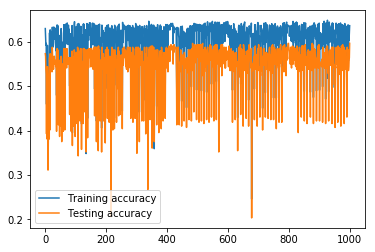

In [33]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

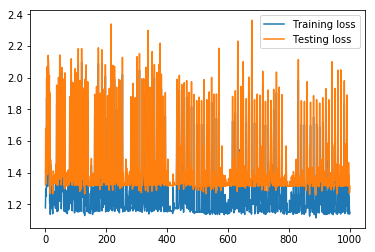

In [34]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()